# MTCNN

### one example to show the expected result

In [112]:
from PIL import Image
from PIL import ImageDraw
import os

IMG_DIR = r"."
img = Image.open(os.path.join(IMG_DIR, "0_Parade_marchingband_1_1048.jpg"))
imgDraw = ImageDraw.Draw(img)
imgDraw.rectangle((432, 128 , 432+252, 128+362  ),outline="red",width=3)
img.show()

the example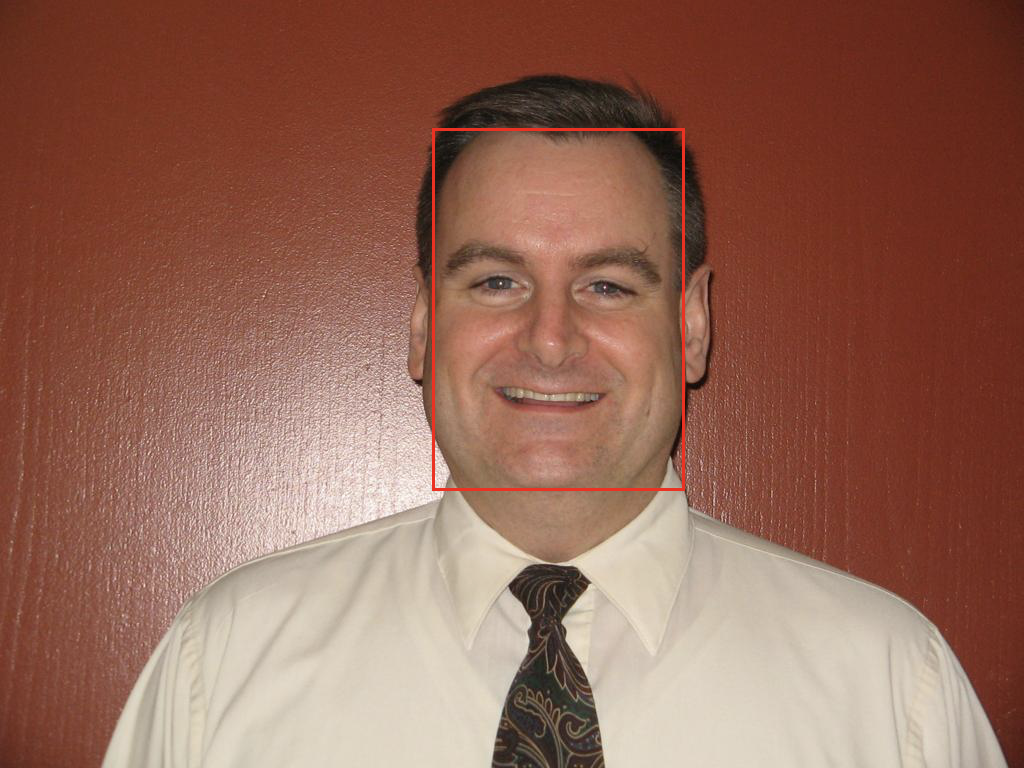

## The Main Part

In [46]:
# this can help not show run time error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [51]:
import os
import numpy as np
#image loader
class ImageDB(object):
    def __init__(self, image_annotation_file, prefix_path='', mode='train'):
        self.prefix_path = prefix_path
        self.image_annotation_file = image_annotation_file
        self.classes = ['__background__', 'face']
        self.num_classes = 2
        self.image_set_index = self.load_image_set_index()
        self.num_images = len(self.image_set_index)
        self.mode = mode
        print(self.num_images)


    def load_image_set_index(self):
        
        assert os.path.exists(self.image_annotation_file), 'Path does not exist: {}'.format(self.image_annotation_file)
        with open(self.image_annotation_file, 'r') as f:
            image_set_index = [x.strip().split(' ')[0] for x in f.readlines()]
        return image_set_index


    def load_imdb(self):
        
        gt_imdb = self.load_annotations()
        return gt_imdb


    def real_image_path(self, index):
       
        index = index.replace("\\", "/")

        if not os.path.exists(index):
            image_file = os.path.join(self.prefix_path, index)
        else:
            image_file=index
        if not image_file.endswith('.jpg'):
            image_file = image_file + '.jpg'
        assert os.path.exists(image_file), 'Path does not exist: {}'.format(image_file)
        return image_file


    def load_annotations(self,annotion_type=1):
      
        assert os.path.exists(self.image_annotation_file), 'annotations not found at {}'.format(self.image_annotation_file)
        with open(self.image_annotation_file, 'r') as f:
            annotations = f.readlines()

        imdb = []
        number = self.num_images###############control the number of images reader
        for i in range(number):
            annotation = annotations[i].strip().split(' ')
            if i%10000==0:
                print(i)
            index = annotation[0]
            im_path = self.real_image_path(index)
            imdb_ = dict()
            imdb_['image'] = im_path

            if self.mode == 'test':
                pass
            else:
                label = annotation[1]
                imdb_['label'] = int(label)
                imdb_['flipped'] = False
                imdb_['bbox_target'] = np.zeros((4,))
                imdb_['landmark_target'] = np.zeros((10,))
                if len(annotation[2:])==4:
                    bbox_target = annotation[2:6]
                    imdb_['bbox_target'] = np.array(bbox_target).astype(float)
                if len(annotation[2:])==14:
                    bbox_target = annotation[2:6]
                    imdb_['bbox_target'] = np.array(bbox_target).astype(float)
                    landmark = annotation[6:]
                    imdb_['landmark_target'] = np.array(landmark).astype(float)
            imdb.append(imdb_)

        return imdb


    def append_flipped_images(self, imdb):
       
        print('append flipped images to imdb', len(imdb))
        for i in range(len(imdb)):
            imdb_ = imdb[i]
            m_bbox = imdb_['bbox_target'].copy()
            m_bbox[0], m_bbox[2] = -m_bbox[2], -m_bbox[0]

            landmark_ = imdb_['landmark_target'].copy()
            landmark_ = landmark_.reshape((5, 2))
            landmark_ = np.asarray([(1 - x, y) for (x, y) in landmark_])
            landmark_[[0, 1]] = landmark_[[1, 0]]
            landmark_[[3, 4]] = landmark_[[4, 3]]

            item = {'image': imdb_['image'],
                     'label': imdb_['label'],
                     'bbox_target': m_bbox,
                     'landmark_target': landmark_.reshape((10)),
                     'flipped': True}

            imdb.append(item)
        self.image_set_index *= 2
        return imdb

In [60]:
import numpy as np
import cv2
#image reader


class TrainImageReader:
    def __init__(self, imdb, im_size, batch_size=128, shuffle=False):

        self.imdb = imdb
        self.batch_size = batch_size
        self.im_size = im_size
        self.shuffle = shuffle

        self.cur = 0
        self.size = len(imdb)
        self.index = np.arange(self.size)
        self.num_classes = 2

        self.batch = None
        self.data = None
        self.label = None

        self.label_names= ['label', 'bbox_target', 'landmark_target']
        self.reset()
        self.get_batch()

    def reset(self):
        self.cur = 0
        if self.shuffle:
            np.random.shuffle(self.index)

    def iter_next(self):
        return self.cur + self.batch_size <= self.size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self.iter_next():
            self.get_batch()
            self.cur += self.batch_size
            return self.data,self.label
        else:
            raise StopIteration

    def getindex(self):
        return self.cur / self.batch_size

    def getpad(self):
        if self.cur + self.batch_size > self.size:
            return self.cur + self.batch_size - self.size
        else:
            return 0

    def get_batch(self):
        cur_from = self.cur
        cur_to = min(cur_from + self.batch_size, self.size)
        imdb = [self.imdb[self.index[i]] for i in range(cur_from, cur_to)]
        data, label = get_minibatch(imdb)
        self.data = data['data']
        self.label = [label[name] for name in self.label_names]



class TestImageLoader:
    def __init__(self, imdb, batch_size=1, shuffle=False):
        self.imdb = imdb
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.size = len(imdb)
        self.index = np.arange(self.size)

        self.cur = 0
        self.data = None
        self.label = None

        self.reset()
        self.get_batch()

    def reset(self):
        self.cur = 0
        if self.shuffle:
            np.random.shuffle(self.index)

    def iter_next(self):
        return self.cur + self.batch_size <= self.size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self.iter_next():
            self.get_batch()
            self.cur += self.batch_size
            return self.data
        else:
            raise StopIteration

    def getindex(self):
        return self.cur / self.batch_size

    def getpad(self):
        if self.cur + self.batch_size > self.size:
            return self.cur + self.batch_size - self.size
        else:
            return 0

    def get_batch(self):
        cur_from = self.cur
        cur_to = min(cur_from + self.batch_size, self.size)
        imdb = [self.imdb[self.index[i]] for i in range(cur_from, cur_to)]
        data= get_testbatch(imdb)
        self.data=data['data']




def get_minibatch(imdb):

    # im_size: 12, 24 or 48
    num_images = len(imdb)
    processed_ims = list()
    cls_label = list()
    bbox_reg_target = list()
    landmark_reg_target = list()

    for i in range(num_images):
        im = cv2.imread(imdb[i]['image'])
        #im = Image.open(imdb[i]['image'])

        if imdb[i]['flipped']:
            im = im[:, ::-1, :]
            #im = im.transpose(Image.FLIP_LEFT_RIGHT)

        cls = imdb[i]['label']
        bbox_target = imdb[i]['bbox_target']
        landmark = imdb[i]['landmark_target']

        processed_ims.append(im)
        cls_label.append(cls)
        bbox_reg_target.append(bbox_target)
        landmark_reg_target.append(landmark)

    im_array = np.asarray(processed_ims)

    label_array = np.array(cls_label)

    bbox_target_array = np.vstack(bbox_reg_target)

    landmark_target_array = np.vstack(landmark_reg_target)

    data = {'data': im_array}
    label = {'label': label_array,
             'bbox_target': bbox_target_array,
             'landmark_target': landmark_target_array
             }

    return data, label


def get_testbatch(imdb):
    assert len(imdb) == 1, "Single batch only"
    im = cv2.imread(imdb[0]['image'])
    data = {'data': im}
    return data

In [49]:
import os
import numpy.random as npr
import numpy as np

def assemble_data(output_file, anno_file_list=[]):

    #assemble the pos, neg, part annotations to one file
    size = 12

    if len(anno_file_list)==0:
        return 0

    if os.path.exists(output_file):
        os.remove(output_file)

    for anno_file in anno_file_list:
        with open(anno_file, 'r') as f:
            print(anno_file)
            anno_lines = f.readlines()

        base_num = 250000

        if len(anno_lines) > base_num * 3:
            idx_keep = npr.choice(len(anno_lines), size=base_num * 3, replace=True)
        elif len(anno_lines) > 100000:
            idx_keep = npr.choice(len(anno_lines), size=len(anno_lines), replace=True)
        else:
            idx_keep = np.arange(len(anno_lines))
            np.random.shuffle(idx_keep)
        chose_count = 0
        with open(output_file, 'a+') as f:
            for idx in idx_keep:
                f.write(anno_lines[idx])
                chose_count+=1

    return chose_count

In [53]:
import torchvision.transforms as transforms
import torch
from torch.autograd.variable import Variable
import numpy as np

transform = transforms.ToTensor()

def convert_image_to_tensor(image):
    """convert an image to pytorch tensor
        Parameters:
        ----------
        image: numpy array , h * w * c
        Returns:
        -------
        image_tensor: pytorch.FloatTensor, c * h * w
        """
    # image = image.astype(np.float32)
    return transform(image)
    # return transform(image)


def convert_chwTensor_to_hwcNumpy(tensor):
    """convert a group images pytorch tensor(count * c * h * w) to numpy array images(count * h * w * c)
            Parameters:
            ----------
            tensor: numpy array , count * c * h * w
            Returns:
            -------
            numpy array images: count * h * w * c
            """

    if isinstance(tensor, Variable):
        return np.transpose(tensor.data.numpy(), (0,2,3,1))
    elif isinstance(tensor, torch.FloatTensor):
        return np.transpose(tensor.numpy(), (0,2,3,1))
    else:
        raise Exception("covert b*c*h*w tensor to b*h*w*c numpy error.This tensor must have 4 dimension.")

In [47]:
import numpy as np
# the basic tools
def IoU(box, boxes):
    # box = (x1, y1, x2, y2)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    
    # the offset of the interception of union between crop_box and gt_box
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = np.true_divide(inter,(box_area + area - inter))
    return ovr


def convert_to_square(bbox):
    
    square_bbox = bbox.copy()

    h = bbox[:, 3] - bbox[:, 1] + 1
    w = bbox[:, 2] - bbox[:, 0] + 1
    max_side = np.maximum(h,w)
    square_bbox[:, 0] = bbox[:, 0] + w*0.5 - max_side*0.5
    square_bbox[:, 1] = bbox[:, 1] + h*0.5 - max_side*0.5
    square_bbox[:, 2] = square_bbox[:, 0] + max_side - 1
    square_bbox[:, 3] = square_bbox[:, 1] + max_side - 1
    return square_bbox

def nms(dets, thresh, mode="Union"):
    
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] 
   
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        
        if mode == "Union":
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
        elif mode == "Minimum":
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1] 
        # print(inds)
        
    return keep


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#net and the loss function
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight.data)
        nn.init.constant(m.bias, 0.1)



class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):
        # loss function
        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss() # binary cross entropy
        self.loss_box = nn.MSELoss() # mean square error
        self.loss_landmark = nn.MSELoss()


    def cls_loss(self,gt_label,pred_label):
        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        # get the mask element which >= 0, only 0 and 1 can effect the detection loss
        mask = torch.ge(gt_label,0)
        valid_gt_label = torch.masked_select(gt_label,mask)
        valid_pred_label = torch.masked_select(pred_label,mask)
        return self.loss_cls(valid_pred_label,valid_gt_label)*self.cls_factor


    def box_loss(self,gt_label,gt_offset,pred_offset):
        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)

        #get the mask element which != 0
        unmask = torch.eq(gt_label,0)
        mask = torch.eq(unmask,0)
        #convert mask to dim index
        chose_index = torch.nonzero(mask.data)
        chose_index = torch.squeeze(chose_index)
        #only valid element can effect the loss
        valid_gt_offset = gt_offset[chose_index,:]
        valid_pred_offset = pred_offset[chose_index,:]
        return self.loss_box(valid_pred_offset,valid_gt_offset)*self.box_factor


    def landmark_loss(self,gt_label,gt_landmark,pred_landmark):
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(gt_label)
        mask = torch.eq(gt_label,-2)

        chose_index = torch.nonzero(mask.data)
        chose_index = torch.squeeze(chose_index)

        valid_gt_landmark = gt_landmark[chose_index, :]
        valid_pred_landmark = pred_landmark[chose_index, :]
        return self.loss_landmark(valid_pred_landmark,valid_gt_landmark)*self.land_factor





class PNet(nn.Module):
    ''' PNet '''

    def __init__(self, is_train=False, use_cuda=True):
        super(PNet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda

        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool1
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # PReLU2
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # conv3
            nn.PReLU()  # PReLU3
        )
        # detection
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        # bounding box regresion
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        # landmark localization
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)

        # weight initiation with xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        label = F.sigmoid(self.conv4_1(x))
        offset = self.conv4_2(x)
        # landmark = self.conv4_3(x)

        if self.is_train is True:
            # label_loss = LossUtil.label_loss(self.gt_label,torch.squeeze(label))
            # bbox_loss = LossUtil.bbox_loss(self.gt_bbox,torch.squeeze(offset))
            return label,offset
        #landmark = self.conv4_3(x)
        return label, offset





class RNet(nn.Module):
    ''' RNet '''

    def __init__(self,is_train=False, use_cuda=True):
        super(RNet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda
        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  # conv3
            nn.PReLU()  # prelu3

        )
        self.conv4 = nn.Linear(64*2*2, 128)  # conv4
        self.prelu4 = nn.PReLU()  # prelu4
        # detection
        self.conv5_1 = nn.Linear(128, 1)
        # bounding box regression
        self.conv5_2 = nn.Linear(128, 4)
        # lanbmark localization
        self.conv5_3 = nn.Linear(128, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        # backend
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        # detection
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        # landmark = self.conv5_3(x)

        if self.is_train is True:
            return det, box
        #landmard = self.conv5_3(x)
        return det, box




class ONet(nn.Module):
    ''' RNet '''

    def __init__(self,is_train=False, use_cuda=True):
        super(ONet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda
        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(), # prelu3
            nn.MaxPool2d(kernel_size=2,stride=2), # pool3
            nn.Conv2d(64,128,kernel_size=2,stride=1), # conv4
            nn.PReLU() # prelu4
        )
        self.conv5 = nn.Linear(128*2*2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5
        # detection
        self.conv6_1 = nn.Linear(256, 1)
        # bounding box regression
        self.conv6_2 = nn.Linear(256, 4)
        # lanbmark localization
        self.conv6_3 = nn.Linear(256, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        # backend
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        # detection
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        if self.is_train is True:
            return det, box, landmark
        #landmard = self.conv5_3(x)
        return det, box, landmark





# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out



# ResNet Module
class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, 16,kernel_size=3)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, 3)
        self.layer2 = self.make_layer(block, 32, 3, 2)
        self.layer3 = self.make_layer(block, 64, 3, 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [61]:
import datetime
import os
import torch
from torch.autograd import Variable
import numpy as np

# train net
def compute_accuracy(prob_cls, gt_cls):

    prob_cls = torch.squeeze(prob_cls)
    gt_cls = torch.squeeze(gt_cls)

    #we only need the detection which >= 0
    mask = torch.ge(gt_cls,0)
    #get valid element
    valid_gt_cls = torch.masked_select(gt_cls,mask)
    valid_prob_cls = torch.masked_select(prob_cls,mask)
    size = min(valid_gt_cls.size()[0], valid_prob_cls.size()[0])
    prob_ones = torch.ge(valid_prob_cls,0.6).float()
    right_ones = torch.eq(prob_ones,valid_gt_cls).float()

    ## if size == 0 meaning that your gt_labels are all negative, landmark or part

    return torch.div(torch.mul(torch.sum(right_ones),float(1.0)),float(size))  ## divided by zero meaning that your gt_labels are all negative, landmark or part


def train_pnet(model_store_path, end_epoch,imdb,
              batch_size,frequent=10,base_lr=0.01,lr_epoch_decay=[9],use_cuda=True,load=''):
    
    lr_epoch_decay.append(end_epoch+1)
    lr_list = np.zeros(end_epoch)
    lr_t = base_lr
    for i in range(len(lr_epoch_decay)):
        if i==0:
            lr_list[0:lr_epoch_decay[i]-1]=lr_t
        else:
            lr_list[lr_epoch_decay[i-1]-1:lr_epoch_decay[i]-1]=lr_t
        lr_t*=0.1

    if not os.path.exists(model_store_path):
        os.makedirs(model_store_path)

    lossfn = LossFn()
    net = PNet(is_train=True, use_cuda=use_cuda)
    if load!='':
        net.load_state_dict(torch.load(load))
        print('model loaded',load)
    net.train()

    if use_cuda:
        net.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr_list[0])

    train_data=TrainImageReader(imdb,12,batch_size,shuffle=True)

    frequent = 10
    for cur_epoch in range(1,end_epoch+1):
        train_data.reset() # shuffle

        for batch_idx,(image,(gt_label,gt_bbox,gt_landmark))in enumerate(train_data):

            im_tensor = [convert_image_to_tensor(image[i,:,:,:]) for i in range(image.shape[0])]
            im_tensor = torch.stack(im_tensor)

            im_tensor = Variable(im_tensor)
            gt_label = Variable(torch.from_numpy(gt_label).float())

            gt_bbox = Variable(torch.from_numpy(gt_bbox).float())
            # gt_landmark = Variable(torch.from_numpy(gt_landmark).float())

            if use_cuda:
                im_tensor = im_tensor.cuda()
                gt_label = gt_label.cuda()
                gt_bbox = gt_bbox.cuda()
                # gt_landmark = gt_landmark.cuda()

            cls_pred, box_offset_pred = net(im_tensor)
            # all_loss, cls_loss, offset_loss = lossfn.loss(gt_label=label_y,gt_offset=bbox_y, pred_label=cls_pred, pred_offset=box_offset_pred)

            cls_loss = lossfn.cls_loss(gt_label,cls_pred)
            box_offset_loss = lossfn.box_loss(gt_label,gt_bbox,box_offset_pred)
            # landmark_loss = lossfn.landmark_loss(gt_label,gt_landmark,landmark_offset_pred)

            all_loss = cls_loss*1.0+box_offset_loss*0.5

            if batch_idx %frequent==0:
                accuracy=compute_accuracy(cls_pred,gt_label)

                show1 = accuracy.data.cpu().numpy()
                show2 = cls_loss.data.cpu().numpy()
                show3 = box_offset_loss.data.cpu().numpy()
                # show4 = landmark_loss.data.cpu().numpy()
                show5 = all_loss.data.cpu().numpy()

                print("%s : Epoch: %d, Step: %d, accuracy: %s, det loss: %s, bbox loss: %s, all_loss: %s, lr:%s "%(datetime.datetime.now(),cur_epoch,batch_idx, show1,show2,show3,show5,lr_list[cur_epoch-1]))

            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

        torch.save(net.state_dict(), os.path.join(model_store_path,"pnet_epoch_%d.pt" % cur_epoch))
        torch.save(net, os.path.join(model_store_path,"pnet_epoch_model_%d.pkl" % cur_epoch))




def train_rnet(model_store_path, end_epoch,imdb,
              batch_size,frequent=50,base_lr=0.01,lr_epoch_decay=[9],use_cuda=True):
    lr_epoch_decay.append(end_epoch+1)
    lr_list = np.zeros(end_epoch)
    lr_t = base_lr
    for i in range(len(lr_epoch_decay)):
        if i==0:
            lr_list[0:lr_epoch_decay[i]-1]=lr_t
        else:
            lr_list[lr_epoch_decay[i-1]-1:lr_epoch_decay[i]-1]=lr_t
        lr_t*=0.1
    print(lr_list)
    
    
    if not os.path.exists(model_store_path):
        os.makedirs(model_store_path)

    lossfn = LossFn()
    net = RNet(is_train=True, use_cuda=use_cuda)
    net.train()
    if load!='':
        net.load_state_dict(torch.load(load))
        print('model loaded',load)
    if use_cuda:
        net.cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=base_lr)

    train_data=TrainImageReader(imdb,24,batch_size,shuffle=True)


    for cur_epoch in range(1,end_epoch+1):
        train_data.reset()
        for param in optimizer.param_groups:
            param['lr'] = lr_list[cur_epoch-1]
        for batch_idx,(image,(gt_label,gt_bbox,gt_landmark))in enumerate(train_data):

            im_tensor = [convert_image_to_tensor(image[i,:,:,:]) for i in range(image.shape[0])]
            im_tensor = torch.stack(im_tensor)

            im_tensor = Variable(im_tensor)
            gt_label = Variable(torch.from_numpy(gt_label).float())

            gt_bbox = Variable(torch.from_numpy(gt_bbox).float())
            gt_landmark = Variable(torch.from_numpy(gt_landmark).float())

            if use_cuda:
                im_tensor = im_tensor.cuda()
                gt_label = gt_label.cuda()
                gt_bbox = gt_bbox.cuda()
                gt_landmark = gt_landmark.cuda()

            cls_pred, box_offset_pred = net(im_tensor)
            # all_loss, cls_loss, offset_loss = lossfn.loss(gt_label=label_y,gt_offset=bbox_y, pred_label=cls_pred, pred_offset=box_offset_pred)

            cls_loss = lossfn.cls_loss(gt_label,cls_pred)
            box_offset_loss = lossfn.box_loss(gt_label,gt_bbox,box_offset_pred)
            # landmark_loss = lossfn.landmark_loss(gt_label,gt_landmark,landmark_offset_pred)

            all_loss = cls_loss*1.0+box_offset_loss*0.5

            if batch_idx%frequent==0:
                accuracy=compute_accuracy(cls_pred,gt_label)

                show1 = accuracy.data.cpu().numpy()
                show2 = cls_loss.data.cpu().numpy()
                show3 = box_offset_loss.data.cpu().numpy()
                # show4 = landmark_loss.data.cpu().numpy()
                show5 = all_loss.data.cpu().numpy()

                print("%s : Epoch: %d, Step: %d, accuracy: %s, det loss: %s, bbox loss: %s, all_loss: %s, lr:%s "%(datetime.datetime.now(), cur_epoch, batch_idx, show1, show2, show3, show5, lr_list[cur_epoch-1]))

            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

        torch.save(net.state_dict(), os.path.join(model_store_path,"rnet_epoch_%d.pt" % cur_epoch))
        torch.save(net, os.path.join(model_store_path,"rnet_epoch_model_%d.pkl" % cur_epoch))


def train_onet(model_store_path, end_epoch,imdb,
              batch_size,frequent=50,base_lr=0.01,lr_epoch_decay=[9],use_cuda=True):
    lr_epoch_decay.append(end_epoch+1)
    lr_list = np.zeros(end_epoch)
    lr_t = base_lr
    for i in range(len(lr_epoch_decay)):
        if i==0:
            lr_list[0:lr_epoch_decay[i]-1]=lr_t
        else:
            lr_list[lr_epoch_decay[i-1]-1:lr_epoch_decay[i]-1]=lr_t
        lr_t*=0.1
    print(lr_list)
    
    if not os.path.exists(model_store_path):
        os.makedirs(model_store_path)

    lossfn = LossFn()
    net = ONet(is_train=True)
    net.train()
    if load!='':
        net.load_state_dict(torch.load(load))
        print('model loaded',load)
    if use_cuda:
        net.cuda()
    print(use_cuda)
    if use_cuda:
        net.cuda()

    optimizer = torch.optim.Adam(net.parameters(), lr=base_lr)

    train_data=TrainImageReader(imdb,48,batch_size,shuffle=True)


    for cur_epoch in range(1,end_epoch+1):

        train_data.reset()
        for param in optimizer.param_groups:
            param['lr'] = lr_list[cur_epoch-1]
            
        for batch_idx,(image,(gt_label,gt_bbox,gt_landmark))in enumerate(train_data):
            # print("batch id {0}".format(batch_idx))
            im_tensor = [  convert_image_to_tensor(image[i,:,:,:]) for i in range(image.shape[0]) ]
            im_tensor = torch.stack(im_tensor)

            im_tensor = Variable(im_tensor)
            gt_label = Variable(torch.from_numpy(gt_label).float())

            gt_bbox = Variable(torch.from_numpy(gt_bbox).float())
            gt_landmark = Variable(torch.from_numpy(gt_landmark).float())

            if use_cuda:
                im_tensor = im_tensor.cuda()
                gt_label = gt_label.cuda()
                gt_bbox = gt_bbox.cuda()
                gt_landmark = gt_landmark.cuda()

            cls_pred, box_offset_pred, landmark_offset_pred = net(im_tensor)

            # all_loss, cls_loss, offset_loss = lossfn.loss(gt_label=label_y,gt_offset=bbox_y, pred_label=cls_pred, pred_offset=box_offset_pred)

            cls_loss = lossfn.cls_loss(gt_label,cls_pred)
            box_offset_loss = lossfn.box_loss(gt_label,gt_bbox,box_offset_pred)
            landmark_loss = lossfn.landmark_loss(gt_label,gt_landmark,landmark_offset_pred)

            all_loss = cls_loss*0.8+box_offset_loss*0.6###+landmark_loss*1.5

            if batch_idx%frequent==0:
                accuracy=compute_accuracy(cls_pred,gt_label)

                show1 = accuracy.data.cpu().numpy()
                show2 = cls_loss.data.cpu().numpy()
                show3 = box_offset_loss.data.cpu().numpy()
                #show4 = landmark_loss.data.cpu().numpy()
                show5 = all_loss.data.cpu().numpy()

                print("%s : Epoch: %d, Step: %d, accuracy: %s, det loss: %s, bbox loss: %s,  all_loss: %s, lr:%s "%(datetime.datetime.now(),cur_epoch,batch_idx, show1,show2,show3,show5,lr_list[cur_epoch-1]))

            optimizer.zero_grad()
            all_loss.backward()
            optimizer.step()

        torch.save(net.state_dict(), os.path.join(model_store_path,"onet_epoch_%d.pt" % cur_epoch))
        torch.save(net, os.path.join(model_store_path,"onet_epoch_model_%d.pkl" % cur_epoch))

In [64]:
import cv2
import time
import numpy as np
import torch
from torch.autograd.variable import Variable
# create the whole mtcnn
def create_mtcnn_net(p_model_path=None, r_model_path=None, o_model_path=None, use_cuda=True):

    pnet, rnet, onet = None, None, None

    if p_model_path is not None:
        pnet = PNet(use_cuda=use_cuda)
        if(use_cuda):
            print('p_model_path:{0}'.format(p_model_path))
            pnet.load_state_dict(torch.load(p_model_path))
            pnet.cuda()
        else:
            
            pnet.load_state_dict(torch.load(p_model_path, map_location='cpu'))
        pnet.eval()

    if r_model_path is not None:
        rnet = RNet(use_cuda=use_cuda)
        if (use_cuda):
            print('r_model_path:{0}'.format(r_model_path))
            rnet.load_state_dict(torch.load(r_model_path))
            rnet.cuda()
        else:
            rnet.load_state_dict(torch.load(r_model_path, map_location=lambda storage, loc: storage))
        rnet.eval()

    if o_model_path is not None:
        onet = ONet(use_cuda=use_cuda)
        if (use_cuda):
            print('o_model_path:{0}'.format(o_model_path))
            onet.load_state_dict(torch.load(o_model_path))
            onet.cuda()
        else:
            onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
        onet.eval()

    return pnet,rnet,onet


class MtcnnDetector(object):
    """
        P,R,O net face detection and landmarks align
    """
    def  __init__(self,
                 pnet = None,
                 rnet = None,
                 onet = None,
                 min_face_size=12,
                 stride=2,
                 threshold=[0.6, 0.7, 0.7],
                 scale_factor=0.709,
                 ):

        self.pnet_detector = pnet
        self.rnet_detector = rnet
        self.onet_detector = onet
        self.min_face_size = min_face_size
        self.stride=stride
        self.thresh = threshold
        self.scale_factor = scale_factor


    def unique_image_format(self,im):
        if not isinstance(im,np.ndarray):
            if im.mode == 'I':
                im = np.array(im, np.int32, copy=False)
            elif im.mode == 'I;16':
                im = np.array(im, np.int16, copy=False)
            else:
                im = np.asarray(im)
        return im

    def square_bbox(self, bbox):
        
        square_bbox = bbox.copy()

        
        
        h = bbox[:, 3] - bbox[:, 1] + 1# x2 - x1
        w = bbox[:, 2] - bbox[:, 0] + 1# y2 - y1
        l = np.maximum(h,w)
        square_bbox[:, 0] = bbox[:, 0] + w*0.5 - l*0.5
        square_bbox[:, 1] = bbox[:, 1] + h*0.5 - l*0.5

        # x2 = x1 + l - 1
        # y2 = y1 + l - 1
        square_bbox[:, 2] = square_bbox[:, 0] + l - 1
        square_bbox[:, 3] = square_bbox[:, 1] + l - 1
        return square_bbox


    def generate_bounding_box(self, map, reg, scale, threshold):
        
        stride = 2
        cellsize = 12 # receptive field

        t_index = np.where(map[:,:,0] > threshold)
        
        if t_index[0].size == 0:
            return np.array([])

        
        dx1, dy1, dx2, dy2 = [reg[0, t_index[0], t_index[1], i] for i in range(4)]
        
        reg = np.array([dx1, dy1, dx2, dy2])
        
        score = map[t_index[0], t_index[1], 0]

      
        boundingbox = np.vstack([np.round((stride * t_index[1]) / scale),            # x1 of prediction box in original image
                                 np.round((stride * t_index[0]) / scale),            # y1 of prediction box in original image
                                 np.round((stride * t_index[1] + cellsize) / scale), # x2 of prediction box in original image
                                 np.round((stride * t_index[0] + cellsize) / scale), # y2 of prediction box in original image
                                                                                     # reconstruct the box in original image
                                 score,
                                 reg,
                                
                                 ])

        return boundingbox.T


    def resize_image(self, img, scale):
        #resize nd transform
        height, width, channels = img.shape
        new_height = int(height * scale)     # resized new height
        new_width = int(width * scale)       # resized new width
        new_dim = (new_width, new_height)
        img_resized = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR)      # resized image
        return img_resized


    def pad(self, bboxes, w, h):
        
        # width and height
        tmpw = (bboxes[:, 2] - bboxes[:, 0] + 1).astype(np.int32)
        tmph = (bboxes[:, 3] - bboxes[:, 1] + 1).astype(np.int32)
        numbox = bboxes.shape[0]

        dx = np.zeros((numbox, ))
        dy = np.zeros((numbox, ))
        edx, edy  = tmpw.copy()-1, tmph.copy()-1
        
        x, y, ex, ey = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]

        tmp_index = np.where(ex > w-1)
        edx[tmp_index] = tmpw[tmp_index] + w - 2 - ex[tmp_index]
        ex[tmp_index] = w - 1

        tmp_index = np.where(ey > h-1)
        edy[tmp_index] = tmph[tmp_index] + h - 2 - ey[tmp_index]
        ey[tmp_index] = h - 1

        tmp_index = np.where(x < 0)
        dx[tmp_index] = 0 - x[tmp_index]
        x[tmp_index] = 0

        tmp_index = np.where(y < 0)
        dy[tmp_index] = 0 - y[tmp_index]
        y[tmp_index] = 0

        return_list = [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph]
        return_list = [item.astype(np.int32) for item in return_list]

        return return_list


    def detect_pnet(self, im):
       #face box candidate detection

        # original wider face data
        h, w, c = im.shape

        net_size = 12

        current_scale = float(net_size) / self.min_face_size    # find initial scale
        im_resized = self.resize_image(im, current_scale) 
        current_height, current_width, _ = im_resized.shape

        # fcn
        all_boxes = list()
        
        while min(current_height, current_width) > net_size:
            # print(i)
            feed_imgs = []
            image_tensor =  convert_image_to_tensor(im_resized)
            feed_imgs.append(image_tensor)
            feed_imgs = torch.stack(feed_imgs)
            feed_imgs = Variable(feed_imgs)

            if self.pnet_detector.use_cuda:
                feed_imgs = feed_imgs.cuda()

           
            cls_map, reg = self.pnet_detector(feed_imgs)

            cls_map_np =  convert_chwTensor_to_hwcNumpy(cls_map.cpu())
            reg_np =  convert_chwTensor_to_hwcNumpy(reg.cpu())
            
            boxes = self.generate_bounding_box(cls_map_np[ 0, :, :], reg_np, current_scale, self.thresh[0])

            # generate pyramid images
            current_scale *= self.scale_factor 
            im_resized = self.resize_image(im, current_scale)
            current_height, current_width, _ = im_resized.shape

            if boxes.size == 0:
                continue

            # non-maximum suppresion
            keep = nms(boxes[:, :5], 0.5, 'Union')
            boxes = boxes[keep]
            # print(boxes.shape)
            all_boxes.append(boxes)
 

        if len(all_boxes) == 0:
            return None, None

        all_boxes = np.vstack(all_boxes)
       
        # merge the detection from first stage
        keep = nms(all_boxes[:, 0:5], 0.7, 'Union')
        all_boxes = all_boxes[keep]
        
        bw = all_boxes[:, 2] - all_boxes[:, 0] + 1
        bh = all_boxes[:, 3] - all_boxes[:, 1] + 1




        boxes = np.vstack([all_boxes[:,0],
                   all_boxes[:,1],
                   all_boxes[:,2],
                   all_boxes[:,3],
                   all_boxes[:,4],
                   
                  ])

        boxes = boxes.T

        # boxes = boxes = [x1, y1, x2, y2, score, reg] reg= [px1, py1, px2, py2] (in prediction)
        align_topx = all_boxes[:, 0] + all_boxes[:, 5] * bw
        align_topy = all_boxes[:, 1] + all_boxes[:, 6] * bh
        align_bottomx = all_boxes[:, 2] + all_boxes[:, 7] * bw
        align_bottomy = all_boxes[:, 3] + all_boxes[:, 8] * bh

        # refine the boxes
        boxes_align = np.vstack([ align_topx,
                              align_topy,
                              align_bottomx,
                              align_bottomy,
                              all_boxes[:, 4],
                             
                              ])
        boxes_align = boxes_align.T
        
        #remove invalid box
        valindex = [True for _ in range(boxes_align.shape[0])]   
        for i in range(boxes_align.shape[0]):
            if boxes_align[i][2]-boxes_align[i][0]<=3 or boxes_align[i][3]-boxes_align[i][1]<=3:
                valindex[i]=False
                print('pnet has one smaller than 3')
            else:
                if boxes_align[i][2]<1 or boxes_align[i][0]>w-2 or boxes_align[i][3]<1 or boxes_align[i][1]>h-2:
                    valindex[i]=False
                    print('pnet has one out')
        boxes_align=boxes_align[valindex,:]
        boxes = boxes[valindex,:]

        return boxes, boxes_align

    def detect_rnet(self, im, dets):
       #seect the face box candidate
        # im: an input image
        h, w, c = im.shape

        if dets is None:
            return None,None
        if dets.shape[0]==0:
            return None, None

        # return square boxes
        dets = self.square_bbox(dets)
        # rounds
        dets[:, 0:4] = np.round(dets[:, 0:4])

        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(dets, w, h)
        num_boxes = dets.shape[0]

        # cropped_ims_tensors = np.zeros((num_boxes, 3, 24, 24), dtype=np.float32)
        cropped_ims_tensors = []
        for i in range(num_boxes):
            try:
                tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
                tmp[dy[i]:edy[i]+1, dx[i]:edx[i]+1, :] = im[y[i]:ey[i]+1, x[i]:ex[i]+1, :]
            except:    
                print(dy[i],edy[i],dx[i],edx[i],y[i],ey[i],x[i],ex[i],tmpw[i],tmph[i])
                print(dets[i])
                print(detss[i])
                print(detsss[i])
                print(h,w)
                exit()
            crop_im = cv2.resize(tmp, (24, 24))
            crop_im_tensor = convert_image_to_tensor(crop_im)
            
            cropped_ims_tensors.append(crop_im_tensor)
        feed_imgs = Variable(torch.stack(cropped_ims_tensors))

        if self.rnet_detector.use_cuda:
            feed_imgs = feed_imgs.cuda()

        cls_map, reg = self.rnet_detector(feed_imgs)

        cls_map = cls_map.cpu().data.numpy()
        reg = reg.cpu().data.numpy()

        keep_inds = np.where(cls_map > self.thresh[1])[0]

        if len(keep_inds) > 0:
            boxes = dets[keep_inds]
            cls = cls_map[keep_inds]
            reg = reg[keep_inds]
           
        else:
            return None, None

        keep = nms(boxes, 0.7)

        if len(keep) == 0:
            return None, None

        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
     


        bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
        bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1


        boxes = np.vstack([ keep_boxes[:,0],
                              keep_boxes[:,1],
                              keep_boxes[:,2],
                              keep_boxes[:,3],
                              keep_cls[:,0],
                             
                            ])

        align_topx = keep_boxes[:,0] + keep_reg[:,0] * bw
        align_topy = keep_boxes[:,1] + keep_reg[:,1] * bh
        align_bottomx = keep_boxes[:,2] + keep_reg[:,2] * bw
        align_bottomy = keep_boxes[:,3] + keep_reg[:,3] * bh

        boxes_align = np.vstack([align_topx,
                               align_topy,
                               align_bottomx,
                               align_bottomy,
                               keep_cls[:, 0],
                               
                             ])

        boxes = boxes.T
        boxes_align = boxes_align.T
        #remove invalid box
        valindex = [True for _ in range(boxes_align.shape[0])]   
        for i in range(boxes_align.shape[0]):
            if boxes_align[i][2]-boxes_align[i][0]<=3 or boxes_align[i][3]-boxes_align[i][1]<=3:
                valindex[i]=False
                print('rnet has one smaller than 3')
            else:
                if boxes_align[i][2]<1 or boxes_align[i][0]>w-2 or boxes_align[i][3]<1 or boxes_align[i][1]>h-2:
                    valindex[i]=False
                    print('rnet has one out')
        boxes_align=boxes_align[valindex,:]
        boxes = boxes[valindex,:]

        return boxes, boxes_align

    def detect_onet(self, im, dets):
        # get the final face box
        h, w, c = im.shape

        if dets is None:
            return None, None
        if dets.shape[0]==0:
            return None, None

        dets = self.square_bbox(dets)
        dets[:, 0:4] = np.round(dets[:, 0:4])

        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(dets, w, h)
        num_boxes = dets.shape[0]


        # cropped_ims_tensors = np.zeros((num_boxes, 3, 24, 24), dtype=np.float32)
        cropped_ims_tensors = []
        for i in range(num_boxes):
            try:
                tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
                # crop input image
                tmp[dy[i]:edy[i] + 1, dx[i]:edx[i] + 1, :] = im[y[i]:ey[i] + 1, x[i]:ex[i] + 1, :]
            except:
                print(dy[i],edy[i],dx[i],edx[i],y[i],ey[i],x[i],ex[i],tmpw[i],tmph[i])
                print(dets[i])
                print(detss[i])
                print(h,w)
            crop_im = cv2.resize(tmp, (48, 48))
            crop_im_tensor = convert_image_to_tensor(crop_im)
           
            cropped_ims_tensors.append(crop_im_tensor)
        feed_imgs = Variable(torch.stack(cropped_ims_tensors))
        
        if self.rnet_detector.use_cuda:
            feed_imgs = feed_imgs.cuda()

        cls_map, reg, landmark = self.onet_detector(feed_imgs)

        cls_map = cls_map.cpu().data.numpy()
        reg = reg.cpu().data.numpy()
        landmark = landmark.cpu().data.numpy()

        keep_inds = np.where(cls_map > self.thresh[2])[0]

        if len(keep_inds) > 0:
            boxes = dets[keep_inds]
            cls = cls_map[keep_inds]
            reg = reg[keep_inds]
            landmark = landmark[keep_inds]
        else:
            return None, None

        keep = nms(boxes, 0.7, mode="Minimum")

        if len(keep) == 0:
            return None, None

        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
        keep_landmark = landmark[keep]

        bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
        bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1


        align_topx = keep_boxes[:, 0] + keep_reg[:, 0] * bw
        align_topy = keep_boxes[:, 1] + keep_reg[:, 1] * bh
        align_bottomx = keep_boxes[:, 2] + keep_reg[:, 2] * bw
        align_bottomy = keep_boxes[:, 3] + keep_reg[:, 3] * bh

        align_landmark_topx = keep_boxes[:, 0]
        align_landmark_topy = keep_boxes[:, 1]




        boxes_align = np.vstack([align_topx,
                                 align_topy,
                                 align_bottomx,
                                 align_bottomy,
                                 keep_cls[:, 0],
                                 ])

        boxes_align = boxes_align.T

        landmark =  np.vstack([
                                 align_landmark_topx + keep_landmark[:, 0] * bw,
                                 align_landmark_topy + keep_landmark[:, 1] * bh,
                                 align_landmark_topx + keep_landmark[:, 2] * bw,
                                 align_landmark_topy + keep_landmark[:, 3] * bh,
                                 align_landmark_topx + keep_landmark[:, 4] * bw,
                                 align_landmark_topy + keep_landmark[:, 5] * bh,
                                 align_landmark_topx + keep_landmark[:, 6] * bw,
                                 align_landmark_topy + keep_landmark[:, 7] * bh,
                                 align_landmark_topx + keep_landmark[:, 8] * bw,
                                 align_landmark_topy + keep_landmark[:, 9] * bh,
                                 ])

        landmark_align = landmark.T

        return boxes_align, landmark_align


    def detect_face(self,img):
        # detect the face
        boxes_align = np.array([])
        landmark_align =np.array([])

        t = time.time()

        # pnet
        if self.pnet_detector:
            boxes, boxes_align = self.detect_pnet(img)
            if boxes_align is None:
                return np.array([]), np.array([])

            t1 = time.time() - t
            t = time.time()

        # rnet
        if self.rnet_detector:
            boxes, boxes_align = self.detect_rnet(img, boxes_align)
            if boxes_align is None:
                return np.array([]), np.array([])

            t2 = time.time() - t
            t = time.time()

        # onet
        if self.onet_detector:
            boxes_align, landmark_align = self.detect_onet(img, boxes_align)
            if boxes_align is None:
                return np.array([]), np.array([])

            t3 = time.time() - t
            t = time.time()
            print("time cost " + '{:.3f}'.format(t1+t2+t3) + '  pnet {:.3f}  rnet {:.3f}  onet {:.3f}'.format(t1, t2, t3))

        return boxes_align, landmark_align

In [65]:
from matplotlib.patches import Circle
import os
import sys 

sys.path.append(os.getcwd())

def vis_two(im_array, dets1, dets2, thresh=0.9):
    #visualize the result
    import matplotlib.pyplot as plt
    import random
    import matplotlib.pyplot as plt
    import random
    import pylab

    figure = plt.figure()
    plt.subplot(121)
    plt.imshow(im_array)
    color = 'yellow'

    for i in range(dets1.shape[0]):
        bbox = dets1[i, :4]
        landmarks = dets1[i, 5:]
        score = dets1[i, 4]
        if score > thresh:
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor='red', linewidth=0.7)
            plt.gca().add_patch(rect)
            landmarks = landmarks.reshape((5,2))
            for j in range(5):
                plt.scatter(landmarks[j,0],landmarks[j,1],c='yellow',linewidths=0.1, marker='x', s=5)


    plt.subplot(122)
    plt.imshow(im_array)
    color = 'yellow'

    for i in range(dets2.shape[0]):
        bbox = dets2[i, :4]
        landmarks = dets1[i, 5:]
        score = dets2[i, 4]
        if score > thresh:
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor='red', linewidth=0.7)
            plt.gca().add_patch(rect)

            landmarks = landmarks.reshape((5, 2))
            for j in range(5):
                plt.scatter(landmarks[j, 0], landmarks[j, 1], c='yellow',linewidths=0.1, marker='x', s=5)

    plt.show()


def vis_face(im_array, dets, landmarks, save_name):
    # visualize detection results 
    import matplotlib.pyplot as plt
    import random
    import matplotlib.pyplot as plt
    import random
    import pylab
    

    figure = pylab.figure()
    # plt.subplot(121)
    pylab.imshow(im_array)

    for i in range(dets.shape[0]):
        bbox = dets[i, :4]

        rect = pylab.Rectangle((bbox[0], bbox[1]),
                             bbox[2] - bbox[0],
                             bbox[3] - bbox[1], fill=False,
                             edgecolor='yellow', linewidth=0.9)
        pylab.gca().add_patch(rect)

    if landmarks is not None:
        for i in range(landmarks.shape[0]):
            landmarks_one = landmarks[i, :]
            landmarks_one = landmarks_one.reshape((5, 2))
            for j in range(5):
               

                cir1 = Circle(xy=(landmarks_one[j, 0], landmarks_one[j, 1]), radius=2, alpha=0.4, color="red")
                pylab.gca().add_patch(cir1)
                
        pylab.savefig(save_name)
        pylab.show()

### Gennerate the P-net data

In [48]:
import sys
import numpy as np
import cv2
import os
sys.path.append(os.getcwd())
import numpy as np


prefix = ''
anno_file = "./anno_store/anno_train_fixed.txt"
im_dir = "./WIDER_train/images"
pos_save_dir = "./data_set/train/12/positive"
part_save_dir = "./data_set/train/12/part"
neg_save_dir = './data_set/train/12/negative'

if not os.path.exists(pos_save_dir):
    os.makedirs(pos_save_dir)
if not os.path.exists(part_save_dir):
    os.makedirs(part_save_dir)
if not os.path.exists(neg_save_dir):
    os.makedirs(neg_save_dir)

# store labels 
f1 = open(os.path.join('./anno_store', 'pos_12.txt'), 'w')
f2 = open(os.path.join('./anno_store', 'neg_12.txt'), 'w')
f3 = open(os.path.join('./anno_store', 'part_12.txt'), 'w')

with open(anno_file, 'r') as f:
    annotations = f.readlines()
num = len(annotations)
print("%d pics in total" % num)

p_idx = 0 # positive
n_idx = 0 # negative
d_idx = 0 # dont care
idx = 0
box_idx = 0
for annotation in annotations:
    annotation = annotation.strip().split(' ')
    im_path = os.path.join(prefix, annotation[0])
    #print(im_path)
    bbox = list(map(float, annotation[1:]))
    boxes = np.array(bbox, dtype=np.int32).reshape(-1, 4)
    img = cv2.imread(im_path)
    idx += 1
    if idx % 100 == 0:
        print(idx, "images done")

    height, width, channel = img.shape

    neg_num = 0
    while neg_num < 50:
        size = np.random.randint(12, min(width, height) / 2)
        nx = np.random.randint(0, width - size)
        ny = np.random.randint(0, height - size)
        crop_box = np.array([nx, ny, nx + size, ny + size])

        Iou = IoU(crop_box, boxes)

        cropped_im = img[ny: ny + size, nx: nx + size, :]
        resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

        if np.max(Iou) < 0.3:
            # Iou with all gts must below 0.3
            save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
            f2.write(save_file + ' 0\n')
            cv2.imwrite(save_file, resized_im)
            n_idx += 1
            neg_num += 1

    for box in boxes:
        # box (x_left, y_top, x_right, y_bottom)
        x1, y1, x2, y2 = box
        # w = x2 - x1 + 1
        # h = y2 - y1 + 1
        w = abs(x2 - x1 + 1)
        h = abs(y2 - y1 + 1)
#         x1,y1,w,h=box
#         if w<0 or h<0:
#             w=abs(w)
#             h=abs(h)
    


        # ignore small faces
        if max(w, h) < 40 or x1 < 0 or y1 < 0:
            continue
        for i in range(5):
            size = np.random.randint(12, min(width, height) / 2)
            # delta_x and delta_y are offsets of (x1, y1)

            delta_x = np.random.randint(max(-size, -x1), w)
            delta_y = np.random.randint(max(-size, -y1), h)
            nx1 = max(0, x1 + delta_x)
            ny1 = max(0, y1 + delta_y)

            if nx1 + size > width or ny1 + size > height:
                continue
            crop_box = np.array([nx1, ny1, nx1 + size, ny1 + size])
            Iou = IoU(crop_box, boxes)

            cropped_im = img[ny1: ny1 + size, nx1: nx1 + size, :]
            resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1

        # generate positive examples and part faces
        for i in range(20):
            size = np.random.randint(int(min(w, h) * 0.8), np.ceil(1.25 * max(w, h)))

            # delta here is the offset of box center
            delta_x = np.random.randint(-w * 0.2, w * 0.2)
            delta_y = np.random.randint(-h * 0.2, h * 0.2)

            nx1 = max(x1 + w / 2 + delta_x - size / 2, 0)
            ny1 = max(y1 + h / 2 + delta_y - size / 2, 0)
            nx2 = nx1 + size
            ny2 = ny1 + size

            if nx2 > width or ny2 > height:
                continue
            crop_box = np.array([nx1, ny1, nx2, ny2])

            offset_x1 = (x1 - nx1) / float(size)
            offset_y1 = (y1 - ny1) / float(size)
            offset_x2 = (x2 - nx2) / float(size)
            offset_y2 = (y2 - ny2) / float(size)

            cropped_im = img[int(ny1): int(ny2), int(nx1): int(nx2), :]
            resized_im = cv2.resize(cropped_im, (12, 12), interpolation=cv2.INTER_LINEAR)

            box_ = box.reshape(1, -1)
            if IoU(crop_box, box_) >= 0.65:
                save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                p_idx += 1
            elif IoU(crop_box, box_) >= 0.4:
                save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (offset_x1, offset_y1, offset_x2, offset_y2))
                cv2.imwrite(save_file, resized_im)
                d_idx += 1
        box_idx += 1
        print("%s images done, pos: %s part: %s neg: %s" % (idx, p_idx, d_idx, n_idx))

f1.close()
f2.close()
f3.close()

12880 pics in total
1 images done, pos: 5 part: 15 neg: 55
2 images done, pos: 10 part: 30 neg: 110
4 images done, pos: 17 part: 43 neg: 215
4 images done, pos: 20 part: 60 neg: 220
4 images done, pos: 20 part: 79 neg: 225
4 images done, pos: 24 part: 95 neg: 230
4 images done, pos: 29 part: 109 neg: 233
4 images done, pos: 36 part: 122 neg: 236
4 images done, pos: 41 part: 137 neg: 241
5 images done, pos: 52 part: 146 neg: 296
5 images done, pos: 61 part: 157 neg: 300
5 images done, pos: 65 part: 173 neg: 305
7 images done, pos: 75 part: 183 neg: 410
8 images done, pos: 80 part: 198 neg: 465
8 images done, pos: 87 part: 211 neg: 470
8 images done, pos: 90 part: 228 neg: 475
8 images done, pos: 98 part: 240 neg: 480
8 images done, pos: 105 part: 253 neg: 485
8 images done, pos: 105 part: 273 neg: 490
8 images done, pos: 108 part: 290 neg: 493
8 images done, pos: 113 part: 305 neg: 497
8 images done, pos: 121 part: 317 neg: 500
8 images done, pos: 125 part: 333 neg: 505
8 images done, p

62 images done, pos: 951 part: 2664 neg: 3903
65 images done, pos: 956 part: 2679 neg: 4058
65 images done, pos: 960 part: 2695 neg: 4063
65 images done, pos: 965 part: 2710 neg: 4068
65 images done, pos: 968 part: 2727 neg: 4073
67 images done, pos: 976 part: 2739 neg: 4178
67 images done, pos: 982 part: 2753 neg: 4183
67 images done, pos: 989 part: 2766 neg: 4188
70 images done, pos: 993 part: 2782 neg: 4342
71 images done, pos: 998 part: 2797 neg: 4397
71 images done, pos: 1000 part: 2815 neg: 4402
71 images done, pos: 1005 part: 2830 neg: 4407
72 images done, pos: 1014 part: 2841 neg: 4462
72 images done, pos: 1018 part: 2857 neg: 4467
74 images done, pos: 1024 part: 2871 neg: 4570
74 images done, pos: 1028 part: 2887 neg: 4574
74 images done, pos: 1038 part: 2897 neg: 4579
74 images done, pos: 1043 part: 2912 neg: 4584
74 images done, pos: 1049 part: 2926 neg: 4588
74 images done, pos: 1056 part: 2939 neg: 4593
74 images done, pos: 1060 part: 2955 neg: 4598
74 images done, pos: 10

130 images done, pos: 1978 part: 5138 neg: 8101
131 images done, pos: 1983 part: 5153 neg: 8156
131 images done, pos: 1995 part: 5161 neg: 8161
131 images done, pos: 2007 part: 5169 neg: 8166
131 images done, pos: 2015 part: 5181 neg: 8171
131 images done, pos: 2020 part: 5196 neg: 8176
131 images done, pos: 2026 part: 5210 neg: 8181
132 images done, pos: 2031 part: 5225 neg: 8234
132 images done, pos: 2039 part: 5237 neg: 8236
132 images done, pos: 2048 part: 5248 neg: 8240
132 images done, pos: 2053 part: 5263 neg: 8244
132 images done, pos: 2061 part: 5275 neg: 8249
132 images done, pos: 2065 part: 5291 neg: 8254
132 images done, pos: 2072 part: 5304 neg: 8258
132 images done, pos: 2076 part: 5320 neg: 8262
132 images done, pos: 2076 part: 5339 neg: 8266
132 images done, pos: 2079 part: 5350 neg: 8269
132 images done, pos: 2082 part: 5359 neg: 8272
132 images done, pos: 2082 part: 5378 neg: 8275
132 images done, pos: 2082 part: 5389 neg: 8280
132 images done, pos: 2088 part: 5403 ne

184 images done, pos: 2964 part: 7525 neg: 11550
184 images done, pos: 2973 part: 7536 neg: 11553
184 images done, pos: 2980 part: 7549 neg: 11558
184 images done, pos: 2986 part: 7563 neg: 11562
184 images done, pos: 2986 part: 7581 neg: 11565
184 images done, pos: 2997 part: 7590 neg: 11568
184 images done, pos: 2997 part: 7590 neg: 11568
184 images done, pos: 2997 part: 7600 neg: 11573
184 images done, pos: 2997 part: 7616 neg: 11578
184 images done, pos: 3000 part: 7633 neg: 11583
184 images done, pos: 3003 part: 7650 neg: 11588
184 images done, pos: 3007 part: 7666 neg: 11593
184 images done, pos: 3015 part: 7678 neg: 11598
189 images done, pos: 3015 part: 7690 neg: 11853
189 images done, pos: 3015 part: 7702 neg: 11858
189 images done, pos: 3020 part: 7717 neg: 11863
189 images done, pos: 3021 part: 7736 neg: 11868
191 images done, pos: 3031 part: 7746 neg: 11972
194 images done, pos: 3037 part: 7760 neg: 12127
194 images done, pos: 3050 part: 7767 neg: 12132
194 images done, pos

232 images done, pos: 3972 part: 9818 neg: 14689
232 images done, pos: 3975 part: 9835 neg: 14694
232 images done, pos: 3975 part: 9853 neg: 14699
232 images done, pos: 3976 part: 9872 neg: 14700
232 images done, pos: 3976 part: 9889 neg: 14703
232 images done, pos: 3984 part: 9901 neg: 14707
232 images done, pos: 3985 part: 9920 neg: 14709
232 images done, pos: 3988 part: 9934 neg: 14714
233 images done, pos: 3999 part: 9943 neg: 14769
233 images done, pos: 4008 part: 9954 neg: 14774
233 images done, pos: 4019 part: 9963 neg: 14779
234 images done, pos: 4027 part: 9975 neg: 14833
234 images done, pos: 4029 part: 9993 neg: 14836
234 images done, pos: 4031 part: 10011 neg: 14840
234 images done, pos: 4033 part: 10029 neg: 14844
234 images done, pos: 4039 part: 10043 neg: 14849
235 images done, pos: 4039 part: 10059 neg: 14903
235 images done, pos: 4042 part: 10075 neg: 14908
235 images done, pos: 4047 part: 10090 neg: 14912
237 images done, pos: 4054 part: 10103 neg: 15017
237 images do

279 images done, pos: 4811 part: 12203 neg: 17768
281 images done, pos: 4814 part: 12220 neg: 17873
281 images done, pos: 4818 part: 12236 neg: 17878
281 images done, pos: 4822 part: 12252 neg: 17883
281 images done, pos: 4823 part: 12271 neg: 17888
281 images done, pos: 4827 part: 12287 neg: 17893
281 images done, pos: 4827 part: 12298 neg: 17898
285 images done, pos: 4833 part: 12312 neg: 18102
286 images done, pos: 4839 part: 12326 neg: 18157
286 images done, pos: 4853 part: 12332 neg: 18162
286 images done, pos: 4863 part: 12342 neg: 18167
286 images done, pos: 4868 part: 12357 neg: 18172
286 images done, pos: 4875 part: 12370 neg: 18176
286 images done, pos: 4881 part: 12384 neg: 18181
286 images done, pos: 4886 part: 12399 neg: 18186
286 images done, pos: 4894 part: 12411 neg: 18191
286 images done, pos: 4900 part: 12425 neg: 18194
287 images done, pos: 4900 part: 12440 neg: 18249
287 images done, pos: 4907 part: 12452 neg: 18253
287 images done, pos: 4909 part: 12470 neg: 18257


342 images done, pos: 5668 part: 14462 neg: 21649
342 images done, pos: 5672 part: 14478 neg: 21654
342 images done, pos: 5677 part: 14493 neg: 21659
342 images done, pos: 5681 part: 14509 neg: 21662
342 images done, pos: 5687 part: 14523 neg: 21665
342 images done, pos: 5694 part: 14536 neg: 21670
342 images done, pos: 5701 part: 14549 neg: 21675
342 images done, pos: 5702 part: 14568 neg: 21680
342 images done, pos: 5708 part: 14582 neg: 21685
342 images done, pos: 5717 part: 14593 neg: 21690
342 images done, pos: 5727 part: 14603 neg: 21695
342 images done, pos: 5736 part: 14614 neg: 21699
342 images done, pos: 5742 part: 14628 neg: 21704
342 images done, pos: 5752 part: 14638 neg: 21706
342 images done, pos: 5759 part: 14651 neg: 21711
342 images done, pos: 5769 part: 14661 neg: 21712
342 images done, pos: 5774 part: 14676 neg: 21714
342 images done, pos: 5774 part: 14676 neg: 21714
342 images done, pos: 5774 part: 14677 neg: 21717
343 images done, pos: 5778 part: 14693 neg: 21772


378 images done, pos: 6659 part: 16551 neg: 24136
378 images done, pos: 6664 part: 16566 neg: 24138
380 images done, pos: 6664 part: 16566 neg: 24240
380 images done, pos: 6670 part: 16580 neg: 24245
380 images done, pos: 6676 part: 16594 neg: 24249
381 images done, pos: 6680 part: 16610 neg: 24303
382 images done, pos: 6688 part: 16622 neg: 24358
382 images done, pos: 6694 part: 16636 neg: 24363
382 images done, pos: 6707 part: 16643 neg: 24368
382 images done, pos: 6715 part: 16655 neg: 24373
382 images done, pos: 6723 part: 16667 neg: 24378
382 images done, pos: 6730 part: 16680 neg: 24383
382 images done, pos: 6733 part: 16697 neg: 24388
382 images done, pos: 6739 part: 16711 neg: 24393
382 images done, pos: 6740 part: 16730 neg: 24398
382 images done, pos: 6747 part: 16743 neg: 24403
382 images done, pos: 6749 part: 16761 neg: 24408
382 images done, pos: 6752 part: 16777 neg: 24413
382 images done, pos: 6760 part: 16789 neg: 24418
382 images done, pos: 6765 part: 16804 neg: 24423


414 images done, pos: 7509 part: 18955 neg: 26703
416 images done, pos: 7520 part: 18964 neg: 26808
416 images done, pos: 7530 part: 18974 neg: 26813
416 images done, pos: 7536 part: 18988 neg: 26818
416 images done, pos: 7544 part: 19000 neg: 26823
416 images done, pos: 7553 part: 19011 neg: 26828
416 images done, pos: 7562 part: 19022 neg: 26831
417 images done, pos: 7567 part: 19037 neg: 26884
418 images done, pos: 7572 part: 19052 neg: 26938
420 images done, pos: 7577 part: 19067 neg: 27043
420 images done, pos: 7584 part: 19080 neg: 27048
420 images done, pos: 7591 part: 19093 neg: 27052
420 images done, pos: 7597 part: 19107 neg: 27057
420 images done, pos: 7600 part: 19124 neg: 27061
421 images done, pos: 7605 part: 19139 neg: 27116
421 images done, pos: 7612 part: 19152 neg: 27120
421 images done, pos: 7613 part: 19171 neg: 27121
421 images done, pos: 7613 part: 19183 neg: 27123
422 images done, pos: 7616 part: 19200 neg: 27176
422 images done, pos: 7625 part: 19211 neg: 27181


468 images done, pos: 8471 part: 21204 neg: 30124
468 images done, pos: 8476 part: 21219 neg: 30129
468 images done, pos: 8478 part: 21237 neg: 30134
468 images done, pos: 8482 part: 21253 neg: 30136
468 images done, pos: 8487 part: 21268 neg: 30138
468 images done, pos: 8493 part: 21282 neg: 30143
468 images done, pos: 8496 part: 21298 neg: 30147
468 images done, pos: 8496 part: 21308 neg: 30152
468 images done, pos: 8499 part: 21325 neg: 30156
468 images done, pos: 8506 part: 21338 neg: 30161
468 images done, pos: 8506 part: 21356 neg: 30164
468 images done, pos: 8506 part: 21370 neg: 30168
468 images done, pos: 8514 part: 21382 neg: 30170
468 images done, pos: 8521 part: 21395 neg: 30174
468 images done, pos: 8521 part: 21396 neg: 30174
468 images done, pos: 8526 part: 21411 neg: 30179
468 images done, pos: 8530 part: 21427 neg: 30183
468 images done, pos: 8530 part: 21445 neg: 30186
468 images done, pos: 8536 part: 21459 neg: 30190
468 images done, pos: 8540 part: 21475 neg: 30195


515 images done, pos: 9058 part: 23535 neg: 33182
515 images done, pos: 9063 part: 23550 neg: 33187
515 images done, pos: 9065 part: 23568 neg: 33191
516 images done, pos: 9070 part: 23583 neg: 33246
517 images done, pos: 9070 part: 23589 neg: 33299
517 images done, pos: 9073 part: 23606 neg: 33303
517 images done, pos: 9075 part: 23624 neg: 33308
517 images done, pos: 9075 part: 23642 neg: 33311
517 images done, pos: 9075 part: 23657 neg: 33316
517 images done, pos: 9077 part: 23675 neg: 33321
518 images done, pos: 9082 part: 23690 neg: 33376
519 images done, pos: 9090 part: 23702 neg: 33429
519 images done, pos: 9090 part: 23721 neg: 33432
519 images done, pos: 9090 part: 23725 neg: 33437
520 images done, pos: 9090 part: 23739 neg: 33492
520 images done, pos: 9090 part: 23756 neg: 33497
521 images done, pos: 9093 part: 23773 neg: 33551
521 images done, pos: 9095 part: 23791 neg: 33556
521 images done, pos: 9095 part: 23795 neg: 33560
521 images done, pos: 9097 part: 23813 neg: 33565


570 images done, pos: 9649 part: 26031 neg: 36686
571 images done, pos: 9652 part: 26048 neg: 36741
573 images done, pos: 9657 part: 26063 neg: 36846
573 images done, pos: 9668 part: 26072 neg: 36851
573 images done, pos: 9675 part: 26085 neg: 36853
574 images done, pos: 9682 part: 26098 neg: 36908
574 images done, pos: 9687 part: 26113 neg: 36911
575 images done, pos: 9695 part: 26125 neg: 36964
575 images done, pos: 9698 part: 26142 neg: 36969
575 images done, pos: 9703 part: 26157 neg: 36974
575 images done, pos: 9711 part: 26169 neg: 36979
575 images done, pos: 9718 part: 26182 neg: 36984
576 images done, pos: 9728 part: 26192 neg: 37037
577 images done, pos: 9739 part: 26201 neg: 37092
578 images done, pos: 9744 part: 26216 neg: 37147
579 images done, pos: 9752 part: 26228 neg: 37202
579 images done, pos: 9757 part: 26243 neg: 37205
580 images done, pos: 9758 part: 26262 neg: 37260
580 images done, pos: 9758 part: 26279 neg: 37263
580 images done, pos: 9758 part: 26292 neg: 37267


624 images done, pos: 10561 part: 28262 neg: 40105
625 images done, pos: 10563 part: 28280 neg: 40160
625 images done, pos: 10563 part: 28292 neg: 40164
626 images done, pos: 10565 part: 28310 neg: 40217
629 images done, pos: 10571 part: 28324 neg: 40372
629 images done, pos: 10582 part: 28333 neg: 40372
630 images done, pos: 10586 part: 28349 neg: 40426
630 images done, pos: 10593 part: 28362 neg: 40430
630 images done, pos: 10593 part: 28378 neg: 40434
630 images done, pos: 10600 part: 28391 neg: 40436
630 images done, pos: 10610 part: 28401 neg: 40439
631 images done, pos: 10611 part: 28420 neg: 40494
631 images done, pos: 10614 part: 28436 neg: 40496
631 images done, pos: 10619 part: 28451 neg: 40501
631 images done, pos: 10621 part: 28469 neg: 40505
631 images done, pos: 10629 part: 28481 neg: 40509
632 images done, pos: 10636 part: 28494 neg: 40564
634 images done, pos: 10638 part: 28512 neg: 40669
635 images done, pos: 10648 part: 28522 neg: 40724
635 images done, pos: 10656 par

673 images done, pos: 11581 part: 30451 neg: 43278
673 images done, pos: 11588 part: 30464 neg: 43283
673 images done, pos: 11597 part: 30475 neg: 43288
673 images done, pos: 11607 part: 30485 neg: 43292
674 images done, pos: 11608 part: 30503 neg: 43347
674 images done, pos: 11616 part: 30515 neg: 43352
674 images done, pos: 11626 part: 30525 neg: 43353
674 images done, pos: 11629 part: 30541 neg: 43356
674 images done, pos: 11631 part: 30559 neg: 43361
674 images done, pos: 11632 part: 30577 neg: 43366
675 images done, pos: 11635 part: 30593 neg: 43419
675 images done, pos: 11637 part: 30597 neg: 43423
676 images done, pos: 11640 part: 30614 neg: 43478
676 images done, pos: 11646 part: 30628 neg: 43483
676 images done, pos: 11648 part: 30646 neg: 43488
677 images done, pos: 11653 part: 30661 neg: 43543
677 images done, pos: 11662 part: 30672 neg: 43547
677 images done, pos: 11664 part: 30690 neg: 43550
677 images done, pos: 11670 part: 30704 neg: 43554
677 images done, pos: 11677 par

714 images done, pos: 12519 part: 32831 neg: 46071
715 images done, pos: 12525 part: 32843 neg: 46125
716 images done, pos: 12534 part: 32854 neg: 46180
716 images done, pos: 12545 part: 32863 neg: 46181
716 images done, pos: 12548 part: 32880 neg: 46186
717 images done, pos: 12549 part: 32887 neg: 46238
717 images done, pos: 12553 part: 32903 neg: 46243
717 images done, pos: 12559 part: 32917 neg: 46247
717 images done, pos: 12563 part: 32933 neg: 46252
717 images done, pos: 12566 part: 32950 neg: 46257
717 images done, pos: 12569 part: 32967 neg: 46262
717 images done, pos: 12577 part: 32979 neg: 46267
717 images done, pos: 12585 part: 32991 neg: 46272
717 images done, pos: 12595 part: 33001 neg: 46276
717 images done, pos: 12598 part: 33018 neg: 46281
717 images done, pos: 12601 part: 33035 neg: 46286
717 images done, pos: 12604 part: 33052 neg: 46291
717 images done, pos: 12609 part: 33067 neg: 46296
717 images done, pos: 12619 part: 33077 neg: 46301
719 images done, pos: 12620 par

745 images done, pos: 13417 part: 35138 neg: 48333
745 images done, pos: 13422 part: 35153 neg: 48336
745 images done, pos: 13422 part: 35170 neg: 48341
745 images done, pos: 13428 part: 35183 neg: 48346
745 images done, pos: 13431 part: 35200 neg: 48351
746 images done, pos: 13440 part: 35211 neg: 48405
746 images done, pos: 13450 part: 35221 neg: 48410
746 images done, pos: 13455 part: 35236 neg: 48414
746 images done, pos: 13463 part: 35248 neg: 48417
747 images done, pos: 13475 part: 35256 neg: 48472
747 images done, pos: 13482 part: 35269 neg: 48477
747 images done, pos: 13491 part: 35280 neg: 48482
748 images done, pos: 13498 part: 35293 neg: 48537
748 images done, pos: 13499 part: 35312 neg: 48540
748 images done, pos: 13505 part: 35326 neg: 48544
748 images done, pos: 13509 part: 35342 neg: 48549
748 images done, pos: 13520 part: 35351 neg: 48554
748 images done, pos: 13528 part: 35363 neg: 48559
748 images done, pos: 13530 part: 35381 neg: 48564
749 images done, pos: 13536 par

790 images done, pos: 14486 part: 37451 neg: 51354
790 images done, pos: 14486 part: 37458 neg: 51355
791 images done, pos: 14491 part: 37473 neg: 51409
791 images done, pos: 14492 part: 37492 neg: 51413
791 images done, pos: 14494 part: 37510 neg: 51417
791 images done, pos: 14495 part: 37529 neg: 51422
793 images done, pos: 14497 part: 37547 neg: 51527
793 images done, pos: 14504 part: 37560 neg: 51532
793 images done, pos: 14515 part: 37569 neg: 51536
793 images done, pos: 14518 part: 37586 neg: 51541
793 images done, pos: 14527 part: 37597 neg: 51546
793 images done, pos: 14542 part: 37602 neg: 51551
793 images done, pos: 14550 part: 37614 neg: 51555
794 images done, pos: 14559 part: 37625 neg: 51609
794 images done, pos: 14569 part: 37635 neg: 51613
794 images done, pos: 14574 part: 37650 neg: 51617
794 images done, pos: 14585 part: 37659 neg: 51622
794 images done, pos: 14593 part: 37671 neg: 51627
794 images done, pos: 14598 part: 37686 neg: 51632
794 images done, pos: 14605 par

823 images done, pos: 15454 part: 39762 neg: 53760
823 images done, pos: 15455 part: 39781 neg: 53765
823 images done, pos: 15461 part: 39787 neg: 53767
823 images done, pos: 15470 part: 39798 neg: 53771
823 images done, pos: 15473 part: 39815 neg: 53776
823 images done, pos: 15479 part: 39829 neg: 53780
824 images done, pos: 15483 part: 39845 neg: 53835
824 images done, pos: 15490 part: 39858 neg: 53840
824 images done, pos: 15494 part: 39874 neg: 53845
824 images done, pos: 15497 part: 39891 neg: 53849
824 images done, pos: 15506 part: 39902 neg: 53853
824 images done, pos: 15506 part: 39916 neg: 53857
825 images done, pos: 15506 part: 39936 neg: 53909
825 images done, pos: 15506 part: 39946 neg: 53912
826 images done, pos: 15509 part: 39963 neg: 53967
826 images done, pos: 15514 part: 39978 neg: 53972
826 images done, pos: 15523 part: 39989 neg: 53977
826 images done, pos: 15525 part: 40007 neg: 53981
826 images done, pos: 15530 part: 40022 neg: 53986
827 images done, pos: 15530 par

860 images done, pos: 16188 part: 42161 neg: 56332
860 images done, pos: 16194 part: 42175 neg: 56337
860 images done, pos: 16204 part: 42185 neg: 56341
860 images done, pos: 16210 part: 42199 neg: 56346
861 images done, pos: 16210 part: 42217 neg: 56400
861 images done, pos: 16214 part: 42233 neg: 56405
861 images done, pos: 16216 part: 42251 neg: 56410
861 images done, pos: 16221 part: 42266 neg: 56413
862 images done, pos: 16221 part: 42284 neg: 56468
862 images done, pos: 16227 part: 42298 neg: 56472
862 images done, pos: 16227 part: 42314 neg: 56477
863 images done, pos: 16231 part: 42330 neg: 56532
863 images done, pos: 16241 part: 42340 neg: 56537
863 images done, pos: 16241 part: 42356 neg: 56538
865 images done, pos: 16241 part: 42369 neg: 56640
865 images done, pos: 16245 part: 42385 neg: 56642
866 images done, pos: 16249 part: 42401 neg: 56696
866 images done, pos: 16253 part: 42417 neg: 56701
866 images done, pos: 16253 part: 42434 neg: 56706
867 images done, pos: 16253 par

901 images done, pos: 16837 part: 44491 neg: 59071
902 images done, pos: 16837 part: 44502 neg: 59124
902 images done, pos: 16841 part: 44518 neg: 59129
902 images done, pos: 16841 part: 44537 neg: 59134
903 images done, pos: 16841 part: 44556 neg: 59188
904 images done, pos: 16846 part: 44571 neg: 59243
904 images done, pos: 16850 part: 44587 neg: 59248
904 images done, pos: 16853 part: 44604 neg: 59251
904 images done, pos: 16856 part: 44621 neg: 59256
904 images done, pos: 16856 part: 44637 neg: 59261
904 images done, pos: 16860 part: 44653 neg: 59266
904 images done, pos: 16860 part: 44671 neg: 59271
904 images done, pos: 16860 part: 44690 neg: 59276
904 images done, pos: 16861 part: 44709 neg: 59281
905 images done, pos: 16861 part: 44729 neg: 59336
905 images done, pos: 16864 part: 44746 neg: 59341
905 images done, pos: 16872 part: 44758 neg: 59345
906 images done, pos: 16878 part: 44772 neg: 59399
906 images done, pos: 16884 part: 44786 neg: 59404
906 images done, pos: 16891 par

934 images done, pos: 17649 part: 46849 neg: 61449
934 images done, pos: 17657 part: 46861 neg: 61453
934 images done, pos: 17661 part: 46877 neg: 61458
934 images done, pos: 17669 part: 46889 neg: 61463
934 images done, pos: 17679 part: 46899 neg: 61468
934 images done, pos: 17690 part: 46908 neg: 61472
934 images done, pos: 17699 part: 46919 neg: 61477
934 images done, pos: 17704 part: 46934 neg: 61482
934 images done, pos: 17710 part: 46948 neg: 61486
934 images done, pos: 17712 part: 46966 neg: 61489
934 images done, pos: 17726 part: 46972 neg: 61492
935 images done, pos: 17728 part: 46990 neg: 61546
935 images done, pos: 17734 part: 47004 neg: 61551
935 images done, pos: 17737 part: 47021 neg: 61555
935 images done, pos: 17738 part: 47040 neg: 61560
935 images done, pos: 17738 part: 47055 neg: 61565
935 images done, pos: 17738 part: 47069 neg: 61570
936 images done, pos: 17745 part: 47082 neg: 61625
936 images done, pos: 17752 part: 47095 neg: 61630
936 images done, pos: 17760 par

969 images done, pos: 18571 part: 49094 neg: 63920
970 images done, pos: 18572 part: 49113 neg: 63975
970 images done, pos: 18574 part: 49130 neg: 63980
971 images done, pos: 18574 part: 49150 neg: 64034
971 images done, pos: 18585 part: 49159 neg: 64038
972 images done, pos: 18591 part: 49173 neg: 64093
972 images done, pos: 18595 part: 49189 neg: 64098
972 images done, pos: 18598 part: 49206 neg: 64103
972 images done, pos: 18605 part: 49219 neg: 64108
972 images done, pos: 18608 part: 49236 neg: 64113
972 images done, pos: 18610 part: 49254 neg: 64116
972 images done, pos: 18614 part: 49270 neg: 64120
972 images done, pos: 18624 part: 49280 neg: 64125
972 images done, pos: 18630 part: 49294 neg: 64129
973 images done, pos: 18639 part: 49305 neg: 64184
973 images done, pos: 18647 part: 49317 neg: 64189
973 images done, pos: 18656 part: 49328 neg: 64190
974 images done, pos: 18665 part: 49339 neg: 64245
974 images done, pos: 18669 part: 49355 neg: 64250
974 images done, pos: 18672 par

998 images done, pos: 19479 part: 51376 neg: 66098
998 images done, pos: 19489 part: 51386 neg: 66103
999 images done, pos: 19492 part: 51403 neg: 66158
999 images done, pos: 19494 part: 51421 neg: 66163
999 images done, pos: 19498 part: 51437 neg: 66168
1000 images done
1000 images done, pos: 19502 part: 51453 neg: 66223
1000 images done, pos: 19509 part: 51466 neg: 66228
1000 images done, pos: 19515 part: 51480 neg: 66231
1000 images done, pos: 19522 part: 51493 neg: 66236
1000 images done, pos: 19522 part: 51497 neg: 66238
1000 images done, pos: 19528 part: 51511 neg: 66243
1001 images done, pos: 19535 part: 51524 neg: 66298
1004 images done, pos: 19539 part: 51540 neg: 66453
1004 images done, pos: 19545 part: 51554 neg: 66458
1004 images done, pos: 19552 part: 51567 neg: 66463
1004 images done, pos: 19556 part: 51583 neg: 66467
1005 images done, pos: 19556 part: 51601 neg: 66522
1005 images done, pos: 19557 part: 51620 neg: 66527
1006 images done, pos: 19560 part: 51637 neg: 66582


1033 images done, pos: 20360 part: 53670 neg: 68595
1033 images done, pos: 20364 part: 53686 neg: 68598
1035 images done, pos: 20365 part: 53705 neg: 68703
1035 images done, pos: 20371 part: 53719 neg: 68708
1035 images done, pos: 20376 part: 53734 neg: 68713
1035 images done, pos: 20379 part: 53751 neg: 68717
1035 images done, pos: 20385 part: 53765 neg: 68721
1035 images done, pos: 20386 part: 53783 neg: 68726
1035 images done, pos: 20391 part: 53798 neg: 68731
1035 images done, pos: 20394 part: 53815 neg: 68736
1035 images done, pos: 20400 part: 53828 neg: 68740
1037 images done, pos: 20401 part: 53847 neg: 68845
1037 images done, pos: 20409 part: 53859 neg: 68848
1037 images done, pos: 20416 part: 53872 neg: 68853
1037 images done, pos: 20419 part: 53889 neg: 68858
1037 images done, pos: 20427 part: 53901 neg: 68863
1037 images done, pos: 20434 part: 53914 neg: 68868
1038 images done, pos: 20442 part: 53926 neg: 68922
1038 images done, pos: 20454 part: 53934 neg: 68927
1038 images 

1065 images done, pos: 21364 part: 56051 neg: 70963
1065 images done, pos: 21368 part: 56067 neg: 70968
1065 images done, pos: 21370 part: 56085 neg: 70973
1066 images done, pos: 21374 part: 56101 neg: 71027
1066 images done, pos: 21377 part: 56117 neg: 71031
1066 images done, pos: 21382 part: 56132 neg: 71036
1066 images done, pos: 21389 part: 56145 neg: 71041
1066 images done, pos: 21392 part: 56162 neg: 71046
1066 images done, pos: 21396 part: 56175 neg: 71050
1066 images done, pos: 21399 part: 56192 neg: 71055
1066 images done, pos: 21407 part: 56204 neg: 71059
1067 images done, pos: 21414 part: 56217 neg: 71114
1067 images done, pos: 21414 part: 56229 neg: 71118
1067 images done, pos: 21424 part: 56239 neg: 71122
1067 images done, pos: 21429 part: 56254 neg: 71127
1068 images done, pos: 21435 part: 56268 neg: 71181
1069 images done, pos: 21440 part: 56283 neg: 71236
1069 images done, pos: 21449 part: 56294 neg: 71241
1069 images done, pos: 21452 part: 56311 neg: 71246
1069 images 

1091 images done, pos: 22323 part: 58244 neg: 72979
1091 images done, pos: 22329 part: 58258 neg: 72981
1091 images done, pos: 22340 part: 58267 neg: 72984
1091 images done, pos: 22345 part: 58282 neg: 72989
1091 images done, pos: 22356 part: 58291 neg: 72993
1091 images done, pos: 22360 part: 58307 neg: 72998
1091 images done, pos: 22369 part: 58318 neg: 73003
1091 images done, pos: 22374 part: 58333 neg: 73007
1091 images done, pos: 22384 part: 58343 neg: 73011
1091 images done, pos: 22388 part: 58359 neg: 73016
1091 images done, pos: 22398 part: 58369 neg: 73021
1091 images done, pos: 22404 part: 58383 neg: 73026
1091 images done, pos: 22409 part: 58398 neg: 73031
1091 images done, pos: 22412 part: 58415 neg: 73036
1092 images done, pos: 22418 part: 58429 neg: 73091
1092 images done, pos: 22427 part: 58440 neg: 73096
1093 images done, pos: 22427 part: 58458 neg: 73151
1094 images done, pos: 22433 part: 58472 neg: 73205
1096 images done, pos: 22439 part: 58486 neg: 73310
1096 images 

1132 images done, pos: 23252 part: 60456 neg: 75738
1132 images done, pos: 23259 part: 60469 neg: 75743
1133 images done, pos: 23270 part: 60478 neg: 75798
1134 images done, pos: 23278 part: 60490 neg: 75853
1134 images done, pos: 23278 part: 60509 neg: 75858
1134 images done, pos: 23281 part: 60526 neg: 75863
1134 images done, pos: 23287 part: 60540 neg: 75867
1134 images done, pos: 23288 part: 60559 neg: 75871
1134 images done, pos: 23293 part: 60574 neg: 75876
1134 images done, pos: 23298 part: 60589 neg: 75881
1134 images done, pos: 23303 part: 60604 neg: 75885
1134 images done, pos: 23306 part: 60621 neg: 75890
1134 images done, pos: 23312 part: 60635 neg: 75895
1134 images done, pos: 23317 part: 60650 neg: 75900
1134 images done, pos: 23319 part: 60668 neg: 75905
1134 images done, pos: 23325 part: 60682 neg: 75909
1134 images done, pos: 23327 part: 60700 neg: 75914
1135 images done, pos: 23330 part: 60717 neg: 75969
1135 images done, pos: 23338 part: 60729 neg: 75974
1135 images 

1158 images done, pos: 24128 part: 62815 neg: 77784
1158 images done, pos: 24134 part: 62829 neg: 77789
1158 images done, pos: 24137 part: 62846 neg: 77794
1158 images done, pos: 24148 part: 62855 neg: 77799
1158 images done, pos: 24150 part: 62871 neg: 77803
1158 images done, pos: 24153 part: 62888 neg: 77807
1158 images done, pos: 24159 part: 62902 neg: 77812
1158 images done, pos: 24168 part: 62913 neg: 77817
1158 images done, pos: 24173 part: 62928 neg: 77821
1158 images done, pos: 24182 part: 62939 neg: 77825
1159 images done, pos: 24193 part: 62948 neg: 77879
1159 images done, pos: 24199 part: 62962 neg: 77882
1159 images done, pos: 24207 part: 62974 neg: 77887
1159 images done, pos: 24213 part: 62988 neg: 77892
1159 images done, pos: 24223 part: 62998 neg: 77897
1159 images done, pos: 24235 part: 63006 neg: 77902
1159 images done, pos: 24239 part: 63022 neg: 77907
1159 images done, pos: 24247 part: 63034 neg: 77911
1159 images done, pos: 24255 part: 63046 neg: 77915
1159 images 

1187 images done, pos: 25080 part: 65087 neg: 79978
1187 images done, pos: 25090 part: 65097 neg: 79981
1188 images done, pos: 25094 part: 65113 neg: 80033
1188 images done, pos: 25097 part: 65130 neg: 80036
1188 images done, pos: 25101 part: 65146 neg: 80041
1188 images done, pos: 25105 part: 65162 neg: 80046
1188 images done, pos: 25111 part: 65176 neg: 80050
1188 images done, pos: 25116 part: 65191 neg: 80055
1188 images done, pos: 25123 part: 65204 neg: 80059
1188 images done, pos: 25127 part: 65220 neg: 80064
1188 images done, pos: 25129 part: 65238 neg: 80069
1188 images done, pos: 25135 part: 65252 neg: 80073
1188 images done, pos: 25149 part: 65258 neg: 80078
1188 images done, pos: 25158 part: 65269 neg: 80082
1190 images done, pos: 25166 part: 65281 neg: 80186
1190 images done, pos: 25173 part: 65294 neg: 80191
1190 images done, pos: 25176 part: 65311 neg: 80196
1190 images done, pos: 25180 part: 65327 neg: 80201
1190 images done, pos: 25186 part: 65341 neg: 80206
1190 images 

1212 images done, pos: 26051 part: 67329 neg: 81960
1212 images done, pos: 26056 part: 67344 neg: 81965
1212 images done, pos: 26058 part: 67362 neg: 81970
1212 images done, pos: 26066 part: 67374 neg: 81975
1212 images done, pos: 26072 part: 67388 neg: 81980
1212 images done, pos: 26075 part: 67405 neg: 81985
1212 images done, pos: 26081 part: 67419 neg: 81990
1212 images done, pos: 26085 part: 67435 neg: 81995
1213 images done, pos: 26094 part: 67446 neg: 82050
1213 images done, pos: 26102 part: 67458 neg: 82055
1214 images done, pos: 26108 part: 67472 neg: 82110
1214 images done, pos: 26122 part: 67478 neg: 82115
1214 images done, pos: 26132 part: 67488 neg: 82120
1215 images done, pos: 26141 part: 67499 neg: 82175
1215 images done, pos: 26151 part: 67509 neg: 82180
1215 images done, pos: 26159 part: 67521 neg: 82185
1215 images done, pos: 26164 part: 67536 neg: 82190
1215 images done, pos: 26169 part: 67551 neg: 82195
1215 images done, pos: 26179 part: 67561 neg: 82200
1215 images 

1238 images done, pos: 27049 part: 69486 neg: 83984
1239 images done, pos: 27056 part: 69499 neg: 84039
1239 images done, pos: 27064 part: 69511 neg: 84044
1239 images done, pos: 27071 part: 69524 neg: 84049
1239 images done, pos: 27083 part: 69532 neg: 84054
1239 images done, pos: 27087 part: 69548 neg: 84059
1239 images done, pos: 27092 part: 69563 neg: 84064
1239 images done, pos: 27097 part: 69578 neg: 84069
1240 images done, pos: 27107 part: 69588 neg: 84123
1240 images done, pos: 27114 part: 69601 neg: 84128
1240 images done, pos: 27119 part: 69616 neg: 84132
1240 images done, pos: 27124 part: 69631 neg: 84137
1241 images done, pos: 27129 part: 69646 neg: 84192
1241 images done, pos: 27136 part: 69659 neg: 84197
1241 images done, pos: 27141 part: 69674 neg: 84201
1242 images done, pos: 27148 part: 69687 neg: 84255
1242 images done, pos: 27148 part: 69704 neg: 84260
1242 images done, pos: 27156 part: 69716 neg: 84264
1243 images done, pos: 27165 part: 69727 neg: 84318
1243 images 

1261 images done, pos: 28067 part: 71752 neg: 85873
1262 images done, pos: 28069 part: 71770 neg: 85928
1262 images done, pos: 28070 part: 71789 neg: 85932
1262 images done, pos: 28073 part: 71806 neg: 85937
1262 images done, pos: 28076 part: 71823 neg: 85942
1262 images done, pos: 28078 part: 71841 neg: 85945
1264 images done, pos: 28082 part: 71857 neg: 86050
1264 images done, pos: 28093 part: 71866 neg: 86055
1264 images done, pos: 28097 part: 71882 neg: 86059
1264 images done, pos: 28103 part: 71896 neg: 86064
1265 images done, pos: 28110 part: 71909 neg: 86119
1265 images done, pos: 28119 part: 71920 neg: 86124
1265 images done, pos: 28131 part: 71928 neg: 86129
1265 images done, pos: 28135 part: 71944 neg: 86134
1265 images done, pos: 28143 part: 71956 neg: 86139
1265 images done, pos: 28150 part: 71969 neg: 86144
1265 images done, pos: 28156 part: 71983 neg: 86149
1265 images done, pos: 28160 part: 71999 neg: 86154
1265 images done, pos: 28166 part: 72013 neg: 86159
1265 images 

1287 images done, pos: 29044 part: 73991 neg: 87913
1287 images done, pos: 29048 part: 74007 neg: 87916
1288 images done, pos: 29060 part: 74015 neg: 87971
1288 images done, pos: 29071 part: 74024 neg: 87976
1288 images done, pos: 29077 part: 74038 neg: 87981
1288 images done, pos: 29080 part: 74055 neg: 87984
1290 images done, pos: 29085 part: 74070 neg: 88088
1290 images done, pos: 29094 part: 74081 neg: 88092
1290 images done, pos: 29098 part: 74097 neg: 88097
1290 images done, pos: 29110 part: 74105 neg: 88102
1290 images done, pos: 29115 part: 74120 neg: 88106
1290 images done, pos: 29124 part: 74131 neg: 88111
1290 images done, pos: 29132 part: 74143 neg: 88116
1290 images done, pos: 29135 part: 74160 neg: 88121
1290 images done, pos: 29145 part: 74170 neg: 88126
1290 images done, pos: 29154 part: 74181 neg: 88131
1290 images done, pos: 29163 part: 74192 neg: 88135
1291 images done, pos: 29172 part: 74203 neg: 88190
1291 images done, pos: 29178 part: 74217 neg: 88195
1291 images 

1338 images done, pos: 29942 part: 76169 neg: 91145
1338 images done, pos: 29950 part: 76181 neg: 91148
1338 images done, pos: 29956 part: 76195 neg: 91153
1338 images done, pos: 29958 part: 76213 neg: 91158
1339 images done, pos: 29964 part: 76227 neg: 91211
1340 images done, pos: 29970 part: 76241 neg: 91265
1341 images done, pos: 29973 part: 76258 neg: 91320
1341 images done, pos: 29978 part: 76273 neg: 91324
1341 images done, pos: 29986 part: 76285 neg: 91329
1341 images done, pos: 29989 part: 76302 neg: 91333
1341 images done, pos: 29993 part: 76318 neg: 91337
1341 images done, pos: 29997 part: 76334 neg: 91342
1341 images done, pos: 29999 part: 76352 neg: 91347
1341 images done, pos: 30008 part: 76363 neg: 91352
1342 images done, pos: 30017 part: 76374 neg: 91406
1342 images done, pos: 30024 part: 76387 neg: 91411
1342 images done, pos: 30031 part: 76400 neg: 91416
1342 images done, pos: 30039 part: 76412 neg: 91420
1343 images done, pos: 30040 part: 76431 neg: 91473
1344 images 

1375 images done, pos: 30933 part: 78470 neg: 93735
1375 images done, pos: 30939 part: 78484 neg: 93738
1375 images done, pos: 30947 part: 78496 neg: 93743
1375 images done, pos: 30953 part: 78510 neg: 93748
1375 images done, pos: 30962 part: 78521 neg: 93753
1375 images done, pos: 30966 part: 78537 neg: 93758
1375 images done, pos: 30970 part: 78553 neg: 93763
1375 images done, pos: 30975 part: 78568 neg: 93768
1375 images done, pos: 30980 part: 78583 neg: 93773
1376 images done, pos: 30986 part: 78597 neg: 93828
1376 images done, pos: 30988 part: 78615 neg: 93833
1376 images done, pos: 30993 part: 78630 neg: 93837
1376 images done, pos: 30995 part: 78648 neg: 93841
1376 images done, pos: 31000 part: 78663 neg: 93846
1376 images done, pos: 31003 part: 78680 neg: 93851
1376 images done, pos: 31011 part: 78692 neg: 93856
1376 images done, pos: 31017 part: 78706 neg: 93859
1376 images done, pos: 31020 part: 78723 neg: 93864
1376 images done, pos: 31024 part: 78739 neg: 93869
1376 images 

1401 images done, pos: 31893 part: 80795 neg: 95784
1401 images done, pos: 31896 part: 80812 neg: 95787
1402 images done, pos: 31906 part: 80822 neg: 95840
1402 images done, pos: 31911 part: 80837 neg: 95844
1402 images done, pos: 31917 part: 80851 neg: 95849
1402 images done, pos: 31928 part: 80860 neg: 95854
1402 images done, pos: 31936 part: 80872 neg: 95859
1402 images done, pos: 31945 part: 80883 neg: 95864
1403 images done, pos: 31949 part: 80899 neg: 95919
1403 images done, pos: 31951 part: 80917 neg: 95924
1403 images done, pos: 31954 part: 80934 neg: 95928
1403 images done, pos: 31956 part: 80951 neg: 95933
1403 images done, pos: 31962 part: 80965 neg: 95938
1403 images done, pos: 31966 part: 80981 neg: 95943
1403 images done, pos: 31968 part: 80997 neg: 95948
1403 images done, pos: 31972 part: 81013 neg: 95953
1403 images done, pos: 31980 part: 81025 neg: 95958
1403 images done, pos: 31985 part: 81040 neg: 95963
1403 images done, pos: 31986 part: 81059 neg: 95967
1403 images 

1437 images done, pos: 32666 part: 83060 neg: 98310
1437 images done, pos: 32671 part: 83075 neg: 98315
1437 images done, pos: 32679 part: 83087 neg: 98320
1437 images done, pos: 32684 part: 83102 neg: 98325
1438 images done, pos: 32691 part: 83115 neg: 98380
1438 images done, pos: 32697 part: 83129 neg: 98384
1438 images done, pos: 32703 part: 83143 neg: 98387
1438 images done, pos: 32704 part: 83152 neg: 98390
1439 images done, pos: 32719 part: 83157 neg: 98445
1439 images done, pos: 32724 part: 83172 neg: 98449
1439 images done, pos: 32727 part: 83189 neg: 98454
1439 images done, pos: 32727 part: 83192 neg: 98456
1440 images done, pos: 32734 part: 83205 neg: 98511
1440 images done, pos: 32741 part: 83218 neg: 98516
1442 images done, pos: 32744 part: 83235 neg: 98621
1442 images done, pos: 32747 part: 83252 neg: 98626
1442 images done, pos: 32749 part: 83270 neg: 98631
1442 images done, pos: 32753 part: 83286 neg: 98635
1442 images done, pos: 32758 part: 83301 neg: 98640
1442 images 

1471 images done, pos: 33549 part: 85279 neg: 100720
1471 images done, pos: 33553 part: 85295 neg: 100723
1471 images done, pos: 33557 part: 85311 neg: 100726
1471 images done, pos: 33560 part: 85328 neg: 100730
1471 images done, pos: 33569 part: 85339 neg: 100735
1471 images done, pos: 33577 part: 85351 neg: 100740
1471 images done, pos: 33588 part: 85360 neg: 100745
1471 images done, pos: 33597 part: 85371 neg: 100750
1471 images done, pos: 33603 part: 85385 neg: 100755
1471 images done, pos: 33607 part: 85401 neg: 100760
1471 images done, pos: 33614 part: 85414 neg: 100765
1471 images done, pos: 33616 part: 85432 neg: 100770
1471 images done, pos: 33626 part: 85442 neg: 100775
1471 images done, pos: 33629 part: 85458 neg: 100779
1471 images done, pos: 33633 part: 85474 neg: 100784
1471 images done, pos: 33644 part: 85483 neg: 100788
1471 images done, pos: 33644 part: 85496 neg: 100793
1472 images done, pos: 33652 part: 85508 neg: 100848
1472 images done, pos: 33654 part: 85526 neg: 

1504 images done, pos: 34437 part: 87565 neg: 103092
1504 images done, pos: 34439 part: 87583 neg: 103095
1504 images done, pos: 34442 part: 87599 neg: 103098
1504 images done, pos: 34446 part: 87615 neg: 103100
1504 images done, pos: 34448 part: 87628 neg: 103103
1505 images done, pos: 34455 part: 87641 neg: 103155
1505 images done, pos: 34456 part: 87659 neg: 103160
1506 images done, pos: 34462 part: 87673 neg: 103213
1506 images done, pos: 34469 part: 87686 neg: 103218
1507 images done, pos: 34472 part: 87703 neg: 103273
1508 images done, pos: 34476 part: 87719 neg: 103328
1508 images done, pos: 34483 part: 87732 neg: 103333
1508 images done, pos: 34485 part: 87740 neg: 103337
1508 images done, pos: 34493 part: 87752 neg: 103341
1508 images done, pos: 34497 part: 87768 neg: 103344
1509 images done, pos: 34498 part: 87787 neg: 103399
1510 images done, pos: 34507 part: 87798 neg: 103454
1510 images done, pos: 34513 part: 87812 neg: 103459
1510 images done, pos: 34522 part: 87823 neg: 

1535 images done, pos: 35135 part: 89866 neg: 105315
1535 images done, pos: 35135 part: 89870 neg: 105316
1536 images done, pos: 35145 part: 89880 neg: 105370
1537 images done, pos: 35149 part: 89896 neg: 105425
1537 images done, pos: 35154 part: 89911 neg: 105429
1538 images done, pos: 35157 part: 89928 neg: 105483
1538 images done, pos: 35160 part: 89944 neg: 105488
1539 images done, pos: 35167 part: 89957 neg: 105543
1539 images done, pos: 35177 part: 89967 neg: 105546
1540 images done, pos: 35182 part: 89979 neg: 105601
1541 images done, pos: 35185 part: 89996 neg: 105656
1542 images done, pos: 35192 part: 90009 neg: 105709
1543 images done, pos: 35203 part: 90018 neg: 105764
1544 images done, pos: 35207 part: 90033 neg: 105818
1545 images done, pos: 35210 part: 90050 neg: 105873
1546 images done, pos: 35211 part: 90068 neg: 105927
1547 images done, pos: 35213 part: 90086 neg: 105982
1547 images done, pos: 35218 part: 90101 neg: 105987
1547 images done, pos: 35223 part: 90116 neg: 

1605 images done, pos: 35796 part: 92339 neg: 109527
1605 images done, pos: 35801 part: 92354 neg: 109530
1606 images done, pos: 35808 part: 92367 neg: 109583
1607 images done, pos: 35812 part: 92383 neg: 109637
1608 images done, pos: 35813 part: 92401 neg: 109692
1609 images done, pos: 35818 part: 92416 neg: 109747
1609 images done, pos: 35823 part: 92431 neg: 109752
1609 images done, pos: 35825 part: 92449 neg: 109757
1609 images done, pos: 35827 part: 92467 neg: 109759
1610 images done, pos: 35831 part: 92477 neg: 109813
1611 images done, pos: 35834 part: 92494 neg: 109868
1611 images done, pos: 35836 part: 92512 neg: 109873
1611 images done, pos: 35847 part: 92521 neg: 109877
1612 images done, pos: 35850 part: 92538 neg: 109932
1613 images done, pos: 35852 part: 92556 neg: 109987
1614 images done, pos: 35860 part: 92568 neg: 110041
1615 images done, pos: 35865 part: 92583 neg: 110096
1616 images done, pos: 35869 part: 92599 neg: 110151
1617 images done, pos: 35872 part: 92616 neg: 

1702 images done, pos: 36418 part: 94759 neg: 115072
1702 images done, pos: 36422 part: 94775 neg: 115076
1702 images done, pos: 36424 part: 94793 neg: 115079
1703 images done, pos: 36427 part: 94810 neg: 115133
1704 images done, pos: 36433 part: 94823 neg: 115188
1705 images done, pos: 36442 part: 94834 neg: 115242
1705 images done, pos: 36445 part: 94851 neg: 115246
1706 images done, pos: 36448 part: 94867 neg: 115301
1707 images done, pos: 36453 part: 94882 neg: 115356
1708 images done, pos: 36458 part: 94897 neg: 115410
1709 images done, pos: 36458 part: 94909 neg: 115464
1709 images done, pos: 36458 part: 94924 neg: 115468
1709 images done, pos: 36462 part: 94940 neg: 115473
1709 images done, pos: 36464 part: 94957 neg: 115476
1710 images done, pos: 36464 part: 94970 neg: 115530
1710 images done, pos: 36467 part: 94987 neg: 115535
1711 images done, pos: 36470 part: 95003 neg: 115590
1712 images done, pos: 36472 part: 95021 neg: 115645
1713 images done, pos: 36477 part: 95036 neg: 

1780 images done, pos: 37025 part: 97105 neg: 119640
1780 images done, pos: 37025 part: 97108 neg: 119641
1781 images done, pos: 37029 part: 97124 neg: 119696
1782 images done, pos: 37031 part: 97142 neg: 119751
1783 images done, pos: 37033 part: 97160 neg: 119805
1784 images done, pos: 37040 part: 97173 neg: 119860
1785 images done, pos: 37041 part: 97192 neg: 119915
1786 images done, pos: 37047 part: 97206 neg: 119970
1786 images done, pos: 37052 part: 97221 neg: 119975
1786 images done, pos: 37062 part: 97231 neg: 119980
1786 images done, pos: 37064 part: 97249 neg: 119983
1786 images done, pos: 37065 part: 97268 neg: 119987
1786 images done, pos: 37067 part: 97286 neg: 119991
1786 images done, pos: 37074 part: 97299 neg: 119996
1786 images done, pos: 37074 part: 97299 neg: 120001
1787 images done, pos: 37074 part: 97316 neg: 120056
1788 images done, pos: 37078 part: 97332 neg: 120111
1788 images done, pos: 37083 part: 97347 neg: 120116
1788 images done, pos: 37090 part: 97360 neg: 

1862 images done, pos: 37670 part: 99518 neg: 124423
1863 images done, pos: 37678 part: 99530 neg: 124478
1864 images done, pos: 37681 part: 99547 neg: 124533
1864 images done, pos: 37687 part: 99561 neg: 124538
1864 images done, pos: 37691 part: 99577 neg: 124543
1864 images done, pos: 37695 part: 99593 neg: 124547
1864 images done, pos: 37700 part: 99608 neg: 124550
1865 images done, pos: 37702 part: 99626 neg: 124604
1866 images done, pos: 37704 part: 99644 neg: 124659
1867 images done, pos: 37708 part: 99660 neg: 124713
1868 images done, pos: 37714 part: 99674 neg: 124768
1869 images done, pos: 37722 part: 99686 neg: 124823
1870 images done, pos: 37724 part: 99704 neg: 124877
1870 images done, pos: 37726 part: 99721 neg: 124881
1871 images done, pos: 37734 part: 99733 neg: 124936
1872 images done, pos: 37741 part: 99746 neg: 124991
1873 images done, pos: 37747 part: 99760 neg: 125046
1874 images done, pos: 37755 part: 99772 neg: 125101
1874 images done, pos: 37759 part: 99788 neg: 

1937 images done, pos: 38330 part: 101807 neg: 128834
1938 images done, pos: 38343 part: 101812 neg: 128889
1939 images done, pos: 38346 part: 101828 neg: 128943
1940 images done, pos: 38347 part: 101846 neg: 128996
1941 images done, pos: 38349 part: 101864 neg: 129051
1942 images done, pos: 38353 part: 101879 neg: 129106
1943 images done, pos: 38361 part: 101891 neg: 129161
1944 images done, pos: 38364 part: 101907 neg: 129215
1945 images done, pos: 38365 part: 101926 neg: 129269
1945 images done, pos: 38369 part: 101942 neg: 129273
1947 images done, pos: 38370 part: 101961 neg: 129377
1948 images done, pos: 38377 part: 101974 neg: 129432
1948 images done, pos: 38381 part: 101990 neg: 129436
1948 images done, pos: 38381 part: 102010 neg: 129441
1948 images done, pos: 38383 part: 102027 neg: 129446
1948 images done, pos: 38386 part: 102044 neg: 129451
1948 images done, pos: 38388 part: 102050 neg: 129453
1949 images done, pos: 38391 part: 102067 neg: 129508
1949 images done, pos: 38400

2022 images done, pos: 38934 part: 104295 neg: 133766
2022 images done, pos: 38942 part: 104307 neg: 133771
2023 images done, pos: 38946 part: 104323 neg: 133825
2024 images done, pos: 38954 part: 104335 neg: 133880
2024 images done, pos: 38954 part: 104354 neg: 133885
2024 images done, pos: 38966 part: 104362 neg: 133888
2024 images done, pos: 38967 part: 104365 neg: 133888
2025 images done, pos: 38970 part: 104382 neg: 133941
2026 images done, pos: 38976 part: 104396 neg: 133996
2026 images done, pos: 38981 part: 104410 neg: 134001
2026 images done, pos: 38985 part: 104426 neg: 134005
2026 images done, pos: 38993 part: 104438 neg: 134010
2026 images done, pos: 38996 part: 104455 neg: 134013
2027 images done, pos: 38999 part: 104472 neg: 134067
2028 images done, pos: 39001 part: 104489 neg: 134121
2029 images done, pos: 39006 part: 104504 neg: 134176
2029 images done, pos: 39009 part: 104521 neg: 134181
2029 images done, pos: 39012 part: 104538 neg: 134185
2030 images done, pos: 39015

2090 images done, pos: 39601 part: 106547 neg: 137851
2091 images done, pos: 39608 part: 106560 neg: 137905
2092 images done, pos: 39612 part: 106576 neg: 137960
2095 images done, pos: 39617 part: 106591 neg: 138115
2097 images done, pos: 39617 part: 106605 neg: 138220
2097 images done, pos: 39622 part: 106620 neg: 138225
2100 images done
2100 images done, pos: 39623 part: 106639 neg: 138378
2101 images done, pos: 39632 part: 106650 neg: 138433
2102 images done, pos: 39632 part: 106666 neg: 138486
2102 images done, pos: 39632 part: 106682 neg: 138487
2104 images done, pos: 39632 part: 106702 neg: 138591
2105 images done, pos: 39635 part: 106717 neg: 138646
2105 images done, pos: 39643 part: 106729 neg: 138651
2105 images done, pos: 39650 part: 106742 neg: 138654
2105 images done, pos: 39650 part: 106759 neg: 138658
2107 images done, pos: 39659 part: 106770 neg: 138760
2107 images done, pos: 39663 part: 106786 neg: 138765
2108 images done, pos: 39666 part: 106803 neg: 138819
2109 images

2178 images done, pos: 40318 part: 108862 neg: 142876
2178 images done, pos: 40323 part: 108877 neg: 142881
2178 images done, pos: 40328 part: 108892 neg: 142886
2178 images done, pos: 40333 part: 108907 neg: 142890
2178 images done, pos: 40338 part: 108922 neg: 142892
2178 images done, pos: 40345 part: 108935 neg: 142896
2178 images done, pos: 40354 part: 108945 neg: 142897
2178 images done, pos: 40362 part: 108957 neg: 142899
2178 images done, pos: 40366 part: 108973 neg: 142902
2178 images done, pos: 40366 part: 108973 neg: 142902
2178 images done, pos: 40374 part: 108985 neg: 142906
2179 images done, pos: 40374 part: 108999 neg: 142957
2179 images done, pos: 40374 part: 109015 neg: 142962
2180 images done, pos: 40383 part: 109026 neg: 143016
2180 images done, pos: 40386 part: 109043 neg: 143019
2180 images done, pos: 40387 part: 109061 neg: 143024
2181 images done, pos: 40395 part: 109073 neg: 143078
2182 images done, pos: 40401 part: 109087 neg: 143133
2182 images done, pos: 40407

2237 images done, pos: 41030 part: 111038 neg: 146452
2238 images done, pos: 41032 part: 111056 neg: 146506
2239 images done, pos: 41037 part: 111071 neg: 146559
2240 images done, pos: 41042 part: 111086 neg: 146614
2240 images done, pos: 41047 part: 111101 neg: 146619
2241 images done, pos: 41047 part: 111109 neg: 146674
2241 images done, pos: 41049 part: 111127 neg: 146679
2241 images done, pos: 41057 part: 111139 neg: 146684
2241 images done, pos: 41061 part: 111155 neg: 146689
2242 images done, pos: 41068 part: 111168 neg: 146743
2243 images done, pos: 41068 part: 111178 neg: 146798
2243 images done, pos: 41068 part: 111196 neg: 146803
2243 images done, pos: 41068 part: 111212 neg: 146808
2243 images done, pos: 41076 part: 111224 neg: 146813
2244 images done, pos: 41078 part: 111242 neg: 146868
2244 images done, pos: 41084 part: 111256 neg: 146871
2244 images done, pos: 41090 part: 111269 neg: 146876
2244 images done, pos: 41100 part: 111279 neg: 146881
2244 images done, pos: 41104

2299 images done, pos: 41685 part: 113330 neg: 150216
2300 images done
2300 images done, pos: 41688 part: 113347 neg: 150271
2301 images done, pos: 41691 part: 113364 neg: 150324
2301 images done, pos: 41691 part: 113376 neg: 150326
2302 images done, pos: 41694 part: 113393 neg: 150380
2303 images done, pos: 41699 part: 113408 neg: 150435
2304 images done, pos: 41705 part: 113422 neg: 150488
2306 images done, pos: 41709 part: 113438 neg: 150591
2307 images done, pos: 41713 part: 113454 neg: 150646
2308 images done, pos: 41718 part: 113469 neg: 150701
2308 images done, pos: 41731 part: 113476 neg: 150705
2308 images done, pos: 41734 part: 113493 neg: 150710
2308 images done, pos: 41738 part: 113499 neg: 150712
2309 images done, pos: 41738 part: 113516 neg: 150765
2309 images done, pos: 41738 part: 113532 neg: 150766
2309 images done, pos: 41743 part: 113536 neg: 150766
2310 images done, pos: 41749 part: 113550 neg: 150821
2311 images done, pos: 41752 part: 113566 neg: 150875
2312 images

2372 images done, pos: 42386 part: 115527 neg: 154490
2372 images done, pos: 42391 part: 115542 neg: 154493
2372 images done, pos: 42396 part: 115557 neg: 154497
2373 images done, pos: 42399 part: 115572 neg: 154552
2373 images done, pos: 42402 part: 115589 neg: 154557
2373 images done, pos: 42404 part: 115596 neg: 154558
2374 images done, pos: 42405 part: 115615 neg: 154611
2375 images done, pos: 42406 part: 115634 neg: 154666
2375 images done, pos: 42409 part: 115651 neg: 154671
2375 images done, pos: 42412 part: 115668 neg: 154676
2375 images done, pos: 42412 part: 115685 neg: 154681
2375 images done, pos: 42416 part: 115701 neg: 154686
2375 images done, pos: 42418 part: 115719 neg: 154688
2375 images done, pos: 42418 part: 115735 neg: 154689
2375 images done, pos: 42418 part: 115742 neg: 154694
2375 images done, pos: 42418 part: 115753 neg: 154699
2375 images done, pos: 42418 part: 115773 neg: 154704
2375 images done, pos: 42418 part: 115789 neg: 154709
2376 images done, pos: 42429

2445 images done, pos: 43051 part: 117832 neg: 158807
2445 images done, pos: 43055 part: 117848 neg: 158812
2445 images done, pos: 43056 part: 117867 neg: 158815
2445 images done, pos: 43060 part: 117883 neg: 158819
2445 images done, pos: 43064 part: 117899 neg: 158822
2445 images done, pos: 43069 part: 117914 neg: 158826
2445 images done, pos: 43069 part: 117934 neg: 158828
2445 images done, pos: 43069 part: 117951 neg: 158833
2445 images done, pos: 43075 part: 117965 neg: 158838
2446 images done, pos: 43081 part: 117979 neg: 158893
2447 images done, pos: 43087 part: 117993 neg: 158948
2447 images done, pos: 43091 part: 118008 neg: 158952
2447 images done, pos: 43095 part: 118024 neg: 158956
2448 images done, pos: 43095 part: 118035 neg: 159011
2448 images done, pos: 43095 part: 118047 neg: 159016
2448 images done, pos: 43096 part: 118066 neg: 159019
2448 images done, pos: 43099 part: 118083 neg: 159021
2448 images done, pos: 43099 part: 118083 neg: 159021
2448 images done, pos: 43111

2479 images done, pos: 43766 part: 120057 neg: 161149
2479 images done, pos: 43766 part: 120066 neg: 161152
2480 images done, pos: 43773 part: 120079 neg: 161207
2480 images done, pos: 43778 part: 120094 neg: 161212
2480 images done, pos: 43781 part: 120111 neg: 161216
2482 images done, pos: 43785 part: 120127 neg: 161321
2482 images done, pos: 43794 part: 120138 neg: 161326
2484 images done, pos: 43805 part: 120147 neg: 161431
2484 images done, pos: 43807 part: 120165 neg: 161436
2484 images done, pos: 43811 part: 120181 neg: 161441
2484 images done, pos: 43820 part: 120192 neg: 161445
2484 images done, pos: 43827 part: 120205 neg: 161450
2484 images done, pos: 43830 part: 120222 neg: 161455
2484 images done, pos: 43832 part: 120240 neg: 161459
2485 images done, pos: 43835 part: 120257 neg: 161513
2485 images done, pos: 43842 part: 120270 neg: 161518
2485 images done, pos: 43842 part: 120290 neg: 161523
2485 images done, pos: 43848 part: 120304 neg: 161526
2486 images done, pos: 43851

2519 images done, pos: 44420 part: 122325 neg: 163770
2521 images done, pos: 44429 part: 122336 neg: 163874
2521 images done, pos: 44429 part: 122350 neg: 163879
2521 images done, pos: 44437 part: 122362 neg: 163883
2522 images done, pos: 44441 part: 122378 neg: 163938
2524 images done, pos: 44450 part: 122389 neg: 164041
2524 images done, pos: 44451 part: 122408 neg: 164046
2525 images done, pos: 44462 part: 122417 neg: 164101
2525 images done, pos: 44467 part: 122432 neg: 164105
2526 images done, pos: 44467 part: 122451 neg: 164160
2527 images done, pos: 44473 part: 122465 neg: 164214
2527 images done, pos: 44482 part: 122476 neg: 164219
2527 images done, pos: 44490 part: 122488 neg: 164224
2527 images done, pos: 44497 part: 122501 neg: 164228
2528 images done, pos: 44509 part: 122509 neg: 164282
2528 images done, pos: 44512 part: 122526 neg: 164287
2528 images done, pos: 44521 part: 122537 neg: 164292
2529 images done, pos: 44521 part: 122551 neg: 164343
2529 images done, pos: 44523

2568 images done, pos: 45135 part: 124659 neg: 166901
2569 images done, pos: 45138 part: 124675 neg: 166956
2569 images done, pos: 45142 part: 124691 neg: 166960
2570 images done, pos: 45147 part: 124706 neg: 167014
2571 images done, pos: 45155 part: 124718 neg: 167067
2571 images done, pos: 45162 part: 124731 neg: 167072
2572 images done, pos: 45164 part: 124748 neg: 167126
2573 images done, pos: 45170 part: 124762 neg: 167181
2573 images done, pos: 45173 part: 124779 neg: 167186
2573 images done, pos: 45177 part: 124795 neg: 167189
2573 images done, pos: 45178 part: 124813 neg: 167194
2573 images done, pos: 45187 part: 124824 neg: 167195
2573 images done, pos: 45190 part: 124841 neg: 167198
2573 images done, pos: 45191 part: 124860 neg: 167203
2574 images done, pos: 45198 part: 124873 neg: 167256
2574 images done, pos: 45202 part: 124889 neg: 167259
2574 images done, pos: 45212 part: 124899 neg: 167263
2574 images done, pos: 45215 part: 124916 neg: 167267
2574 images done, pos: 45227

2624 images done, pos: 45882 part: 126920 neg: 170384
2624 images done, pos: 45883 part: 126939 neg: 170388
2624 images done, pos: 45896 part: 126946 neg: 170393
2624 images done, pos: 45901 part: 126961 neg: 170398
2624 images done, pos: 45907 part: 126975 neg: 170403
2625 images done, pos: 45911 part: 126991 neg: 170458
2625 images done, pos: 45915 part: 127007 neg: 170463
2625 images done, pos: 45916 part: 127026 neg: 170468
2625 images done, pos: 45920 part: 127042 neg: 170472
2625 images done, pos: 45926 part: 127056 neg: 170477
2625 images done, pos: 45931 part: 127071 neg: 170482
2625 images done, pos: 45938 part: 127084 neg: 170487
2626 images done, pos: 45945 part: 127097 neg: 170542
2626 images done, pos: 45951 part: 127111 neg: 170547
2626 images done, pos: 45953 part: 127129 neg: 170552
2626 images done, pos: 45956 part: 127145 neg: 170557
2627 images done, pos: 45963 part: 127158 neg: 170612
2627 images done, pos: 45969 part: 127172 neg: 170617
2627 images done, pos: 45972

2677 images done, pos: 46608 part: 129196 neg: 173681
2677 images done, pos: 46608 part: 129216 neg: 173686
2677 images done, pos: 46611 part: 129233 neg: 173691
2677 images done, pos: 46617 part: 129247 neg: 173696
2677 images done, pos: 46618 part: 129266 neg: 173701
2677 images done, pos: 46622 part: 129282 neg: 173706
2677 images done, pos: 46626 part: 129298 neg: 173711
2677 images done, pos: 46629 part: 129315 neg: 173716
2677 images done, pos: 46634 part: 129330 neg: 173721
2677 images done, pos: 46640 part: 129344 neg: 173726
2677 images done, pos: 46645 part: 129359 neg: 173730
2677 images done, pos: 46652 part: 129372 neg: 173735
2677 images done, pos: 46654 part: 129390 neg: 173740
2677 images done, pos: 46654 part: 129405 neg: 173745
2677 images done, pos: 46656 part: 129422 neg: 173750
2677 images done, pos: 46656 part: 129442 neg: 173755
2677 images done, pos: 46662 part: 129456 neg: 173760
2677 images done, pos: 46666 part: 129472 neg: 173765
2677 images done, pos: 46673

2740 images done, pos: 47315 part: 131411 neg: 177484
2741 images done, pos: 47320 part: 131426 neg: 177538
2741 images done, pos: 47322 part: 131444 neg: 177543
2741 images done, pos: 47322 part: 131461 neg: 177548
2741 images done, pos: 47325 part: 131478 neg: 177553
2741 images done, pos: 47333 part: 131490 neg: 177558
2742 images done, pos: 47333 part: 131506 neg: 177613
2742 images done, pos: 47336 part: 131523 neg: 177618
2743 images done, pos: 47340 part: 131539 neg: 177672
2743 images done, pos: 47340 part: 131557 neg: 177677
2743 images done, pos: 47340 part: 131575 neg: 177682
2743 images done, pos: 47346 part: 131589 neg: 177686
2743 images done, pos: 47349 part: 131606 neg: 177689
2743 images done, pos: 47349 part: 131621 neg: 177694
2744 images done, pos: 47359 part: 131631 neg: 177749
2744 images done, pos: 47359 part: 131645 neg: 177754
2745 images done, pos: 47364 part: 131660 neg: 177807
2747 images done, pos: 47367 part: 131677 neg: 177912
2747 images done, pos: 47367

2815 images done, pos: 47945 part: 133696 neg: 181893
2815 images done, pos: 47945 part: 133708 neg: 181898
2816 images done, pos: 47947 part: 133726 neg: 181953
2816 images done, pos: 47951 part: 133742 neg: 181958
2817 images done, pos: 47960 part: 133753 neg: 182011
2817 images done, pos: 47970 part: 133763 neg: 182016
2818 images done, pos: 47974 part: 133779 neg: 182071
2818 images done, pos: 47982 part: 133791 neg: 182076
2819 images done, pos: 47987 part: 133806 neg: 182131
2819 images done, pos: 47991 part: 133822 neg: 182136
2820 images done, pos: 47998 part: 133835 neg: 182191
2820 images done, pos: 48000 part: 133853 neg: 182196
2821 images done, pos: 48000 part: 133870 neg: 182251
2822 images done, pos: 48003 part: 133887 neg: 182304
2822 images done, pos: 48004 part: 133906 neg: 182307
2823 images done, pos: 48006 part: 133924 neg: 182362
2823 images done, pos: 48009 part: 133939 neg: 182367
2824 images done, pos: 48017 part: 133951 neg: 182419
2824 images done, pos: 48019

2893 images done, pos: 48566 part: 136010 neg: 186445
2893 images done, pos: 48570 part: 136026 neg: 186449
2894 images done, pos: 48573 part: 136043 neg: 186503
2894 images done, pos: 48580 part: 136056 neg: 186505
2895 images done, pos: 48581 part: 136062 neg: 186560
2895 images done, pos: 48581 part: 136073 neg: 186563
2896 images done, pos: 48587 part: 136087 neg: 186618
2896 images done, pos: 48592 part: 136102 neg: 186623
2897 images done, pos: 48592 part: 136118 neg: 186677
2897 images done, pos: 48592 part: 136137 neg: 186681
2898 images done, pos: 48597 part: 136152 neg: 186736
2899 images done, pos: 48605 part: 136164 neg: 186791
2899 images done, pos: 48605 part: 136180 neg: 186795
2900 images done
2900 images done, pos: 48608 part: 136197 neg: 186850
2900 images done, pos: 48611 part: 136214 neg: 186855
2901 images done, pos: 48611 part: 136229 neg: 186908
2901 images done, pos: 48611 part: 136248 neg: 186913
2902 images done, pos: 48623 part: 136256 neg: 186968
2902 images

2940 images done, pos: 49294 part: 138239 neg: 189429
2940 images done, pos: 49297 part: 138256 neg: 189434
2940 images done, pos: 49302 part: 138271 neg: 189439
2940 images done, pos: 49309 part: 138284 neg: 189444
2940 images done, pos: 49314 part: 138299 neg: 189449
2940 images done, pos: 49319 part: 138314 neg: 189453
2940 images done, pos: 49324 part: 138329 neg: 189458
2940 images done, pos: 49335 part: 138338 neg: 189461
2940 images done, pos: 49341 part: 138352 neg: 189466
2940 images done, pos: 49349 part: 138364 neg: 189470
2940 images done, pos: 49349 part: 138380 neg: 189471
2941 images done, pos: 49357 part: 138392 neg: 189526
2941 images done, pos: 49364 part: 138405 neg: 189531
2941 images done, pos: 49365 part: 138424 neg: 189536
2941 images done, pos: 49365 part: 138424 neg: 189537
2942 images done, pos: 49370 part: 138439 neg: 189592
2942 images done, pos: 49374 part: 138455 neg: 189597
2943 images done, pos: 49375 part: 138474 neg: 189650
2943 images done, pos: 49378

2979 images done, pos: 50110 part: 140383 neg: 192039
2980 images done, pos: 50118 part: 140395 neg: 192091
2980 images done, pos: 50118 part: 140414 neg: 192095
2980 images done, pos: 50118 part: 140429 neg: 192100
2981 images done, pos: 50122 part: 140445 neg: 192155
2982 images done, pos: 50128 part: 140459 neg: 192210
2982 images done, pos: 50135 part: 140472 neg: 192215
2982 images done, pos: 50143 part: 140484 neg: 192220
2982 images done, pos: 50152 part: 140495 neg: 192223
2983 images done, pos: 50157 part: 140510 neg: 192278
2983 images done, pos: 50168 part: 140519 neg: 192282
2983 images done, pos: 50181 part: 140526 neg: 192283
2983 images done, pos: 50183 part: 140544 neg: 192285
2983 images done, pos: 50188 part: 140559 neg: 192289
2983 images done, pos: 50189 part: 140578 neg: 192294
2983 images done, pos: 50196 part: 140583 neg: 192296
2983 images done, pos: 50205 part: 140594 neg: 192299
2983 images done, pos: 50215 part: 140597 neg: 192301
2983 images done, pos: 50215

2995 images done, pos: 50967 part: 142356 neg: 193435
2995 images done, pos: 50970 part: 142373 neg: 193440
2995 images done, pos: 50975 part: 142388 neg: 193445
2995 images done, pos: 50976 part: 142407 neg: 193447
2995 images done, pos: 50979 part: 142424 neg: 193451
2995 images done, pos: 50988 part: 142435 neg: 193454
2995 images done, pos: 50991 part: 142452 neg: 193457
2995 images done, pos: 50998 part: 142465 neg: 193461
2995 images done, pos: 51007 part: 142476 neg: 193466
2995 images done, pos: 51008 part: 142495 neg: 193467
2996 images done, pos: 51019 part: 142504 neg: 193522
2996 images done, pos: 51019 part: 142524 neg: 193526
2996 images done, pos: 51019 part: 142543 neg: 193531
2996 images done, pos: 51019 part: 142558 neg: 193536
2996 images done, pos: 51023 part: 142574 neg: 193541
2996 images done, pos: 51026 part: 142591 neg: 193546
2996 images done, pos: 51026 part: 142593 neg: 193546
2997 images done, pos: 51034 part: 142605 neg: 193601
2997 images done, pos: 51043

3024 images done, pos: 51789 part: 144431 neg: 195507
3024 images done, pos: 51789 part: 144432 neg: 195508
3024 images done, pos: 51798 part: 144443 neg: 195511
3024 images done, pos: 51801 part: 144460 neg: 195516
3024 images done, pos: 51805 part: 144468 neg: 195517
3024 images done, pos: 51810 part: 144472 neg: 195519
3024 images done, pos: 51813 part: 144489 neg: 195523
3025 images done, pos: 51815 part: 144507 neg: 195578
3025 images done, pos: 51823 part: 144519 neg: 195583
3025 images done, pos: 51832 part: 144530 neg: 195588
3025 images done, pos: 51837 part: 144545 neg: 195593
3025 images done, pos: 51841 part: 144560 neg: 195596
3025 images done, pos: 51846 part: 144575 neg: 195601
3026 images done, pos: 51851 part: 144590 neg: 195655
3026 images done, pos: 51855 part: 144606 neg: 195660
3027 images done, pos: 51860 part: 144621 neg: 195715
3027 images done, pos: 51870 part: 144631 neg: 195720
3027 images done, pos: 51880 part: 144641 neg: 195725
3027 images done, pos: 51884

3057 images done, pos: 52635 part: 146548 neg: 197786
3057 images done, pos: 52643 part: 146560 neg: 197791
3057 images done, pos: 52645 part: 146572 neg: 197793
3057 images done, pos: 52657 part: 146580 neg: 197798
3057 images done, pos: 52664 part: 146593 neg: 197803
3058 images done, pos: 52670 part: 146607 neg: 197858
3059 images done, pos: 52679 part: 146618 neg: 197911
3059 images done, pos: 52686 part: 146631 neg: 197915
3060 images done, pos: 52690 part: 146647 neg: 197970
3061 images done, pos: 52690 part: 146664 neg: 198021
3061 images done, pos: 52695 part: 146679 neg: 198026
3061 images done, pos: 52704 part: 146690 neg: 198029
3061 images done, pos: 52704 part: 146690 neg: 198030
3062 images done, pos: 52704 part: 146706 neg: 198083
3062 images done, pos: 52708 part: 146722 neg: 198086
3062 images done, pos: 52708 part: 146736 neg: 198088
3062 images done, pos: 52716 part: 146748 neg: 198090
3062 images done, pos: 52716 part: 146759 neg: 198092
3063 images done, pos: 52718

3086 images done, pos: 53455 part: 148791 neg: 199885
3086 images done, pos: 53464 part: 148802 neg: 199886
3087 images done, pos: 53471 part: 148815 neg: 199941
3088 images done, pos: 53479 part: 148827 neg: 199994
3088 images done, pos: 53481 part: 148845 neg: 199999
3088 images done, pos: 53488 part: 148858 neg: 200003
3088 images done, pos: 53496 part: 148870 neg: 200008
3088 images done, pos: 53496 part: 148885 neg: 200012
3088 images done, pos: 53496 part: 148904 neg: 200017
3088 images done, pos: 53496 part: 148920 neg: 200021
3088 images done, pos: 53496 part: 148937 neg: 200026
3088 images done, pos: 53496 part: 148950 neg: 200031
3088 images done, pos: 53505 part: 148961 neg: 200036
3088 images done, pos: 53506 part: 148971 neg: 200037
3088 images done, pos: 53509 part: 148986 neg: 200041
3089 images done, pos: 53511 part: 149004 neg: 200095
3090 images done, pos: 53512 part: 149023 neg: 200150
3090 images done, pos: 53516 part: 149039 neg: 200155
3092 images done, pos: 53517

3129 images done, pos: 54341 part: 150902 neg: 202691
3129 images done, pos: 54348 part: 150915 neg: 202696
3130 images done, pos: 54352 part: 150931 neg: 202749
3130 images done, pos: 54362 part: 150941 neg: 202754
3131 images done, pos: 54369 part: 150954 neg: 202809
3131 images done, pos: 54374 part: 150969 neg: 202814
3132 images done, pos: 54380 part: 150983 neg: 202868
3132 images done, pos: 54387 part: 150996 neg: 202870
3132 images done, pos: 54398 part: 151005 neg: 202874
3132 images done, pos: 54403 part: 151020 neg: 202878
3132 images done, pos: 54412 part: 151031 neg: 202880
3132 images done, pos: 54418 part: 151045 neg: 202884
3132 images done, pos: 54426 part: 151057 neg: 202889
3132 images done, pos: 54430 part: 151073 neg: 202893
3132 images done, pos: 54436 part: 151087 neg: 202898
3132 images done, pos: 54439 part: 151104 neg: 202902
3132 images done, pos: 54442 part: 151121 neg: 202905
3133 images done, pos: 54452 part: 151131 neg: 202959
3133 images done, pos: 54457

3160 images done, pos: 55198 part: 152962 neg: 204894
3160 images done, pos: 55203 part: 152977 neg: 204898
3160 images done, pos: 55209 part: 152991 neg: 204903
3160 images done, pos: 55209 part: 153009 neg: 204907
3160 images done, pos: 55214 part: 153024 neg: 204912
3160 images done, pos: 55217 part: 153041 neg: 204916
3160 images done, pos: 55220 part: 153058 neg: 204921
3160 images done, pos: 55226 part: 153072 neg: 204926
3160 images done, pos: 55232 part: 153086 neg: 204931
3160 images done, pos: 55232 part: 153105 neg: 204936
3160 images done, pos: 55237 part: 153120 neg: 204941
3160 images done, pos: 55237 part: 153136 neg: 204946
3160 images done, pos: 55237 part: 153151 neg: 204951
3160 images done, pos: 55246 part: 153162 neg: 204956
3160 images done, pos: 55246 part: 153181 neg: 204961
3161 images done, pos: 55255 part: 153192 neg: 205015
3161 images done, pos: 55262 part: 153205 neg: 205018
3162 images done, pos: 55271 part: 153216 neg: 205071
3162 images done, pos: 55279

3177 images done, pos: 56017 part: 155079 neg: 206388
3177 images done, pos: 56021 part: 155095 neg: 206391
3177 images done, pos: 56024 part: 155112 neg: 206395
3177 images done, pos: 56024 part: 155117 neg: 206396
3177 images done, pos: 56032 part: 155129 neg: 206399
3177 images done, pos: 56036 part: 155145 neg: 206403
3177 images done, pos: 56043 part: 155158 neg: 206407
3177 images done, pos: 56049 part: 155172 neg: 206412
3177 images done, pos: 56053 part: 155188 neg: 206416
3177 images done, pos: 56061 part: 155200 neg: 206421
3177 images done, pos: 56071 part: 155210 neg: 206426
3177 images done, pos: 56080 part: 155221 neg: 206431
3177 images done, pos: 56085 part: 155236 neg: 206436
3177 images done, pos: 56090 part: 155251 neg: 206441
3177 images done, pos: 56100 part: 155261 neg: 206446
3177 images done, pos: 56110 part: 155271 neg: 206450
3177 images done, pos: 56119 part: 155282 neg: 206455
3177 images done, pos: 56128 part: 155293 neg: 206460
3177 images done, pos: 56132

3194 images done, pos: 56939 part: 157058 neg: 207863
3194 images done, pos: 56951 part: 157066 neg: 207864
3194 images done, pos: 56959 part: 157078 neg: 207868
3194 images done, pos: 56961 part: 157082 neg: 207870
3194 images done, pos: 56966 part: 157097 neg: 207872
3194 images done, pos: 56966 part: 157108 neg: 207873
3194 images done, pos: 56975 part: 157119 neg: 207874
3194 images done, pos: 56980 part: 157134 neg: 207877
3194 images done, pos: 56989 part: 157145 neg: 207882
3194 images done, pos: 56993 part: 157161 neg: 207884
3194 images done, pos: 57001 part: 157173 neg: 207888
3194 images done, pos: 57004 part: 157190 neg: 207892
3194 images done, pos: 57008 part: 157193 neg: 207895
3194 images done, pos: 57008 part: 157206 neg: 207897
3194 images done, pos: 57014 part: 157220 neg: 207902
3195 images done, pos: 57014 part: 157239 neg: 207956
3195 images done, pos: 57016 part: 157257 neg: 207959
3196 images done, pos: 57016 part: 157264 neg: 208010
3196 images done, pos: 57029

3218 images done, pos: 57771 part: 159042 neg: 209654
3218 images done, pos: 57774 part: 159059 neg: 209658
3218 images done, pos: 57780 part: 159073 neg: 209661
3218 images done, pos: 57787 part: 159086 neg: 209664
3218 images done, pos: 57790 part: 159103 neg: 209668
3218 images done, pos: 57790 part: 159119 neg: 209673
3218 images done, pos: 57799 part: 159130 neg: 209678
3218 images done, pos: 57799 part: 159140 neg: 209683
3218 images done, pos: 57802 part: 159157 neg: 209687
3218 images done, pos: 57811 part: 159168 neg: 209691
3218 images done, pos: 57818 part: 159181 neg: 209695
3218 images done, pos: 57820 part: 159199 neg: 209700
3218 images done, pos: 57827 part: 159209 neg: 209701
3218 images done, pos: 57827 part: 159209 neg: 209702
3218 images done, pos: 57834 part: 159222 neg: 209707
3218 images done, pos: 57839 part: 159237 neg: 209712
3218 images done, pos: 57844 part: 159252 neg: 209717
3218 images done, pos: 57848 part: 159267 neg: 209722
3218 images done, pos: 57851

3244 images done, pos: 58599 part: 161088 neg: 211590
3244 images done, pos: 58608 part: 161099 neg: 211593
3244 images done, pos: 58615 part: 161112 neg: 211598
3244 images done, pos: 58623 part: 161124 neg: 211602
3244 images done, pos: 58630 part: 161137 neg: 211607
3244 images done, pos: 58635 part: 161152 neg: 211612
3244 images done, pos: 58638 part: 161168 neg: 211617
3244 images done, pos: 58638 part: 161179 neg: 211622
3244 images done, pos: 58646 part: 161191 neg: 211627
3245 images done, pos: 58654 part: 161203 neg: 211682
3245 images done, pos: 58658 part: 161219 neg: 211684
3245 images done, pos: 58661 part: 161236 neg: 211689
3245 images done, pos: 58661 part: 161256 neg: 211694
3246 images done, pos: 58670 part: 161267 neg: 211749
3246 images done, pos: 58672 part: 161285 neg: 211753
3247 images done, pos: 58679 part: 161298 neg: 211808
3247 images done, pos: 58683 part: 161314 neg: 211813
3247 images done, pos: 58690 part: 161326 neg: 211815
3248 images done, pos: 58699

3274 images done, pos: 59394 part: 163184 neg: 213719
3274 images done, pos: 59397 part: 163201 neg: 213720
3274 images done, pos: 59400 part: 163207 neg: 213723
3275 images done, pos: 59407 part: 163220 neg: 213777
3275 images done, pos: 59412 part: 163235 neg: 213782
3275 images done, pos: 59413 part: 163254 neg: 213786
3276 images done, pos: 59424 part: 163263 neg: 213841
3276 images done, pos: 59429 part: 163278 neg: 213845
3277 images done, pos: 59444 part: 163283 neg: 213899
3277 images done, pos: 59448 part: 163299 neg: 213902
3277 images done, pos: 59449 part: 163318 neg: 213907
3277 images done, pos: 59456 part: 163331 neg: 213911
3277 images done, pos: 59460 part: 163347 neg: 213916
3277 images done, pos: 59461 part: 163365 neg: 213920
3277 images done, pos: 59466 part: 163380 neg: 213923
3277 images done, pos: 59467 part: 163399 neg: 213927
3277 images done, pos: 59470 part: 163416 neg: 213927
3278 images done, pos: 59470 part: 163432 neg: 213982
3278 images done, pos: 59479

3300 images done, pos: 60211 part: 165386 neg: 215642
3300 images done, pos: 60213 part: 165402 neg: 215647
3300 images done, pos: 60213 part: 165420 neg: 215652
3300 images done, pos: 60216 part: 165437 neg: 215657
3300 images done, pos: 60224 part: 165449 neg: 215661
3300 images done, pos: 60224 part: 165462 neg: 215665
3301 images done, pos: 60229 part: 165477 neg: 215718
3301 images done, pos: 60232 part: 165494 neg: 215723
3302 images done, pos: 60244 part: 165502 neg: 215778
3302 images done, pos: 60255 part: 165511 neg: 215783
3302 images done, pos: 60261 part: 165525 neg: 215787
3302 images done, pos: 60269 part: 165537 neg: 215792
3302 images done, pos: 60280 part: 165546 neg: 215797
3302 images done, pos: 60292 part: 165554 neg: 215802
3302 images done, pos: 60302 part: 165564 neg: 215806
3302 images done, pos: 60308 part: 165572 neg: 215807
3302 images done, pos: 60310 part: 165590 neg: 215812
3303 images done, pos: 60314 part: 165606 neg: 215865
3303 images done, pos: 60319

3334 images done, pos: 60997 part: 167449 neg: 217974
3334 images done, pos: 60997 part: 167459 neg: 217976
3334 images done, pos: 60997 part: 167477 neg: 217979
3334 images done, pos: 61001 part: 167493 neg: 217983
3335 images done, pos: 61008 part: 167506 neg: 218037
3335 images done, pos: 61012 part: 167522 neg: 218037
3335 images done, pos: 61024 part: 167530 neg: 218039
3335 images done, pos: 61029 part: 167545 neg: 218043
3335 images done, pos: 61038 part: 167556 neg: 218047
3335 images done, pos: 61044 part: 167570 neg: 218052
3335 images done, pos: 61050 part: 167584 neg: 218057
3336 images done, pos: 61056 part: 167598 neg: 218110
3336 images done, pos: 61057 part: 167609 neg: 218112
3336 images done, pos: 61062 part: 167624 neg: 218117
3336 images done, pos: 61067 part: 167633 neg: 218119
3336 images done, pos: 61073 part: 167643 neg: 218122
3336 images done, pos: 61082 part: 167649 neg: 218126
3336 images done, pos: 61086 part: 167665 neg: 218128
3336 images done, pos: 61089

3360 images done, pos: 61863 part: 169710 neg: 219941
3361 images done, pos: 61871 part: 169722 neg: 219995
3361 images done, pos: 61875 part: 169738 neg: 219999
3361 images done, pos: 61879 part: 169754 neg: 220003
3361 images done, pos: 61884 part: 169769 neg: 220005
3361 images done, pos: 61887 part: 169786 neg: 220009
3361 images done, pos: 61891 part: 169802 neg: 220013
3361 images done, pos: 61898 part: 169815 neg: 220018
3361 images done, pos: 61905 part: 169828 neg: 220022
3361 images done, pos: 61908 part: 169845 neg: 220026
3361 images done, pos: 61908 part: 169846 neg: 220029
3362 images done, pos: 61915 part: 169859 neg: 220084
3362 images done, pos: 61926 part: 169868 neg: 220089
3362 images done, pos: 61931 part: 169883 neg: 220094
3363 images done, pos: 61936 part: 169898 neg: 220144
3363 images done, pos: 61945 part: 169909 neg: 220149
3363 images done, pos: 61952 part: 169922 neg: 220153
3363 images done, pos: 61960 part: 169934 neg: 220156
3363 images done, pos: 61968

3378 images done, pos: 62710 part: 171811 neg: 221428
3378 images done, pos: 62713 part: 171828 neg: 221433
3378 images done, pos: 62721 part: 171840 neg: 221438
3378 images done, pos: 62725 part: 171856 neg: 221443
3378 images done, pos: 62729 part: 171872 neg: 221447
3378 images done, pos: 62742 part: 171879 neg: 221451
3378 images done, pos: 62746 part: 171895 neg: 221456
3378 images done, pos: 62752 part: 171909 neg: 221461
3378 images done, pos: 62763 part: 171916 neg: 221463
3378 images done, pos: 62774 part: 171925 neg: 221466
3378 images done, pos: 62780 part: 171939 neg: 221470
3379 images done, pos: 62780 part: 171947 neg: 221523
3379 images done, pos: 62787 part: 171960 neg: 221527
3379 images done, pos: 62787 part: 171978 neg: 221531
3379 images done, pos: 62787 part: 171990 neg: 221536
3379 images done, pos: 62787 part: 171991 neg: 221536
3379 images done, pos: 62791 part: 172007 neg: 221540
3379 images done, pos: 62791 part: 172021 neg: 221545
3380 images done, pos: 62796

3397 images done, pos: 63491 part: 173792 neg: 222970
3397 images done, pos: 63495 part: 173808 neg: 222972
3397 images done, pos: 63503 part: 173820 neg: 222976
3397 images done, pos: 63509 part: 173834 neg: 222979
3397 images done, pos: 63512 part: 173851 neg: 222982
3397 images done, pos: 63521 part: 173862 neg: 222987
3397 images done, pos: 63532 part: 173871 neg: 222991
3397 images done, pos: 63540 part: 173883 neg: 222992
3397 images done, pos: 63546 part: 173897 neg: 222995
3397 images done, pos: 63549 part: 173914 neg: 222998
3397 images done, pos: 63556 part: 173927 neg: 223002
3397 images done, pos: 63562 part: 173941 neg: 223007
3397 images done, pos: 63566 part: 173957 neg: 223012
3397 images done, pos: 63566 part: 173957 neg: 223015
3397 images done, pos: 63571 part: 173972 neg: 223017
3399 images done, pos: 63579 part: 173984 neg: 223121
3399 images done, pos: 63582 part: 174000 neg: 223126
3399 images done, pos: 63589 part: 174013 neg: 223131
3399 images done, pos: 63602

3432 images done, pos: 64197 part: 175885 neg: 225346
3432 images done, pos: 64206 part: 175896 neg: 225351
3432 images done, pos: 64212 part: 175910 neg: 225356
3432 images done, pos: 64218 part: 175924 neg: 225361
3432 images done, pos: 64218 part: 175932 neg: 225365
3432 images done, pos: 64220 part: 175950 neg: 225370
3432 images done, pos: 64227 part: 175963 neg: 225375
3432 images done, pos: 64227 part: 175976 neg: 225380
3432 images done, pos: 64234 part: 175989 neg: 225385
3432 images done, pos: 64234 part: 176003 neg: 225390
3432 images done, pos: 64243 part: 176014 neg: 225395
3432 images done, pos: 64249 part: 176028 neg: 225400
3432 images done, pos: 64258 part: 176039 neg: 225400
3432 images done, pos: 64264 part: 176053 neg: 225405
3432 images done, pos: 64270 part: 176067 neg: 225408
3432 images done, pos: 64278 part: 176079 neg: 225412
3432 images done, pos: 64283 part: 176094 neg: 225416
3432 images done, pos: 64288 part: 176109 neg: 225419
3432 images done, pos: 64290

3456 images done, pos: 65080 part: 177895 neg: 227175
3456 images done, pos: 65085 part: 177910 neg: 227179
3456 images done, pos: 65091 part: 177924 neg: 227183
3456 images done, pos: 65099 part: 177936 neg: 227187
3456 images done, pos: 65109 part: 177946 neg: 227192
3456 images done, pos: 65120 part: 177955 neg: 227197
3456 images done, pos: 65127 part: 177968 neg: 227202
3456 images done, pos: 65135 part: 177980 neg: 227207
3456 images done, pos: 65143 part: 177992 neg: 227211
3456 images done, pos: 65147 part: 178008 neg: 227216
3456 images done, pos: 65147 part: 178020 neg: 227221
3456 images done, pos: 65150 part: 178034 neg: 227221
3457 images done, pos: 65159 part: 178045 neg: 227276
3457 images done, pos: 65161 part: 178063 neg: 227281
3458 images done, pos: 65165 part: 178079 neg: 227336
3459 images done, pos: 65169 part: 178095 neg: 227389
3459 images done, pos: 65175 part: 178103 neg: 227391
3459 images done, pos: 65182 part: 178116 neg: 227392
3459 images done, pos: 65191

3485 images done, pos: 65919 part: 180020 neg: 229297
3485 images done, pos: 65921 part: 180038 neg: 229302
3485 images done, pos: 65926 part: 180053 neg: 229307
3486 images done, pos: 65935 part: 180064 neg: 229362
3486 images done, pos: 65942 part: 180077 neg: 229367
3486 images done, pos: 65946 part: 180093 neg: 229372
3486 images done, pos: 65951 part: 180108 neg: 229377
3486 images done, pos: 65955 part: 180124 neg: 229381
3486 images done, pos: 65963 part: 180136 neg: 229386
3486 images done, pos: 65968 part: 180151 neg: 229391
3486 images done, pos: 65972 part: 180167 neg: 229395
3487 images done, pos: 65983 part: 180176 neg: 229449
3487 images done, pos: 65991 part: 180188 neg: 229454
3487 images done, pos: 65996 part: 180203 neg: 229458
3487 images done, pos: 65996 part: 180219 neg: 229463
3487 images done, pos: 66000 part: 180235 neg: 229467
3487 images done, pos: 66006 part: 180249 neg: 229472
3488 images done, pos: 66010 part: 180265 neg: 229527
3489 images done, pos: 66016

3523 images done, pos: 66654 part: 182186 neg: 231859
3523 images done, pos: 66662 part: 182198 neg: 231864
3523 images done, pos: 66667 part: 182213 neg: 231866
3523 images done, pos: 66676 part: 182224 neg: 231869
3524 images done, pos: 66683 part: 182237 neg: 231920
3524 images done, pos: 66683 part: 182256 neg: 231923
3524 images done, pos: 66688 part: 182271 neg: 231925
3524 images done, pos: 66689 part: 182276 neg: 231926
3524 images done, pos: 66690 part: 182294 neg: 231931
3524 images done, pos: 66690 part: 182311 neg: 231933
3524 images done, pos: 66699 part: 182322 neg: 231936
3524 images done, pos: 66706 part: 182335 neg: 231940
3524 images done, pos: 66712 part: 182349 neg: 231945
3524 images done, pos: 66719 part: 182362 neg: 231949
3524 images done, pos: 66724 part: 182377 neg: 231951
3524 images done, pos: 66729 part: 182392 neg: 231956
3524 images done, pos: 66734 part: 182407 neg: 231958
3524 images done, pos: 66742 part: 182419 neg: 231958
3524 images done, pos: 66749

3545 images done, pos: 67446 part: 184333 neg: 233579
3545 images done, pos: 67454 part: 184345 neg: 233583
3545 images done, pos: 67467 part: 184352 neg: 233588
3546 images done, pos: 67472 part: 184367 neg: 233642
3546 images done, pos: 67478 part: 184381 neg: 233646
3546 images done, pos: 67482 part: 184397 neg: 233651
3547 images done, pos: 67486 part: 184413 neg: 233705
3547 images done, pos: 67490 part: 184429 neg: 233710
3547 images done, pos: 67498 part: 184441 neg: 233715
3548 images done, pos: 67502 part: 184457 neg: 233770
3549 images done, pos: 67502 part: 184470 neg: 233823
3549 images done, pos: 67511 part: 184481 neg: 233828
3549 images done, pos: 67523 part: 184489 neg: 233833
3549 images done, pos: 67534 part: 184498 neg: 233837
3550 images done, pos: 67537 part: 184515 neg: 233890
3550 images done, pos: 67545 part: 184527 neg: 233895
3553 images done, pos: 67557 part: 184532 neg: 234047
3553 images done, pos: 67566 part: 184543 neg: 234052
3553 images done, pos: 67570

3576 images done, pos: 68285 part: 186442 neg: 235786
3576 images done, pos: 68290 part: 186457 neg: 235790
3576 images done, pos: 68297 part: 186470 neg: 235795
3576 images done, pos: 68303 part: 186484 neg: 235800
3578 images done, pos: 68310 part: 186497 neg: 235904
3579 images done, pos: 68315 part: 186512 neg: 235959
3579 images done, pos: 68318 part: 186529 neg: 235964
3579 images done, pos: 68323 part: 186544 neg: 235969
3579 images done, pos: 68323 part: 186554 neg: 235974
3579 images done, pos: 68323 part: 186573 neg: 235979
3579 images done, pos: 68328 part: 186588 neg: 235984
3579 images done, pos: 68329 part: 186607 neg: 235989
3580 images done, pos: 68337 part: 186619 neg: 236044
3582 images done, pos: 68347 part: 186629 neg: 236149
3582 images done, pos: 68351 part: 186645 neg: 236154
3582 images done, pos: 68356 part: 186660 neg: 236158
3582 images done, pos: 68360 part: 186676 neg: 236162
3582 images done, pos: 68370 part: 186686 neg: 236167
3582 images done, pos: 68374

3617 images done, pos: 69020 part: 188550 neg: 238500
3617 images done, pos: 69026 part: 188564 neg: 238505
3617 images done, pos: 69026 part: 188584 neg: 238509
3617 images done, pos: 69037 part: 188593 neg: 238512
3619 images done, pos: 69045 part: 188605 neg: 238617
3619 images done, pos: 69057 part: 188613 neg: 238622
3619 images done, pos: 69059 part: 188631 neg: 238627
3620 images done, pos: 69063 part: 188647 neg: 238681
3621 images done, pos: 69069 part: 188653 neg: 238731
3621 images done, pos: 69076 part: 188666 neg: 238736
3621 images done, pos: 69079 part: 188683 neg: 238740
3621 images done, pos: 69092 part: 188690 neg: 238744
3621 images done, pos: 69097 part: 188705 neg: 238749
3621 images done, pos: 69103 part: 188719 neg: 238752
3621 images done, pos: 69110 part: 188732 neg: 238757
3621 images done, pos: 69117 part: 188745 neg: 238760
3621 images done, pos: 69125 part: 188757 neg: 238763
3621 images done, pos: 69129 part: 188767 neg: 238763
3621 images done, pos: 69129

3637 images done, pos: 69941 part: 190591 neg: 240138
3637 images done, pos: 69951 part: 190601 neg: 240143
3637 images done, pos: 69952 part: 190620 neg: 240148
3637 images done, pos: 69956 part: 190636 neg: 240152
3637 images done, pos: 69964 part: 190648 neg: 240157
3638 images done, pos: 69971 part: 190661 neg: 240208
3638 images done, pos: 69973 part: 190679 neg: 240212
3638 images done, pos: 69973 part: 190689 neg: 240216
3638 images done, pos: 69976 part: 190706 neg: 240221
3638 images done, pos: 69979 part: 190723 neg: 240225
3638 images done, pos: 69979 part: 190735 neg: 240230
3639 images done, pos: 69986 part: 190748 neg: 240285
3640 images done, pos: 69990 part: 190764 neg: 240339
3640 images done, pos: 69990 part: 190774 neg: 240344
3640 images done, pos: 69990 part: 190792 neg: 240347
3641 images done, pos: 69993 part: 190809 neg: 240402
3641 images done, pos: 69998 part: 190824 neg: 240407
3641 images done, pos: 70001 part: 190841 neg: 240412
3641 images done, pos: 70004

3669 images done, pos: 70785 part: 192786 neg: 242392
3670 images done, pos: 70796 part: 192795 neg: 242446
3670 images done, pos: 70799 part: 192812 neg: 242450
3670 images done, pos: 70799 part: 192823 neg: 242455
3670 images done, pos: 70802 part: 192840 neg: 242459
3671 images done, pos: 70810 part: 192852 neg: 242514
3673 images done, pos: 70814 part: 192868 neg: 242619
3673 images done, pos: 70823 part: 192879 neg: 242623
3673 images done, pos: 70828 part: 192894 neg: 242628
3673 images done, pos: 70833 part: 192909 neg: 242633
3673 images done, pos: 70833 part: 192928 neg: 242637
3673 images done, pos: 70840 part: 192941 neg: 242642
3673 images done, pos: 70844 part: 192957 neg: 242647
3673 images done, pos: 70850 part: 192971 neg: 242649
3673 images done, pos: 70855 part: 192986 neg: 242654
3673 images done, pos: 70858 part: 193003 neg: 242659
3673 images done, pos: 70865 part: 193016 neg: 242664
3673 images done, pos: 70865 part: 193028 neg: 242668
3673 images done, pos: 70869

3696 images done, pos: 71645 part: 194874 neg: 244359
3696 images done, pos: 71649 part: 194890 neg: 244364
3697 images done, pos: 71654 part: 194905 neg: 244419
3698 images done, pos: 71666 part: 194913 neg: 244473
3698 images done, pos: 71670 part: 194928 neg: 244478
3698 images done, pos: 71672 part: 194946 neg: 244483
3698 images done, pos: 71672 part: 194961 neg: 244488
3698 images done, pos: 71683 part: 194970 neg: 244493
3698 images done, pos: 71687 part: 194986 neg: 244496
3699 images done, pos: 71689 part: 195004 neg: 244550
3699 images done, pos: 71697 part: 195016 neg: 244555
3700 images done
3700 images done, pos: 71702 part: 195031 neg: 244609
3700 images done, pos: 71709 part: 195044 neg: 244614
3700 images done, pos: 71713 part: 195060 neg: 244618
3701 images done, pos: 71713 part: 195079 neg: 244672
3701 images done, pos: 71718 part: 195094 neg: 244676
3701 images done, pos: 71718 part: 195097 neg: 244677
3702 images done, pos: 71724 part: 195111 neg: 244731
3702 images

3723 images done, pos: 72454 part: 196996 neg: 246366
3723 images done, pos: 72459 part: 197011 neg: 246369
3723 images done, pos: 72459 part: 197021 neg: 246373
3723 images done, pos: 72459 part: 197021 neg: 246377
3723 images done, pos: 72465 part: 197035 neg: 246381
3723 images done, pos: 72471 part: 197049 neg: 246385
3723 images done, pos: 72471 part: 197069 neg: 246390
3723 images done, pos: 72471 part: 197082 neg: 246394
3723 images done, pos: 72471 part: 197095 neg: 246399
3723 images done, pos: 72474 part: 197112 neg: 246404
3723 images done, pos: 72480 part: 197126 neg: 246409
3723 images done, pos: 72480 part: 197144 neg: 246414
3723 images done, pos: 72480 part: 197160 neg: 246418
3723 images done, pos: 72485 part: 197175 neg: 246420
3723 images done, pos: 72494 part: 197186 neg: 246421
3723 images done, pos: 72494 part: 197196 neg: 246422
3723 images done, pos: 72494 part: 197210 neg: 246422
3723 images done, pos: 72494 part: 197230 neg: 246424
3723 images done, pos: 72494

3755 images done, pos: 73277 part: 199161 neg: 248621
3755 images done, pos: 73285 part: 199173 neg: 248626
3755 images done, pos: 73289 part: 199189 neg: 248631
3755 images done, pos: 73294 part: 199204 neg: 248636
3755 images done, pos: 73299 part: 199219 neg: 248641
3755 images done, pos: 73305 part: 199233 neg: 248644
3755 images done, pos: 73310 part: 199248 neg: 248647
3755 images done, pos: 73313 part: 199263 neg: 248647
3755 images done, pos: 73313 part: 199265 neg: 248647
3756 images done, pos: 73323 part: 199275 neg: 248701
3757 images done, pos: 73328 part: 199290 neg: 248755
3757 images done, pos: 73338 part: 199300 neg: 248758
3757 images done, pos: 73345 part: 199313 neg: 248763
3757 images done, pos: 73351 part: 199327 neg: 248768
3757 images done, pos: 73351 part: 199345 neg: 248772
3757 images done, pos: 73351 part: 199362 neg: 248777
3757 images done, pos: 73355 part: 199378 neg: 248781
3757 images done, pos: 73358 part: 199395 neg: 248786
3757 images done, pos: 73365

3779 images done, pos: 73991 part: 201141 neg: 250398
3781 images done, pos: 73991 part: 201154 neg: 250502
3781 images done, pos: 73996 part: 201169 neg: 250507
3781 images done, pos: 73997 part: 201188 neg: 250512
3781 images done, pos: 73997 part: 201204 neg: 250515
3781 images done, pos: 74003 part: 201218 neg: 250518
3781 images done, pos: 74008 part: 201233 neg: 250523
3781 images done, pos: 74012 part: 201249 neg: 250528
3781 images done, pos: 74017 part: 201264 neg: 250531
3781 images done, pos: 74017 part: 201282 neg: 250536
3781 images done, pos: 74020 part: 201299 neg: 250539
3782 images done, pos: 74025 part: 201314 neg: 250594
3782 images done, pos: 74029 part: 201330 neg: 250599
3782 images done, pos: 74029 part: 201341 neg: 250603
3782 images done, pos: 74029 part: 201353 neg: 250608
3782 images done, pos: 74032 part: 201370 neg: 250613
3782 images done, pos: 74038 part: 201384 neg: 250618
3782 images done, pos: 74046 part: 201396 neg: 250623
3782 images done, pos: 74050

3811 images done, pos: 74670 part: 203262 neg: 252609
3811 images done, pos: 74680 part: 203272 neg: 252614
3811 images done, pos: 74689 part: 203283 neg: 252618
3813 images done, pos: 74689 part: 203291 neg: 252720
3813 images done, pos: 74689 part: 203301 neg: 252723
3813 images done, pos: 74689 part: 203317 neg: 252727
3813 images done, pos: 74691 part: 203332 neg: 252732
3813 images done, pos: 74691 part: 203343 neg: 252737
3813 images done, pos: 74699 part: 203355 neg: 252742
3813 images done, pos: 74705 part: 203369 neg: 252746
3813 images done, pos: 74715 part: 203379 neg: 252750
3813 images done, pos: 74726 part: 203388 neg: 252754
3813 images done, pos: 74733 part: 203401 neg: 252757
3813 images done, pos: 74733 part: 203403 neg: 252758
3813 images done, pos: 74735 part: 203421 neg: 252759
3814 images done, pos: 74738 part: 203438 neg: 252812
3814 images done, pos: 74743 part: 203453 neg: 252816
3814 images done, pos: 74746 part: 203470 neg: 252821
3815 images done, pos: 74754

3853 images done, pos: 75443 part: 205262 neg: 255311
3853 images done, pos: 75451 part: 205274 neg: 255314
3853 images done, pos: 75461 part: 205284 neg: 255317
3853 images done, pos: 75470 part: 205295 neg: 255322
3853 images done, pos: 75473 part: 205303 neg: 255323
3853 images done, pos: 75480 part: 205313 neg: 255324
3853 images done, pos: 75488 part: 205325 neg: 255329
3853 images done, pos: 75492 part: 205341 neg: 255334
3853 images done, pos: 75500 part: 205353 neg: 255338
3853 images done, pos: 75508 part: 205365 neg: 255342
3853 images done, pos: 75516 part: 205377 neg: 255345
3853 images done, pos: 75518 part: 205388 neg: 255346
3853 images done, pos: 75527 part: 205399 neg: 255347
3853 images done, pos: 75527 part: 205405 neg: 255351
3854 images done, pos: 75534 part: 205418 neg: 255406
3854 images done, pos: 75542 part: 205430 neg: 255411
3854 images done, pos: 75549 part: 205443 neg: 255416
3854 images done, pos: 75556 part: 205456 neg: 255421
3854 images done, pos: 75562

3874 images done, pos: 76379 part: 207281 neg: 257012
3874 images done, pos: 76386 part: 207294 neg: 257016
3874 images done, pos: 76397 part: 207303 neg: 257021
3875 images done, pos: 76400 part: 207320 neg: 257076
3875 images done, pos: 76407 part: 207333 neg: 257081
3875 images done, pos: 76410 part: 207350 neg: 257086
3875 images done, pos: 76417 part: 207363 neg: 257091
3875 images done, pos: 76422 part: 207378 neg: 257095
3875 images done, pos: 76422 part: 207393 neg: 257100
3876 images done, pos: 76427 part: 207408 neg: 257155
3876 images done, pos: 76432 part: 207423 neg: 257160
3876 images done, pos: 76434 part: 207441 neg: 257164
3877 images done, pos: 76439 part: 207456 neg: 257219
3877 images done, pos: 76444 part: 207471 neg: 257223
3877 images done, pos: 76447 part: 207488 neg: 257228
3877 images done, pos: 76452 part: 207503 neg: 257232
3877 images done, pos: 76459 part: 207516 neg: 257237
3877 images done, pos: 76470 part: 207525 neg: 257237
3877 images done, pos: 76470

3908 images done, pos: 77145 part: 209418 neg: 259354
3908 images done, pos: 77148 part: 209434 neg: 259359
3908 images done, pos: 77151 part: 209451 neg: 259364
3908 images done, pos: 77153 part: 209469 neg: 259369
3908 images done, pos: 77159 part: 209475 neg: 259371
3908 images done, pos: 77163 part: 209491 neg: 259376
3910 images done, pos: 77170 part: 209504 neg: 259481
3910 images done, pos: 77176 part: 209518 neg: 259486
3910 images done, pos: 77183 part: 209531 neg: 259490
3910 images done, pos: 77190 part: 209544 neg: 259494
3910 images done, pos: 77197 part: 209557 neg: 259499
3910 images done, pos: 77204 part: 209570 neg: 259504
3910 images done, pos: 77208 part: 209586 neg: 259509
3910 images done, pos: 77215 part: 209599 neg: 259510
3911 images done, pos: 77222 part: 209612 neg: 259563
3911 images done, pos: 77225 part: 209629 neg: 259566
3911 images done, pos: 77230 part: 209644 neg: 259567
3911 images done, pos: 77232 part: 209662 neg: 259569
3911 images done, pos: 77232

3935 images done, pos: 78100 part: 211587 neg: 261423
3935 images done, pos: 78106 part: 211601 neg: 261424
3935 images done, pos: 78113 part: 211614 neg: 261429
3935 images done, pos: 78126 part: 211621 neg: 261434
3935 images done, pos: 78135 part: 211632 neg: 261439
3935 images done, pos: 78143 part: 211644 neg: 261444
3935 images done, pos: 78153 part: 211654 neg: 261449
3935 images done, pos: 78163 part: 211664 neg: 261454
3935 images done, pos: 78177 part: 211670 neg: 261459
3935 images done, pos: 78188 part: 211679 neg: 261463
3935 images done, pos: 78196 part: 211691 neg: 261468
3935 images done, pos: 78205 part: 211702 neg: 261473
3936 images done, pos: 78211 part: 211716 neg: 261527
3936 images done, pos: 78217 part: 211730 neg: 261531
3936 images done, pos: 78223 part: 211744 neg: 261534
3936 images done, pos: 78232 part: 211755 neg: 261537
3936 images done, pos: 78238 part: 211769 neg: 261541
3936 images done, pos: 78248 part: 211779 neg: 261546
3936 images done, pos: 78257

3967 images done, pos: 79062 part: 213782 neg: 263727
3967 images done, pos: 79062 part: 213800 neg: 263731
3967 images done, pos: 79062 part: 213815 neg: 263736
3967 images done, pos: 79066 part: 213831 neg: 263741
3967 images done, pos: 79074 part: 213843 neg: 263745
3968 images done, pos: 79078 part: 213859 neg: 263798
3969 images done, pos: 79087 part: 213870 neg: 263853
3970 images done, pos: 79095 part: 213882 neg: 263908
3970 images done, pos: 79097 part: 213900 neg: 263913
3970 images done, pos: 79106 part: 213911 neg: 263916
3970 images done, pos: 79110 part: 213920 neg: 263918
3972 images done, pos: 79118 part: 213932 neg: 264023
3972 images done, pos: 79119 part: 213951 neg: 264028
3972 images done, pos: 79126 part: 213964 neg: 264033
3972 images done, pos: 79131 part: 213979 neg: 264038
3972 images done, pos: 79137 part: 213993 neg: 264042
3972 images done, pos: 79139 part: 214011 neg: 264046
3973 images done, pos: 79148 part: 214022 neg: 264100
3973 images done, pos: 79153

4001 images done, pos: 80032 part: 215843 neg: 266119
4002 images done, pos: 80039 part: 215856 neg: 266172
4002 images done, pos: 80048 part: 215867 neg: 266177
4003 images done, pos: 80052 part: 215883 neg: 266232
4004 images done, pos: 80062 part: 215893 neg: 266287
4004 images done, pos: 80070 part: 215905 neg: 266289
4004 images done, pos: 80078 part: 215917 neg: 266294
4004 images done, pos: 80081 part: 215934 neg: 266299
4004 images done, pos: 80086 part: 215949 neg: 266304
4005 images done, pos: 80093 part: 215962 neg: 266358
4005 images done, pos: 80096 part: 215979 neg: 266363
4005 images done, pos: 80096 part: 215990 neg: 266368
4005 images done, pos: 80096 part: 216009 neg: 266373
4006 images done, pos: 80100 part: 216025 neg: 266426
4006 images done, pos: 80108 part: 216037 neg: 266430
4006 images done, pos: 80118 part: 216047 neg: 266432
4006 images done, pos: 80124 part: 216061 neg: 266435
4006 images done, pos: 80126 part: 216077 neg: 266439
4006 images done, pos: 80135

4037 images done, pos: 81037 part: 217852 neg: 268608
4037 images done, pos: 81043 part: 217866 neg: 268613
4037 images done, pos: 81048 part: 217881 neg: 268618
4038 images done, pos: 81055 part: 217894 neg: 268672
4038 images done, pos: 81064 part: 217905 neg: 268677
4038 images done, pos: 81067 part: 217922 neg: 268681
4038 images done, pos: 81069 part: 217940 neg: 268685
4038 images done, pos: 81070 part: 217959 neg: 268690
4038 images done, pos: 81077 part: 217972 neg: 268694
4038 images done, pos: 81085 part: 217984 neg: 268698
4038 images done, pos: 81092 part: 217997 neg: 268703
4038 images done, pos: 81097 part: 218012 neg: 268705
4038 images done, pos: 81101 part: 218028 neg: 268710
4038 images done, pos: 81109 part: 218040 neg: 268715
4039 images done, pos: 81113 part: 218056 neg: 268769
4042 images done, pos: 81119 part: 218070 neg: 268924
4042 images done, pos: 81125 part: 218084 neg: 268929
4042 images done, pos: 81132 part: 218097 neg: 268934
4042 images done, pos: 81137

4060 images done, pos: 82055 part: 219975 neg: 270451
4060 images done, pos: 82062 part: 219988 neg: 270455
4060 images done, pos: 82068 part: 220002 neg: 270460
4061 images done, pos: 82074 part: 220016 neg: 270515
4061 images done, pos: 82078 part: 220032 neg: 270520
4061 images done, pos: 82084 part: 220046 neg: 270523
4061 images done, pos: 82094 part: 220056 neg: 270527
4061 images done, pos: 82102 part: 220068 neg: 270531
4061 images done, pos: 82110 part: 220080 neg: 270536
4062 images done, pos: 82114 part: 220096 neg: 270591
4062 images done, pos: 82124 part: 220106 neg: 270596
4062 images done, pos: 82133 part: 220117 neg: 270601
4062 images done, pos: 82145 part: 220125 neg: 270606
4062 images done, pos: 82153 part: 220137 neg: 270610
4062 images done, pos: 82160 part: 220150 neg: 270614
4062 images done, pos: 82172 part: 220158 neg: 270618
4062 images done, pos: 82178 part: 220172 neg: 270623
4063 images done, pos: 82184 part: 220186 neg: 270678
4063 images done, pos: 82192

4089 images done, pos: 83156 part: 222164 neg: 272635
4089 images done, pos: 83165 part: 222175 neg: 272640
4090 images done, pos: 83174 part: 222186 neg: 272695
4091 images done, pos: 83179 part: 222201 neg: 272750
4091 images done, pos: 83184 part: 222216 neg: 272754
4091 images done, pos: 83190 part: 222230 neg: 272757
4091 images done, pos: 83193 part: 222247 neg: 272761
4092 images done, pos: 83201 part: 222259 neg: 272816
4092 images done, pos: 83207 part: 222272 neg: 272821
4092 images done, pos: 83211 part: 222288 neg: 272825
4093 images done, pos: 83215 part: 222304 neg: 272880
4093 images done, pos: 83220 part: 222319 neg: 272885
4093 images done, pos: 83229 part: 222330 neg: 272890
4094 images done, pos: 83235 part: 222344 neg: 272945
4094 images done, pos: 83244 part: 222355 neg: 272949
4094 images done, pos: 83256 part: 222363 neg: 272953
4094 images done, pos: 83263 part: 222376 neg: 272956
4095 images done, pos: 83269 part: 222390 neg: 273011
4095 images done, pos: 83279

4126 images done, pos: 84121 part: 224243 neg: 275167
4126 images done, pos: 84128 part: 224256 neg: 275172
4126 images done, pos: 84135 part: 224269 neg: 275177
4126 images done, pos: 84146 part: 224278 neg: 275182
4126 images done, pos: 84154 part: 224290 neg: 275187
4126 images done, pos: 84163 part: 224301 neg: 275192
4126 images done, pos: 84170 part: 224314 neg: 275197
4126 images done, pos: 84176 part: 224328 neg: 275202
4126 images done, pos: 84181 part: 224343 neg: 275207
4127 images done, pos: 84186 part: 224358 neg: 275262
4127 images done, pos: 84192 part: 224372 neg: 275267
4127 images done, pos: 84203 part: 224381 neg: 275272
4128 images done, pos: 84209 part: 224395 neg: 275327
4129 images done, pos: 84210 part: 224414 neg: 275382
4129 images done, pos: 84218 part: 224425 neg: 275387
4129 images done, pos: 84225 part: 224438 neg: 275392
4129 images done, pos: 84225 part: 224458 neg: 275396
4130 images done, pos: 84231 part: 224472 neg: 275451
4130 images done, pos: 84236

4156 images done, pos: 85244 part: 226333 neg: 277390
4156 images done, pos: 85245 part: 226352 neg: 277394
4156 images done, pos: 85253 part: 226364 neg: 277398
4156 images done, pos: 85263 part: 226374 neg: 277403
4156 images done, pos: 85270 part: 226384 neg: 277404
4157 images done, pos: 85273 part: 226392 neg: 277457
4158 images done, pos: 85282 part: 226403 neg: 277512
4159 images done, pos: 85291 part: 226414 neg: 277566
4159 images done, pos: 85292 part: 226433 neg: 277571
4160 images done, pos: 85295 part: 226450 neg: 277625
4160 images done, pos: 85301 part: 226464 neg: 277630
4160 images done, pos: 85306 part: 226479 neg: 277635
4160 images done, pos: 85316 part: 226489 neg: 277640
4160 images done, pos: 85324 part: 226501 neg: 277645
4160 images done, pos: 85327 part: 226517 neg: 277649
4161 images done, pos: 85333 part: 226531 neg: 277703
4162 images done, pos: 85342 part: 226542 neg: 277757
4162 images done, pos: 85349 part: 226555 neg: 277762
4162 images done, pos: 85354

4205 images done, pos: 86097 part: 228599 neg: 280500
4205 images done, pos: 86103 part: 228613 neg: 280501
4206 images done, pos: 86116 part: 228620 neg: 280556
4206 images done, pos: 86117 part: 228638 neg: 280561
4206 images done, pos: 86125 part: 228650 neg: 280565
4207 images done, pos: 86128 part: 228667 neg: 280620
4211 images done, pos: 86135 part: 228680 neg: 280825
4211 images done, pos: 86141 part: 228694 neg: 280830
4212 images done, pos: 86146 part: 228709 neg: 280884
4212 images done, pos: 86146 part: 228727 neg: 280889
4213 images done, pos: 86152 part: 228741 neg: 280942
4214 images done, pos: 86152 part: 228759 neg: 280996
4214 images done, pos: 86152 part: 228777 neg: 280997
4214 images done, pos: 86155 part: 228780 neg: 280998
4216 images done, pos: 86164 part: 228791 neg: 281103
4216 images done, pos: 86173 part: 228802 neg: 281107
4216 images done, pos: 86180 part: 228815 neg: 281111
4216 images done, pos: 86188 part: 228827 neg: 281116
4216 images done, pos: 86193

4266 images done, pos: 86887 part: 230627 neg: 284138
4266 images done, pos: 86896 part: 230638 neg: 284143
4266 images done, pos: 86904 part: 230650 neg: 284148
4266 images done, pos: 86908 part: 230666 neg: 284153
4266 images done, pos: 86914 part: 230680 neg: 284158
4267 images done, pos: 86922 part: 230692 neg: 284213
4268 images done, pos: 86928 part: 230706 neg: 284267
4269 images done, pos: 86930 part: 230724 neg: 284322
4269 images done, pos: 86941 part: 230733 neg: 284327
4269 images done, pos: 86946 part: 230748 neg: 284332
4269 images done, pos: 86951 part: 230763 neg: 284336
4269 images done, pos: 86961 part: 230773 neg: 284337
4269 images done, pos: 86961 part: 230778 neg: 284339
4269 images done, pos: 86961 part: 230778 neg: 284339
4269 images done, pos: 86962 part: 230797 neg: 284344
4270 images done, pos: 86972 part: 230807 neg: 284397
4270 images done, pos: 86980 part: 230819 neg: 284397
4271 images done, pos: 86983 part: 230836 neg: 284451
4272 images done, pos: 86983

4319 images done, pos: 87582 part: 232704 neg: 287367
4319 images done, pos: 87587 part: 232719 neg: 287372
4319 images done, pos: 87589 part: 232737 neg: 287375
4319 images done, pos: 87596 part: 232750 neg: 287378
4321 images done, pos: 87603 part: 232763 neg: 287481
4321 images done, pos: 87603 part: 232777 neg: 287485
4321 images done, pos: 87603 part: 232791 neg: 287490
4321 images done, pos: 87608 part: 232806 neg: 287495
4321 images done, pos: 87613 part: 232821 neg: 287500
4321 images done, pos: 87619 part: 232835 neg: 287504
4321 images done, pos: 87623 part: 232851 neg: 287506
4321 images done, pos: 87628 part: 232866 neg: 287509
4321 images done, pos: 87635 part: 232879 neg: 287514
4321 images done, pos: 87635 part: 232897 neg: 287517
4321 images done, pos: 87639 part: 232913 neg: 287520
4321 images done, pos: 87647 part: 232925 neg: 287525
4321 images done, pos: 87657 part: 232935 neg: 287529
4321 images done, pos: 87657 part: 232953 neg: 287533
4321 images done, pos: 87666

4377 images done, pos: 88255 part: 234976 neg: 290940
4378 images done, pos: 88262 part: 234989 neg: 290995
4378 images done, pos: 88264 part: 235007 neg: 291000
4378 images done, pos: 88268 part: 235023 neg: 291005
4379 images done, pos: 88268 part: 235038 neg: 291060
4379 images done, pos: 88270 part: 235055 neg: 291064
4379 images done, pos: 88273 part: 235072 neg: 291064
4380 images done, pos: 88278 part: 235087 neg: 291119
4380 images done, pos: 88282 part: 235103 neg: 291124
4381 images done, pos: 88290 part: 235115 neg: 291178
4381 images done, pos: 88295 part: 235128 neg: 291183
4381 images done, pos: 88295 part: 235146 neg: 291184
4381 images done, pos: 88295 part: 235151 neg: 291185
4381 images done, pos: 88295 part: 235152 neg: 291186
4383 images done, pos: 88297 part: 235170 neg: 291291
4383 images done, pos: 88304 part: 235183 neg: 291296
4383 images done, pos: 88309 part: 235198 neg: 291301
4383 images done, pos: 88311 part: 235214 neg: 291303
4383 images done, pos: 88316

4447 images done, pos: 89013 part: 237197 neg: 295123
4447 images done, pos: 89015 part: 237213 neg: 295127
4448 images done, pos: 89025 part: 237223 neg: 295182
4449 images done, pos: 89026 part: 237242 neg: 295237
4450 images done, pos: 89031 part: 237256 neg: 295291
4451 images done, pos: 89039 part: 237268 neg: 295346
4451 images done, pos: 89039 part: 237288 neg: 295349
4452 images done, pos: 89042 part: 237305 neg: 295404
4452 images done, pos: 89049 part: 237318 neg: 295409
4452 images done, pos: 89049 part: 237335 neg: 295410
4453 images done, pos: 89053 part: 237351 neg: 295463
4453 images done, pos: 89059 part: 237365 neg: 295467
4454 images done, pos: 89064 part: 237379 neg: 295522
4454 images done, pos: 89071 part: 237392 neg: 295527
4455 images done, pos: 89078 part: 237405 neg: 295581
4456 images done, pos: 89081 part: 237422 neg: 295636
4457 images done, pos: 89086 part: 237436 neg: 295691
4458 images done, pos: 89092 part: 237450 neg: 295745
4459 images done, pos: 89092

4523 images done, pos: 89699 part: 239498 neg: 299623
4523 images done, pos: 89699 part: 239511 neg: 299627
4523 images done, pos: 89699 part: 239531 neg: 299630
4523 images done, pos: 89709 part: 239541 neg: 299635
4523 images done, pos: 89716 part: 239554 neg: 299638
4523 images done, pos: 89716 part: 239573 neg: 299641
4523 images done, pos: 89719 part: 239575 neg: 299644
4524 images done, pos: 89728 part: 239586 neg: 299699
4525 images done, pos: 89732 part: 239602 neg: 299754
4526 images done, pos: 89737 part: 239617 neg: 299809
4526 images done, pos: 89743 part: 239631 neg: 299814
4528 images done, pos: 89747 part: 239647 neg: 299919
4528 images done, pos: 89749 part: 239665 neg: 299924
4528 images done, pos: 89751 part: 239683 neg: 299929
4528 images done, pos: 89754 part: 239700 neg: 299934
4528 images done, pos: 89762 part: 239712 neg: 299939
4528 images done, pos: 89769 part: 239725 neg: 299942
4528 images done, pos: 89772 part: 239741 neg: 299947
4529 images done, pos: 89772

4586 images done, pos: 90298 part: 241732 neg: 303438
4587 images done, pos: 90306 part: 241744 neg: 303490
4587 images done, pos: 90313 part: 241757 neg: 303495
4588 images done, pos: 90315 part: 241775 neg: 303549
4588 images done, pos: 90321 part: 241789 neg: 303554
4589 images done, pos: 90332 part: 241798 neg: 303608
4589 images done, pos: 90335 part: 241815 neg: 303613
4589 images done, pos: 90342 part: 241828 neg: 303616
4589 images done, pos: 90349 part: 241841 neg: 303621
4589 images done, pos: 90349 part: 241853 neg: 303626
4589 images done, pos: 90349 part: 241866 neg: 303629
4589 images done, pos: 90349 part: 241883 neg: 303634
4589 images done, pos: 90352 part: 241900 neg: 303639
4589 images done, pos: 90352 part: 241916 neg: 303644
4589 images done, pos: 90364 part: 241924 neg: 303649
4589 images done, pos: 90371 part: 241937 neg: 303653
4589 images done, pos: 90371 part: 241956 neg: 303655
4589 images done, pos: 90377 part: 241970 neg: 303659
4589 images done, pos: 90377

4662 images done, pos: 91117 part: 243781 neg: 307911
4662 images done, pos: 91119 part: 243785 neg: 307912
4663 images done, pos: 91123 part: 243801 neg: 307966
4663 images done, pos: 91123 part: 243815 neg: 307969
4665 images done, pos: 91130 part: 243828 neg: 308074
4666 images done, pos: 91135 part: 243843 neg: 308129
4666 images done, pos: 91143 part: 243855 neg: 308134
4667 images done, pos: 91147 part: 243871 neg: 308188
4670 images done, pos: 91151 part: 243887 neg: 308343
4671 images done, pos: 91158 part: 243900 neg: 308397
4672 images done, pos: 91164 part: 243914 neg: 308452
4673 images done, pos: 91171 part: 243927 neg: 308506
4673 images done, pos: 91173 part: 243945 neg: 308511
4674 images done, pos: 91181 part: 243957 neg: 308565
4674 images done, pos: 91190 part: 243968 neg: 308570
4674 images done, pos: 91192 part: 243986 neg: 308573
4675 images done, pos: 91200 part: 243998 neg: 308627
4676 images done, pos: 91200 part: 244018 neg: 308682
4677 images done, pos: 91212

4755 images done, pos: 92081 part: 245860 neg: 313253
4756 images done, pos: 92085 part: 245876 neg: 313307
4757 images done, pos: 92092 part: 245889 neg: 313362
4757 images done, pos: 92092 part: 245907 neg: 313367
4757 images done, pos: 92092 part: 245920 neg: 313372
4757 images done, pos: 92092 part: 245926 neg: 313377
4758 images done, pos: 92100 part: 245938 neg: 313431
4758 images done, pos: 92110 part: 245948 neg: 313435
4759 images done, pos: 92116 part: 245962 neg: 313490
4760 images done, pos: 92121 part: 245977 neg: 313545
4761 images done, pos: 92125 part: 245993 neg: 313600
4762 images done, pos: 92125 part: 246013 neg: 313655
4762 images done, pos: 92127 part: 246031 neg: 313658
4762 images done, pos: 92134 part: 246044 neg: 313662
4762 images done, pos: 92142 part: 246056 neg: 313667
4762 images done, pos: 92152 part: 246066 neg: 313671
4763 images done, pos: 92157 part: 246081 neg: 313726
4764 images done, pos: 92159 part: 246098 neg: 313781
4766 images done, pos: 92166

4844 images done, pos: 92819 part: 248111 neg: 318393
4844 images done, pos: 92824 part: 248126 neg: 318398
4845 images done, pos: 92831 part: 248139 neg: 318453
4845 images done, pos: 92837 part: 248153 neg: 318458
4845 images done, pos: 92842 part: 248168 neg: 318463
4846 images done, pos: 92845 part: 248185 neg: 318517
4847 images done, pos: 92851 part: 248199 neg: 318571
4847 images done, pos: 92861 part: 248209 neg: 318575
4848 images done, pos: 92871 part: 248219 neg: 318630
4848 images done, pos: 92875 part: 248235 neg: 318635
4848 images done, pos: 92883 part: 248247 neg: 318640
4849 images done, pos: 92883 part: 248260 neg: 318694
4850 images done, pos: 92890 part: 248273 neg: 318748
4851 images done, pos: 92900 part: 248283 neg: 318803
4852 images done, pos: 92905 part: 248297 neg: 318858
4853 images done, pos: 92905 part: 248312 neg: 318913
4854 images done, pos: 92911 part: 248326 neg: 318967
4855 images done, pos: 92919 part: 248338 neg: 319022
4855 images done, pos: 92923

4926 images done, pos: 93679 part: 250311 neg: 323217
4926 images done, pos: 93686 part: 250324 neg: 323222
4926 images done, pos: 93695 part: 250335 neg: 323227
4926 images done, pos: 93700 part: 250350 neg: 323229
4927 images done, pos: 93704 part: 250366 neg: 323284
4928 images done, pos: 93710 part: 250380 neg: 323339
4928 images done, pos: 93713 part: 250397 neg: 323343
4929 images done, pos: 93713 part: 250406 neg: 323398
4929 images done, pos: 93721 part: 250418 neg: 323403
4929 images done, pos: 93728 part: 250431 neg: 323408
4929 images done, pos: 93729 part: 250450 neg: 323413
4930 images done, pos: 93729 part: 250461 neg: 323468
4930 images done, pos: 93729 part: 250480 neg: 323473
4930 images done, pos: 93734 part: 250495 neg: 323478
4930 images done, pos: 93741 part: 250508 neg: 323482
4931 images done, pos: 93741 part: 250527 neg: 323536
4931 images done, pos: 93744 part: 250544 neg: 323541
4932 images done, pos: 93745 part: 250563 neg: 323596
4933 images done, pos: 93745

4969 images done, pos: 94412 part: 252461 neg: 326037
4970 images done, pos: 94415 part: 252478 neg: 326091
4970 images done, pos: 94417 part: 252496 neg: 326096
4970 images done, pos: 94420 part: 252513 neg: 326101
4970 images done, pos: 94422 part: 252531 neg: 326105
4970 images done, pos: 94425 part: 252548 neg: 326109
4970 images done, pos: 94428 part: 252565 neg: 326113
4970 images done, pos: 94438 part: 252575 neg: 326113
4971 images done, pos: 94443 part: 252590 neg: 326168
4971 images done, pos: 94445 part: 252607 neg: 326173
4972 images done, pos: 94446 part: 252626 neg: 326225
4973 images done, pos: 94453 part: 252639 neg: 326280
4973 images done, pos: 94461 part: 252651 neg: 326285
4973 images done, pos: 94464 part: 252668 neg: 326289
4973 images done, pos: 94470 part: 252682 neg: 326291
4973 images done, pos: 94470 part: 252682 neg: 326295
4974 images done, pos: 94474 part: 252698 neg: 326349
4975 images done, pos: 94481 part: 252711 neg: 326404
4976 images done, pos: 94486

5024 images done, pos: 95165 part: 254607 neg: 329475
5025 images done, pos: 95170 part: 254622 neg: 329530
5026 images done, pos: 95173 part: 254638 neg: 329584
5027 images done, pos: 95174 part: 254657 neg: 329639
5028 images done, pos: 95187 part: 254664 neg: 329694
5028 images done, pos: 95191 part: 254680 neg: 329699
5028 images done, pos: 95196 part: 254686 neg: 329700
5029 images done, pos: 95196 part: 254702 neg: 329755
5032 images done, pos: 95200 part: 254718 neg: 329910
5032 images done, pos: 95211 part: 254727 neg: 329915
5032 images done, pos: 95216 part: 254742 neg: 329920
5032 images done, pos: 95221 part: 254757 neg: 329924
5032 images done, pos: 95225 part: 254773 neg: 329927
5032 images done, pos: 95231 part: 254787 neg: 329932
5032 images done, pos: 95235 part: 254803 neg: 329936
5032 images done, pos: 95238 part: 254820 neg: 329939
5032 images done, pos: 95246 part: 254832 neg: 329943
5032 images done, pos: 95248 part: 254850 neg: 329946
5032 images done, pos: 95253

5092 images done, pos: 95960 part: 256726 neg: 333532
5093 images done, pos: 95970 part: 256736 neg: 333587
5094 images done, pos: 95972 part: 256737 neg: 333640
5095 images done, pos: 95978 part: 256751 neg: 333693
5096 images done, pos: 95986 part: 256763 neg: 333746
5097 images done, pos: 95992 part: 256777 neg: 333801
5098 images done, pos: 95997 part: 256789 neg: 333854
5099 images done, pos: 95997 part: 256790 neg: 333909
5100 images done
5100 images done, pos: 96004 part: 256803 neg: 333964
5101 images done, pos: 96006 part: 256821 neg: 334019
5102 images done, pos: 96006 part: 256837 neg: 334071
5103 images done, pos: 96012 part: 256851 neg: 334126
5104 images done, pos: 96012 part: 256854 neg: 334179
5105 images done, pos: 96017 part: 256869 neg: 334234
5105 images done, pos: 96022 part: 256884 neg: 334239
5105 images done, pos: 96027 part: 256899 neg: 334243
5105 images done, pos: 96033 part: 256913 neg: 334248
5108 images done, pos: 96038 part: 256928 neg: 334401
5109 images

5186 images done, pos: 96685 part: 258865 neg: 338892
5187 images done, pos: 96690 part: 258880 neg: 338946
5188 images done, pos: 96697 part: 258893 neg: 338999
5189 images done, pos: 96699 part: 258911 neg: 339054
5190 images done, pos: 96707 part: 258923 neg: 339109
5191 images done, pos: 96711 part: 258939 neg: 339162
5192 images done, pos: 96718 part: 258952 neg: 339217
5192 images done, pos: 96724 part: 258966 neg: 339222
5192 images done, pos: 96732 part: 258978 neg: 339225
5193 images done, pos: 96736 part: 258994 neg: 339280
5194 images done, pos: 96739 part: 258998 neg: 339334
5195 images done, pos: 96743 part: 259014 neg: 339389
5196 images done, pos: 96749 part: 259028 neg: 339444
5196 images done, pos: 96754 part: 259043 neg: 339448
5196 images done, pos: 96757 part: 259059 neg: 339452
5197 images done, pos: 96765 part: 259071 neg: 339506
5197 images done, pos: 96773 part: 259083 neg: 339511
5198 images done, pos: 96779 part: 259097 neg: 339564
5199 images done, pos: 96785

5243 images done, pos: 97450 part: 261000 neg: 342373
5243 images done, pos: 97452 part: 261018 neg: 342378
5244 images done, pos: 97453 part: 261037 neg: 342433
5245 images done, pos: 97463 part: 261047 neg: 342487
5246 images done, pos: 97472 part: 261058 neg: 342542
5247 images done, pos: 97477 part: 261073 neg: 342594
5248 images done, pos: 97487 part: 261083 neg: 342648
5248 images done, pos: 97489 part: 261101 neg: 342653
5248 images done, pos: 97489 part: 261116 neg: 342657
5248 images done, pos: 97491 part: 261134 neg: 342662
5248 images done, pos: 97496 part: 261144 neg: 342663
5249 images done, pos: 97499 part: 261161 neg: 342718
5250 images done, pos: 97510 part: 261170 neg: 342773
5250 images done, pos: 97513 part: 261187 neg: 342778
5251 images done, pos: 97518 part: 261202 neg: 342833
5252 images done, pos: 97522 part: 261218 neg: 342888
5252 images done, pos: 97532 part: 261228 neg: 342892
5252 images done, pos: 97539 part: 261241 neg: 342897
5252 images done, pos: 97545

5300 images done, pos: 98297 part: 263201 neg: 345886
5301 images done, pos: 98302 part: 263216 neg: 345941
5302 images done, pos: 98307 part: 263225 neg: 345996
5303 images done, pos: 98307 part: 263243 neg: 346050
5304 images done, pos: 98313 part: 263257 neg: 346104
5304 images done, pos: 98314 part: 263262 neg: 346108
5305 images done, pos: 98316 part: 263280 neg: 346163
5306 images done, pos: 98325 part: 263291 neg: 346218
5307 images done, pos: 98329 part: 263307 neg: 346270
5307 images done, pos: 98329 part: 263320 neg: 346275
5308 images done, pos: 98332 part: 263337 neg: 346330
5309 images done, pos: 98342 part: 263347 neg: 346384
5309 images done, pos: 98344 part: 263365 neg: 346385
5309 images done, pos: 98348 part: 263381 neg: 346388
5309 images done, pos: 98351 part: 263398 neg: 346393
5309 images done, pos: 98356 part: 263413 neg: 346396
5309 images done, pos: 98357 part: 263432 neg: 346401
5309 images done, pos: 98358 part: 263451 neg: 346405
5309 images done, pos: 98361

5359 images done, pos: 99137 part: 265366 neg: 349509
5360 images done, pos: 99144 part: 265379 neg: 349562
5361 images done, pos: 99149 part: 265394 neg: 349617
5362 images done, pos: 99156 part: 265407 neg: 349671
5362 images done, pos: 99159 part: 265424 neg: 349674
5362 images done, pos: 99171 part: 265432 neg: 349678
5362 images done, pos: 99177 part: 265440 neg: 349681
5362 images done, pos: 99180 part: 265457 neg: 349685
5362 images done, pos: 99187 part: 265470 neg: 349688
5362 images done, pos: 99192 part: 265485 neg: 349693
5362 images done, pos: 99192 part: 265485 neg: 349693
5362 images done, pos: 99195 part: 265502 neg: 349694
5362 images done, pos: 99201 part: 265516 neg: 349698
5362 images done, pos: 99205 part: 265532 neg: 349701
5362 images done, pos: 99212 part: 265545 neg: 349706
5362 images done, pos: 99220 part: 265557 neg: 349710
5362 images done, pos: 99225 part: 265572 neg: 349713
5362 images done, pos: 99237 part: 265580 neg: 349717
5362 images done, pos: 99243

5398 images done, pos: 99902 part: 267599 neg: 352110
5398 images done, pos: 99914 part: 267607 neg: 352114
5398 images done, pos: 99920 part: 267621 neg: 352119
5398 images done, pos: 99925 part: 267636 neg: 352123
5399 images done, pos: 99937 part: 267644 neg: 352178
5399 images done, pos: 99948 part: 267653 neg: 352183
5399 images done, pos: 99953 part: 267668 neg: 352188
5399 images done, pos: 99960 part: 267681 neg: 352192
5399 images done, pos: 99965 part: 267696 neg: 352197
5399 images done, pos: 99971 part: 267710 neg: 352199
5399 images done, pos: 99976 part: 267725 neg: 352204
5399 images done, pos: 99983 part: 267738 neg: 352209
5399 images done, pos: 99992 part: 267749 neg: 352214
5399 images done, pos: 99999 part: 267762 neg: 352218
5399 images done, pos: 100003 part: 267778 neg: 352223
5400 images done
5400 images done, pos: 100008 part: 267793 neg: 352278
5400 images done, pos: 100012 part: 267809 neg: 352283
5400 images done, pos: 100012 part: 267826 neg: 352288
5400 im

5438 images done, pos: 100704 part: 269706 neg: 354755
5438 images done, pos: 100707 part: 269723 neg: 354759
5438 images done, pos: 100707 part: 269740 neg: 354764
5438 images done, pos: 100711 part: 269756 neg: 354769
5439 images done, pos: 100711 part: 269774 neg: 354824
5439 images done, pos: 100715 part: 269790 neg: 354829
5439 images done, pos: 100715 part: 269804 neg: 354834
5439 images done, pos: 100717 part: 269822 neg: 354839
5439 images done, pos: 100717 part: 269840 neg: 354842
5439 images done, pos: 100722 part: 269855 neg: 354847
5440 images done, pos: 100722 part: 269872 neg: 354902
5440 images done, pos: 100724 part: 269890 neg: 354907
5442 images done, pos: 100731 part: 269903 neg: 355011
5442 images done, pos: 100739 part: 269915 neg: 355016
5442 images done, pos: 100750 part: 269924 neg: 355021
5442 images done, pos: 100753 part: 269941 neg: 355025
5442 images done, pos: 100761 part: 269953 neg: 355030
5442 images done, pos: 100765 part: 269969 neg: 355035
5442 image

5467 images done, pos: 101555 part: 271862 neg: 356876
5467 images done, pos: 101561 part: 271876 neg: 356880
5467 images done, pos: 101565 part: 271892 neg: 356885
5467 images done, pos: 101568 part: 271909 neg: 356887
5467 images done, pos: 101573 part: 271923 neg: 356890
5467 images done, pos: 101573 part: 271943 neg: 356893
5467 images done, pos: 101573 part: 271960 neg: 356898
5467 images done, pos: 101573 part: 271978 neg: 356902
5468 images done, pos: 101575 part: 271996 neg: 356957
5469 images done, pos: 101582 part: 272009 neg: 357012
5469 images done, pos: 101588 part: 272023 neg: 357017
5469 images done, pos: 101592 part: 272039 neg: 357022
5469 images done, pos: 101601 part: 272050 neg: 357027
5469 images done, pos: 101604 part: 272067 neg: 357031
5469 images done, pos: 101608 part: 272083 neg: 357034
5469 images done, pos: 101615 part: 272096 neg: 357039
5469 images done, pos: 101616 part: 272115 neg: 357043
5469 images done, pos: 101617 part: 272134 neg: 357047
5469 image

5499 images done, pos: 102297 part: 274121 neg: 359150
5499 images done, pos: 102300 part: 274138 neg: 359155
5499 images done, pos: 102306 part: 274152 neg: 359159
5499 images done, pos: 102313 part: 274165 neg: 359163
5500 images done
5500 images done, pos: 102316 part: 274182 neg: 359218
5500 images done, pos: 102324 part: 274194 neg: 359222
5501 images done, pos: 102327 part: 274211 neg: 359275
5502 images done, pos: 102330 part: 274228 neg: 359330
5502 images done, pos: 102335 part: 274243 neg: 359334
5502 images done, pos: 102340 part: 274258 neg: 359337
5502 images done, pos: 102351 part: 274267 neg: 359341
5503 images done, pos: 102355 part: 274283 neg: 359394
5503 images done, pos: 102360 part: 274298 neg: 359399
5503 images done, pos: 102365 part: 274313 neg: 359403
5503 images done, pos: 102370 part: 274328 neg: 359408
5504 images done, pos: 102372 part: 274345 neg: 359463
5505 images done, pos: 102375 part: 274362 neg: 359518
5506 images done, pos: 102383 part: 274374 neg: 

5531 images done, pos: 103134 part: 276365 neg: 361418
5532 images done, pos: 103142 part: 276377 neg: 361472
5532 images done, pos: 103150 part: 276389 neg: 361477
5532 images done, pos: 103159 part: 276400 neg: 361482
5532 images done, pos: 103169 part: 276410 neg: 361487
5532 images done, pos: 103178 part: 276421 neg: 361491
5532 images done, pos: 103181 part: 276438 neg: 361496
5532 images done, pos: 103187 part: 276452 neg: 361501
5532 images done, pos: 103187 part: 276469 neg: 361506
5532 images done, pos: 103187 part: 276488 neg: 361511
5533 images done, pos: 103195 part: 276500 neg: 361564
5533 images done, pos: 103196 part: 276519 neg: 361569
5534 images done, pos: 103204 part: 276531 neg: 361624
5534 images done, pos: 103211 part: 276544 neg: 361628
5534 images done, pos: 103217 part: 276558 neg: 361633
5535 images done, pos: 103223 part: 276572 neg: 361688
5535 images done, pos: 103232 part: 276583 neg: 361692
5536 images done, pos: 103232 part: 276601 neg: 361747
5536 image

5579 images done, pos: 103886 part: 278566 neg: 364508
5580 images done, pos: 103892 part: 278580 neg: 364563
5580 images done, pos: 103900 part: 278592 neg: 364568
5580 images done, pos: 103903 part: 278609 neg: 364573
5581 images done, pos: 103907 part: 278625 neg: 364627
5582 images done, pos: 103907 part: 278641 neg: 364682
5582 images done, pos: 103913 part: 278655 neg: 364686
5582 images done, pos: 103921 part: 278667 neg: 364691
5583 images done, pos: 103925 part: 278683 neg: 364746
5583 images done, pos: 103930 part: 278698 neg: 364750
5584 images done, pos: 103940 part: 278708 neg: 364804
5584 images done, pos: 103946 part: 278722 neg: 364809
5584 images done, pos: 103955 part: 278733 neg: 364814
5584 images done, pos: 103955 part: 278747 neg: 364818
5584 images done, pos: 103960 part: 278762 neg: 364821
5584 images done, pos: 103964 part: 278778 neg: 364824
5584 images done, pos: 103973 part: 278789 neg: 364827
5584 images done, pos: 103977 part: 278805 neg: 364832
5585 image

5614 images done, pos: 104605 part: 280620 neg: 366884
5614 images done, pos: 104616 part: 280629 neg: 366884
5616 images done, pos: 104623 part: 280642 neg: 366988
5616 images done, pos: 104631 part: 280654 neg: 366993
5616 images done, pos: 104631 part: 280672 neg: 366998
5616 images done, pos: 104637 part: 280686 neg: 367002
5616 images done, pos: 104648 part: 280694 neg: 367003
5616 images done, pos: 104657 part: 280705 neg: 367008
5616 images done, pos: 104663 part: 280719 neg: 367013
5616 images done, pos: 104667 part: 280735 neg: 367018
5616 images done, pos: 104677 part: 280745 neg: 367023
5616 images done, pos: 104680 part: 280762 neg: 367028
5616 images done, pos: 104688 part: 280774 neg: 367033
5616 images done, pos: 104693 part: 280789 neg: 367038
5616 images done, pos: 104698 part: 280804 neg: 367043
5617 images done, pos: 104702 part: 280820 neg: 367098
5617 images done, pos: 104706 part: 280836 neg: 367103
5617 images done, pos: 104709 part: 280852 neg: 367108
5617 image

5660 images done, pos: 105337 part: 282882 neg: 369859
5660 images done, pos: 105341 part: 282898 neg: 369863
5660 images done, pos: 105347 part: 282912 neg: 369868
5660 images done, pos: 105352 part: 282927 neg: 369871
5661 images done, pos: 105357 part: 282942 neg: 369926
5661 images done, pos: 105363 part: 282956 neg: 369931
5661 images done, pos: 105371 part: 282968 neg: 369932
5661 images done, pos: 105378 part: 282981 neg: 369937
5662 images done, pos: 105379 part: 283000 neg: 369992
5663 images done, pos: 105379 part: 283016 neg: 370047
5663 images done, pos: 105381 part: 283034 neg: 370052
5663 images done, pos: 105384 part: 283050 neg: 370056
5663 images done, pos: 105388 part: 283066 neg: 370059
5664 images done, pos: 105397 part: 283077 neg: 370112
5664 images done, pos: 105400 part: 283094 neg: 370117
5664 images done, pos: 105400 part: 283114 neg: 370122
5664 images done, pos: 105405 part: 283129 neg: 370125
5666 images done, pos: 105407 part: 283147 neg: 370230
5667 image

5710 images done, pos: 106125 part: 285148 neg: 373039
5711 images done, pos: 106129 part: 285164 neg: 373093
5712 images done, pos: 106141 part: 285172 neg: 373148
5712 images done, pos: 106143 part: 285190 neg: 373153
5713 images done, pos: 106149 part: 285204 neg: 373207
5713 images done, pos: 106149 part: 285218 neg: 373212
5713 images done, pos: 106157 part: 285230 neg: 373216
5714 images done, pos: 106163 part: 285244 neg: 373271
5714 images done, pos: 106167 part: 285260 neg: 373276
5715 images done, pos: 106173 part: 285274 neg: 373329
5715 images done, pos: 106174 part: 285292 neg: 373332
5716 images done, pos: 106178 part: 285304 neg: 373385
5717 images done, pos: 106183 part: 285318 neg: 373437
5717 images done, pos: 106190 part: 285331 neg: 373441
5717 images done, pos: 106194 part: 285347 neg: 373444
5717 images done, pos: 106203 part: 285358 neg: 373447
5718 images done, pos: 106214 part: 285367 neg: 373501
5719 images done, pos: 106217 part: 285384 neg: 373556
5719 image

5774 images done, pos: 106941 part: 287313 neg: 376905
5775 images done, pos: 106945 part: 287329 neg: 376959
5775 images done, pos: 106948 part: 287346 neg: 376964
5775 images done, pos: 106953 part: 287361 neg: 376969
5775 images done, pos: 106956 part: 287378 neg: 376973
5775 images done, pos: 106963 part: 287391 neg: 376978
5775 images done, pos: 106973 part: 287401 neg: 376981
5775 images done, pos: 106976 part: 287418 neg: 376986
5775 images done, pos: 106978 part: 287436 neg: 376991
5776 images done, pos: 106982 part: 287452 neg: 377045
5776 images done, pos: 106987 part: 287467 neg: 377049
5776 images done, pos: 106987 part: 287487 neg: 377054
5776 images done, pos: 106991 part: 287503 neg: 377059
5776 images done, pos: 106998 part: 287516 neg: 377064
5776 images done, pos: 107001 part: 287533 neg: 377069
5776 images done, pos: 107008 part: 287546 neg: 377073
5777 images done, pos: 107013 part: 287561 neg: 377128
5777 images done, pos: 107020 part: 287574 neg: 377133
5777 image

5835 images done, pos: 107672 part: 289527 neg: 380641
5835 images done, pos: 107674 part: 289545 neg: 380646
5835 images done, pos: 107675 part: 289564 neg: 380651
5835 images done, pos: 107675 part: 289582 neg: 380656
5835 images done, pos: 107680 part: 289597 neg: 380661
5835 images done, pos: 107686 part: 289611 neg: 380665
5835 images done, pos: 107689 part: 289628 neg: 380670
5835 images done, pos: 107693 part: 289644 neg: 380674
5835 images done, pos: 107698 part: 289659 neg: 380676
5835 images done, pos: 107700 part: 289677 neg: 380681
5835 images done, pos: 107706 part: 289691 neg: 380686
5835 images done, pos: 107709 part: 289708 neg: 380691
5835 images done, pos: 107714 part: 289723 neg: 380694
5835 images done, pos: 107719 part: 289738 neg: 380697
5835 images done, pos: 107722 part: 289755 neg: 380702
5835 images done, pos: 107727 part: 289770 neg: 380706
5835 images done, pos: 107730 part: 289787 neg: 380708
5835 images done, pos: 107736 part: 289801 neg: 380713
5836 image

5900 images done, pos: 108392 part: 291784 neg: 384556
5900 images done, pos: 108392 part: 291801 neg: 384560
5901 images done, pos: 108395 part: 291818 neg: 384613
5901 images done, pos: 108399 part: 291834 neg: 384617
5902 images done, pos: 108402 part: 291851 neg: 384671
5902 images done, pos: 108408 part: 291865 neg: 384673
5902 images done, pos: 108420 part: 291873 neg: 384676
5902 images done, pos: 108421 part: 291892 neg: 384676
5902 images done, pos: 108427 part: 291905 neg: 384677
5902 images done, pos: 108427 part: 291921 neg: 384678
5902 images done, pos: 108432 part: 291933 neg: 384680
5903 images done, pos: 108437 part: 291948 neg: 384735
5904 images done, pos: 108444 part: 291961 neg: 384790
5904 images done, pos: 108445 part: 291980 neg: 384794
5905 images done, pos: 108451 part: 291994 neg: 384849
5905 images done, pos: 108453 part: 292012 neg: 384854
5906 images done, pos: 108458 part: 292027 neg: 384909
5906 images done, pos: 108464 part: 292041 neg: 384914
5906 image

5970 images done, pos: 109186 part: 293955 neg: 388697
5970 images done, pos: 109189 part: 293972 neg: 388698
5971 images done, pos: 109193 part: 293988 neg: 388753
5971 images done, pos: 109200 part: 294001 neg: 388758
5971 images done, pos: 109210 part: 294011 neg: 388763
5971 images done, pos: 109214 part: 294027 neg: 388768
5971 images done, pos: 109218 part: 294043 neg: 388773
5971 images done, pos: 109229 part: 294052 neg: 388778
5972 images done, pos: 109230 part: 294071 neg: 388833
5972 images done, pos: 109234 part: 294087 neg: 388838
5972 images done, pos: 109243 part: 294098 neg: 388841
5973 images done, pos: 109243 part: 294112 neg: 388895
5974 images done, pos: 109251 part: 294124 neg: 388949
5974 images done, pos: 109258 part: 294137 neg: 388954
5975 images done, pos: 109261 part: 294154 neg: 389007
5976 images done, pos: 109264 part: 294171 neg: 389062
5976 images done, pos: 109264 part: 294189 neg: 389067
5977 images done, pos: 109268 part: 294205 neg: 389121
5977 image

6046 images done, pos: 109890 part: 296244 neg: 393153
6047 images done, pos: 109892 part: 296262 neg: 393208
6048 images done, pos: 109895 part: 296279 neg: 393261
6048 images done, pos: 109905 part: 296289 neg: 393266
6048 images done, pos: 109909 part: 296305 neg: 393269
6048 images done, pos: 109913 part: 296321 neg: 393274
6049 images done, pos: 109921 part: 296333 neg: 393329
6049 images done, pos: 109927 part: 296347 neg: 393334
6050 images done, pos: 109935 part: 296359 neg: 393389
6051 images done, pos: 109944 part: 296370 neg: 393444
6051 images done, pos: 109950 part: 296384 neg: 393448
6052 images done, pos: 109953 part: 296401 neg: 393503
6052 images done, pos: 109956 part: 296418 neg: 393505
6053 images done, pos: 109961 part: 296433 neg: 393560
6053 images done, pos: 109965 part: 296449 neg: 393565
6053 images done, pos: 109968 part: 296466 neg: 393569
6054 images done, pos: 109971 part: 296483 neg: 393624
6055 images done, pos: 109977 part: 296497 neg: 393678
6055 image

6125 images done, pos: 110720 part: 298472 neg: 397780
6125 images done, pos: 110727 part: 298485 neg: 397784
6125 images done, pos: 110727 part: 298497 neg: 397786
6125 images done, pos: 110727 part: 298514 neg: 397788
6125 images done, pos: 110727 part: 298530 neg: 397789
6126 images done, pos: 110732 part: 298545 neg: 397844
6126 images done, pos: 110735 part: 298561 neg: 397849
6126 images done, pos: 110744 part: 298572 neg: 397854
6126 images done, pos: 110748 part: 298588 neg: 397859
6126 images done, pos: 110754 part: 298602 neg: 397864
6126 images done, pos: 110760 part: 298616 neg: 397869
6126 images done, pos: 110767 part: 298629 neg: 397873
6126 images done, pos: 110769 part: 298644 neg: 397878
6126 images done, pos: 110769 part: 298664 neg: 397883
6127 images done, pos: 110773 part: 298680 neg: 397938
6129 images done, pos: 110782 part: 298691 neg: 398043
6129 images done, pos: 110785 part: 298708 neg: 398048
6129 images done, pos: 110788 part: 298725 neg: 398053
6129 image

6207 images done, pos: 111366 part: 300765 neg: 402552
6207 images done, pos: 111371 part: 300780 neg: 402557
6208 images done, pos: 111375 part: 300796 neg: 402612
6209 images done, pos: 111377 part: 300814 neg: 402666
6209 images done, pos: 111384 part: 300827 neg: 402671
6210 images done, pos: 111394 part: 300837 neg: 402725
6211 images done, pos: 111399 part: 300852 neg: 402780
6212 images done, pos: 111400 part: 300871 neg: 402835
6213 images done, pos: 111405 part: 300886 neg: 402889
6214 images done, pos: 111409 part: 300902 neg: 402944
6215 images done, pos: 111415 part: 300916 neg: 402998
6216 images done, pos: 111417 part: 300934 neg: 403053
6217 images done, pos: 111429 part: 300942 neg: 403107
6218 images done, pos: 111440 part: 300951 neg: 403161
6218 images done, pos: 111450 part: 300961 neg: 403166
6218 images done, pos: 111455 part: 300976 neg: 403171
6218 images done, pos: 111461 part: 300990 neg: 403176
6218 images done, pos: 111465 part: 301006 neg: 403180
6218 image

6289 images done, pos: 112036 part: 303024 neg: 407328
6290 images done, pos: 112041 part: 303039 neg: 407382
6291 images done, pos: 112041 part: 303050 neg: 407437
6292 images done, pos: 112041 part: 303067 neg: 407492
6292 images done, pos: 112051 part: 303077 neg: 407497
6292 images done, pos: 112053 part: 303094 neg: 407502
6292 images done, pos: 112059 part: 303108 neg: 407507
6292 images done, pos: 112065 part: 303122 neg: 407511
6292 images done, pos: 112071 part: 303136 neg: 407516
6292 images done, pos: 112081 part: 303146 neg: 407519
6292 images done, pos: 112088 part: 303159 neg: 407524
6292 images done, pos: 112096 part: 303171 neg: 407529
6293 images done, pos: 112100 part: 303187 neg: 407584
6293 images done, pos: 112100 part: 303200 neg: 407589
6293 images done, pos: 112100 part: 303213 neg: 407594
6293 images done, pos: 112100 part: 303225 neg: 407597
6293 images done, pos: 112107 part: 303238 neg: 407597
6293 images done, pos: 112107 part: 303246 neg: 407597
6294 image

6353 images done, pos: 112663 part: 305242 neg: 411206
6353 images done, pos: 112671 part: 305254 neg: 411211
6353 images done, pos: 112673 part: 305272 neg: 411216
6354 images done, pos: 112675 part: 305290 neg: 411271
6354 images done, pos: 112680 part: 305305 neg: 411273
6355 images done, pos: 112682 part: 305323 neg: 411328
6356 images done, pos: 112685 part: 305340 neg: 411382
6357 images done, pos: 112695 part: 305350 neg: 411437
6357 images done, pos: 112695 part: 305363 neg: 411442
6357 images done, pos: 112695 part: 305372 neg: 411446
6357 images done, pos: 112695 part: 305380 neg: 411451
6357 images done, pos: 112698 part: 305397 neg: 411456
6357 images done, pos: 112708 part: 305407 neg: 411460
6357 images done, pos: 112712 part: 305423 neg: 411464
6357 images done, pos: 112712 part: 305440 neg: 411469
6358 images done, pos: 112716 part: 305456 neg: 411524
6359 images done, pos: 112724 part: 305468 neg: 411579
6359 images done, pos: 112727 part: 305485 neg: 411584
6360 image

6408 images done, pos: 113409 part: 307450 neg: 414629
6409 images done, pos: 113422 part: 307457 neg: 414684
6409 images done, pos: 113425 part: 307474 neg: 414689
6409 images done, pos: 113436 part: 307483 neg: 414693
6410 images done, pos: 113437 part: 307502 neg: 414748
6411 images done, pos: 113440 part: 307519 neg: 414803
6412 images done, pos: 113443 part: 307536 neg: 414857
6413 images done, pos: 113450 part: 307549 neg: 414912
6413 images done, pos: 113455 part: 307564 neg: 414917
6414 images done, pos: 113460 part: 307579 neg: 414970
6415 images done, pos: 113462 part: 307597 neg: 415025
6416 images done, pos: 113466 part: 307613 neg: 415080
6417 images done, pos: 113471 part: 307628 neg: 415135
6418 images done, pos: 113482 part: 307637 neg: 415189
6419 images done, pos: 113488 part: 307651 neg: 415243
6420 images done, pos: 113495 part: 307664 neg: 415298
6420 images done, pos: 113502 part: 307677 neg: 415303
6422 images done, pos: 113504 part: 307691 neg: 415407
6423 image

6456 images done, pos: 114203 part: 309716 neg: 417705
6456 images done, pos: 114205 part: 309734 neg: 417710
6456 images done, pos: 114213 part: 309746 neg: 417715
6456 images done, pos: 114226 part: 309753 neg: 417720
6456 images done, pos: 114237 part: 309762 neg: 417725
6456 images done, pos: 114244 part: 309775 neg: 417729
6456 images done, pos: 114247 part: 309792 neg: 417734
6456 images done, pos: 114255 part: 309804 neg: 417738
6456 images done, pos: 114265 part: 309814 neg: 417743
6456 images done, pos: 114269 part: 309830 neg: 417748
6456 images done, pos: 114275 part: 309844 neg: 417751
6456 images done, pos: 114280 part: 309859 neg: 417754
6456 images done, pos: 114288 part: 309871 neg: 417758
6456 images done, pos: 114294 part: 309885 neg: 417761
6456 images done, pos: 114297 part: 309902 neg: 417766
6456 images done, pos: 114305 part: 309914 neg: 417771
6456 images done, pos: 114310 part: 309920 neg: 417772
6456 images done, pos: 114310 part: 309925 neg: 417773
6456 image

6493 images done, pos: 114868 part: 311898 neg: 420169
6493 images done, pos: 114877 part: 311909 neg: 420174
6493 images done, pos: 114877 part: 311925 neg: 420178
6493 images done, pos: 114877 part: 311937 neg: 420180
6494 images done, pos: 114883 part: 311951 neg: 420234
6494 images done, pos: 114893 part: 311961 neg: 420239
6495 images done, pos: 114900 part: 311974 neg: 420294
6495 images done, pos: 114906 part: 311988 neg: 420297
6495 images done, pos: 114911 part: 312003 neg: 420302
6496 images done, pos: 114916 part: 312018 neg: 420357
6496 images done, pos: 114918 part: 312036 neg: 420362
6496 images done, pos: 114923 part: 312051 neg: 420367
6496 images done, pos: 114927 part: 312067 neg: 420370
6496 images done, pos: 114933 part: 312081 neg: 420372
6496 images done, pos: 114940 part: 312094 neg: 420375
6496 images done, pos: 114944 part: 312110 neg: 420378
6496 images done, pos: 114944 part: 312127 neg: 420382
6497 images done, pos: 114944 part: 312130 neg: 420436
6497 image

6534 images done, pos: 115612 part: 314193 neg: 422914
6534 images done, pos: 115612 part: 314211 neg: 422919
6534 images done, pos: 115617 part: 314226 neg: 422924
6534 images done, pos: 115621 part: 314242 neg: 422929
6534 images done, pos: 115623 part: 314260 neg: 422934
6534 images done, pos: 115625 part: 314278 neg: 422938
6534 images done, pos: 115628 part: 314295 neg: 422943
6534 images done, pos: 115632 part: 314311 neg: 422948
6534 images done, pos: 115637 part: 314326 neg: 422953
6534 images done, pos: 115644 part: 314339 neg: 422957
6534 images done, pos: 115646 part: 314356 neg: 422962
6534 images done, pos: 115654 part: 314368 neg: 422965
6534 images done, pos: 115661 part: 314381 neg: 422970
6534 images done, pos: 115665 part: 314397 neg: 422974
6534 images done, pos: 115665 part: 314415 neg: 422979
6534 images done, pos: 115665 part: 314421 neg: 422981
6534 images done, pos: 115665 part: 314426 neg: 422981
6534 images done, pos: 115668 part: 314443 neg: 422986
6534 image

6595 images done, pos: 116333 part: 316339 neg: 426612
6596 images done, pos: 116343 part: 316349 neg: 426667
6597 images done, pos: 116345 part: 316367 neg: 426722
6597 images done, pos: 116354 part: 316378 neg: 426726
6597 images done, pos: 116358 part: 316394 neg: 426731
6597 images done, pos: 116363 part: 316409 neg: 426735
6597 images done, pos: 116369 part: 316423 neg: 426736
6597 images done, pos: 116379 part: 316433 neg: 426738
6597 images done, pos: 116382 part: 316450 neg: 426739
6597 images done, pos: 116393 part: 316459 neg: 426741
6599 images done, pos: 116399 part: 316473 neg: 426846
6599 images done, pos: 116402 part: 316489 neg: 426847
6599 images done, pos: 116411 part: 316500 neg: 426852
6599 images done, pos: 116416 part: 316515 neg: 426857
6600 images done
6600 images done, pos: 116419 part: 316532 neg: 426912
6600 images done, pos: 116424 part: 316547 neg: 426917
6600 images done, pos: 116429 part: 316562 neg: 426922
6600 images done, pos: 116433 part: 316578 neg: 

6628 images done, pos: 117134 part: 318551 neg: 428914
6628 images done, pos: 117138 part: 318567 neg: 428919
6628 images done, pos: 117141 part: 318582 neg: 428923
6628 images done, pos: 117145 part: 318598 neg: 428924
6629 images done, pos: 117153 part: 318610 neg: 428979
6629 images done, pos: 117156 part: 318627 neg: 428984
6630 images done, pos: 117163 part: 318640 neg: 429039
6631 images done, pos: 117165 part: 318658 neg: 429094
6631 images done, pos: 117171 part: 318672 neg: 429098
6631 images done, pos: 117179 part: 318684 neg: 429103
6632 images done, pos: 117179 part: 318701 neg: 429158
6632 images done, pos: 117183 part: 318716 neg: 429163
6632 images done, pos: 117183 part: 318734 neg: 429168
6634 images done, pos: 117192 part: 318745 neg: 429273
6634 images done, pos: 117194 part: 318763 neg: 429276
6634 images done, pos: 117194 part: 318780 neg: 429279
6634 images done, pos: 117199 part: 318794 neg: 429282
6634 images done, pos: 117202 part: 318810 neg: 429286
6634 image

6678 images done, pos: 117774 part: 320745 neg: 432039
6679 images done, pos: 117774 part: 320760 neg: 432094
6679 images done, pos: 117783 part: 320771 neg: 432099
6680 images done, pos: 117791 part: 320783 neg: 432154
6680 images done, pos: 117795 part: 320799 neg: 432159
6680 images done, pos: 117806 part: 320808 neg: 432162
6680 images done, pos: 117814 part: 320820 neg: 432163
6680 images done, pos: 117822 part: 320832 neg: 432164
6680 images done, pos: 117825 part: 320847 neg: 432165
6680 images done, pos: 117830 part: 320862 neg: 432168
6680 images done, pos: 117833 part: 320879 neg: 432169
6680 images done, pos: 117839 part: 320893 neg: 432171
6680 images done, pos: 117839 part: 320893 neg: 432172
6680 images done, pos: 117845 part: 320902 neg: 432172
6680 images done, pos: 117850 part: 320917 neg: 432177
6680 images done, pos: 117853 part: 320934 neg: 432182
6680 images done, pos: 117857 part: 320950 neg: 432187
6680 images done, pos: 117861 part: 320966 neg: 432192
6680 image

6719 images done, pos: 118516 part: 322981 neg: 434740
6719 images done, pos: 118522 part: 322995 neg: 434745
6719 images done, pos: 118531 part: 323006 neg: 434749
6719 images done, pos: 118535 part: 323022 neg: 434753
6719 images done, pos: 118545 part: 323032 neg: 434758
6719 images done, pos: 118551 part: 323046 neg: 434763
6719 images done, pos: 118556 part: 323061 neg: 434768
6719 images done, pos: 118558 part: 323079 neg: 434773
6719 images done, pos: 118568 part: 323089 neg: 434778
6721 images done, pos: 118572 part: 323105 neg: 434883
6721 images done, pos: 118572 part: 323112 neg: 434888
6723 images done, pos: 118572 part: 323130 neg: 434992
6723 images done, pos: 118580 part: 323142 neg: 434997
6723 images done, pos: 118586 part: 323156 neg: 435002
6723 images done, pos: 118586 part: 323167 neg: 435007
6723 images done, pos: 118586 part: 323179 neg: 435012
6723 images done, pos: 118587 part: 323198 neg: 435017
6723 images done, pos: 118592 part: 323213 neg: 435022
6723 image

6753 images done, pos: 119269 part: 325033 neg: 437049
6753 images done, pos: 119269 part: 325047 neg: 437054
6755 images done, pos: 119274 part: 325062 neg: 437158
6756 images done, pos: 119276 part: 325080 neg: 437213
6757 images done, pos: 119284 part: 325092 neg: 437267
6757 images done, pos: 119289 part: 325107 neg: 437270
6758 images done, pos: 119289 part: 325114 neg: 437325
6758 images done, pos: 119289 part: 325130 neg: 437330
6759 images done, pos: 119293 part: 325146 neg: 437385
6759 images done, pos: 119296 part: 325163 neg: 437389
6759 images done, pos: 119298 part: 325167 neg: 437392
6759 images done, pos: 119299 part: 325186 neg: 437396
6759 images done, pos: 119302 part: 325203 neg: 437401
6759 images done, pos: 119310 part: 325215 neg: 437406
6759 images done, pos: 119315 part: 325230 neg: 437411
6759 images done, pos: 119318 part: 325247 neg: 437416
6759 images done, pos: 119321 part: 325264 neg: 437420
6761 images done, pos: 119324 part: 325281 neg: 437523
6761 image

6777 images done, pos: 120012 part: 327181 neg: 438887
6777 images done, pos: 120017 part: 327196 neg: 438890
6777 images done, pos: 120017 part: 327216 neg: 438894
6777 images done, pos: 120022 part: 327231 neg: 438899
6777 images done, pos: 120026 part: 327247 neg: 438903
6777 images done, pos: 120026 part: 327253 neg: 438906
6778 images done, pos: 120027 part: 327272 neg: 438960
6779 images done, pos: 120031 part: 327286 neg: 439014
6780 images done, pos: 120041 part: 327296 neg: 439064
6780 images done, pos: 120049 part: 327308 neg: 439068
6780 images done, pos: 120053 part: 327324 neg: 439073
6780 images done, pos: 120062 part: 327335 neg: 439078
6780 images done, pos: 120072 part: 327345 neg: 439083
6780 images done, pos: 120077 part: 327360 neg: 439088
6780 images done, pos: 120083 part: 327374 neg: 439093
6780 images done, pos: 120094 part: 327383 neg: 439098
6780 images done, pos: 120101 part: 327396 neg: 439100
6780 images done, pos: 120108 part: 327409 neg: 439102
6781 image

6826 images done, pos: 120767 part: 329294 neg: 441985
6827 images done, pos: 120767 part: 329312 neg: 442039
6827 images done, pos: 120767 part: 329331 neg: 442044
6828 images done, pos: 120772 part: 329346 neg: 442099
6828 images done, pos: 120774 part: 329364 neg: 442104
6828 images done, pos: 120784 part: 329374 neg: 442108
6828 images done, pos: 120788 part: 329390 neg: 442109
6828 images done, pos: 120791 part: 329407 neg: 442110
6828 images done, pos: 120795 part: 329423 neg: 442112
6828 images done, pos: 120802 part: 329436 neg: 442117
6830 images done, pos: 120808 part: 329450 neg: 442222
6831 images done, pos: 120814 part: 329464 neg: 442277
6831 images done, pos: 120826 part: 329472 neg: 442282
6831 images done, pos: 120834 part: 329484 neg: 442287
6831 images done, pos: 120842 part: 329496 neg: 442291
6831 images done, pos: 120844 part: 329514 neg: 442295
6831 images done, pos: 120848 part: 329530 neg: 442300
6831 images done, pos: 120852 part: 329546 neg: 442303
6832 image

6865 images done, pos: 121432 part: 331524 neg: 444580
6865 images done, pos: 121436 part: 331540 neg: 444585
6866 images done, pos: 121440 part: 331556 neg: 444640
6866 images done, pos: 121444 part: 331572 neg: 444643
6867 images done, pos: 121450 part: 331586 neg: 444698
6867 images done, pos: 121456 part: 331600 neg: 444701
6868 images done, pos: 121464 part: 331612 neg: 444755
6868 images done, pos: 121468 part: 331628 neg: 444760
6868 images done, pos: 121474 part: 331642 neg: 444763
6868 images done, pos: 121479 part: 331652 neg: 444765
6869 images done, pos: 121481 part: 331668 neg: 444820
6869 images done, pos: 121481 part: 331686 neg: 444825
6869 images done, pos: 121490 part: 331697 neg: 444830
6870 images done, pos: 121494 part: 331713 neg: 444885
6871 images done, pos: 121500 part: 331727 neg: 444940
6872 images done, pos: 121507 part: 331740 neg: 444995
6873 images done, pos: 121515 part: 331752 neg: 445049
6873 images done, pos: 121523 part: 331764 neg: 445054
6874 image

6932 images done, pos: 122190 part: 333697 neg: 448595
6932 images done, pos: 122193 part: 333714 neg: 448599
6932 images done, pos: 122200 part: 333727 neg: 448602
6933 images done, pos: 122208 part: 333739 neg: 448656
6933 images done, pos: 122213 part: 333754 neg: 448661
6933 images done, pos: 122213 part: 333772 neg: 448665
6933 images done, pos: 122221 part: 333784 neg: 448669
6933 images done, pos: 122228 part: 333797 neg: 448673
6933 images done, pos: 122232 part: 333813 neg: 448678
6935 images done, pos: 122235 part: 333830 neg: 448783
6936 images done, pos: 122241 part: 333844 neg: 448838
6936 images done, pos: 122245 part: 333860 neg: 448841
6936 images done, pos: 122249 part: 333876 neg: 448846
6936 images done, pos: 122253 part: 333892 neg: 448851
6936 images done, pos: 122256 part: 333909 neg: 448855
6936 images done, pos: 122261 part: 333924 neg: 448857
6937 images done, pos: 122265 part: 333940 neg: 448912
6937 images done, pos: 122272 part: 333953 neg: 448917
6937 image

6967 images done, pos: 122880 part: 335882 neg: 450979
6968 images done, pos: 122885 part: 335897 neg: 451034
6968 images done, pos: 122886 part: 335916 neg: 451039
6969 images done, pos: 122889 part: 335932 neg: 451094
6969 images done, pos: 122896 part: 335945 neg: 451099
6969 images done, pos: 122906 part: 335955 neg: 451102
6969 images done, pos: 122915 part: 335966 neg: 451107
6972 images done, pos: 122922 part: 335979 neg: 451261
6972 images done, pos: 122922 part: 335993 neg: 451266
6973 images done, pos: 122926 part: 336009 neg: 451321
6973 images done, pos: 122930 part: 336024 neg: 451326
6974 images done, pos: 122934 part: 336040 neg: 451380
6975 images done, pos: 122940 part: 336054 neg: 451435
6976 images done, pos: 122947 part: 336067 neg: 451490
6977 images done, pos: 122954 part: 336080 neg: 451544
6978 images done, pos: 122958 part: 336096 neg: 451599
6979 images done, pos: 122958 part: 336113 neg: 451654
6980 images done, pos: 122964 part: 336127 neg: 451709
6981 image

7037 images done, pos: 123710 part: 338045 neg: 455171
7037 images done, pos: 123717 part: 338058 neg: 455176
7038 images done, pos: 123717 part: 338074 neg: 455231
7039 images done, pos: 123722 part: 338089 neg: 455286
7040 images done, pos: 123731 part: 338100 neg: 455339
7040 images done, pos: 123738 part: 338113 neg: 455342
7041 images done, pos: 123746 part: 338125 neg: 455395
7041 images done, pos: 123751 part: 338140 neg: 455400
7042 images done, pos: 123757 part: 338154 neg: 455455
7042 images done, pos: 123762 part: 338166 neg: 455457
7044 images done, pos: 123769 part: 338179 neg: 455561
7044 images done, pos: 123770 part: 338198 neg: 455566
7044 images done, pos: 123770 part: 338218 neg: 455569
7045 images done, pos: 123773 part: 338235 neg: 455624
7045 images done, pos: 123776 part: 338250 neg: 455629
7045 images done, pos: 123783 part: 338263 neg: 455634
7045 images done, pos: 123783 part: 338281 neg: 455636
7045 images done, pos: 123786 part: 338298 neg: 455641
7045 image

7098 images done, pos: 124468 part: 340233 neg: 458890
7099 images done, pos: 124473 part: 340248 neg: 458945
7100 images done
7100 images done, pos: 124478 part: 340263 neg: 459000
7101 images done, pos: 124483 part: 340278 neg: 459054
7101 images done, pos: 124487 part: 340294 neg: 459059
7102 images done, pos: 124491 part: 340310 neg: 459113
7103 images done, pos: 124497 part: 340324 neg: 459168
7103 images done, pos: 124503 part: 340338 neg: 459173
7103 images done, pos: 124509 part: 340352 neg: 459178
7103 images done, pos: 124513 part: 340368 neg: 459183
7103 images done, pos: 124521 part: 340380 neg: 459187
7104 images done, pos: 124526 part: 340395 neg: 459242
7105 images done, pos: 124538 part: 340403 neg: 459297
7105 images done, pos: 124544 part: 340417 neg: 459302
7105 images done, pos: 124549 part: 340432 neg: 459303
7106 images done, pos: 124554 part: 340447 neg: 459358
7106 images done, pos: 124563 part: 340458 neg: 459363
7106 images done, pos: 124566 part: 340475 neg: 

7156 images done, pos: 125302 part: 342402 neg: 462486
7156 images done, pos: 125302 part: 342417 neg: 462491
7156 images done, pos: 125311 part: 342428 neg: 462496
7157 images done, pos: 125321 part: 342438 neg: 462549
7157 images done, pos: 125331 part: 342448 neg: 462554
7157 images done, pos: 125337 part: 342462 neg: 462558
7157 images done, pos: 125340 part: 342478 neg: 462562
7158 images done, pos: 125346 part: 342492 neg: 462617
7158 images done, pos: 125349 part: 342509 neg: 462621
7158 images done, pos: 125355 part: 342523 neg: 462625
7158 images done, pos: 125359 part: 342539 neg: 462630
7159 images done, pos: 125365 part: 342553 neg: 462684
7159 images done, pos: 125376 part: 342562 neg: 462689
7160 images done, pos: 125383 part: 342575 neg: 462744
7161 images done, pos: 125396 part: 342582 neg: 462798
7161 images done, pos: 125401 part: 342597 neg: 462803
7161 images done, pos: 125401 part: 342615 neg: 462808
7162 images done, pos: 125407 part: 342629 neg: 462863
7163 image

7202 images done, pos: 126125 part: 344722 neg: 465506
7203 images done, pos: 126130 part: 344737 neg: 465561
7204 images done, pos: 126135 part: 344752 neg: 465616
7204 images done, pos: 126140 part: 344767 neg: 465618
7204 images done, pos: 126143 part: 344784 neg: 465623
7204 images done, pos: 126154 part: 344793 neg: 465628
7204 images done, pos: 126160 part: 344807 neg: 465632
7205 images done, pos: 126167 part: 344820 neg: 465687
7205 images done, pos: 126171 part: 344836 neg: 465692
7205 images done, pos: 126178 part: 344849 neg: 465697
7205 images done, pos: 126182 part: 344865 neg: 465702
7205 images done, pos: 126185 part: 344882 neg: 465707
7205 images done, pos: 126193 part: 344894 neg: 465712
7205 images done, pos: 126195 part: 344911 neg: 465717
7205 images done, pos: 126202 part: 344924 neg: 465722
7205 images done, pos: 126209 part: 344937 neg: 465727
7205 images done, pos: 126213 part: 344953 neg: 465731
7205 images done, pos: 126218 part: 344968 neg: 465736
7205 image

7244 images done, pos: 126856 part: 346960 neg: 468300
7244 images done, pos: 126858 part: 346978 neg: 468305
7245 images done, pos: 126866 part: 346990 neg: 468360
7246 images done, pos: 126874 part: 347002 neg: 468414
7246 images done, pos: 126882 part: 347014 neg: 468419
7246 images done, pos: 126892 part: 347024 neg: 468424
7247 images done, pos: 126897 part: 347039 neg: 468479
7248 images done, pos: 126904 part: 347052 neg: 468533
7249 images done, pos: 126906 part: 347070 neg: 468588
7249 images done, pos: 126913 part: 347083 neg: 468593
7249 images done, pos: 126923 part: 347093 neg: 468598
7249 images done, pos: 126928 part: 347108 neg: 468601
7250 images done, pos: 126932 part: 347124 neg: 468656
7253 images done, pos: 126935 part: 347141 neg: 468811
7253 images done, pos: 126941 part: 347155 neg: 468816
7253 images done, pos: 126943 part: 347173 neg: 468821
7253 images done, pos: 126949 part: 347187 neg: 468826
7253 images done, pos: 126954 part: 347202 neg: 468831
7253 image

7288 images done, pos: 127659 part: 349298 neg: 471215
7288 images done, pos: 127667 part: 349310 neg: 471220
7288 images done, pos: 127674 part: 349323 neg: 471223
7288 images done, pos: 127679 part: 349338 neg: 471227
7288 images done, pos: 127684 part: 349353 neg: 471231
7288 images done, pos: 127691 part: 349366 neg: 471232
7288 images done, pos: 127697 part: 349380 neg: 471235
7288 images done, pos: 127698 part: 349399 neg: 471238
7289 images done, pos: 127706 part: 349411 neg: 471293
7289 images done, pos: 127709 part: 349428 neg: 471297
7289 images done, pos: 127713 part: 349444 neg: 471301
7290 images done, pos: 127717 part: 349460 neg: 471355
7291 images done, pos: 127718 part: 349478 neg: 471410
7292 images done, pos: 127726 part: 349490 neg: 471465
7292 images done, pos: 127728 part: 349508 neg: 471470
7293 images done, pos: 127732 part: 349524 neg: 471524
7294 images done, pos: 127736 part: 349540 neg: 471578
7294 images done, pos: 127740 part: 349556 neg: 471583
7294 image

7334 images done, pos: 128462 part: 351537 neg: 474213
7335 images done, pos: 128467 part: 351552 neg: 474268
7335 images done, pos: 128470 part: 351569 neg: 474272
7335 images done, pos: 128474 part: 351585 neg: 474276
7335 images done, pos: 128482 part: 351597 neg: 474280
7335 images done, pos: 128488 part: 351611 neg: 474285
7335 images done, pos: 128492 part: 351627 neg: 474290
7335 images done, pos: 128500 part: 351639 neg: 474295
7335 images done, pos: 128505 part: 351654 neg: 474300
7335 images done, pos: 128510 part: 351669 neg: 474304
7335 images done, pos: 128511 part: 351688 neg: 474309
7335 images done, pos: 128516 part: 351703 neg: 474314
7336 images done, pos: 128522 part: 351717 neg: 474369
7336 images done, pos: 128523 part: 351736 neg: 474374
7336 images done, pos: 128527 part: 351752 neg: 474379
7337 images done, pos: 128531 part: 351768 neg: 474434
7337 images done, pos: 128534 part: 351785 neg: 474439
7338 images done, pos: 128543 part: 351796 neg: 474494
7339 image

7427 images done, pos: 129248 part: 353761 neg: 479554
7428 images done, pos: 129254 part: 353775 neg: 479609
7428 images done, pos: 129262 part: 353787 neg: 479614
7428 images done, pos: 129264 part: 353805 neg: 479619
7428 images done, pos: 129267 part: 353822 neg: 479624
7428 images done, pos: 129271 part: 353838 neg: 479629
7428 images done, pos: 129278 part: 353851 neg: 479634
7428 images done, pos: 129282 part: 353867 neg: 479639
7428 images done, pos: 129288 part: 353881 neg: 479644
7428 images done, pos: 129296 part: 353893 neg: 479649
7428 images done, pos: 129304 part: 353905 neg: 479654
7428 images done, pos: 129314 part: 353915 neg: 479657
7429 images done, pos: 129321 part: 353928 neg: 479711
7429 images done, pos: 129333 part: 353936 neg: 479715
7431 images done, pos: 129340 part: 353949 neg: 479820
7432 images done, pos: 129347 part: 353962 neg: 479874
7433 images done, pos: 129353 part: 353976 neg: 479929
7435 images done, pos: 129358 part: 353991 neg: 480034
7435 image

7515 images done, pos: 130038 part: 355873 neg: 484621
7515 images done, pos: 130041 part: 355890 neg: 484626
7515 images done, pos: 130043 part: 355908 neg: 484630
7516 images done, pos: 130043 part: 355922 neg: 484685
7516 images done, pos: 130043 part: 355935 neg: 484687
7516 images done, pos: 130046 part: 355952 neg: 484691
7519 images done, pos: 130054 part: 355964 neg: 484846
7520 images done, pos: 130061 part: 355977 neg: 484901
7522 images done, pos: 130065 part: 355990 neg: 485005
7522 images done, pos: 130065 part: 356009 neg: 485008
7525 images done, pos: 130069 part: 356025 neg: 485163
7527 images done, pos: 130076 part: 356038 neg: 485268
7528 images done, pos: 130081 part: 356053 neg: 485321
7530 images done, pos: 130086 part: 356068 neg: 485425
7531 images done, pos: 130094 part: 356080 neg: 485480
7532 images done, pos: 130100 part: 356094 neg: 485535
7533 images done, pos: 130107 part: 356107 neg: 485590
7533 images done, pos: 130108 part: 356126 neg: 485592
7533 image

7617 images done, pos: 130803 part: 358102 neg: 490415
7618 images done, pos: 130813 part: 358112 neg: 490470
7620 images done, pos: 130817 part: 358128 neg: 490575
7621 images done, pos: 130824 part: 358141 neg: 490630
7622 images done, pos: 130825 part: 358160 neg: 490685
7623 images done, pos: 130829 part: 358176 neg: 490739
7623 images done, pos: 130834 part: 358191 neg: 490744
7623 images done, pos: 130834 part: 358210 neg: 490749
7624 images done, pos: 130839 part: 358225 neg: 490802
7625 images done, pos: 130843 part: 358241 neg: 490856
7625 images done, pos: 130849 part: 358255 neg: 490861
7625 images done, pos: 130854 part: 358270 neg: 490866
7625 images done, pos: 130858 part: 358285 neg: 490870
7625 images done, pos: 130866 part: 358297 neg: 490875
7625 images done, pos: 130868 part: 358315 neg: 490879
7625 images done, pos: 130871 part: 358327 neg: 490882
7625 images done, pos: 130873 part: 358345 neg: 490884
7625 images done, pos: 130881 part: 358357 neg: 490889
7625 image

7709 images done, pos: 131619 part: 360241 neg: 495713
7710 images done, pos: 131628 part: 360252 neg: 495768
7712 images done, pos: 131638 part: 360262 neg: 495873
7713 images done, pos: 131648 part: 360272 neg: 495928
7714 images done, pos: 131656 part: 360284 neg: 495983
7714 images done, pos: 131658 part: 360302 neg: 495988
7714 images done, pos: 131668 part: 360312 neg: 495992
7715 images done, pos: 131676 part: 360324 neg: 496047
7716 images done, pos: 131681 part: 360339 neg: 496102
7717 images done, pos: 131690 part: 360350 neg: 496157
7721 images done, pos: 131695 part: 360365 neg: 496362
7721 images done, pos: 131702 part: 360378 neg: 496367
7721 images done, pos: 131706 part: 360394 neg: 496372
7721 images done, pos: 131710 part: 360409 neg: 496377
7721 images done, pos: 131714 part: 360425 neg: 496382
7721 images done, pos: 131717 part: 360442 neg: 496387
7721 images done, pos: 131721 part: 360458 neg: 496392
7721 images done, pos: 131723 part: 360476 neg: 496396
7722 image

7821 images done, pos: 132484 part: 362401 neg: 502028
7822 images done, pos: 132489 part: 362416 neg: 502083
7823 images done, pos: 132489 part: 362436 neg: 502137
7823 images done, pos: 132493 part: 362451 neg: 502142
7824 images done, pos: 132493 part: 362469 neg: 502197
7824 images done, pos: 132495 part: 362487 neg: 502201
7825 images done, pos: 132502 part: 362500 neg: 502255
7825 images done, pos: 132503 part: 362518 neg: 502259
7826 images done, pos: 132510 part: 362531 neg: 502314
7827 images done, pos: 132513 part: 362548 neg: 502369
7827 images done, pos: 132520 part: 362561 neg: 502374
7827 images done, pos: 132520 part: 362576 neg: 502379
7827 images done, pos: 132521 part: 362588 neg: 502384
7827 images done, pos: 132530 part: 362599 neg: 502387
7827 images done, pos: 132533 part: 362615 neg: 502389
7827 images done, pos: 132536 part: 362632 neg: 502393
7828 images done, pos: 132538 part: 362648 neg: 502448
7828 images done, pos: 132539 part: 362667 neg: 502453
7828 image

7873 images done, pos: 133123 part: 364754 neg: 505321
7873 images done, pos: 133133 part: 364764 neg: 505324
7873 images done, pos: 133140 part: 364777 neg: 505329
7873 images done, pos: 133148 part: 364789 neg: 505332
7873 images done, pos: 133148 part: 364806 neg: 505337
7874 images done, pos: 133151 part: 364823 neg: 505392
7874 images done, pos: 133155 part: 364839 neg: 505397
7875 images done, pos: 133159 part: 364855 neg: 505452
7876 images done, pos: 133163 part: 364871 neg: 505506
7876 images done, pos: 133169 part: 364885 neg: 505511
7876 images done, pos: 133173 part: 364901 neg: 505516
7876 images done, pos: 133181 part: 364913 neg: 505521
7877 images done, pos: 133185 part: 364924 neg: 505574
7878 images done, pos: 133188 part: 364941 neg: 505629
7879 images done, pos: 133188 part: 364955 neg: 505684
7880 images done, pos: 133189 part: 364974 neg: 505738
7880 images done, pos: 133190 part: 364991 neg: 505741
7881 images done, pos: 133192 part: 365008 neg: 505795
7882 image

7927 images done, pos: 133804 part: 367009 neg: 508669
7927 images done, pos: 133813 part: 367020 neg: 508674
7927 images done, pos: 133817 part: 367036 neg: 508678
7927 images done, pos: 133822 part: 367051 neg: 508683
7928 images done, pos: 133825 part: 367068 neg: 508738
7928 images done, pos: 133826 part: 367087 neg: 508742
7929 images done, pos: 133828 part: 367105 neg: 508797
7929 images done, pos: 133829 part: 367124 neg: 508802
7930 images done, pos: 133829 part: 367143 neg: 508856
7931 images done, pos: 133832 part: 367158 neg: 508911
7931 images done, pos: 133835 part: 367175 neg: 508916
7932 images done, pos: 133839 part: 367191 neg: 508971
7932 images done, pos: 133843 part: 367207 neg: 508976
7932 images done, pos: 133847 part: 367222 neg: 508981
7932 images done, pos: 133850 part: 367239 neg: 508986
7932 images done, pos: 133852 part: 367254 neg: 508989
7932 images done, pos: 133852 part: 367271 neg: 508994
7932 images done, pos: 133853 part: 367289 neg: 508999
7933 image

7982 images done, pos: 134515 part: 369326 neg: 512103
7982 images done, pos: 134523 part: 369338 neg: 512108
7983 images done, pos: 134527 part: 369354 neg: 512163
7983 images done, pos: 134529 part: 369372 neg: 512168
7983 images done, pos: 134536 part: 369385 neg: 512172
7983 images done, pos: 134541 part: 369400 neg: 512177
7984 images done, pos: 134546 part: 369415 neg: 512232
7985 images done, pos: 134551 part: 369430 neg: 512287
7985 images done, pos: 134560 part: 369441 neg: 512292
7985 images done, pos: 134565 part: 369456 neg: 512296
7985 images done, pos: 134572 part: 369469 neg: 512300
7985 images done, pos: 134582 part: 369479 neg: 512304
7985 images done, pos: 134592 part: 369489 neg: 512309
7985 images done, pos: 134603 part: 369498 neg: 512314
7985 images done, pos: 134611 part: 369510 neg: 512318
7985 images done, pos: 134620 part: 369521 neg: 512322
7985 images done, pos: 134626 part: 369535 neg: 512327
7985 images done, pos: 134630 part: 369551 neg: 512332
7985 image

8028 images done, pos: 135435 part: 371510 neg: 515141
8028 images done, pos: 135439 part: 371526 neg: 515146
8028 images done, pos: 135447 part: 371538 neg: 515151
8028 images done, pos: 135454 part: 371551 neg: 515156
8029 images done, pos: 135458 part: 371567 neg: 515211
8029 images done, pos: 135464 part: 371581 neg: 515215
8029 images done, pos: 135465 part: 371600 neg: 515220
8029 images done, pos: 135465 part: 371617 neg: 515225
8030 images done, pos: 135470 part: 371632 neg: 515280
8030 images done, pos: 135478 part: 371644 neg: 515285
8030 images done, pos: 135480 part: 371661 neg: 515290
8030 images done, pos: 135485 part: 371676 neg: 515295
8030 images done, pos: 135493 part: 371688 neg: 515300
8030 images done, pos: 135496 part: 371704 neg: 515305
8030 images done, pos: 135499 part: 371721 neg: 515309
8030 images done, pos: 135502 part: 371738 neg: 515314
8031 images done, pos: 135502 part: 371755 neg: 515369
8032 images done, pos: 135502 part: 371774 neg: 515424
8033 image

8074 images done, pos: 136214 part: 373687 neg: 518106
8074 images done, pos: 136222 part: 373699 neg: 518111
8074 images done, pos: 136229 part: 373712 neg: 518116
8075 images done, pos: 136236 part: 373725 neg: 518171
8076 images done, pos: 136240 part: 373741 neg: 518226
8076 images done, pos: 136243 part: 373758 neg: 518231
8076 images done, pos: 136251 part: 373770 neg: 518236
8076 images done, pos: 136260 part: 373781 neg: 518241
8077 images done, pos: 136263 part: 373798 neg: 518296
8078 images done, pos: 136269 part: 373812 neg: 518350
8079 images done, pos: 136280 part: 373821 neg: 518404
8080 images done, pos: 136284 part: 373837 neg: 518459
8080 images done, pos: 136290 part: 373851 neg: 518464
8080 images done, pos: 136298 part: 373863 neg: 518469
8080 images done, pos: 136304 part: 373877 neg: 518474
8080 images done, pos: 136311 part: 373890 neg: 518479
8080 images done, pos: 136318 part: 373903 neg: 518482
8080 images done, pos: 136325 part: 373916 neg: 518487
8080 image

8115 images done, pos: 137092 part: 375806 neg: 520861
8115 images done, pos: 137100 part: 375818 neg: 520866
8115 images done, pos: 137107 part: 375831 neg: 520871
8115 images done, pos: 137118 part: 375840 neg: 520875
8115 images done, pos: 137122 part: 375856 neg: 520878
8115 images done, pos: 137131 part: 375867 neg: 520883
8115 images done, pos: 137143 part: 375875 neg: 520888
8115 images done, pos: 137154 part: 375884 neg: 520893
8115 images done, pos: 137162 part: 375896 neg: 520897
8115 images done, pos: 137167 part: 375911 neg: 520900
8115 images done, pos: 137174 part: 375924 neg: 520904
8116 images done, pos: 137177 part: 375941 neg: 520959
8116 images done, pos: 137182 part: 375956 neg: 520964
8116 images done, pos: 137191 part: 375967 neg: 520967
8117 images done, pos: 137200 part: 375978 neg: 521021
8117 images done, pos: 137209 part: 375989 neg: 521026
8117 images done, pos: 137216 part: 376002 neg: 521031
8117 images done, pos: 137225 part: 376013 neg: 521036
8117 image

8166 images done, pos: 137997 part: 377864 neg: 524094
8166 images done, pos: 138005 part: 377876 neg: 524099
8166 images done, pos: 138010 part: 377891 neg: 524104
8166 images done, pos: 138016 part: 377905 neg: 524109
8166 images done, pos: 138022 part: 377919 neg: 524113
8166 images done, pos: 138030 part: 377931 neg: 524117
8166 images done, pos: 138038 part: 377943 neg: 524122
8166 images done, pos: 138049 part: 377952 neg: 524127
8166 images done, pos: 138059 part: 377962 neg: 524131
8166 images done, pos: 138067 part: 377974 neg: 524136
8166 images done, pos: 138076 part: 377985 neg: 524141
8166 images done, pos: 138081 part: 378000 neg: 524146
8166 images done, pos: 138087 part: 378014 neg: 524151
8166 images done, pos: 138094 part: 378027 neg: 524156
8166 images done, pos: 138099 part: 378042 neg: 524161
8166 images done, pos: 138102 part: 378059 neg: 524166
8166 images done, pos: 138109 part: 378072 neg: 524169
8166 images done, pos: 138117 part: 378084 neg: 524174
8166 image

8216 images done, pos: 138793 part: 380006 neg: 527278
8216 images done, pos: 138799 part: 380020 neg: 527283
8217 images done, pos: 138809 part: 380030 neg: 527337
8217 images done, pos: 138814 part: 380045 neg: 527342
8218 images done, pos: 138820 part: 380059 neg: 527397
8218 images done, pos: 138823 part: 380076 neg: 527401
8218 images done, pos: 138830 part: 380089 neg: 527406
8218 images done, pos: 138834 part: 380105 neg: 527411
8218 images done, pos: 138837 part: 380121 neg: 527416
8218 images done, pos: 138843 part: 380135 neg: 527421
8219 images done, pos: 138851 part: 380147 neg: 527476
8219 images done, pos: 138858 part: 380160 neg: 527481
8219 images done, pos: 138866 part: 380172 neg: 527486
8219 images done, pos: 138869 part: 380189 neg: 527491
8219 images done, pos: 138875 part: 380203 neg: 527495
8219 images done, pos: 138881 part: 380217 neg: 527500
8219 images done, pos: 138884 part: 380234 neg: 527505
8219 images done, pos: 138890 part: 380248 neg: 527509
8219 image

8290 images done, pos: 139647 part: 382141 neg: 531655
8291 images done, pos: 139652 part: 382156 neg: 531709
8291 images done, pos: 139660 part: 382168 neg: 531714
8291 images done, pos: 139666 part: 382182 neg: 531718
8291 images done, pos: 139671 part: 382197 neg: 531722
8291 images done, pos: 139676 part: 382212 neg: 531727
8291 images done, pos: 139684 part: 382224 neg: 531732
8291 images done, pos: 139686 part: 382241 neg: 531737
8291 images done, pos: 139691 part: 382256 neg: 531742
8291 images done, pos: 139695 part: 382272 neg: 531746
8291 images done, pos: 139705 part: 382282 neg: 531748
8292 images done, pos: 139707 part: 382300 neg: 531802
8293 images done, pos: 139713 part: 382314 neg: 531857
8293 images done, pos: 139722 part: 382325 neg: 531862
8294 images done, pos: 139722 part: 382341 neg: 531917
8294 images done, pos: 139725 part: 382358 neg: 531921
8295 images done, pos: 139732 part: 382371 neg: 531976
8296 images done, pos: 139734 part: 382389 neg: 532031
8296 image

8395 images done, pos: 140401 part: 384358 neg: 537555
8396 images done, pos: 140406 part: 384373 neg: 537609
8396 images done, pos: 140410 part: 384389 neg: 537614
8396 images done, pos: 140413 part: 384406 neg: 537619
8396 images done, pos: 140421 part: 384418 neg: 537623
8396 images done, pos: 140427 part: 384432 neg: 537627
8396 images done, pos: 140427 part: 384451 neg: 537632
8397 images done, pos: 140435 part: 384463 neg: 537686
8397 images done, pos: 140435 part: 384483 neg: 537691
8398 images done, pos: 140437 part: 384501 neg: 537746
8398 images done, pos: 140441 part: 384517 neg: 537750
8398 images done, pos: 140443 part: 384534 neg: 537755
8399 images done, pos: 140446 part: 384551 neg: 537809
8400 images done
8400 images done, pos: 140452 part: 384565 neg: 537862
8401 images done, pos: 140459 part: 384578 neg: 537916
8402 images done, pos: 140464 part: 384593 neg: 537969
8403 images done, pos: 140465 part: 384612 neg: 538023
8404 images done, pos: 140469 part: 384628 neg: 

8473 images done, pos: 141237 part: 386484 neg: 542108
8473 images done, pos: 141244 part: 386497 neg: 542113
8474 images done, pos: 141250 part: 386502 neg: 542166
8475 images done, pos: 141254 part: 386518 neg: 542221
8476 images done, pos: 141256 part: 386536 neg: 542275
8477 images done, pos: 141263 part: 386549 neg: 542330
8478 images done, pos: 141268 part: 386564 neg: 542385
8479 images done, pos: 141279 part: 386573 neg: 542440
8479 images done, pos: 141284 part: 386588 neg: 542443
8480 images done, pos: 141293 part: 386599 neg: 542498
8481 images done, pos: 141300 part: 386612 neg: 542553
8482 images done, pos: 141309 part: 386623 neg: 542607
8483 images done, pos: 141313 part: 386639 neg: 542661
8484 images done, pos: 141320 part: 386652 neg: 542714
8485 images done, pos: 141329 part: 386663 neg: 542769
8485 images done, pos: 141339 part: 386673 neg: 542774
8485 images done, pos: 141342 part: 386688 neg: 542779
8485 images done, pos: 141348 part: 386702 neg: 542784
8486 image

8579 images done, pos: 142118 part: 388600 neg: 548074
8579 images done, pos: 142126 part: 388612 neg: 548077
8581 images done, pos: 142132 part: 388626 neg: 548180
8581 images done, pos: 142136 part: 388642 neg: 548185
8582 images done, pos: 142141 part: 388657 neg: 548238
8583 images done, pos: 142141 part: 388677 neg: 548293
8584 images done, pos: 142146 part: 388692 neg: 548344
8585 images done, pos: 142152 part: 388706 neg: 548399
8585 images done, pos: 142157 part: 388721 neg: 548404
8585 images done, pos: 142158 part: 388738 neg: 548409
8585 images done, pos: 142165 part: 388751 neg: 548414
8585 images done, pos: 142172 part: 388764 neg: 548419
8585 images done, pos: 142179 part: 388777 neg: 548424
8586 images done, pos: 142184 part: 388792 neg: 548479
8587 images done, pos: 142187 part: 388809 neg: 548534
8588 images done, pos: 142198 part: 388818 neg: 548589
8588 images done, pos: 142209 part: 388827 neg: 548593
8588 images done, pos: 142211 part: 388845 neg: 548598
8588 image

8685 images done, pos: 142851 part: 390753 neg: 553995
8685 images done, pos: 142853 part: 390771 neg: 554000
8686 images done, pos: 142863 part: 390781 neg: 554055
8688 images done, pos: 142866 part: 390798 neg: 554160
8689 images done, pos: 142872 part: 390812 neg: 554215
8690 images done, pos: 142876 part: 390828 neg: 554270
8690 images done, pos: 142876 part: 390844 neg: 554275
8690 images done, pos: 142877 part: 390863 neg: 554278
8692 images done, pos: 142881 part: 390879 neg: 554383
8694 images done, pos: 142889 part: 390891 neg: 554488
8695 images done, pos: 142898 part: 390902 neg: 554543
8695 images done, pos: 142901 part: 390919 neg: 554548
8696 images done, pos: 142909 part: 390931 neg: 554603
8696 images done, pos: 142915 part: 390945 neg: 554608
8697 images done, pos: 142920 part: 390960 neg: 554663
8697 images done, pos: 142926 part: 390974 neg: 554667
8698 images done, pos: 142932 part: 390988 neg: 554722
8698 images done, pos: 142940 part: 391000 neg: 554726
8698 image

8793 images done, pos: 143565 part: 392985 neg: 560085
8794 images done, pos: 143565 part: 393000 neg: 560140
8795 images done, pos: 143571 part: 393014 neg: 560194
8795 images done, pos: 143576 part: 393029 neg: 560199
8797 images done, pos: 143584 part: 393041 neg: 560304
8798 images done, pos: 143591 part: 393054 neg: 560358
8798 images done, pos: 143597 part: 393068 neg: 560363
8798 images done, pos: 143604 part: 393081 neg: 560368
8798 images done, pos: 143604 part: 393095 neg: 560373
8798 images done, pos: 143604 part: 393106 neg: 560378
8798 images done, pos: 143611 part: 393119 neg: 560382
8799 images done, pos: 143617 part: 393133 neg: 560437
8800 images done
8800 images done, pos: 143621 part: 393149 neg: 560492
8801 images done, pos: 143624 part: 393165 neg: 560547
8801 images done, pos: 143624 part: 393176 neg: 560552
8803 images done, pos: 143624 part: 393195 neg: 560657
8804 images done, pos: 143633 part: 393206 neg: 560712
8804 images done, pos: 143643 part: 393216 neg: 

8853 images done, pos: 144341 part: 395276 neg: 563795
8853 images done, pos: 144349 part: 395288 neg: 563799
8853 images done, pos: 144353 part: 395304 neg: 563803
8853 images done, pos: 144362 part: 395315 neg: 563808
8854 images done, pos: 144372 part: 395325 neg: 563863
8855 images done, pos: 144375 part: 395342 neg: 563918
8855 images done, pos: 144380 part: 395357 neg: 563922
8855 images done, pos: 144388 part: 395369 neg: 563927
8856 images done, pos: 144388 part: 395389 neg: 563982
8857 images done, pos: 144391 part: 395406 neg: 564036
8857 images done, pos: 144400 part: 395417 neg: 564041
8857 images done, pos: 144402 part: 395435 neg: 564045
8858 images done, pos: 144407 part: 395450 neg: 564098
8858 images done, pos: 144409 part: 395467 neg: 564103
8858 images done, pos: 144413 part: 395483 neg: 564108
8859 images done, pos: 144417 part: 395499 neg: 564162
8859 images done, pos: 144422 part: 395514 neg: 564166
8859 images done, pos: 144427 part: 395529 neg: 564171
8859 image

8911 images done, pos: 145049 part: 397526 neg: 567374
8912 images done, pos: 145052 part: 397543 neg: 567429
8912 images done, pos: 145058 part: 397557 neg: 567434
8912 images done, pos: 145066 part: 397569 neg: 567439
8913 images done, pos: 145069 part: 397586 neg: 567494
8914 images done, pos: 145073 part: 397602 neg: 567547
8915 images done, pos: 145082 part: 397613 neg: 567602
8916 images done, pos: 145089 part: 397625 neg: 567653
8916 images done, pos: 145094 part: 397640 neg: 567658
8916 images done, pos: 145094 part: 397658 neg: 567663
8916 images done, pos: 145097 part: 397673 neg: 567668
8916 images done, pos: 145100 part: 397689 neg: 567673
8917 images done, pos: 145104 part: 397705 neg: 567726
8918 images done, pos: 145106 part: 397721 neg: 567779
8918 images done, pos: 145106 part: 397740 neg: 567784
8918 images done, pos: 145108 part: 397758 neg: 567789
8918 images done, pos: 145108 part: 397774 neg: 567794
8918 images done, pos: 145113 part: 397789 neg: 567799
8918 image

8977 images done, pos: 145755 part: 399799 neg: 571358
8977 images done, pos: 145766 part: 399808 neg: 571362
8977 images done, pos: 145772 part: 399822 neg: 571367
8977 images done, pos: 145772 part: 399842 neg: 571372
8977 images done, pos: 145775 part: 399859 neg: 571377
8977 images done, pos: 145780 part: 399874 neg: 571382
8977 images done, pos: 145786 part: 399888 neg: 571387
8977 images done, pos: 145793 part: 399901 neg: 571392
8977 images done, pos: 145798 part: 399916 neg: 571396
8977 images done, pos: 145803 part: 399931 neg: 571401
8977 images done, pos: 145810 part: 399944 neg: 571406
8977 images done, pos: 145812 part: 399962 neg: 571411
8977 images done, pos: 145816 part: 399978 neg: 571415
8979 images done, pos: 145826 part: 399988 neg: 571518
8979 images done, pos: 145833 part: 400001 neg: 571523
8979 images done, pos: 145839 part: 400015 neg: 571527
8979 images done, pos: 145841 part: 400032 neg: 571532
8979 images done, pos: 145848 part: 400045 neg: 571537
8980 image

9036 images done, pos: 146437 part: 401951 neg: 574964
9036 images done, pos: 146439 part: 401969 neg: 574969
9036 images done, pos: 146440 part: 401987 neg: 574974
9037 images done, pos: 146445 part: 402002 neg: 575029
9037 images done, pos: 146450 part: 402017 neg: 575033
9037 images done, pos: 146459 part: 402028 neg: 575038
9038 images done, pos: 146462 part: 402044 neg: 575093
9039 images done, pos: 146466 part: 402060 neg: 575147
9040 images done, pos: 146472 part: 402074 neg: 575202
9041 images done, pos: 146476 part: 402090 neg: 575256
9042 images done, pos: 146481 part: 402105 neg: 575310
9043 images done, pos: 146487 part: 402119 neg: 575365
9043 images done, pos: 146489 part: 402137 neg: 575370
9043 images done, pos: 146495 part: 402151 neg: 575374
9043 images done, pos: 146495 part: 402169 neg: 575377
9044 images done, pos: 146498 part: 402186 neg: 575432
9045 images done, pos: 146506 part: 402198 neg: 575487
9046 images done, pos: 146517 part: 402207 neg: 575542
9047 image

9112 images done, pos: 147184 part: 404085 neg: 579409
9113 images done, pos: 147191 part: 404098 neg: 579464
9114 images done, pos: 147195 part: 404114 neg: 579519
9115 images done, pos: 147197 part: 404132 neg: 579573
9116 images done, pos: 147199 part: 404149 neg: 579627
9117 images done, pos: 147207 part: 404161 neg: 579681
9118 images done, pos: 147217 part: 404171 neg: 579736
9118 images done, pos: 147217 part: 404191 neg: 579741
9120 images done, pos: 147219 part: 404209 neg: 579845
9121 images done, pos: 147224 part: 404223 neg: 579900
9121 images done, pos: 147229 part: 404238 neg: 579905
9121 images done, pos: 147234 part: 404253 neg: 579910
9121 images done, pos: 147238 part: 404269 neg: 579913
9122 images done, pos: 147241 part: 404286 neg: 579968
9123 images done, pos: 147241 part: 404297 neg: 580022
9124 images done, pos: 147247 part: 404311 neg: 580076
9125 images done, pos: 147250 part: 404328 neg: 580130
9125 images done, pos: 147256 part: 404342 neg: 580135
9125 image

9197 images done, pos: 147867 part: 406408 neg: 584353
9197 images done, pos: 147871 part: 406424 neg: 584356
9197 images done, pos: 147877 part: 406438 neg: 584361
9197 images done, pos: 147890 part: 406445 neg: 584364
9197 images done, pos: 147897 part: 406458 neg: 584367
9198 images done, pos: 147901 part: 406474 neg: 584422
9199 images done, pos: 147903 part: 406492 neg: 584477
9200 images done
9200 images done, pos: 147906 part: 406509 neg: 584532
9202 images done, pos: 147911 part: 406524 neg: 584636
9203 images done, pos: 147911 part: 406540 neg: 584691
9205 images done, pos: 147913 part: 406558 neg: 584794
9206 images done, pos: 147918 part: 406573 neg: 584849
9206 images done, pos: 147922 part: 406588 neg: 584854
9207 images done, pos: 147926 part: 406604 neg: 584908
9207 images done, pos: 147933 part: 406617 neg: 584913
9208 images done, pos: 147935 part: 406635 neg: 584967
9209 images done, pos: 147945 part: 406645 neg: 585022
9209 images done, pos: 147955 part: 406655 neg: 

9276 images done, pos: 148682 part: 408541 neg: 588969
9277 images done, pos: 148687 part: 408556 neg: 589024
9278 images done, pos: 148690 part: 408573 neg: 589079
9279 images done, pos: 148701 part: 408582 neg: 589134
9280 images done, pos: 148704 part: 408599 neg: 589187
9281 images done, pos: 148709 part: 408614 neg: 589241
9282 images done, pos: 148713 part: 408630 neg: 589296
9282 images done, pos: 148716 part: 408638 neg: 589300
9283 images done, pos: 148720 part: 408654 neg: 589355
9283 images done, pos: 148723 part: 408671 neg: 589360
9284 images done, pos: 148731 part: 408683 neg: 589415
9284 images done, pos: 148741 part: 408693 neg: 589419
9285 images done, pos: 148746 part: 408707 neg: 589471
9286 images done, pos: 148749 part: 408724 neg: 589526
9287 images done, pos: 148755 part: 408737 neg: 589579
9288 images done, pos: 148762 part: 408750 neg: 589633
9288 images done, pos: 148766 part: 408766 neg: 589636
9288 images done, pos: 148766 part: 408781 neg: 589641
9288 image

9364 images done, pos: 149415 part: 410731 neg: 594038
9365 images done, pos: 149426 part: 410740 neg: 594093
9366 images done, pos: 149435 part: 410751 neg: 594148
9367 images done, pos: 149437 part: 410769 neg: 594203
9367 images done, pos: 149444 part: 410782 neg: 594207
9367 images done, pos: 149451 part: 410795 neg: 594212
9367 images done, pos: 149457 part: 410809 neg: 594217
9367 images done, pos: 149465 part: 410821 neg: 594222
9367 images done, pos: 149477 part: 410829 neg: 594227
9367 images done, pos: 149486 part: 410840 neg: 594232
9367 images done, pos: 149497 part: 410849 neg: 594237
9367 images done, pos: 149503 part: 410863 neg: 594242
9367 images done, pos: 149503 part: 410867 neg: 594243
9367 images done, pos: 149510 part: 410880 neg: 594246
9368 images done, pos: 149513 part: 410897 neg: 594297
9368 images done, pos: 149519 part: 410911 neg: 594299
9368 images done, pos: 149526 part: 410924 neg: 594304
9368 images done, pos: 149530 part: 410940 neg: 594309
9368 image

9429 images done, pos: 150200 part: 412838 neg: 597978
9430 images done, pos: 150200 part: 412852 neg: 598032
9430 images done, pos: 150210 part: 412862 neg: 598037
9430 images done, pos: 150221 part: 412871 neg: 598042
9431 images done, pos: 150237 part: 412875 neg: 598097
9431 images done, pos: 150242 part: 412890 neg: 598102
9431 images done, pos: 150249 part: 412903 neg: 598107
9431 images done, pos: 150261 part: 412911 neg: 598111
9431 images done, pos: 150265 part: 412927 neg: 598113
9431 images done, pos: 150272 part: 412940 neg: 598118
9431 images done, pos: 150272 part: 412959 neg: 598121
9432 images done, pos: 150280 part: 412971 neg: 598176
9433 images done, pos: 150282 part: 412988 neg: 598229
9434 images done, pos: 150282 part: 413005 neg: 598282
9435 images done, pos: 150289 part: 413018 neg: 598336
9436 images done, pos: 150294 part: 413033 neg: 598391
9437 images done, pos: 150294 part: 413046 neg: 598445
9438 images done, pos: 150308 part: 413052 neg: 598500
9439 image

9516 images done, pos: 151045 part: 414908 neg: 602970
9517 images done, pos: 151050 part: 414923 neg: 603025
9518 images done, pos: 151059 part: 414934 neg: 603080
9519 images done, pos: 151067 part: 414946 neg: 603135
9520 images done, pos: 151073 part: 414960 neg: 603190
9521 images done, pos: 151085 part: 414968 neg: 603245
9522 images done, pos: 151093 part: 414980 neg: 603300
9523 images done, pos: 151093 part: 414994 neg: 603355
9525 images done, pos: 151093 part: 415002 neg: 603459
9526 images done, pos: 151100 part: 415015 neg: 603514
9528 images done, pos: 151108 part: 415027 neg: 603619
9529 images done, pos: 151111 part: 415044 neg: 603672
9530 images done, pos: 151116 part: 415059 neg: 603727
9532 images done, pos: 151123 part: 415072 neg: 603831
9533 images done, pos: 151123 part: 415089 neg: 603882
9534 images done, pos: 151131 part: 415101 neg: 603936
9535 images done, pos: 151131 part: 415121 neg: 603991
9536 images done, pos: 151139 part: 415133 neg: 604046
9536 image

9602 images done, pos: 151834 part: 417054 neg: 607951
9602 images done, pos: 151838 part: 417070 neg: 607955
9602 images done, pos: 151838 part: 417087 neg: 607959
9602 images done, pos: 151840 part: 417104 neg: 607963
9603 images done, pos: 151847 part: 417117 neg: 608018
9604 images done, pos: 151851 part: 417133 neg: 608073
9604 images done, pos: 151853 part: 417151 neg: 608077
9605 images done, pos: 151860 part: 417164 neg: 608132
9606 images done, pos: 151872 part: 417172 neg: 608187
9606 images done, pos: 151872 part: 417184 neg: 608191
9607 images done, pos: 151875 part: 417201 neg: 608246
9608 images done, pos: 151880 part: 417216 neg: 608301
9609 images done, pos: 151886 part: 417230 neg: 608355
9609 images done, pos: 151894 part: 417242 neg: 608360
9609 images done, pos: 151895 part: 417261 neg: 608364
9609 images done, pos: 151903 part: 417273 neg: 608369
9609 images done, pos: 151907 part: 417289 neg: 608374
9610 images done, pos: 151909 part: 417307 neg: 608428
9611 image

9656 images done, pos: 152499 part: 419288 neg: 611308
9657 images done, pos: 152506 part: 419301 neg: 611362
9657 images done, pos: 152508 part: 419311 neg: 611365
9658 images done, pos: 152511 part: 419328 neg: 611419
9658 images done, pos: 152519 part: 419340 neg: 611424
9658 images done, pos: 152519 part: 419355 neg: 611429
9658 images done, pos: 152519 part: 419369 neg: 611434
9658 images done, pos: 152524 part: 419384 neg: 611437
9658 images done, pos: 152525 part: 419403 neg: 611438
9658 images done, pos: 152534 part: 419414 neg: 611443
9658 images done, pos: 152539 part: 419429 neg: 611447
9658 images done, pos: 152545 part: 419443 neg: 611452
9659 images done, pos: 152550 part: 419458 neg: 611507
9659 images done, pos: 152550 part: 419469 neg: 611511
9660 images done, pos: 152555 part: 419484 neg: 611565
9660 images done, pos: 152555 part: 419496 neg: 611570
9660 images done, pos: 152562 part: 419509 neg: 611575
9660 images done, pos: 152570 part: 419521 neg: 611580
9660 image

9700 images done, pos: 153247 part: 421475 neg: 614217
9700 images done, pos: 153257 part: 421485 neg: 614222
9700 images done, pos: 153262 part: 421500 neg: 614226
9700 images done, pos: 153271 part: 421511 neg: 614231
9700 images done, pos: 153278 part: 421524 neg: 614236
9700 images done, pos: 153287 part: 421535 neg: 614240
9701 images done, pos: 153292 part: 421550 neg: 614295
9702 images done, pos: 153296 part: 421566 neg: 614350
9702 images done, pos: 153296 part: 421572 neg: 614351
9702 images done, pos: 153306 part: 421582 neg: 614354
9702 images done, pos: 153314 part: 421594 neg: 614358
9702 images done, pos: 153323 part: 421605 neg: 614363
9702 images done, pos: 153333 part: 421615 neg: 614367
9705 images done, pos: 153334 part: 421634 neg: 614522
9705 images done, pos: 153340 part: 421648 neg: 614526
9706 images done, pos: 153346 part: 421662 neg: 614581
9706 images done, pos: 153349 part: 421672 neg: 614583
9706 images done, pos: 153351 part: 421690 neg: 614587
9706 image

9749 images done, pos: 153925 part: 423665 neg: 617325
9749 images done, pos: 153925 part: 423684 neg: 617330
9749 images done, pos: 153928 part: 423701 neg: 617334
9750 images done, pos: 153939 part: 423710 neg: 617388
9750 images done, pos: 153949 part: 423720 neg: 617393
9751 images done, pos: 153949 part: 423737 neg: 617448
9751 images done, pos: 153954 part: 423752 neg: 617453
9752 images done, pos: 153961 part: 423765 neg: 617508
9752 images done, pos: 153966 part: 423780 neg: 617513
9752 images done, pos: 153974 part: 423792 neg: 617518
9752 images done, pos: 153976 part: 423810 neg: 617523
9753 images done, pos: 153986 part: 423820 neg: 617575
9753 images done, pos: 153990 part: 423836 neg: 617580
9753 images done, pos: 153998 part: 423848 neg: 617585
9753 images done, pos: 154007 part: 423859 neg: 617590
9753 images done, pos: 154019 part: 423867 neg: 617595
9753 images done, pos: 154024 part: 423882 neg: 617600
9753 images done, pos: 154032 part: 423894 neg: 617605
9754 image

9811 images done, pos: 154629 part: 425767 neg: 621095
9811 images done, pos: 154630 part: 425786 neg: 621100
9813 images done, pos: 154636 part: 425800 neg: 621204
9813 images done, pos: 154639 part: 425817 neg: 621207
9814 images done, pos: 154641 part: 425835 neg: 621260
9814 images done, pos: 154645 part: 425851 neg: 621264
9814 images done, pos: 154654 part: 425862 neg: 621269
9814 images done, pos: 154661 part: 425875 neg: 621274
9814 images done, pos: 154668 part: 425888 neg: 621279
9814 images done, pos: 154676 part: 425900 neg: 621283
9816 images done, pos: 154683 part: 425913 neg: 621386
9819 images done, pos: 154685 part: 425931 neg: 621540
9820 images done, pos: 154690 part: 425946 neg: 621594
9823 images done, pos: 154699 part: 425957 neg: 621749
9823 images done, pos: 154703 part: 425973 neg: 621750
9823 images done, pos: 154708 part: 425988 neg: 621755
9823 images done, pos: 154708 part: 426004 neg: 621760
9824 images done, pos: 154711 part: 426021 neg: 621815
9825 image

9957 images done, pos: 155351 part: 427945 neg: 629054
9958 images done, pos: 155356 part: 427959 neg: 629109
9959 images done, pos: 155366 part: 427969 neg: 629163
9960 images done, pos: 155369 part: 427986 neg: 629217
9960 images done, pos: 155372 part: 428003 neg: 629220
9960 images done, pos: 155377 part: 428014 neg: 629224
9960 images done, pos: 155385 part: 428026 neg: 629227
9960 images done, pos: 155387 part: 428044 neg: 629231
9960 images done, pos: 155387 part: 428044 neg: 629236
9960 images done, pos: 155393 part: 428058 neg: 629241
9961 images done, pos: 155393 part: 428073 neg: 629296
9963 images done, pos: 155399 part: 428087 neg: 629401
9964 images done, pos: 155404 part: 428102 neg: 629455
9965 images done, pos: 155411 part: 428115 neg: 629510
9967 images done, pos: 155419 part: 428127 neg: 629615
9967 images done, pos: 155420 part: 428145 neg: 629619
9967 images done, pos: 155420 part: 428155 neg: 629624
9968 images done, pos: 155423 part: 428172 neg: 629679
9968 image

10015 images done, pos: 156095 part: 430075 neg: 632597
10016 images done, pos: 156098 part: 430092 neg: 632652
10016 images done, pos: 156100 part: 430109 neg: 632656
10016 images done, pos: 156100 part: 430126 neg: 632661
10016 images done, pos: 156106 part: 430140 neg: 632666
10017 images done, pos: 156106 part: 430157 neg: 632721
10017 images done, pos: 156106 part: 430177 neg: 632725
10017 images done, pos: 156106 part: 430180 neg: 632728
10017 images done, pos: 156111 part: 430195 neg: 632731
10017 images done, pos: 156119 part: 430207 neg: 632736
10017 images done, pos: 156123 part: 430223 neg: 632741
10017 images done, pos: 156125 part: 430241 neg: 632745
10017 images done, pos: 156127 part: 430259 neg: 632750
10018 images done, pos: 156130 part: 430275 neg: 632805
10018 images done, pos: 156131 part: 430294 neg: 632810
10018 images done, pos: 156131 part: 430313 neg: 632815
10018 images done, pos: 156131 part: 430332 neg: 632820
10018 images done, pos: 156135 part: 430348 neg:

10047 images done, pos: 156844 part: 432284 neg: 634884
10047 images done, pos: 156854 part: 432294 neg: 634889
10047 images done, pos: 156858 part: 432310 neg: 634893
10047 images done, pos: 156860 part: 432328 neg: 634898
10047 images done, pos: 156867 part: 432341 neg: 634903
10047 images done, pos: 156874 part: 432354 neg: 634906
10047 images done, pos: 156881 part: 432367 neg: 634908
10048 images done, pos: 156884 part: 432382 neg: 634962
10049 images done, pos: 156885 part: 432385 neg: 635015
10050 images done, pos: 156889 part: 432401 neg: 635070
10050 images done, pos: 156892 part: 432417 neg: 635074
10051 images done, pos: 156895 part: 432434 neg: 635129
10052 images done, pos: 156895 part: 432453 neg: 635183
10052 images done, pos: 156903 part: 432465 neg: 635187
10052 images done, pos: 156905 part: 432483 neg: 635190
10052 images done, pos: 156908 part: 432500 neg: 635194
10052 images done, pos: 156917 part: 432511 neg: 635197
10053 images done, pos: 156926 part: 432522 neg:

10076 images done, pos: 157651 part: 434407 neg: 636980
10076 images done, pos: 157651 part: 434424 neg: 636984
10076 images done, pos: 157659 part: 434436 neg: 636988
10076 images done, pos: 157661 part: 434454 neg: 636993
10077 images done, pos: 157668 part: 434467 neg: 637046
10077 images done, pos: 157679 part: 434476 neg: 637050
10077 images done, pos: 157685 part: 434490 neg: 637052
10077 images done, pos: 157688 part: 434507 neg: 637057
10077 images done, pos: 157698 part: 434517 neg: 637062
10077 images done, pos: 157704 part: 434531 neg: 637067
10077 images done, pos: 157704 part: 434550 neg: 637072
10078 images done, pos: 157710 part: 434564 neg: 637127
10079 images done, pos: 157713 part: 434581 neg: 637179
10079 images done, pos: 157716 part: 434598 neg: 637183
10079 images done, pos: 157722 part: 434612 neg: 637185
10079 images done, pos: 157722 part: 434628 neg: 637190
10080 images done, pos: 157728 part: 434642 neg: 637245
10080 images done, pos: 157733 part: 434657 neg:

10125 images done, pos: 158403 part: 436596 neg: 640094
10125 images done, pos: 158408 part: 436611 neg: 640099
10125 images done, pos: 158414 part: 436625 neg: 640104
10125 images done, pos: 158416 part: 436643 neg: 640109
10125 images done, pos: 158426 part: 436651 neg: 640109
10127 images done, pos: 158426 part: 436670 neg: 640214
10128 images done, pos: 158431 part: 436685 neg: 640265
10128 images done, pos: 158435 part: 436701 neg: 640269
10128 images done, pos: 158435 part: 436719 neg: 640272
10128 images done, pos: 158441 part: 436733 neg: 640277
10128 images done, pos: 158447 part: 436747 neg: 640282
10128 images done, pos: 158451 part: 436763 neg: 640285
10128 images done, pos: 158456 part: 436778 neg: 640290
10128 images done, pos: 158460 part: 436794 neg: 640293
10128 images done, pos: 158460 part: 436807 neg: 640298
10129 images done, pos: 158462 part: 436825 neg: 640353
10129 images done, pos: 158468 part: 436839 neg: 640358
10130 images done, pos: 158474 part: 436853 neg:

10154 images done, pos: 159179 part: 438706 neg: 642163
10154 images done, pos: 159182 part: 438723 neg: 642168
10154 images done, pos: 159190 part: 438735 neg: 642173
10154 images done, pos: 159196 part: 438749 neg: 642178
10154 images done, pos: 159200 part: 438765 neg: 642183
10154 images done, pos: 159204 part: 438781 neg: 642186
10154 images done, pos: 159209 part: 438796 neg: 642191
10154 images done, pos: 159210 part: 438815 neg: 642194
10155 images done, pos: 159212 part: 438832 neg: 642247
10155 images done, pos: 159216 part: 438848 neg: 642252
10155 images done, pos: 159217 part: 438867 neg: 642257
10155 images done, pos: 159217 part: 438887 neg: 642262
10155 images done, pos: 159219 part: 438905 neg: 642264
10155 images done, pos: 159220 part: 438923 neg: 642267
10155 images done, pos: 159223 part: 438940 neg: 642271
10155 images done, pos: 159228 part: 438953 neg: 642274
10155 images done, pos: 159230 part: 438970 neg: 642277
10155 images done, pos: 159236 part: 438984 neg:

10199 images done, pos: 159841 part: 440895 neg: 645041
10199 images done, pos: 159845 part: 440911 neg: 645041
10199 images done, pos: 159851 part: 440925 neg: 645046
10199 images done, pos: 159856 part: 440940 neg: 645051
10200 images done
10200 images done, pos: 159862 part: 440954 neg: 645105
10201 images done, pos: 159866 part: 440970 neg: 645160
10202 images done, pos: 159866 part: 440987 neg: 645215
10203 images done, pos: 159871 part: 441002 neg: 645268
10204 images done, pos: 159872 part: 441019 neg: 645323
10205 images done, pos: 159876 part: 441035 neg: 645378
10206 images done, pos: 159879 part: 441051 neg: 645433
10207 images done, pos: 159882 part: 441068 neg: 645487
10208 images done, pos: 159887 part: 441083 neg: 645542
10208 images done, pos: 159888 part: 441102 neg: 645545
10209 images done, pos: 159893 part: 441117 neg: 645600
10209 images done, pos: 159897 part: 441133 neg: 645602
10210 images done, pos: 159898 part: 441152 neg: 645657
10211 images done, pos: 159905

10268 images done, pos: 160481 part: 443123 neg: 649121
10268 images done, pos: 160486 part: 443138 neg: 649126
10268 images done, pos: 160495 part: 443149 neg: 649131
10268 images done, pos: 160498 part: 443166 neg: 649136
10268 images done, pos: 160505 part: 443179 neg: 649140
10268 images done, pos: 160514 part: 443190 neg: 649145
10269 images done, pos: 160519 part: 443205 neg: 649200
10270 images done, pos: 160526 part: 443218 neg: 649255
10270 images done, pos: 160533 part: 443231 neg: 649259
10271 images done, pos: 160538 part: 443246 neg: 649314
10271 images done, pos: 160541 part: 443263 neg: 649319
10272 images done, pos: 160545 part: 443279 neg: 649373
10273 images done, pos: 160547 part: 443297 neg: 649427
10273 images done, pos: 160554 part: 443310 neg: 649432
10273 images done, pos: 160559 part: 443325 neg: 649437
10273 images done, pos: 160565 part: 443339 neg: 649442
10273 images done, pos: 160568 part: 443356 neg: 649447
10273 images done, pos: 160568 part: 443376 neg:

10326 images done, pos: 161172 part: 445201 neg: 652664
10327 images done, pos: 161176 part: 445217 neg: 652716
10327 images done, pos: 161181 part: 445228 neg: 652716
10327 images done, pos: 161189 part: 445240 neg: 652718
10327 images done, pos: 161193 part: 445256 neg: 652721
10327 images done, pos: 161203 part: 445266 neg: 652726
10327 images done, pos: 161205 part: 445284 neg: 652731
10327 images done, pos: 161213 part: 445296 neg: 652736
10327 images done, pos: 161222 part: 445307 neg: 652740
10327 images done, pos: 161222 part: 445309 neg: 652740
10327 images done, pos: 161222 part: 445309 neg: 652745
10327 images done, pos: 161223 part: 445328 neg: 652750
10327 images done, pos: 161233 part: 445338 neg: 652755
10327 images done, pos: 161236 part: 445355 neg: 652760
10328 images done, pos: 161240 part: 445371 neg: 652814
10328 images done, pos: 161242 part: 445389 neg: 652819
10328 images done, pos: 161246 part: 445405 neg: 652822
10328 images done, pos: 161251 part: 445420 neg:

10383 images done, pos: 161913 part: 447318 neg: 656135
10383 images done, pos: 161921 part: 447330 neg: 656140
10383 images done, pos: 161929 part: 447342 neg: 656145
10383 images done, pos: 161931 part: 447360 neg: 656150
10384 images done, pos: 161936 part: 447375 neg: 656204
10385 images done, pos: 161942 part: 447389 neg: 656259
10386 images done, pos: 161943 part: 447408 neg: 656313
10387 images done, pos: 161946 part: 447425 neg: 656368
10388 images done, pos: 161950 part: 447441 neg: 656423
10389 images done, pos: 161950 part: 447458 neg: 656478
10390 images done, pos: 161950 part: 447477 neg: 656532
10391 images done, pos: 161956 part: 447491 neg: 656587
10392 images done, pos: 161959 part: 447508 neg: 656641
10393 images done, pos: 161966 part: 447521 neg: 656696
10393 images done, pos: 161973 part: 447534 neg: 656701
10394 images done, pos: 161978 part: 447549 neg: 656756
10395 images done, pos: 161982 part: 447565 neg: 656810
10395 images done, pos: 161986 part: 447581 neg:

10449 images done, pos: 162651 part: 449498 neg: 660083
10449 images done, pos: 162651 part: 449517 neg: 660086
10449 images done, pos: 162653 part: 449535 neg: 660089
10450 images done, pos: 162659 part: 449549 neg: 660143
10451 images done, pos: 162665 part: 449563 neg: 660197
10452 images done, pos: 162670 part: 449578 neg: 660252
10452 images done, pos: 162676 part: 449592 neg: 660256
10453 images done, pos: 162680 part: 449608 neg: 660311
10454 images done, pos: 162689 part: 449619 neg: 660365
10455 images done, pos: 162698 part: 449630 neg: 660420
10455 images done, pos: 162705 part: 449643 neg: 660425
10456 images done, pos: 162707 part: 449661 neg: 660480
10457 images done, pos: 162713 part: 449675 neg: 660535
10458 images done, pos: 162721 part: 449687 neg: 660590
10458 images done, pos: 162727 part: 449701 neg: 660594
10458 images done, pos: 162734 part: 449714 neg: 660598
10458 images done, pos: 162741 part: 449727 neg: 660603
10458 images done, pos: 162746 part: 449742 neg:

10547 images done, pos: 163328 part: 451638 neg: 665643
10547 images done, pos: 163336 part: 451650 neg: 665647
10548 images done, pos: 163341 part: 451665 neg: 665702
10548 images done, pos: 163341 part: 451676 neg: 665707
10550 images done, pos: 163341 part: 451692 neg: 665812
10550 images done, pos: 163347 part: 451706 neg: 665815
10551 images done, pos: 163353 part: 451720 neg: 665870
10551 images done, pos: 163357 part: 451735 neg: 665874
10551 images done, pos: 163361 part: 451751 neg: 665878
10552 images done, pos: 163362 part: 451770 neg: 665933
10552 images done, pos: 163362 part: 451788 neg: 665938
10553 images done, pos: 163365 part: 451793 neg: 665992
10554 images done, pos: 163371 part: 451807 neg: 666047
10555 images done, pos: 163371 part: 451826 neg: 666102
10555 images done, pos: 163371 part: 451843 neg: 666107
10555 images done, pos: 163375 part: 451859 neg: 666112
10555 images done, pos: 163382 part: 451872 neg: 666116
10555 images done, pos: 163383 part: 451891 neg:

10631 images done, pos: 164028 part: 453752 neg: 670514
10632 images done, pos: 164034 part: 453766 neg: 670567
10633 images done, pos: 164043 part: 453777 neg: 670622
10634 images done, pos: 164051 part: 453789 neg: 670675
10635 images done, pos: 164061 part: 453799 neg: 670730
10636 images done, pos: 164065 part: 453801 neg: 670784
10637 images done, pos: 164065 part: 453807 neg: 670835
10638 images done, pos: 164067 part: 453825 neg: 670890
10639 images done, pos: 164079 part: 453833 neg: 670945
10640 images done, pos: 164084 part: 453848 neg: 671000
10640 images done, pos: 164092 part: 453860 neg: 671003
10641 images done, pos: 164097 part: 453875 neg: 671058
10641 images done, pos: 164105 part: 453887 neg: 671063
10642 images done, pos: 164108 part: 453904 neg: 671118
10643 images done, pos: 164108 part: 453923 neg: 671172
10644 images done, pos: 164112 part: 453939 neg: 671224
10645 images done, pos: 164112 part: 453958 neg: 671279
10646 images done, pos: 164112 part: 453975 neg:

10713 images done, pos: 164784 part: 455979 neg: 675299
10713 images done, pos: 164789 part: 455994 neg: 675304
10713 images done, pos: 164796 part: 456007 neg: 675307
10713 images done, pos: 164801 part: 456022 neg: 675312
10713 images done, pos: 164801 part: 456034 neg: 675317
10713 images done, pos: 164808 part: 456047 neg: 675321
10713 images done, pos: 164821 part: 456054 neg: 675325
10713 images done, pos: 164821 part: 456072 neg: 675329
10713 images done, pos: 164830 part: 456083 neg: 675331
10713 images done, pos: 164840 part: 456093 neg: 675336
10713 images done, pos: 164850 part: 456103 neg: 675341
10714 images done, pos: 164856 part: 456117 neg: 675396
10714 images done, pos: 164864 part: 456129 neg: 675400
10714 images done, pos: 164870 part: 456143 neg: 675404
10714 images done, pos: 164875 part: 456158 neg: 675406
10714 images done, pos: 164879 part: 456174 neg: 675410
10714 images done, pos: 164882 part: 456190 neg: 675412
10714 images done, pos: 164889 part: 456203 neg:

10775 images done, pos: 165517 part: 458074 neg: 679053
10775 images done, pos: 165526 part: 458085 neg: 679058
10775 images done, pos: 165530 part: 458101 neg: 679063
10775 images done, pos: 165539 part: 458112 neg: 679068
10776 images done, pos: 165541 part: 458130 neg: 679123
10777 images done, pos: 165544 part: 458147 neg: 679178
10777 images done, pos: 165548 part: 458163 neg: 679182
10777 images done, pos: 165548 part: 458175 neg: 679185
10778 images done, pos: 165553 part: 458190 neg: 679240
10778 images done, pos: 165560 part: 458203 neg: 679245
10779 images done, pos: 165566 part: 458217 neg: 679300
10779 images done, pos: 165570 part: 458233 neg: 679305
10780 images done, pos: 165572 part: 458251 neg: 679360
10780 images done, pos: 165575 part: 458268 neg: 679365
10780 images done, pos: 165581 part: 458282 neg: 679370
10780 images done, pos: 165586 part: 458297 neg: 679374
10780 images done, pos: 165592 part: 458311 neg: 679378
10781 images done, pos: 165598 part: 458325 neg:

10833 images done, pos: 166256 part: 460338 neg: 682645
10834 images done, pos: 166264 part: 460350 neg: 682700
10834 images done, pos: 166264 part: 460367 neg: 682705
10834 images done, pos: 166264 part: 460367 neg: 682710
10834 images done, pos: 166264 part: 460384 neg: 682715
10834 images done, pos: 166264 part: 460399 neg: 682720
10834 images done, pos: 166270 part: 460413 neg: 682725
10834 images done, pos: 166270 part: 460425 neg: 682730
10834 images done, pos: 166270 part: 460439 neg: 682735
10834 images done, pos: 166270 part: 460457 neg: 682740
10835 images done, pos: 166276 part: 460471 neg: 682795
10836 images done, pos: 166282 part: 460485 neg: 682850
10836 images done, pos: 166285 part: 460502 neg: 682855
10836 images done, pos: 166289 part: 460518 neg: 682859
10836 images done, pos: 166294 part: 460533 neg: 682864
10837 images done, pos: 166299 part: 460548 neg: 682919
10838 images done, pos: 166304 part: 460563 neg: 682974
10839 images done, pos: 166312 part: 460575 neg:

10884 images done, pos: 167061 part: 462460 neg: 685879
10884 images done, pos: 167067 part: 462474 neg: 685884
10884 images done, pos: 167070 part: 462491 neg: 685889
10885 images done, pos: 167076 part: 462505 neg: 685944
10885 images done, pos: 167085 part: 462516 neg: 685949
10885 images done, pos: 167093 part: 462528 neg: 685954
10885 images done, pos: 167100 part: 462541 neg: 685959
10885 images done, pos: 167108 part: 462553 neg: 685964
10887 images done, pos: 167112 part: 462569 neg: 686069
10888 images done, pos: 167118 part: 462583 neg: 686124
10888 images done, pos: 167120 part: 462601 neg: 686128
10889 images done, pos: 167122 part: 462619 neg: 686183
10889 images done, pos: 167125 part: 462636 neg: 686188
10890 images done, pos: 167130 part: 462651 neg: 686243
10892 images done, pos: 167132 part: 462669 neg: 686348
10892 images done, pos: 167140 part: 462681 neg: 686353
10892 images done, pos: 167146 part: 462695 neg: 686358
10893 images done, pos: 167157 part: 462704 neg:

10951 images done, pos: 167816 part: 464551 neg: 689880
10953 images done, pos: 167822 part: 464565 neg: 689985
10954 images done, pos: 167832 part: 464575 neg: 690040
10954 images done, pos: 167840 part: 464587 neg: 690045
10954 images done, pos: 167849 part: 464598 neg: 690050
10954 images done, pos: 167860 part: 464607 neg: 690055
10954 images done, pos: 167869 part: 464618 neg: 690059
10954 images done, pos: 167874 part: 464633 neg: 690064
10954 images done, pos: 167883 part: 464644 neg: 690069
10954 images done, pos: 167889 part: 464658 neg: 690074
10954 images done, pos: 167898 part: 464669 neg: 690079
10954 images done, pos: 167909 part: 464678 neg: 690084
10954 images done, pos: 167922 part: 464685 neg: 690089
10955 images done, pos: 167929 part: 464698 neg: 690143
10955 images done, pos: 167930 part: 464716 neg: 690145
10955 images done, pos: 167940 part: 464726 neg: 690149
10955 images done, pos: 167944 part: 464742 neg: 690153
10955 images done, pos: 167949 part: 464757 neg:

11003 images done, pos: 168641 part: 466556 neg: 693121
11003 images done, pos: 168644 part: 466573 neg: 693126
11003 images done, pos: 168652 part: 466585 neg: 693130
11003 images done, pos: 168652 part: 466585 neg: 693135
11004 images done, pos: 168657 part: 466600 neg: 693190
11004 images done, pos: 168660 part: 466617 neg: 693195
11004 images done, pos: 168668 part: 466629 neg: 693199
11004 images done, pos: 168672 part: 466645 neg: 693204
11004 images done, pos: 168680 part: 466657 neg: 693209
11004 images done, pos: 168681 part: 466676 neg: 693214
11004 images done, pos: 168686 part: 466691 neg: 693219
11006 images done, pos: 168692 part: 466705 neg: 693322
11006 images done, pos: 168697 part: 466720 neg: 693325
11007 images done, pos: 168701 part: 466736 neg: 693380
11008 images done, pos: 168705 part: 466752 neg: 693435
11009 images done, pos: 168715 part: 466762 neg: 693487
11009 images done, pos: 168715 part: 466774 neg: 693491
11009 images done, pos: 168723 part: 466786 neg:

11067 images done, pos: 169426 part: 468641 neg: 696967
11067 images done, pos: 169433 part: 468654 neg: 696972
11068 images done, pos: 169433 part: 468674 neg: 697025
11069 images done, pos: 169445 part: 468682 neg: 697080
11070 images done, pos: 169447 part: 468700 neg: 697135
11070 images done, pos: 169452 part: 468715 neg: 697140
11070 images done, pos: 169456 part: 468731 neg: 697145
11070 images done, pos: 169460 part: 468747 neg: 697150
11071 images done, pos: 169465 part: 468762 neg: 697204
11071 images done, pos: 169473 part: 468774 neg: 697209
11072 images done, pos: 169480 part: 468787 neg: 697264
11072 images done, pos: 169487 part: 468800 neg: 697269
11072 images done, pos: 169492 part: 468815 neg: 697274
11072 images done, pos: 169497 part: 468830 neg: 697279
11073 images done, pos: 169500 part: 468847 neg: 697334
11073 images done, pos: 169500 part: 468864 neg: 697339
11073 images done, pos: 169505 part: 468879 neg: 697344
11074 images done, pos: 169509 part: 468895 neg:

11114 images done, pos: 170268 part: 470596 neg: 699950
11114 images done, pos: 170275 part: 470609 neg: 699955
11114 images done, pos: 170281 part: 470623 neg: 699960
11115 images done, pos: 170285 part: 470639 neg: 700015
11115 images done, pos: 170290 part: 470654 neg: 700020
11115 images done, pos: 170294 part: 470670 neg: 700025
11115 images done, pos: 170305 part: 470679 neg: 700030
11115 images done, pos: 170308 part: 470696 neg: 700035
11115 images done, pos: 170317 part: 470707 neg: 700037
11115 images done, pos: 170317 part: 470722 neg: 700042
11115 images done, pos: 170322 part: 470737 neg: 700046
11116 images done, pos: 170328 part: 470751 neg: 700101
11116 images done, pos: 170328 part: 470766 neg: 700104
11116 images done, pos: 170329 part: 470782 neg: 700107
11116 images done, pos: 170329 part: 470796 neg: 700107
11117 images done, pos: 170331 part: 470814 neg: 700161
11117 images done, pos: 170335 part: 470830 neg: 700166
11117 images done, pos: 170339 part: 470846 neg:

11162 images done, pos: 171100 part: 472799 neg: 703033
11162 images done, pos: 171107 part: 472812 neg: 703038
11162 images done, pos: 171117 part: 472822 neg: 703042
11162 images done, pos: 171122 part: 472837 neg: 703046
11162 images done, pos: 171125 part: 472854 neg: 703051
11162 images done, pos: 171132 part: 472867 neg: 703056
11162 images done, pos: 171138 part: 472881 neg: 703060
11162 images done, pos: 171145 part: 472894 neg: 703064
11162 images done, pos: 171154 part: 472905 neg: 703068
11162 images done, pos: 171157 part: 472922 neg: 703072
11162 images done, pos: 171162 part: 472937 neg: 703077
11162 images done, pos: 171162 part: 472949 neg: 703082
11162 images done, pos: 171171 part: 472960 neg: 703086
11162 images done, pos: 171180 part: 472971 neg: 703089
11162 images done, pos: 171180 part: 472972 neg: 703090
11162 images done, pos: 171185 part: 472986 neg: 703095
11163 images done, pos: 171189 part: 473002 neg: 703150
11163 images done, pos: 171196 part: 473015 neg:

11233 images done, pos: 171828 part: 474862 neg: 707226
11233 images done, pos: 171830 part: 474880 neg: 707231
11233 images done, pos: 171834 part: 474896 neg: 707234
11233 images done, pos: 171837 part: 474913 neg: 707239
11234 images done, pos: 171842 part: 474928 neg: 707294
11234 images done, pos: 171850 part: 474940 neg: 707299
11234 images done, pos: 171854 part: 474956 neg: 707304
11234 images done, pos: 171862 part: 474968 neg: 707309
11234 images done, pos: 171868 part: 474982 neg: 707314
11234 images done, pos: 171877 part: 474993 neg: 707319
11234 images done, pos: 171877 part: 474993 neg: 707323
11235 images done, pos: 171881 part: 475009 neg: 707377
11235 images done, pos: 171887 part: 475023 neg: 707382
11235 images done, pos: 171892 part: 475038 neg: 707386
11235 images done, pos: 171895 part: 475055 neg: 707390
11237 images done, pos: 171897 part: 475073 neg: 707495
11237 images done, pos: 171904 part: 475086 neg: 707500
11237 images done, pos: 171906 part: 475104 neg:

11281 images done, pos: 172636 part: 477014 neg: 710309
11281 images done, pos: 172640 part: 477029 neg: 710313
11281 images done, pos: 172645 part: 477037 neg: 710313
11282 images done, pos: 172651 part: 477051 neg: 710368
11282 images done, pos: 172652 part: 477070 neg: 710373
11284 images done, pos: 172654 part: 477087 neg: 710478
11285 images done, pos: 172654 part: 477104 neg: 710533
11285 images done, pos: 172660 part: 477118 neg: 710538
11285 images done, pos: 172666 part: 477132 neg: 710543
11285 images done, pos: 172679 part: 477139 neg: 710547
11285 images done, pos: 172687 part: 477151 neg: 710551
11285 images done, pos: 172700 part: 477158 neg: 710555
11285 images done, pos: 172705 part: 477173 neg: 710555
11285 images done, pos: 172714 part: 477184 neg: 710560
11286 images done, pos: 172719 part: 477199 neg: 710614
11287 images done, pos: 172724 part: 477214 neg: 710669
11287 images done, pos: 172735 part: 477223 neg: 710674
11287 images done, pos: 172739 part: 477239 neg:

11343 images done, pos: 173398 part: 479182 neg: 714061
11343 images done, pos: 173402 part: 479198 neg: 714066
11343 images done, pos: 173410 part: 479210 neg: 714069
11343 images done, pos: 173420 part: 479220 neg: 714074
11343 images done, pos: 173421 part: 479239 neg: 714078
11343 images done, pos: 173424 part: 479256 neg: 714082
11343 images done, pos: 173429 part: 479271 neg: 714086
11343 images done, pos: 173433 part: 479287 neg: 714090
11343 images done, pos: 173436 part: 479304 neg: 714095
11343 images done, pos: 173438 part: 479313 neg: 714097
11343 images done, pos: 173441 part: 479330 neg: 714101
11343 images done, pos: 173449 part: 479342 neg: 714106
11343 images done, pos: 173452 part: 479347 neg: 714107
11343 images done, pos: 173458 part: 479353 neg: 714111
11343 images done, pos: 173465 part: 479360 neg: 714113
11343 images done, pos: 173467 part: 479370 neg: 714116
11343 images done, pos: 173467 part: 479387 neg: 714119
11343 images done, pos: 173473 part: 479401 neg:

11392 images done, pos: 174033 part: 481441 neg: 717176
11392 images done, pos: 174033 part: 481441 neg: 717180
11392 images done, pos: 174037 part: 481456 neg: 717185
11393 images done, pos: 174043 part: 481470 neg: 717240
11393 images done, pos: 174046 part: 481476 neg: 717241
11393 images done, pos: 174052 part: 481490 neg: 717246
11393 images done, pos: 174055 part: 481507 neg: 717250
11393 images done, pos: 174059 part: 481522 neg: 717255
11393 images done, pos: 174066 part: 481535 neg: 717260
11393 images done, pos: 174069 part: 481552 neg: 717265
11393 images done, pos: 174078 part: 481563 neg: 717270
11393 images done, pos: 174078 part: 481578 neg: 717274
11393 images done, pos: 174080 part: 481596 neg: 717279
11394 images done, pos: 174085 part: 481611 neg: 717333
11394 images done, pos: 174091 part: 481625 neg: 717338
11394 images done, pos: 174099 part: 481637 neg: 717343
11394 images done, pos: 174104 part: 481652 neg: 717348
11395 images done, pos: 174104 part: 481669 neg:

11443 images done, pos: 174566 part: 483650 neg: 720401
11443 images done, pos: 174574 part: 483662 neg: 720404
11443 images done, pos: 174580 part: 483676 neg: 720409
11443 images done, pos: 174588 part: 483688 neg: 720413
11443 images done, pos: 174588 part: 483703 neg: 720418
11443 images done, pos: 174593 part: 483718 neg: 720423
11443 images done, pos: 174593 part: 483718 neg: 720428
11443 images done, pos: 174597 part: 483734 neg: 720429
11443 images done, pos: 174597 part: 483739 neg: 720430
11443 images done, pos: 174597 part: 483756 neg: 720434
11443 images done, pos: 174602 part: 483771 neg: 720438
11443 images done, pos: 174607 part: 483786 neg: 720443
11444 images done, pos: 174610 part: 483803 neg: 720497
11445 images done, pos: 174610 part: 483818 neg: 720551
11445 images done, pos: 174612 part: 483836 neg: 720552
11445 images done, pos: 174616 part: 483849 neg: 720554
11445 images done, pos: 174616 part: 483866 neg: 720556
11446 images done, pos: 174624 part: 483878 neg:

11495 images done, pos: 175189 part: 485860 neg: 723635
11496 images done, pos: 175189 part: 485878 neg: 723690
11497 images done, pos: 175189 part: 485889 neg: 723745
11497 images done, pos: 175189 part: 485905 neg: 723750
11497 images done, pos: 175189 part: 485913 neg: 723754
11497 images done, pos: 175191 part: 485930 neg: 723758
11498 images done, pos: 175195 part: 485946 neg: 723813
11499 images done, pos: 175195 part: 485963 neg: 723866
11500 images done
11500 images done, pos: 175199 part: 485979 neg: 723920
11500 images done, pos: 175203 part: 485995 neg: 723923
11500 images done, pos: 175208 part: 486010 neg: 723927
11501 images done, pos: 175211 part: 486027 neg: 723980
11501 images done, pos: 175219 part: 486039 neg: 723984
11501 images done, pos: 175223 part: 486055 neg: 723989
11501 images done, pos: 175229 part: 486069 neg: 723992
11502 images done, pos: 175236 part: 486082 neg: 724046
11503 images done, pos: 175241 part: 486097 neg: 724101
11503 images done, pos: 175245

11565 images done, pos: 175877 part: 488030 neg: 727781
11567 images done, pos: 175883 part: 488044 neg: 727886
11568 images done, pos: 175886 part: 488061 neg: 727939
11571 images done, pos: 175891 part: 488076 neg: 728094
11572 images done, pos: 175900 part: 488087 neg: 728148
11572 images done, pos: 175903 part: 488104 neg: 728153
11572 images done, pos: 175909 part: 488118 neg: 728156
11573 images done, pos: 175912 part: 488135 neg: 728211
11573 images done, pos: 175921 part: 488146 neg: 728216
11574 images done, pos: 175925 part: 488162 neg: 728270
11575 images done, pos: 175928 part: 488179 neg: 728325
11575 images done, pos: 175939 part: 488188 neg: 728330
11575 images done, pos: 175944 part: 488203 neg: 728335
11575 images done, pos: 175950 part: 488217 neg: 728340
11575 images done, pos: 175958 part: 488229 neg: 728345
11575 images done, pos: 175963 part: 488244 neg: 728349
11575 images done, pos: 175967 part: 488260 neg: 728354
11575 images done, pos: 175973 part: 488274 neg:

11682 images done, pos: 176794 part: 490088 neg: 734318
11683 images done, pos: 176797 part: 490105 neg: 734373
11684 images done, pos: 176801 part: 490121 neg: 734428
11685 images done, pos: 176806 part: 490136 neg: 734482
11685 images done, pos: 176808 part: 490154 neg: 734487
11688 images done, pos: 176811 part: 490171 neg: 734642
11689 images done, pos: 176821 part: 490181 neg: 734697
11689 images done, pos: 176832 part: 490190 neg: 734701
11691 images done, pos: 176840 part: 490202 neg: 734805
11691 images done, pos: 176843 part: 490219 neg: 734808
11691 images done, pos: 176849 part: 490233 neg: 734813
11691 images done, pos: 176856 part: 490246 neg: 734818
11691 images done, pos: 176867 part: 490255 neg: 734823
11693 images done, pos: 176870 part: 490272 neg: 734928
11693 images done, pos: 176874 part: 490288 neg: 734932
11694 images done, pos: 176885 part: 490297 neg: 734986
11694 images done, pos: 176894 part: 490308 neg: 734991
11694 images done, pos: 176899 part: 490323 neg:

11734 images done, pos: 177636 part: 492220 neg: 737609
11734 images done, pos: 177645 part: 492231 neg: 737614
11734 images done, pos: 177650 part: 492246 neg: 737619
11734 images done, pos: 177654 part: 492262 neg: 737624
11734 images done, pos: 177658 part: 492278 neg: 737629
11734 images done, pos: 177663 part: 492293 neg: 737634
11734 images done, pos: 177669 part: 492307 neg: 737639
11734 images done, pos: 177674 part: 492322 neg: 737644
11734 images done, pos: 177677 part: 492339 neg: 737648
11734 images done, pos: 177686 part: 492350 neg: 737653
11735 images done, pos: 177686 part: 492368 neg: 737708
11735 images done, pos: 177691 part: 492383 neg: 737713
11736 images done, pos: 177696 part: 492398 neg: 737768
11736 images done, pos: 177706 part: 492408 neg: 737773
11736 images done, pos: 177711 part: 492423 neg: 737778
11736 images done, pos: 177722 part: 492432 neg: 737782
11736 images done, pos: 177725 part: 492449 neg: 737787
11736 images done, pos: 177731 part: 492463 neg:

11766 images done, pos: 178373 part: 494370 neg: 739866
11766 images done, pos: 178377 part: 494386 neg: 739871
11766 images done, pos: 178381 part: 494402 neg: 739876
11767 images done, pos: 178387 part: 494416 neg: 739931
11767 images done, pos: 178398 part: 494425 neg: 739936
11768 images done, pos: 178410 part: 494433 neg: 739988
11768 images done, pos: 178418 part: 494445 neg: 739993
11768 images done, pos: 178426 part: 494457 neg: 739998
11768 images done, pos: 178429 part: 494474 neg: 740003
11768 images done, pos: 178435 part: 494488 neg: 740008
11768 images done, pos: 178440 part: 494503 neg: 740013
11768 images done, pos: 178445 part: 494518 neg: 740017
11768 images done, pos: 178452 part: 494531 neg: 740022
11768 images done, pos: 178454 part: 494549 neg: 740027
11768 images done, pos: 178458 part: 494565 neg: 740032
11768 images done, pos: 178470 part: 494573 neg: 740037
11769 images done, pos: 178475 part: 494588 neg: 740092
11769 images done, pos: 178486 part: 494597 neg:

11820 images done, pos: 179229 part: 496376 neg: 743231
11820 images done, pos: 179239 part: 496386 neg: 743236
11821 images done, pos: 179244 part: 496401 neg: 743288
11821 images done, pos: 179249 part: 496416 neg: 743291
11821 images done, pos: 179252 part: 496433 neg: 743295
11821 images done, pos: 179256 part: 496449 neg: 743300
11821 images done, pos: 179261 part: 496464 neg: 743305
11821 images done, pos: 179267 part: 496478 neg: 743310
11821 images done, pos: 179277 part: 496488 neg: 743315
11822 images done, pos: 179280 part: 496505 neg: 743370
11822 images done, pos: 179284 part: 496521 neg: 743374
11822 images done, pos: 179285 part: 496540 neg: 743379
11822 images done, pos: 179285 part: 496548 neg: 743379
11822 images done, pos: 179286 part: 496555 neg: 743381
11823 images done, pos: 179293 part: 496568 neg: 743436
11824 images done, pos: 179299 part: 496582 neg: 743491
11825 images done, pos: 179305 part: 496596 neg: 743545
11826 images done, pos: 179308 part: 496613 neg:

11895 images done, pos: 180000 part: 498558 neg: 747670
11897 images done, pos: 180000 part: 498572 neg: 747775
11897 images done, pos: 180003 part: 498588 neg: 747780
11898 images done, pos: 180006 part: 498605 neg: 747834
11899 images done, pos: 180014 part: 498617 neg: 747889
11899 images done, pos: 180020 part: 498631 neg: 747894
11900 images done
11902 images done, pos: 180027 part: 498644 neg: 748049
11903 images done, pos: 180031 part: 498660 neg: 748103
11904 images done, pos: 180038 part: 498673 neg: 748158
11904 images done, pos: 180039 part: 498692 neg: 748163
11905 images done, pos: 180042 part: 498709 neg: 748217
11906 images done, pos: 180042 part: 498729 neg: 748272
11907 images done, pos: 180045 part: 498746 neg: 748327
11908 images done, pos: 180051 part: 498760 neg: 748382
11909 images done, pos: 180057 part: 498774 neg: 748436
11910 images done, pos: 180067 part: 498784 neg: 748491
11911 images done, pos: 180070 part: 498801 neg: 748542
11912 images done, pos: 180079

11983 images done, pos: 180690 part: 500685 neg: 752724
11984 images done, pos: 180694 part: 500701 neg: 752778
11985 images done, pos: 180699 part: 500716 neg: 752833
11986 images done, pos: 180707 part: 500728 neg: 752888
11987 images done, pos: 180714 part: 500741 neg: 752939
11987 images done, pos: 180718 part: 500756 neg: 752940
11987 images done, pos: 180724 part: 500770 neg: 752945
11987 images done, pos: 180729 part: 500785 neg: 752950
11987 images done, pos: 180733 part: 500801 neg: 752955
11987 images done, pos: 180737 part: 500817 neg: 752960
11987 images done, pos: 180747 part: 500827 neg: 752965
11987 images done, pos: 180753 part: 500841 neg: 752970
11987 images done, pos: 180753 part: 500854 neg: 752973
11987 images done, pos: 180753 part: 500871 neg: 752977
11987 images done, pos: 180753 part: 500878 neg: 752980
11987 images done, pos: 180760 part: 500891 neg: 752984
11988 images done, pos: 180763 part: 500908 neg: 753038
11988 images done, pos: 180769 part: 500922 neg:

12012 images done, pos: 181449 part: 502880 neg: 754831
12012 images done, pos: 181452 part: 502895 neg: 754834
12013 images done, pos: 181454 part: 502913 neg: 754888
12013 images done, pos: 181459 part: 502928 neg: 754892
12013 images done, pos: 181464 part: 502943 neg: 754896
12013 images done, pos: 181464 part: 502963 neg: 754900
12013 images done, pos: 181467 part: 502980 neg: 754904
12014 images done, pos: 181469 part: 502995 neg: 754958
12015 images done, pos: 181473 part: 503011 neg: 755008
12015 images done, pos: 181479 part: 503025 neg: 755013
12015 images done, pos: 181481 part: 503043 neg: 755018
12015 images done, pos: 181488 part: 503056 neg: 755023
12015 images done, pos: 181494 part: 503070 neg: 755028
12015 images done, pos: 181504 part: 503080 neg: 755033
12015 images done, pos: 181510 part: 503094 neg: 755038
12015 images done, pos: 181516 part: 503108 neg: 755043
12015 images done, pos: 181524 part: 503120 neg: 755048
12015 images done, pos: 181527 part: 503137 neg:

12044 images done, pos: 182212 part: 504897 neg: 757073
12044 images done, pos: 182221 part: 504908 neg: 757078
12044 images done, pos: 182228 part: 504921 neg: 757083
12044 images done, pos: 182232 part: 504937 neg: 757087
12045 images done, pos: 182236 part: 504953 neg: 757142
12045 images done, pos: 182240 part: 504969 neg: 757147
12045 images done, pos: 182249 part: 504980 neg: 757152
12045 images done, pos: 182255 part: 504994 neg: 757157
12045 images done, pos: 182262 part: 505007 neg: 757162
12046 images done, pos: 182269 part: 505020 neg: 757216
12047 images done, pos: 182276 part: 505033 neg: 757270
12047 images done, pos: 182287 part: 505042 neg: 757273
12047 images done, pos: 182291 part: 505058 neg: 757276
12047 images done, pos: 182306 part: 505063 neg: 757281
12047 images done, pos: 182316 part: 505073 neg: 757285
12047 images done, pos: 182319 part: 505090 neg: 757289
12047 images done, pos: 182324 part: 505105 neg: 757293
12047 images done, pos: 182331 part: 505118 neg:

12072 images done, pos: 183090 part: 506884 neg: 759095
12072 images done, pos: 183100 part: 506894 neg: 759100
12072 images done, pos: 183104 part: 506910 neg: 759105
12072 images done, pos: 183106 part: 506928 neg: 759110
12072 images done, pos: 183112 part: 506942 neg: 759115
12073 images done, pos: 183123 part: 506951 neg: 759170
12074 images done, pos: 183128 part: 506966 neg: 759225
12074 images done, pos: 183133 part: 506981 neg: 759229
12074 images done, pos: 183135 part: 506999 neg: 759234
12074 images done, pos: 183139 part: 507015 neg: 759239
12074 images done, pos: 183140 part: 507034 neg: 759243
12074 images done, pos: 183148 part: 507046 neg: 759247
12074 images done, pos: 183155 part: 507059 neg: 759252
12074 images done, pos: 183159 part: 507075 neg: 759257
12074 images done, pos: 183162 part: 507092 neg: 759262
12074 images done, pos: 183163 part: 507111 neg: 759267
12074 images done, pos: 183167 part: 507127 neg: 759272
12074 images done, pos: 183175 part: 507139 neg:

12097 images done, pos: 183970 part: 509117 neg: 761034
12098 images done, pos: 183975 part: 509132 neg: 761088
12099 images done, pos: 183980 part: 509147 neg: 761142
12099 images done, pos: 183983 part: 509164 neg: 761147
12099 images done, pos: 183989 part: 509178 neg: 761152
12099 images done, pos: 183993 part: 509194 neg: 761157
12100 images done
12100 images done, pos: 183999 part: 509208 neg: 761211
12101 images done, pos: 184001 part: 509226 neg: 761266
12101 images done, pos: 184001 part: 509230 neg: 761267
12101 images done, pos: 184003 part: 509248 neg: 761270
12102 images done, pos: 184008 part: 509263 neg: 761323
12102 images done, pos: 184013 part: 509277 neg: 761327
12104 images done, pos: 184017 part: 509293 neg: 761432
12104 images done, pos: 184024 part: 509306 neg: 761437
12104 images done, pos: 184028 part: 509322 neg: 761442
12104 images done, pos: 184037 part: 509333 neg: 761447
12104 images done, pos: 184037 part: 509353 neg: 761452
12104 images done, pos: 184044

12124 images done, pos: 184729 part: 511218 neg: 763027
12124 images done, pos: 184736 part: 511231 neg: 763032
12124 images done, pos: 184740 part: 511247 neg: 763037
12124 images done, pos: 184746 part: 511261 neg: 763041
12124 images done, pos: 184751 part: 511276 neg: 763045
12125 images done, pos: 184755 part: 511292 neg: 763100
12125 images done, pos: 184760 part: 511307 neg: 763105
12125 images done, pos: 184760 part: 511325 neg: 763110
12125 images done, pos: 184762 part: 511342 neg: 763115
12125 images done, pos: 184767 part: 511357 neg: 763120
12125 images done, pos: 184769 part: 511375 neg: 763123
12125 images done, pos: 184774 part: 511390 neg: 763127
12125 images done, pos: 184781 part: 511403 neg: 763131
12125 images done, pos: 184785 part: 511419 neg: 763136
12125 images done, pos: 184789 part: 511435 neg: 763140
12125 images done, pos: 184792 part: 511452 neg: 763145
12125 images done, pos: 184800 part: 511464 neg: 763146
12126 images done, pos: 184811 part: 511473 neg:

12163 images done, pos: 185492 part: 513421 neg: 765656
12163 images done, pos: 185499 part: 513434 neg: 765661
12164 images done, pos: 185500 part: 513438 neg: 765715
12164 images done, pos: 185507 part: 513451 neg: 765720
12165 images done, pos: 185507 part: 513467 neg: 765775
12165 images done, pos: 185514 part: 513480 neg: 765780
12165 images done, pos: 185514 part: 513482 neg: 765781
12165 images done, pos: 185519 part: 513496 neg: 765786
12166 images done, pos: 185522 part: 513513 neg: 765840
12166 images done, pos: 185525 part: 513530 neg: 765845
12166 images done, pos: 185528 part: 513547 neg: 765850
12166 images done, pos: 185531 part: 513564 neg: 765855
12166 images done, pos: 185537 part: 513578 neg: 765859
12166 images done, pos: 185543 part: 513592 neg: 765863
12166 images done, pos: 185551 part: 513604 neg: 765866
12166 images done, pos: 185555 part: 513620 neg: 765871
12166 images done, pos: 185558 part: 513637 neg: 765876
12166 images done, pos: 185562 part: 513653 neg:

12212 images done, pos: 186160 part: 515450 neg: 768690
12214 images done, pos: 186163 part: 515467 neg: 768795
12214 images done, pos: 186169 part: 515481 neg: 768799
12215 images done, pos: 186171 part: 515499 neg: 768852
12215 images done, pos: 186174 part: 515516 neg: 768855
12216 images done, pos: 186186 part: 515524 neg: 768910
12218 images done, pos: 186193 part: 515537 neg: 769015
12218 images done, pos: 186193 part: 515549 neg: 769018
12219 images done, pos: 186193 part: 515562 neg: 769073
12219 images done, pos: 186200 part: 515575 neg: 769077
12220 images done, pos: 186207 part: 515588 neg: 769132
12220 images done, pos: 186214 part: 515601 neg: 769136
12221 images done, pos: 186218 part: 515617 neg: 769190
12221 images done, pos: 186228 part: 515627 neg: 769195
12221 images done, pos: 186232 part: 515643 neg: 769200
12221 images done, pos: 186237 part: 515658 neg: 769205
12221 images done, pos: 186239 part: 515676 neg: 769210
12221 images done, pos: 186243 part: 515692 neg:

12278 images done, pos: 186805 part: 517669 neg: 772644
12278 images done, pos: 186805 part: 517680 neg: 772649
12278 images done, pos: 186805 part: 517693 neg: 772654
12278 images done, pos: 186815 part: 517703 neg: 772659
12278 images done, pos: 186820 part: 517718 neg: 772661
12278 images done, pos: 186820 part: 517736 neg: 772665
12278 images done, pos: 186825 part: 517751 neg: 772670
12278 images done, pos: 186825 part: 517768 neg: 772675
12278 images done, pos: 186831 part: 517782 neg: 772679
12278 images done, pos: 186831 part: 517799 neg: 772683
12278 images done, pos: 186835 part: 517815 neg: 772688
12278 images done, pos: 186842 part: 517827 neg: 772689
12278 images done, pos: 186846 part: 517843 neg: 772689
12278 images done, pos: 186846 part: 517863 neg: 772692
12278 images done, pos: 186850 part: 517879 neg: 772692
12278 images done, pos: 186855 part: 517893 neg: 772693
12278 images done, pos: 186855 part: 517908 neg: 772698
12278 images done, pos: 186867 part: 517916 neg:

12293 images done, pos: 187477 part: 519796 neg: 773979
12293 images done, pos: 187482 part: 519811 neg: 773984
12293 images done, pos: 187489 part: 519824 neg: 773989
12293 images done, pos: 187489 part: 519843 neg: 773994
12293 images done, pos: 187497 part: 519855 neg: 773999
12293 images done, pos: 187502 part: 519870 neg: 774004
12293 images done, pos: 187511 part: 519881 neg: 774009
12293 images done, pos: 187512 part: 519900 neg: 774014
12293 images done, pos: 187518 part: 519914 neg: 774019
12293 images done, pos: 187524 part: 519928 neg: 774023
12293 images done, pos: 187526 part: 519930 neg: 774023
12293 images done, pos: 187528 part: 519948 neg: 774028
12293 images done, pos: 187533 part: 519963 neg: 774032
12293 images done, pos: 187538 part: 519978 neg: 774037
12293 images done, pos: 187543 part: 519993 neg: 774042
12293 images done, pos: 187545 part: 520010 neg: 774047
12293 images done, pos: 187552 part: 520023 neg: 774052
12293 images done, pos: 187555 part: 520038 neg:

12305 images done, pos: 188157 part: 521886 neg: 775209
12305 images done, pos: 188160 part: 521903 neg: 775214
12305 images done, pos: 188162 part: 521921 neg: 775218
12306 images done, pos: 188171 part: 521932 neg: 775272
12306 images done, pos: 188177 part: 521946 neg: 775277
12306 images done, pos: 188182 part: 521961 neg: 775281
12306 images done, pos: 188187 part: 521976 neg: 775285
12309 images done, pos: 188190 part: 521993 neg: 775440
12309 images done, pos: 188192 part: 522011 neg: 775445
12309 images done, pos: 188194 part: 522029 neg: 775450
12309 images done, pos: 188198 part: 522045 neg: 775455
12309 images done, pos: 188206 part: 522057 neg: 775460
12309 images done, pos: 188211 part: 522072 neg: 775465
12309 images done, pos: 188211 part: 522074 neg: 775465
12309 images done, pos: 188214 part: 522082 neg: 775466
12309 images done, pos: 188218 part: 522097 neg: 775468
12309 images done, pos: 188218 part: 522112 neg: 775470
12309 images done, pos: 188218 part: 522132 neg:

12330 images done, pos: 188744 part: 524141 neg: 777104
12330 images done, pos: 188752 part: 524153 neg: 777106
12330 images done, pos: 188752 part: 524170 neg: 777111
12330 images done, pos: 188756 part: 524186 neg: 777116
12330 images done, pos: 188758 part: 524204 neg: 777121
12330 images done, pos: 188764 part: 524218 neg: 777125
12331 images done, pos: 188771 part: 524222 neg: 777177
12332 images done, pos: 188778 part: 524235 neg: 777232
12332 images done, pos: 188787 part: 524246 neg: 777237
12333 images done, pos: 188787 part: 524256 neg: 777292
12333 images done, pos: 188795 part: 524268 neg: 777297
12333 images done, pos: 188805 part: 524278 neg: 777301
12333 images done, pos: 188814 part: 524289 neg: 777306
12333 images done, pos: 188823 part: 524300 neg: 777311
12333 images done, pos: 188830 part: 524313 neg: 777316
12333 images done, pos: 188839 part: 524324 neg: 777321
12333 images done, pos: 188851 part: 524332 neg: 777326
12333 images done, pos: 188854 part: 524349 neg:

12349 images done, pos: 189359 part: 526368 neg: 778663
12349 images done, pos: 189359 part: 526378 neg: 778668
12349 images done, pos: 189365 part: 526392 neg: 778669
12350 images done, pos: 189373 part: 526404 neg: 778723
12350 images done, pos: 189380 part: 526417 neg: 778727
12352 images done, pos: 189380 part: 526435 neg: 778831
12352 images done, pos: 189382 part: 526451 neg: 778836
12352 images done, pos: 189383 part: 526470 neg: 778841
12352 images done, pos: 189383 part: 526488 neg: 778846
12353 images done, pos: 189383 part: 526503 neg: 778901
12353 images done, pos: 189383 part: 526516 neg: 778905
12353 images done, pos: 189386 part: 526533 neg: 778910
12353 images done, pos: 189386 part: 526545 neg: 778914
12354 images done, pos: 189390 part: 526561 neg: 778969
12354 images done, pos: 189401 part: 526570 neg: 778973
12354 images done, pos: 189401 part: 526589 neg: 778977
12354 images done, pos: 189409 part: 526601 neg: 778977
12355 images done, pos: 189415 part: 526615 neg:

12372 images done, pos: 190093 part: 528509 neg: 780460
12372 images done, pos: 190098 part: 528524 neg: 780461
12372 images done, pos: 190098 part: 528539 neg: 780463
12373 images done, pos: 190099 part: 528558 neg: 780518
12373 images done, pos: 190101 part: 528576 neg: 780523
12373 images done, pos: 190107 part: 528590 neg: 780528
12373 images done, pos: 190114 part: 528603 neg: 780532
12373 images done, pos: 190118 part: 528619 neg: 780535
12373 images done, pos: 190123 part: 528634 neg: 780537
12373 images done, pos: 190128 part: 528649 neg: 780540
12373 images done, pos: 190131 part: 528666 neg: 780545
12373 images done, pos: 190140 part: 528677 neg: 780549
12373 images done, pos: 190144 part: 528693 neg: 780554
12373 images done, pos: 190149 part: 528708 neg: 780558
12375 images done, pos: 190158 part: 528719 neg: 780663
12375 images done, pos: 190167 part: 528730 neg: 780668
12376 images done, pos: 190169 part: 528748 neg: 780722
12377 images done, pos: 190177 part: 528760 neg:

12397 images done, pos: 190807 part: 530722 neg: 782352
12397 images done, pos: 190807 part: 530741 neg: 782357
12397 images done, pos: 190820 part: 530748 neg: 782362
12397 images done, pos: 190822 part: 530766 neg: 782367
12397 images done, pos: 190830 part: 530778 neg: 782371
12397 images done, pos: 190837 part: 530791 neg: 782376
12398 images done, pos: 190842 part: 530806 neg: 782431
12399 images done, pos: 190854 part: 530814 neg: 782483
12399 images done, pos: 190858 part: 530830 neg: 782486
12399 images done, pos: 190860 part: 530834 neg: 782487
12399 images done, pos: 190862 part: 530841 neg: 782488
12399 images done, pos: 190865 part: 530858 neg: 782490
12399 images done, pos: 190865 part: 530861 neg: 782490
12399 images done, pos: 190867 part: 530879 neg: 782491
12399 images done, pos: 190867 part: 530897 neg: 782495
12399 images done, pos: 190873 part: 530903 neg: 782497
12400 images done
12400 images done, pos: 190880 part: 530916 neg: 782552
12400 images done, pos: 190884

12418 images done, pos: 191534 part: 532952 neg: 784076
12418 images done, pos: 191542 part: 532964 neg: 784081
12418 images done, pos: 191548 part: 532978 neg: 784086
12418 images done, pos: 191555 part: 532991 neg: 784091
12418 images done, pos: 191566 part: 533000 neg: 784096
12418 images done, pos: 191571 part: 533015 neg: 784101
12418 images done, pos: 191573 part: 533033 neg: 784106
12418 images done, pos: 191577 part: 533049 neg: 784111
12418 images done, pos: 191585 part: 533061 neg: 784116
12418 images done, pos: 191594 part: 533072 neg: 784121
12418 images done, pos: 191603 part: 533083 neg: 784125
12418 images done, pos: 191603 part: 533099 neg: 784129
12418 images done, pos: 191603 part: 533116 neg: 784134
12418 images done, pos: 191615 part: 533124 neg: 784139
12418 images done, pos: 191619 part: 533140 neg: 784144
12418 images done, pos: 191628 part: 533151 neg: 784148
12418 images done, pos: 191635 part: 533164 neg: 784151
12418 images done, pos: 191644 part: 533175 neg:

12428 images done, pos: 192386 part: 534944 neg: 785145
12428 images done, pos: 192388 part: 534960 neg: 785150
12428 images done, pos: 192388 part: 534968 neg: 785155
12428 images done, pos: 192396 part: 534980 neg: 785160
12428 images done, pos: 192396 part: 535000 neg: 785163
12428 images done, pos: 192400 part: 535016 neg: 785167
12428 images done, pos: 192401 part: 535034 neg: 785171
12428 images done, pos: 192405 part: 535050 neg: 785176
12428 images done, pos: 192413 part: 535062 neg: 785179
12428 images done, pos: 192420 part: 535075 neg: 785181
12428 images done, pos: 192428 part: 535087 neg: 785183
12429 images done, pos: 192430 part: 535105 neg: 785237
12430 images done, pos: 192432 part: 535123 neg: 785292
12430 images done, pos: 192432 part: 535131 neg: 785297
12430 images done, pos: 192436 part: 535147 neg: 785302
12430 images done, pos: 192441 part: 535162 neg: 785307
12430 images done, pos: 192441 part: 535178 neg: 785312
12430 images done, pos: 192449 part: 535190 neg:

12451 images done, pos: 193187 part: 536967 neg: 786922
12451 images done, pos: 193193 part: 536981 neg: 786926
12451 images done, pos: 193198 part: 536996 neg: 786931
12451 images done, pos: 193203 part: 537011 neg: 786936
12451 images done, pos: 193210 part: 537024 neg: 786941
12451 images done, pos: 193215 part: 537039 neg: 786945
12451 images done, pos: 193224 part: 537050 neg: 786950
12451 images done, pos: 193232 part: 537062 neg: 786954
12451 images done, pos: 193241 part: 537073 neg: 786959
12451 images done, pos: 193246 part: 537088 neg: 786964
12451 images done, pos: 193246 part: 537097 neg: 786969
12451 images done, pos: 193255 part: 537107 neg: 786970
12451 images done, pos: 193264 part: 537118 neg: 786972
12451 images done, pos: 193270 part: 537132 neg: 786975
12451 images done, pos: 193280 part: 537142 neg: 786978
12451 images done, pos: 193289 part: 537153 neg: 786982
12451 images done, pos: 193294 part: 537168 neg: 786986
12451 images done, pos: 193297 part: 537185 neg:

12491 images done, pos: 193992 part: 539012 neg: 789542
12491 images done, pos: 193998 part: 539026 neg: 789547
12491 images done, pos: 193998 part: 539035 neg: 789552
12491 images done, pos: 194000 part: 539051 neg: 789557
12491 images done, pos: 194000 part: 539071 neg: 789562
12491 images done, pos: 194007 part: 539084 neg: 789567
12491 images done, pos: 194012 part: 539099 neg: 789572
12491 images done, pos: 194016 part: 539115 neg: 789577
12491 images done, pos: 194016 part: 539134 neg: 789582
12491 images done, pos: 194019 part: 539151 neg: 789587
12491 images done, pos: 194025 part: 539165 neg: 789591
12491 images done, pos: 194030 part: 539180 neg: 789595
12491 images done, pos: 194032 part: 539198 neg: 789599
12492 images done, pos: 194035 part: 539215 neg: 789650
12493 images done, pos: 194035 part: 539231 neg: 789704
12493 images done, pos: 194035 part: 539245 neg: 789707
12494 images done, pos: 194044 part: 539256 neg: 789762
12494 images done, pos: 194056 part: 539264 neg:

12518 images done, pos: 194790 part: 540964 neg: 791507
12518 images done, pos: 194792 part: 540982 neg: 791512
12518 images done, pos: 194800 part: 540994 neg: 791516
12518 images done, pos: 194806 part: 541008 neg: 791521
12518 images done, pos: 194812 part: 541022 neg: 791526
12518 images done, pos: 194818 part: 541036 neg: 791531
12518 images done, pos: 194822 part: 541052 neg: 791536
12518 images done, pos: 194832 part: 541062 neg: 791541
12518 images done, pos: 194832 part: 541063 neg: 791543
12518 images done, pos: 194833 part: 541082 neg: 791548
12518 images done, pos: 194842 part: 541093 neg: 791550
12518 images done, pos: 194852 part: 541103 neg: 791554
12518 images done, pos: 194864 part: 541111 neg: 791558
12518 images done, pos: 194864 part: 541113 neg: 791563
12519 images done, pos: 194868 part: 541129 neg: 791618
12519 images done, pos: 194873 part: 541144 neg: 791623
12520 images done, pos: 194873 part: 541144 neg: 791674
12520 images done, pos: 194881 part: 541156 neg:

12543 images done, pos: 195759 part: 542973 neg: 793423
12543 images done, pos: 195759 part: 542991 neg: 793426
12543 images done, pos: 195763 part: 543007 neg: 793428
12543 images done, pos: 195770 part: 543020 neg: 793432
12543 images done, pos: 195779 part: 543031 neg: 793436
12543 images done, pos: 195785 part: 543037 neg: 793437
12543 images done, pos: 195786 part: 543052 neg: 793439
12543 images done, pos: 195797 part: 543061 neg: 793442
12543 images done, pos: 195797 part: 543061 neg: 793444
12543 images done, pos: 195807 part: 543071 neg: 793448
12543 images done, pos: 195820 part: 543078 neg: 793453
12543 images done, pos: 195824 part: 543094 neg: 793458
12543 images done, pos: 195830 part: 543108 neg: 793463
12543 images done, pos: 195835 part: 543123 neg: 793466
12543 images done, pos: 195842 part: 543136 neg: 793471
12543 images done, pos: 195844 part: 543154 neg: 793473
12543 images done, pos: 195855 part: 543163 neg: 793477
12543 images done, pos: 195866 part: 543172 neg:

12567 images done, pos: 196663 part: 544901 neg: 795234
12567 images done, pos: 196674 part: 544910 neg: 795239
12567 images done, pos: 196679 part: 544925 neg: 795243
12567 images done, pos: 196685 part: 544939 neg: 795245
12567 images done, pos: 196685 part: 544956 neg: 795249
12567 images done, pos: 196697 part: 544964 neg: 795254
12567 images done, pos: 196697 part: 544967 neg: 795255
12567 images done, pos: 196700 part: 544974 neg: 795256
12567 images done, pos: 196706 part: 544979 neg: 795257
12567 images done, pos: 196708 part: 544997 neg: 795262
12567 images done, pos: 196716 part: 545009 neg: 795266
12567 images done, pos: 196724 part: 545021 neg: 795270
12567 images done, pos: 196734 part: 545031 neg: 795274
12567 images done, pos: 196747 part: 545038 neg: 795279
12567 images done, pos: 196759 part: 545046 neg: 795283
12567 images done, pos: 196759 part: 545065 neg: 795286
12567 images done, pos: 196764 part: 545080 neg: 795291
12568 images done, pos: 196766 part: 545098 neg:

12636 images done, pos: 197325 part: 547076 neg: 799298
12637 images done, pos: 197329 part: 547092 neg: 799353
12638 images done, pos: 197334 part: 547105 neg: 799407
12639 images done, pos: 197338 part: 547113 neg: 799461
12640 images done, pos: 197339 part: 547132 neg: 799513
12641 images done, pos: 197343 part: 547148 neg: 799568
12642 images done, pos: 197352 part: 547159 neg: 799623
12642 images done, pos: 197352 part: 547174 neg: 799626
12643 images done, pos: 197354 part: 547192 neg: 799681
12643 images done, pos: 197358 part: 547208 neg: 799686
12643 images done, pos: 197365 part: 547221 neg: 799690
12643 images done, pos: 197370 part: 547236 neg: 799695
12643 images done, pos: 197371 part: 547255 neg: 799700
12643 images done, pos: 197378 part: 547268 neg: 799704
12644 images done, pos: 197380 part: 547286 neg: 799758
12645 images done, pos: 197383 part: 547303 neg: 799812
12647 images done, pos: 197393 part: 547313 neg: 799917
12648 images done, pos: 197397 part: 547329 neg:

12722 images done, pos: 197914 part: 549293 neg: 804218
12722 images done, pos: 197916 part: 549311 neg: 804223
12723 images done, pos: 197921 part: 549324 neg: 804274
12724 images done, pos: 197933 part: 549332 neg: 804328
12724 images done, pos: 197943 part: 549342 neg: 804332
12725 images done, pos: 197944 part: 549361 neg: 804387
12726 images done, pos: 197948 part: 549377 neg: 804442
12727 images done, pos: 197953 part: 549392 neg: 804496
12727 images done, pos: 197962 part: 549403 neg: 804500
12727 images done, pos: 197969 part: 549416 neg: 804505
12727 images done, pos: 197973 part: 549432 neg: 804509
12727 images done, pos: 197978 part: 549447 neg: 804514
12728 images done, pos: 197984 part: 549461 neg: 804569
12729 images done, pos: 197988 part: 549477 neg: 804622
12730 images done, pos: 197993 part: 549492 neg: 804677
12731 images done, pos: 197999 part: 549506 neg: 804731
12732 images done, pos: 198002 part: 549523 neg: 804785
12733 images done, pos: 198009 part: 549536 neg:

12800 images done, pos: 198596 part: 551416 neg: 808724
12801 images done, pos: 198596 part: 551428 neg: 808779
12801 images done, pos: 198600 part: 551444 neg: 808784
12801 images done, pos: 198602 part: 551462 neg: 808789
12801 images done, pos: 198603 part: 551479 neg: 808792
12802 images done, pos: 198606 part: 551496 neg: 808847
12803 images done, pos: 198611 part: 551511 neg: 808901
12804 images done, pos: 198618 part: 551524 neg: 808956
12805 images done, pos: 198621 part: 551541 neg: 809010
12806 images done, pos: 198625 part: 551557 neg: 809065
12806 images done, pos: 198626 part: 551576 neg: 809070
12806 images done, pos: 198629 part: 551593 neg: 809075
12806 images done, pos: 198632 part: 551610 neg: 809075
12806 images done, pos: 198635 part: 551627 neg: 809080
12806 images done, pos: 198642 part: 551640 neg: 809083
12806 images done, pos: 198649 part: 551653 neg: 809087
12806 images done, pos: 198655 part: 551667 neg: 809092
12806 images done, pos: 198655 part: 551687 neg:

### Assemble P-net data

In [50]:
import os
import sys
sys.path.append(os.getcwd())


pnet_postive_file = './anno_store/pos_12.txt'
pnet_part_file = './anno_store/part_12.txt'
pnet_neg_file = './anno_store/neg_12.txt'
imglist_filename = './anno_store/imglist_anno_12.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(pnet_postive_file)
    anno_list.append(pnet_part_file)
    anno_list.append(pnet_neg_file)

    chose_count = assemble_data(imglist_filename ,anno_list)
    print("PNet train annotation result file path:%s" % imglist_filename)

./anno_store/pos_12.txt
./anno_store/part_12.txt
./anno_store/neg_12.txt
PNet train annotation result file path:./anno_store/imglist_anno_12.txt


### Train P-net

In [63]:
import argparse
import sys
import os
sys.path.append(os.getcwd())

#import mtcnn.config as config

annotation_file = './anno_store/imglist_anno_12.txt'
model_store_path = './model_store'
end_epoch = 10
frequent = 2000
lr = 0.01
batch_size = 512
use_cuda = True


def train_net(annotation_file, model_store_path,
                end_epoch=16, frequent=200, lr=0.01, batch_size=128, use_cuda=False):

    imagedb = ImageDB(annotation_file)
    print('load data')
    gt_imdb = imagedb.load_imdb()
    print('load done, begine trainning')
    #gt_imdb = imagedb.append_flipped_images(gt_imdb)
    train_pnet(model_store_path=model_store_path, end_epoch=end_epoch, imdb=gt_imdb, batch_size=batch_size, frequent=frequent, base_lr=lr, use_cuda=use_cuda)


if __name__ == '__main__':
   
    train_net(annotation_file, model_store_path,
                end_epoch, frequent, lr, batch_size, use_cuda=False)


train Pnet argument:
1502829
load data
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
134

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


2020-07-03 20:10:57.746744 : Epoch: 1, Step: 0, accuracy: 0.28658536, det loss: 0.88266206, bbox loss: 0.10491387, all_loss: 0.935119, lr:0.01 
2020-07-03 20:11:03.183859 : Epoch: 1, Step: 10, accuracy: 0.7868339, det loss: 0.4690831, bbox loss: 0.03518371, all_loss: 0.48667496, lr:0.01 
2020-07-03 20:11:08.470542 : Epoch: 1, Step: 20, accuracy: 0.82132566, det loss: 0.37388408, bbox loss: 0.027297651, all_loss: 0.38753292, lr:0.01 
2020-07-03 20:11:14.382265 : Epoch: 1, Step: 30, accuracy: 0.813253, det loss: 0.38465247, bbox loss: 0.03174499, all_loss: 0.40052497, lr:0.01 
2020-07-03 20:11:19.291924 : Epoch: 1, Step: 40, accuracy: 0.79027355, det loss: 0.39051962, bbox loss: 0.02488862, all_loss: 0.40296394, lr:0.01 
2020-07-03 20:11:25.205188 : Epoch: 1, Step: 50, accuracy: 0.78834355, det loss: 0.36233863, bbox loss: 0.030440755, all_loss: 0.377559, lr:0.01 
2020-07-03 20:11:31.629955 : Epoch: 1, Step: 60, accuracy: 0.8263473, det loss: 0.33146593, bbox loss: 0.026550325, all_loss:

2020-07-03 20:15:56.369742 : Epoch: 1, Step: 560, accuracy: 0.8985075, det loss: 0.221063, bbox loss: 0.01988788, all_loss: 0.23100695, lr:0.01 
2020-07-03 20:16:01.555223 : Epoch: 1, Step: 570, accuracy: 0.9032258, det loss: 0.23026232, bbox loss: 0.019791743, all_loss: 0.2401582, lr:0.01 
2020-07-03 20:16:06.636282 : Epoch: 1, Step: 580, accuracy: 0.90577507, det loss: 0.25568667, bbox loss: 0.019882385, all_loss: 0.26562786, lr:0.01 
2020-07-03 20:16:11.856179 : Epoch: 1, Step: 590, accuracy: 0.9244186, det loss: 0.18134058, bbox loss: 0.020279126, all_loss: 0.19148014, lr:0.01 
2020-07-03 20:16:16.925607 : Epoch: 1, Step: 600, accuracy: 0.9190031, det loss: 0.22646838, bbox loss: 0.02028419, all_loss: 0.23661047, lr:0.01 
2020-07-03 20:16:21.955666 : Epoch: 1, Step: 610, accuracy: 0.9409938, det loss: 0.16930228, bbox loss: 0.020453608, all_loss: 0.17952909, lr:0.01 
2020-07-03 20:16:26.989077 : Epoch: 1, Step: 620, accuracy: 0.92282957, det loss: 0.18589507, bbox loss: 0.01955781,

2020-07-03 20:20:44.948834 : Epoch: 1, Step: 1120, accuracy: 0.940625, det loss: 0.15564297, bbox loss: 0.021340098, all_loss: 0.16631302, lr:0.01 
2020-07-03 20:20:50.085479 : Epoch: 1, Step: 1130, accuracy: 0.9178886, det loss: 0.22123237, bbox loss: 0.0218962, all_loss: 0.23218048, lr:0.01 
2020-07-03 20:20:55.267190 : Epoch: 1, Step: 1140, accuracy: 0.9110429, det loss: 0.1970095, bbox loss: 0.022958035, all_loss: 0.20848852, lr:0.01 
2020-07-03 20:21:00.411240 : Epoch: 1, Step: 1150, accuracy: 0.9349845, det loss: 0.20296511, bbox loss: 0.018747691, all_loss: 0.21233895, lr:0.01 
2020-07-03 20:21:05.786320 : Epoch: 1, Step: 1160, accuracy: 0.9184953, det loss: 0.19006568, bbox loss: 0.020482348, all_loss: 0.20030686, lr:0.01 
2020-07-03 20:21:11.009641 : Epoch: 1, Step: 1170, accuracy: 0.93247586, det loss: 0.22478124, bbox loss: 0.020259708, all_loss: 0.2349111, lr:0.01 
2020-07-03 20:21:15.867774 : Epoch: 1, Step: 1180, accuracy: 0.90577507, det loss: 0.2083859, bbox loss: 0.023

2020-07-03 20:25:32.417719 : Epoch: 1, Step: 1680, accuracy: 0.9614148, det loss: 0.12662259, bbox loss: 0.020395994, all_loss: 0.13682058, lr:0.01 
2020-07-03 20:25:37.260666 : Epoch: 1, Step: 1690, accuracy: 0.9257143, det loss: 0.15511665, bbox loss: 0.019232891, all_loss: 0.1647331, lr:0.01 
2020-07-03 20:25:42.434567 : Epoch: 1, Step: 1700, accuracy: 0.940625, det loss: 0.16091225, bbox loss: 0.021895556, all_loss: 0.17186002, lr:0.01 
2020-07-03 20:25:47.346628 : Epoch: 1, Step: 1710, accuracy: 0.93030304, det loss: 0.2130898, bbox loss: 0.019858658, all_loss: 0.22301912, lr:0.01 
2020-07-03 20:25:52.231927 : Epoch: 1, Step: 1720, accuracy: 0.93659943, det loss: 0.21411295, bbox loss: 0.021624994, all_loss: 0.22492544, lr:0.01 
2020-07-03 20:25:57.391441 : Epoch: 1, Step: 1730, accuracy: 0.93272173, det loss: 0.15737638, bbox loss: 0.018725105, all_loss: 0.16673893, lr:0.01 
2020-07-03 20:26:02.365044 : Epoch: 1, Step: 1740, accuracy: 0.9119497, det loss: 0.17905532, bbox loss: 0

2020-07-03 20:30:18.487178 : Epoch: 1, Step: 2240, accuracy: 0.9386503, det loss: 0.19418593, bbox loss: 0.018491257, all_loss: 0.20343156, lr:0.01 
2020-07-03 20:30:23.866089 : Epoch: 1, Step: 2250, accuracy: 0.9409938, det loss: 0.1763764, bbox loss: 0.022909762, all_loss: 0.18783128, lr:0.01 
2020-07-03 20:30:28.969694 : Epoch: 1, Step: 2260, accuracy: 0.9256966, det loss: 0.1927988, bbox loss: 0.022678463, all_loss: 0.20413803, lr:0.01 
2020-07-03 20:30:33.996591 : Epoch: 1, Step: 2270, accuracy: 0.92168677, det loss: 0.1905052, bbox loss: 0.020799438, all_loss: 0.20090492, lr:0.01 
2020-07-03 20:30:38.916401 : Epoch: 1, Step: 2280, accuracy: 0.9159159, det loss: 0.22762653, bbox loss: 0.018490382, all_loss: 0.23687172, lr:0.01 
2020-07-03 20:30:44.159403 : Epoch: 1, Step: 2290, accuracy: 0.93538463, det loss: 0.1861608, bbox loss: 0.01771673, all_loss: 0.19501917, lr:0.01 
2020-07-03 20:30:48.985258 : Epoch: 1, Step: 2300, accuracy: 0.9335443, det loss: 0.20505863, bbox loss: 0.01

2020-07-03 20:35:05.351799 : Epoch: 1, Step: 2800, accuracy: 0.93636364, det loss: 0.15772048, bbox loss: 0.020979015, all_loss: 0.16820998, lr:0.01 
2020-07-03 20:35:10.665118 : Epoch: 1, Step: 2810, accuracy: 0.93670887, det loss: 0.18754882, bbox loss: 0.02049422, all_loss: 0.19779593, lr:0.01 
2020-07-03 20:35:15.854014 : Epoch: 1, Step: 2820, accuracy: 0.9583333, det loss: 0.1440762, bbox loss: 0.016866589, all_loss: 0.1525095, lr:0.01 
2020-07-03 20:35:20.774315 : Epoch: 1, Step: 2830, accuracy: 0.93949044, det loss: 0.15504684, bbox loss: 0.01932193, all_loss: 0.1647078, lr:0.01 
2020-07-03 20:35:26.029210 : Epoch: 1, Step: 2840, accuracy: 0.91961414, det loss: 0.18055604, bbox loss: 0.020985076, all_loss: 0.19104858, lr:0.01 
2020-07-03 20:35:31.347018 : Epoch: 1, Step: 2850, accuracy: 0.9109792, det loss: 0.21838245, bbox loss: 0.019581532, all_loss: 0.22817321, lr:0.01 
2020-07-03 20:35:36.197213 : Epoch: 1, Step: 2860, accuracy: 0.93655586, det loss: 0.21035674, bbox loss: 0

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type PNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


2020-07-03 20:36:15.364414 : Epoch: 2, Step: 0, accuracy: 0.93690854, det loss: 0.20238338, bbox loss: 0.021109585, all_loss: 0.21293817, lr:0.01 
2020-07-03 20:36:20.361259 : Epoch: 2, Step: 10, accuracy: 0.9726444, det loss: 0.13142808, bbox loss: 0.01975643, all_loss: 0.1413063, lr:0.01 
2020-07-03 20:36:25.341000 : Epoch: 2, Step: 20, accuracy: 0.94212216, det loss: 0.15572411, bbox loss: 0.02077843, all_loss: 0.16611332, lr:0.01 
2020-07-03 20:36:31.779500 : Epoch: 2, Step: 30, accuracy: 0.941896, det loss: 0.15771002, bbox loss: 0.020598888, all_loss: 0.16800946, lr:0.01 
2020-07-03 20:36:37.013355 : Epoch: 2, Step: 40, accuracy: 0.9174603, det loss: 0.17146173, bbox loss: 0.019889304, all_loss: 0.18140638, lr:0.01 
2020-07-03 20:36:41.800946 : Epoch: 2, Step: 50, accuracy: 0.93292683, det loss: 0.17359953, bbox loss: 0.02063172, all_loss: 0.18391539, lr:0.01 
2020-07-03 20:36:46.699876 : Epoch: 2, Step: 60, accuracy: 0.9726444, det loss: 0.07658161, bbox loss: 0.019613279, all_l

2020-07-03 20:41:01.479880 : Epoch: 2, Step: 560, accuracy: 0.9503106, det loss: 0.14735866, bbox loss: 0.02063394, all_loss: 0.15767562, lr:0.01 
2020-07-03 20:41:06.435065 : Epoch: 2, Step: 570, accuracy: 0.9283489, det loss: 0.15664652, bbox loss: 0.019137526, all_loss: 0.16621529, lr:0.01 
2020-07-03 20:41:11.511923 : Epoch: 2, Step: 580, accuracy: 0.9226006, det loss: 0.17647463, bbox loss: 0.019843591, all_loss: 0.18639642, lr:0.01 
2020-07-03 20:41:16.384208 : Epoch: 2, Step: 590, accuracy: 0.92523366, det loss: 0.18289797, bbox loss: 0.019348053, all_loss: 0.192572, lr:0.01 
2020-07-03 20:41:21.719134 : Epoch: 2, Step: 600, accuracy: 0.9351852, det loss: 0.1418642, bbox loss: 0.020595152, all_loss: 0.15216178, lr:0.01 
2020-07-03 20:41:26.968452 : Epoch: 2, Step: 610, accuracy: 0.93895346, det loss: 0.16390695, bbox loss: 0.01820791, all_loss: 0.1730109, lr:0.01 
2020-07-03 20:41:32.094279 : Epoch: 2, Step: 620, accuracy: 0.93538463, det loss: 0.16991258, bbox loss: 0.022168482

2020-07-03 20:45:57.094661 : Epoch: 2, Step: 1120, accuracy: 0.94409937, det loss: 0.1365848, bbox loss: 0.022710836, all_loss: 0.14794022, lr:0.01 
2020-07-03 20:46:02.780837 : Epoch: 2, Step: 1130, accuracy: 0.9385113, det loss: 0.14475438, bbox loss: 0.021681806, all_loss: 0.15559529, lr:0.01 
2020-07-03 20:46:08.372180 : Epoch: 2, Step: 1140, accuracy: 0.9557522, det loss: 0.14045914, bbox loss: 0.019505432, all_loss: 0.15021186, lr:0.01 
2020-07-03 20:46:14.114453 : Epoch: 2, Step: 1150, accuracy: 0.97342193, det loss: 0.09428295, bbox loss: 0.018389905, all_loss: 0.1034779, lr:0.01 
2020-07-03 20:46:19.530688 : Epoch: 2, Step: 1160, accuracy: 0.9131833, det loss: 0.21608298, bbox loss: 0.019773971, all_loss: 0.22596996, lr:0.01 
2020-07-03 20:46:26.577488 : Epoch: 2, Step: 1170, accuracy: 0.9373041, det loss: 0.15371665, bbox loss: 0.02246871, all_loss: 0.16495101, lr:0.01 
2020-07-03 20:46:31.964587 : Epoch: 2, Step: 1180, accuracy: 0.943038, det loss: 0.20429058, bbox loss: 0.0

2020-07-03 20:51:07.491484 : Epoch: 2, Step: 1680, accuracy: 0.94345236, det loss: 0.14670306, bbox loss: 0.01970399, all_loss: 0.15655506, lr:0.01 
2020-07-03 20:51:12.049775 : Epoch: 2, Step: 1690, accuracy: 0.92705166, det loss: 0.1674802, bbox loss: 0.021214437, all_loss: 0.17808741, lr:0.01 
2020-07-03 20:51:16.634956 : Epoch: 2, Step: 1700, accuracy: 0.93235296, det loss: 0.16422832, bbox loss: 0.018689662, all_loss: 0.17357315, lr:0.01 
2020-07-03 20:51:21.745681 : Epoch: 2, Step: 1710, accuracy: 0.94411767, det loss: 0.15651074, bbox loss: 0.021290306, all_loss: 0.16715589, lr:0.01 
2020-07-03 20:51:26.337660 : Epoch: 2, Step: 1720, accuracy: 0.9614148, det loss: 0.11747185, bbox loss: 0.019746173, all_loss: 0.12734494, lr:0.01 
2020-07-03 20:51:31.477765 : Epoch: 2, Step: 1730, accuracy: 0.928125, det loss: 0.2297163, bbox loss: 0.02132704, all_loss: 0.24037983, lr:0.01 
2020-07-03 20:51:37.011326 : Epoch: 2, Step: 1740, accuracy: 0.8971061, det loss: 0.23877648, bbox loss: 0.

2020-07-03 20:56:15.175211 : Epoch: 2, Step: 2240, accuracy: 0.9462025, det loss: 0.14705479, bbox loss: 0.020496504, all_loss: 0.15730305, lr:0.01 
2020-07-03 20:56:20.396663 : Epoch: 2, Step: 2250, accuracy: 0.92727274, det loss: 0.22197065, bbox loss: 0.021596942, all_loss: 0.23276912, lr:0.01 
2020-07-03 20:56:26.654256 : Epoch: 2, Step: 2260, accuracy: 0.93203884, det loss: 0.20501085, bbox loss: 0.020513916, all_loss: 0.2152678, lr:0.01 
2020-07-03 20:56:33.069975 : Epoch: 2, Step: 2270, accuracy: 0.95962733, det loss: 0.13696446, bbox loss: 0.020604685, all_loss: 0.1472668, lr:0.01 
2020-07-03 20:56:38.458598 : Epoch: 2, Step: 2280, accuracy: 0.9315961, det loss: 0.17343259, bbox loss: 0.018337503, all_loss: 0.18260133, lr:0.01 
2020-07-03 20:56:43.790666 : Epoch: 2, Step: 2290, accuracy: 0.9040248, det loss: 0.19658734, bbox loss: 0.019295648, all_loss: 0.20623517, lr:0.01 
2020-07-03 20:56:48.671058 : Epoch: 2, Step: 2300, accuracy: 0.9339623, det loss: 0.15391895, bbox loss: 

2020-07-03 21:01:33.010876 : Epoch: 2, Step: 2800, accuracy: 0.92145014, det loss: 0.20658015, bbox loss: 0.023449086, all_loss: 0.2183047, lr:0.01 
2020-07-03 21:01:37.654422 : Epoch: 2, Step: 2810, accuracy: 0.9314642, det loss: 0.16655934, bbox loss: 0.023376724, all_loss: 0.1782477, lr:0.01 
2020-07-03 21:01:42.316577 : Epoch: 2, Step: 2820, accuracy: 0.92429024, det loss: 0.17901969, bbox loss: 0.019900033, all_loss: 0.1889697, lr:0.01 
2020-07-03 21:01:47.473811 : Epoch: 2, Step: 2830, accuracy: 0.92236024, det loss: 0.20152432, bbox loss: 0.020871257, all_loss: 0.21195994, lr:0.01 
2020-07-03 21:01:52.321505 : Epoch: 2, Step: 2840, accuracy: 0.9373041, det loss: 0.14998004, bbox loss: 0.022209005, all_loss: 0.16108455, lr:0.01 
2020-07-03 21:01:57.335166 : Epoch: 2, Step: 2850, accuracy: 0.95625, det loss: 0.13237499, bbox loss: 0.019793184, all_loss: 0.14227158, lr:0.01 
2020-07-03 21:02:02.083807 : Epoch: 2, Step: 2860, accuracy: 0.94311374, det loss: 0.16001582, bbox loss: 0.

2020-07-03 21:06:00.220548 : Epoch: 3, Step: 420, accuracy: 0.95268136, det loss: 0.11175998, bbox loss: 0.021388747, all_loss: 0.12245436, lr:0.01 
2020-07-03 21:06:05.638024 : Epoch: 3, Step: 430, accuracy: 0.927673, det loss: 0.19719304, bbox loss: 0.01910255, all_loss: 0.20674431, lr:0.01 
2020-07-03 21:06:10.942117 : Epoch: 3, Step: 440, accuracy: 0.94080997, det loss: 0.15694343, bbox loss: 0.02070609, all_loss: 0.16729647, lr:0.01 
2020-07-03 21:06:17.633986 : Epoch: 3, Step: 450, accuracy: 0.95692307, det loss: 0.13240463, bbox loss: 0.017323222, all_loss: 0.14106624, lr:0.01 
2020-07-03 21:06:22.347582 : Epoch: 3, Step: 460, accuracy: 0.9189189, det loss: 0.21022469, bbox loss: 0.019036066, all_loss: 0.21974272, lr:0.01 
2020-07-03 21:06:27.619619 : Epoch: 3, Step: 470, accuracy: 0.96, det loss: 0.12955925, bbox loss: 0.019256458, all_loss: 0.13918748, lr:0.01 
2020-07-03 21:06:33.870094 : Epoch: 3, Step: 480, accuracy: 0.9237805, det loss: 0.19681735, bbox loss: 0.019676162, 

2020-07-03 21:11:14.007325 : Epoch: 3, Step: 980, accuracy: 0.93650794, det loss: 0.17366211, bbox loss: 0.020237466, all_loss: 0.18378085, lr:0.01 
2020-07-03 21:11:19.030175 : Epoch: 3, Step: 990, accuracy: 0.9335443, det loss: 0.18832788, bbox loss: 0.018359533, all_loss: 0.19750765, lr:0.01 
2020-07-03 21:11:24.392763 : Epoch: 3, Step: 1000, accuracy: 0.9076923, det loss: 0.18866538, bbox loss: 0.018225152, all_loss: 0.19777796, lr:0.01 
2020-07-03 21:11:29.956182 : Epoch: 3, Step: 1010, accuracy: 0.9510703, det loss: 0.14023212, bbox loss: 0.021614222, all_loss: 0.15103923, lr:0.01 
2020-07-03 21:11:35.762800 : Epoch: 3, Step: 1020, accuracy: 0.92926043, det loss: 0.18284826, bbox loss: 0.02420892, all_loss: 0.19495273, lr:0.01 
2020-07-03 21:11:41.507302 : Epoch: 3, Step: 1030, accuracy: 0.93968254, det loss: 0.16550027, bbox loss: 0.019438695, all_loss: 0.17521961, lr:0.01 
2020-07-03 21:11:46.412142 : Epoch: 3, Step: 1040, accuracy: 0.9510703, det loss: 0.11894911, bbox loss: 0

2020-07-03 21:16:21.360619 : Epoch: 3, Step: 1540, accuracy: 0.92941177, det loss: 0.1958054, bbox loss: 0.018919678, all_loss: 0.20526524, lr:0.01 
2020-07-03 21:16:26.443313 : Epoch: 3, Step: 1550, accuracy: 0.9130435, det loss: 0.19177127, bbox loss: 0.020601656, all_loss: 0.2020721, lr:0.01 
2020-07-03 21:16:31.289600 : Epoch: 3, Step: 1560, accuracy: 0.94720495, det loss: 0.18883352, bbox loss: 0.019767616, all_loss: 0.19871733, lr:0.01 
2020-07-03 21:16:36.566185 : Epoch: 3, Step: 1570, accuracy: 0.9390244, det loss: 0.1650289, bbox loss: 0.019709503, all_loss: 0.17488365, lr:0.01 
2020-07-03 21:16:41.881997 : Epoch: 3, Step: 1580, accuracy: 0.9376855, det loss: 0.1555137, bbox loss: 0.02227454, all_loss: 0.16665098, lr:0.01 
2020-07-03 21:16:46.664871 : Epoch: 3, Step: 1590, accuracy: 0.9266862, det loss: 0.19960581, bbox loss: 0.01779514, all_loss: 0.20850338, lr:0.01 
2020-07-03 21:16:51.746631 : Epoch: 3, Step: 1600, accuracy: 0.9266055, det loss: 0.18906164, bbox loss: 0.022

2020-07-03 21:21:41.660982 : Epoch: 3, Step: 2100, accuracy: 0.941896, det loss: 0.15288971, bbox loss: 0.01850304, all_loss: 0.16214123, lr:0.01 
2020-07-03 21:21:47.280134 : Epoch: 3, Step: 2110, accuracy: 0.9432177, det loss: 0.17265394, bbox loss: 0.019695578, all_loss: 0.18250173, lr:0.01 
2020-07-03 21:21:52.984663 : Epoch: 3, Step: 2120, accuracy: 0.93375397, det loss: 0.18356265, bbox loss: 0.018919308, all_loss: 0.19302231, lr:0.01 
2020-07-03 21:21:58.720604 : Epoch: 3, Step: 2130, accuracy: 0.933121, det loss: 0.16113411, bbox loss: 0.01978527, all_loss: 0.17102674, lr:0.01 
2020-07-03 21:22:05.346571 : Epoch: 3, Step: 2140, accuracy: 0.93113774, det loss: 0.13804056, bbox loss: 0.019786421, all_loss: 0.14793377, lr:0.01 
2020-07-03 21:22:11.509691 : Epoch: 3, Step: 2150, accuracy: 0.9240506, det loss: 0.19036774, bbox loss: 0.020874484, all_loss: 0.20080498, lr:0.01 
2020-07-03 21:22:16.547358 : Epoch: 3, Step: 2160, accuracy: 0.93659943, det loss: 0.14206207, bbox loss: 0.

2020-07-03 21:26:52.109678 : Epoch: 3, Step: 2660, accuracy: 0.9539877, det loss: 0.14243095, bbox loss: 0.019654201, all_loss: 0.15225805, lr:0.01 
2020-07-03 21:26:57.728180 : Epoch: 3, Step: 2670, accuracy: 0.91925466, det loss: 0.20252457, bbox loss: 0.020249877, all_loss: 0.21264951, lr:0.01 
2020-07-03 21:27:03.268999 : Epoch: 3, Step: 2680, accuracy: 0.94080997, det loss: 0.16737533, bbox loss: 0.01802583, all_loss: 0.17638823, lr:0.01 
2020-07-03 21:27:09.740806 : Epoch: 3, Step: 2690, accuracy: 0.92469877, det loss: 0.17282332, bbox loss: 0.020788353, all_loss: 0.1832175, lr:0.01 
2020-07-03 21:27:14.983896 : Epoch: 3, Step: 2700, accuracy: 0.91082805, det loss: 0.20584002, bbox loss: 0.022801995, all_loss: 0.21724102, lr:0.01 
2020-07-03 21:27:19.907886 : Epoch: 3, Step: 2710, accuracy: 0.9478827, det loss: 0.16202228, bbox loss: 0.020912841, all_loss: 0.1724787, lr:0.01 
2020-07-03 21:27:25.670661 : Epoch: 3, Step: 2720, accuracy: 0.9478528, det loss: 0.16215295, bbox loss: 

2020-07-03 21:31:56.237068 : Epoch: 4, Step: 280, accuracy: 0.9621451, det loss: 0.13987112, bbox loss: 0.019742863, all_loss: 0.14974256, lr:0.01 
2020-07-03 21:32:01.745844 : Epoch: 4, Step: 290, accuracy: 0.9349845, det loss: 0.17942192, bbox loss: 0.019755863, all_loss: 0.18929985, lr:0.01 
2020-07-03 21:32:07.618284 : Epoch: 4, Step: 300, accuracy: 0.96363634, det loss: 0.10055865, bbox loss: 0.021316336, all_loss: 0.11121682, lr:0.01 
2020-07-03 21:32:13.800835 : Epoch: 4, Step: 310, accuracy: 0.93659943, det loss: 0.19260369, bbox loss: 0.019376038, all_loss: 0.20229171, lr:0.01 
2020-07-03 21:32:18.764355 : Epoch: 4, Step: 320, accuracy: 0.9631902, det loss: 0.1256078, bbox loss: 0.021574203, all_loss: 0.1363949, lr:0.01 
2020-07-03 21:32:24.309198 : Epoch: 4, Step: 330, accuracy: 0.91935486, det loss: 0.1824345, bbox loss: 0.02158863, all_loss: 0.19322881, lr:0.01 
2020-07-03 21:32:29.901190 : Epoch: 4, Step: 340, accuracy: 0.95341617, det loss: 0.15979972, bbox loss: 0.020537

2020-07-03 21:37:11.166827 : Epoch: 4, Step: 840, accuracy: 0.942492, det loss: 0.16034782, bbox loss: 0.017880796, all_loss: 0.16928822, lr:0.01 
2020-07-03 21:37:17.081940 : Epoch: 4, Step: 850, accuracy: 0.9318885, det loss: 0.20134664, bbox loss: 0.021221155, all_loss: 0.21195722, lr:0.01 
2020-07-03 21:37:23.103771 : Epoch: 4, Step: 860, accuracy: 0.9294478, det loss: 0.21722235, bbox loss: 0.020389393, all_loss: 0.22741705, lr:0.01 
2020-07-03 21:37:28.929976 : Epoch: 4, Step: 870, accuracy: 0.94848484, det loss: 0.13368247, bbox loss: 0.018783255, all_loss: 0.1430741, lr:0.01 
2020-07-03 21:37:35.052892 : Epoch: 4, Step: 880, accuracy: 0.92941177, det loss: 0.18144752, bbox loss: 0.019774707, all_loss: 0.19133487, lr:0.01 
2020-07-03 21:37:40.590366 : Epoch: 4, Step: 890, accuracy: 0.93883795, det loss: 0.15498188, bbox loss: 0.018997937, all_loss: 0.16448085, lr:0.01 
2020-07-03 21:37:46.189897 : Epoch: 4, Step: 900, accuracy: 0.9617647, det loss: 0.12221873, bbox loss: 0.01910

2020-07-03 21:42:15.343732 : Epoch: 4, Step: 1400, accuracy: 0.95924765, det loss: 0.13359763, bbox loss: 0.018301817, all_loss: 0.14274853, lr:0.01 
2020-07-03 21:42:20.275775 : Epoch: 4, Step: 1410, accuracy: 0.9478528, det loss: 0.173304, bbox loss: 0.020882353, all_loss: 0.18374518, lr:0.01 
2020-07-03 21:42:26.462739 : Epoch: 4, Step: 1420, accuracy: 0.9509202, det loss: 0.14254713, bbox loss: 0.021548612, all_loss: 0.15332143, lr:0.01 
2020-07-03 21:42:31.545861 : Epoch: 4, Step: 1430, accuracy: 0.9402516, det loss: 0.1803381, bbox loss: 0.01982182, all_loss: 0.19024901, lr:0.01 
2020-07-03 21:42:37.886232 : Epoch: 4, Step: 1440, accuracy: 0.9522293, det loss: 0.12910789, bbox loss: 0.020555409, all_loss: 0.1393856, lr:0.01 
2020-07-03 21:42:42.924021 : Epoch: 4, Step: 1450, accuracy: 0.953125, det loss: 0.1399626, bbox loss: 0.020362379, all_loss: 0.15014379, lr:0.01 
2020-07-03 21:42:48.081865 : Epoch: 4, Step: 1460, accuracy: 0.9478528, det loss: 0.1491888, bbox loss: 0.020112

2020-07-03 21:47:21.264342 : Epoch: 4, Step: 1960, accuracy: 0.94920635, det loss: 0.14509334, bbox loss: 0.02145227, all_loss: 0.15581948, lr:0.01 
2020-07-03 21:47:26.739175 : Epoch: 4, Step: 1970, accuracy: 0.9496855, det loss: 0.16658103, bbox loss: 0.023474988, all_loss: 0.17831853, lr:0.01 
2020-07-03 21:47:31.969350 : Epoch: 4, Step: 1980, accuracy: 0.9337748, det loss: 0.17699353, bbox loss: 0.01969254, all_loss: 0.1868398, lr:0.01 
2020-07-03 21:47:37.121093 : Epoch: 4, Step: 1990, accuracy: 0.9503106, det loss: 0.14951554, bbox loss: 0.021904804, all_loss: 0.16046794, lr:0.01 
2020-07-03 21:47:42.783635 : Epoch: 4, Step: 2000, accuracy: 0.95327103, det loss: 0.13369995, bbox loss: 0.018687472, all_loss: 0.1430437, lr:0.01 
2020-07-03 21:47:47.633836 : Epoch: 4, Step: 2010, accuracy: 0.96198833, det loss: 0.13515225, bbox loss: 0.018449157, all_loss: 0.14437683, lr:0.01 
2020-07-03 21:47:53.153414 : Epoch: 4, Step: 2020, accuracy: 0.94153845, det loss: 0.13612108, bbox loss: 0

2020-07-03 21:52:23.395220 : Epoch: 4, Step: 2520, accuracy: 0.92926043, det loss: 0.21997704, bbox loss: 0.019941216, all_loss: 0.22994764, lr:0.01 
2020-07-03 21:52:28.767045 : Epoch: 4, Step: 2530, accuracy: 0.92987806, det loss: 0.21822657, bbox loss: 0.021188125, all_loss: 0.22882062, lr:0.01 
2020-07-03 21:52:35.117392 : Epoch: 4, Step: 2540, accuracy: 0.9408284, det loss: 0.14725918, bbox loss: 0.021739444, all_loss: 0.1581289, lr:0.01 
2020-07-03 21:52:41.939417 : Epoch: 4, Step: 2550, accuracy: 0.9133127, det loss: 0.20850898, bbox loss: 0.021710811, all_loss: 0.21936439, lr:0.01 
2020-07-03 21:52:47.307143 : Epoch: 4, Step: 2560, accuracy: 0.92011833, det loss: 0.21440747, bbox loss: 0.02085746, all_loss: 0.2248362, lr:0.01 
2020-07-03 21:52:52.240169 : Epoch: 4, Step: 2570, accuracy: 0.9408284, det loss: 0.16108757, bbox loss: 0.019508528, all_loss: 0.17084184, lr:0.01 
2020-07-03 21:52:57.415575 : Epoch: 4, Step: 2580, accuracy: 0.9446254, det loss: 0.14974923, bbox loss: 0

2020-07-03 21:57:32.039879 : Epoch: 5, Step: 140, accuracy: 0.9846154, det loss: 0.0719653, bbox loss: 0.019040238, all_loss: 0.08148542, lr:0.01 
2020-07-03 21:57:37.399187 : Epoch: 5, Step: 150, accuracy: 0.9622642, det loss: 0.10705576, bbox loss: 0.020753834, all_loss: 0.117432676, lr:0.01 
2020-07-03 21:57:43.446007 : Epoch: 5, Step: 160, accuracy: 0.92523366, det loss: 0.1855411, bbox loss: 0.020895956, all_loss: 0.19598907, lr:0.01 
2020-07-03 21:57:48.469607 : Epoch: 5, Step: 170, accuracy: 0.946875, det loss: 0.12919712, bbox loss: 0.022064675, all_loss: 0.14022946, lr:0.01 
2020-07-03 21:57:53.569775 : Epoch: 5, Step: 180, accuracy: 0.9529412, det loss: 0.1174579, bbox loss: 0.023884697, all_loss: 0.12940024, lr:0.01 
2020-07-03 21:57:59.315990 : Epoch: 5, Step: 190, accuracy: 0.9512195, det loss: 0.13349508, bbox loss: 0.018746873, all_loss: 0.14286852, lr:0.01 
2020-07-03 21:58:04.433238 : Epoch: 5, Step: 200, accuracy: 0.9323077, det loss: 0.16403137, bbox loss: 0.01701966

2020-07-03 22:02:47.280630 : Epoch: 5, Step: 700, accuracy: 0.95356035, det loss: 0.15397169, bbox loss: 0.020384012, all_loss: 0.1641637, lr:0.01 
2020-07-03 22:02:52.990740 : Epoch: 5, Step: 710, accuracy: 0.95046437, det loss: 0.14826202, bbox loss: 0.021360867, all_loss: 0.15894246, lr:0.01 
2020-07-03 22:02:59.112152 : Epoch: 5, Step: 720, accuracy: 0.9588235, det loss: 0.12427656, bbox loss: 0.020845328, all_loss: 0.13469923, lr:0.01 
2020-07-03 22:03:04.150431 : Epoch: 5, Step: 730, accuracy: 0.934375, det loss: 0.20443594, bbox loss: 0.018100414, all_loss: 0.21348615, lr:0.01 
2020-07-03 22:03:09.837027 : Epoch: 5, Step: 740, accuracy: 0.9529781, det loss: 0.16258933, bbox loss: 0.020650193, all_loss: 0.17291442, lr:0.01 
2020-07-03 22:03:15.908504 : Epoch: 5, Step: 750, accuracy: 0.94311374, det loss: 0.19837806, bbox loss: 0.019674381, all_loss: 0.20821525, lr:0.01 
2020-07-03 22:03:21.172345 : Epoch: 5, Step: 760, accuracy: 0.94498384, det loss: 0.1787647, bbox loss: 0.02157

2020-07-03 22:08:01.747728 : Epoch: 5, Step: 1260, accuracy: 0.96330273, det loss: 0.10406375, bbox loss: 0.0404149, all_loss: 0.1242712, lr:0.01 
2020-07-03 22:08:07.401968 : Epoch: 5, Step: 1270, accuracy: 0.95652175, det loss: 0.12689358, bbox loss: 0.019772775, all_loss: 0.13677996, lr:0.01 
2020-07-03 22:08:12.819214 : Epoch: 5, Step: 1280, accuracy: 0.9400631, det loss: 0.15858552, bbox loss: 0.020936418, all_loss: 0.16905373, lr:0.01 
2020-07-03 22:08:17.761575 : Epoch: 5, Step: 1290, accuracy: 0.9079365, det loss: 0.20470251, bbox loss: 0.021345448, all_loss: 0.21537523, lr:0.01 
2020-07-03 22:08:23.107443 : Epoch: 5, Step: 1300, accuracy: 0.9447674, det loss: 0.13058734, bbox loss: 0.020334193, all_loss: 0.14075443, lr:0.01 
2020-07-03 22:08:29.725359 : Epoch: 5, Step: 1310, accuracy: 0.94848484, det loss: 0.14963987, bbox loss: 0.017606867, all_loss: 0.1584433, lr:0.01 
2020-07-03 22:08:35.295809 : Epoch: 5, Step: 1320, accuracy: 0.9132948, det loss: 0.18688059, bbox loss: 0.

2020-07-03 22:13:15.905492 : Epoch: 5, Step: 1820, accuracy: 0.9462687, det loss: 0.120256156, bbox loss: 0.02164342, all_loss: 0.13107787, lr:0.01 
2020-07-03 22:13:22.569720 : Epoch: 5, Step: 1830, accuracy: 0.9318885, det loss: 0.1723657, bbox loss: 0.020190239, all_loss: 0.18246081, lr:0.01 
2020-07-03 22:13:29.419617 : Epoch: 5, Step: 1840, accuracy: 0.9509202, det loss: 0.1454715, bbox loss: 0.0215969, all_loss: 0.15626995, lr:0.01 
2020-07-03 22:13:35.643629 : Epoch: 5, Step: 1850, accuracy: 0.92926043, det loss: 0.17740537, bbox loss: 0.01791751, all_loss: 0.18636413, lr:0.01 
2020-07-03 22:13:41.830614 : Epoch: 5, Step: 1860, accuracy: 0.93125, det loss: 0.17969039, bbox loss: 0.020593584, all_loss: 0.18998718, lr:0.01 
2020-07-03 22:13:46.737384 : Epoch: 5, Step: 1870, accuracy: 0.9487952, det loss: 0.17216924, bbox loss: 0.020469246, all_loss: 0.18240386, lr:0.01 
2020-07-03 22:13:51.733719 : Epoch: 5, Step: 1880, accuracy: 0.94427246, det loss: 0.13443531, bbox loss: 0.0185

2020-07-03 22:18:33.741073 : Epoch: 5, Step: 2380, accuracy: 0.94285715, det loss: 0.14345726, bbox loss: 0.022751624, all_loss: 0.15483308, lr:0.01 
2020-07-03 22:18:39.754847 : Epoch: 5, Step: 2390, accuracy: 0.9386503, det loss: 0.1515138, bbox loss: 0.021886623, all_loss: 0.16245711, lr:0.01 
2020-07-03 22:18:46.075835 : Epoch: 5, Step: 2400, accuracy: 0.918239, det loss: 0.21005405, bbox loss: 0.020289904, all_loss: 0.220199, lr:0.01 
2020-07-03 22:18:51.497719 : Epoch: 5, Step: 2410, accuracy: 0.91566265, det loss: 0.21998578, bbox loss: 0.02064562, all_loss: 0.23030859, lr:0.01 
2020-07-03 22:18:57.750987 : Epoch: 5, Step: 2420, accuracy: 0.9382353, det loss: 0.20165023, bbox loss: 0.020375863, all_loss: 0.21183816, lr:0.01 
2020-07-03 22:19:03.106779 : Epoch: 5, Step: 2430, accuracy: 0.9495268, det loss: 0.15624627, bbox loss: 0.020535085, all_loss: 0.16651382, lr:0.01 
2020-07-03 22:19:09.098182 : Epoch: 5, Step: 2440, accuracy: 0.94409937, det loss: 0.13875617, bbox loss: 0.0

2020-07-03 22:23:49.385858 : Epoch: 6, Step: 0, accuracy: 0.9627329, det loss: 0.110818245, bbox loss: 0.021494618, all_loss: 0.12156555, lr:0.01 
2020-07-03 22:23:54.154564 : Epoch: 6, Step: 10, accuracy: 0.9697885, det loss: 0.1352785, bbox loss: 0.0229828, all_loss: 0.1467699, lr:0.01 
2020-07-03 22:23:58.937805 : Epoch: 6, Step: 20, accuracy: 0.95950156, det loss: 0.11339871, bbox loss: 0.021461904, all_loss: 0.12412966, lr:0.01 
2020-07-03 22:24:03.716752 : Epoch: 6, Step: 30, accuracy: 0.94242424, det loss: 0.16416264, bbox loss: 0.020930363, all_loss: 0.17462781, lr:0.01 
2020-07-03 22:24:08.474707 : Epoch: 6, Step: 40, accuracy: 0.9322034, det loss: 0.18290783, bbox loss: 0.022538863, all_loss: 0.19417727, lr:0.01 
2020-07-03 22:24:13.197026 : Epoch: 6, Step: 50, accuracy: 0.94720495, det loss: 0.17537877, bbox loss: 0.018780112, all_loss: 0.18476883, lr:0.01 
2020-07-03 22:24:18.074234 : Epoch: 6, Step: 60, accuracy: 0.9358974, det loss: 0.18472002, bbox loss: 0.021217987, all

2020-07-03 22:29:05.489789 : Epoch: 6, Step: 560, accuracy: 0.93846154, det loss: 0.19800654, bbox loss: 0.021091765, all_loss: 0.20855242, lr:0.01 
2020-07-03 22:29:12.266676 : Epoch: 6, Step: 570, accuracy: 0.93030304, det loss: 0.16628505, bbox loss: 0.022446744, all_loss: 0.17750843, lr:0.01 
2020-07-03 22:29:17.230554 : Epoch: 6, Step: 580, accuracy: 0.9726444, det loss: 0.095439285, bbox loss: 0.02203471, all_loss: 0.10645664, lr:0.01 
2020-07-03 22:29:22.820286 : Epoch: 6, Step: 590, accuracy: 0.9426752, det loss: 0.14694536, bbox loss: 0.023362681, all_loss: 0.1586267, lr:0.01 
2020-07-03 22:29:28.257023 : Epoch: 6, Step: 600, accuracy: 0.93272173, det loss: 0.16546457, bbox loss: 0.018545248, all_loss: 0.17473719, lr:0.01 
2020-07-03 22:29:34.611356 : Epoch: 6, Step: 610, accuracy: 0.93485343, det loss: 0.18540719, bbox loss: 0.01991879, all_loss: 0.19536659, lr:0.01 
2020-07-03 22:29:39.698769 : Epoch: 6, Step: 620, accuracy: 0.93690854, det loss: 0.1473469, bbox loss: 0.0260

2020-07-03 22:34:02.385309 : Epoch: 6, Step: 1120, accuracy: 0.953125, det loss: 0.122246526, bbox loss: 0.023348497, all_loss: 0.13392077, lr:0.01 
2020-07-03 22:34:07.439317 : Epoch: 6, Step: 1130, accuracy: 0.92987806, det loss: 0.16577025, bbox loss: 0.023217551, all_loss: 0.17737903, lr:0.01 
2020-07-03 22:34:12.417322 : Epoch: 6, Step: 1140, accuracy: 0.95327103, det loss: 0.12746361, bbox loss: 0.018672785, all_loss: 0.1368, lr:0.01 
2020-07-03 22:34:17.234264 : Epoch: 6, Step: 1150, accuracy: 0.93125, det loss: 0.18211967, bbox loss: 0.022719918, all_loss: 0.19347963, lr:0.01 
2020-07-03 22:34:22.536008 : Epoch: 6, Step: 1160, accuracy: 0.93167704, det loss: 0.16805726, bbox loss: 0.02088084, all_loss: 0.17849769, lr:0.01 
2020-07-03 22:34:27.635159 : Epoch: 6, Step: 1170, accuracy: 0.9216301, det loss: 0.15499488, bbox loss: 0.023519944, all_loss: 0.16675484, lr:0.01 
2020-07-03 22:34:32.683898 : Epoch: 6, Step: 1180, accuracy: 0.9283489, det loss: 0.1727251, bbox loss: 0.0214

2020-07-03 22:38:59.993027 : Epoch: 6, Step: 1680, accuracy: 0.9411765, det loss: 0.14358874, bbox loss: 0.024364887, all_loss: 0.15577118, lr:0.01 
2020-07-03 22:39:05.644517 : Epoch: 6, Step: 1690, accuracy: 0.92698413, det loss: 0.19409415, bbox loss: 0.020415131, all_loss: 0.20430171, lr:0.01 
2020-07-03 22:39:11.229117 : Epoch: 6, Step: 1700, accuracy: 0.9392097, det loss: 0.1548625, bbox loss: 0.022096567, all_loss: 0.16591078, lr:0.01 
2020-07-03 22:39:16.102881 : Epoch: 6, Step: 1710, accuracy: 0.95932204, det loss: 0.118799135, bbox loss: 0.018560225, all_loss: 0.12807925, lr:0.01 
2020-07-03 22:39:20.870011 : Epoch: 6, Step: 1720, accuracy: 0.94311374, det loss: 0.16570373, bbox loss: 0.021820212, all_loss: 0.17661384, lr:0.01 
2020-07-03 22:39:26.422944 : Epoch: 6, Step: 1730, accuracy: 0.92651755, det loss: 0.16347004, bbox loss: 0.020290598, all_loss: 0.17361534, lr:0.01 
2020-07-03 22:39:33.397266 : Epoch: 6, Step: 1740, accuracy: 0.9161491, det loss: 0.20853758, bbox los

2020-07-03 22:44:15.516310 : Epoch: 6, Step: 2240, accuracy: 0.94080997, det loss: 0.17491984, bbox loss: 0.020836605, all_loss: 0.18533814, lr:0.01 
2020-07-03 22:44:20.677149 : Epoch: 6, Step: 2250, accuracy: 0.94512194, det loss: 0.15133953, bbox loss: 0.021524012, all_loss: 0.16210154, lr:0.01 
2020-07-03 22:44:26.923642 : Epoch: 6, Step: 2260, accuracy: 0.93333334, det loss: 0.1752071, bbox loss: 0.01960964, all_loss: 0.18501191, lr:0.01 
2020-07-03 22:44:32.021391 : Epoch: 6, Step: 2270, accuracy: 0.926045, det loss: 0.16742505, bbox loss: 0.018546147, all_loss: 0.17669812, lr:0.01 
2020-07-03 22:44:38.588074 : Epoch: 6, Step: 2280, accuracy: 0.92424244, det loss: 0.19688764, bbox loss: 0.021868955, all_loss: 0.20782211, lr:0.01 
2020-07-03 22:44:44.248906 : Epoch: 6, Step: 2290, accuracy: 0.94311374, det loss: 0.164544, bbox loss: 0.022878913, all_loss: 0.17598346, lr:0.01 
2020-07-03 22:44:49.282926 : Epoch: 6, Step: 2300, accuracy: 0.93333334, det loss: 0.16884068, bbox loss: 

2020-07-03 22:49:28.509902 : Epoch: 6, Step: 2800, accuracy: 0.95665634, det loss: 0.1357284, bbox loss: 0.024584262, all_loss: 0.14802054, lr:0.01 
2020-07-03 22:49:33.900638 : Epoch: 6, Step: 2810, accuracy: 0.95611286, det loss: 0.13000526, bbox loss: 0.021473706, all_loss: 0.14074211, lr:0.01 
2020-07-03 22:49:39.396107 : Epoch: 6, Step: 2820, accuracy: 0.92878336, det loss: 0.16001485, bbox loss: 0.023687337, all_loss: 0.17185852, lr:0.01 
2020-07-03 22:49:44.637756 : Epoch: 6, Step: 2830, accuracy: 0.940625, det loss: 0.16543522, bbox loss: 0.021203337, all_loss: 0.1760369, lr:0.01 
2020-07-03 22:49:49.555809 : Epoch: 6, Step: 2840, accuracy: 0.96119404, det loss: 0.12229849, bbox loss: 0.02110484, all_loss: 0.1328509, lr:0.01 
2020-07-03 22:49:55.181501 : Epoch: 6, Step: 2850, accuracy: 0.93333334, det loss: 0.16643098, bbox loss: 0.01931349, all_loss: 0.17608772, lr:0.01 
2020-07-03 22:50:01.887500 : Epoch: 6, Step: 2860, accuracy: 0.93195266, det loss: 0.17494506, bbox loss: 0

2020-07-03 22:54:41.803239 : Epoch: 7, Step: 420, accuracy: 0.9488818, det loss: 0.14403845, bbox loss: 0.02298334, all_loss: 0.15553012, lr:0.01 
2020-07-03 22:54:48.048897 : Epoch: 7, Step: 430, accuracy: 0.93636364, det loss: 0.17457561, bbox loss: 0.023196086, all_loss: 0.18617365, lr:0.01 
2020-07-03 22:54:54.961157 : Epoch: 7, Step: 440, accuracy: 0.94242424, det loss: 0.15585747, bbox loss: 0.020547275, all_loss: 0.16613111, lr:0.01 
2020-07-03 22:55:00.761224 : Epoch: 7, Step: 450, accuracy: 0.9674556, det loss: 0.13001406, bbox loss: 0.024939252, all_loss: 0.14248368, lr:0.01 
2020-07-03 22:55:06.340962 : Epoch: 7, Step: 460, accuracy: 0.94736844, det loss: 0.14747457, bbox loss: 0.019527972, all_loss: 0.15723856, lr:0.01 
2020-07-03 22:55:13.849531 : Epoch: 7, Step: 470, accuracy: 0.94848484, det loss: 0.13295001, bbox loss: 0.02159134, all_loss: 0.14374568, lr:0.01 
2020-07-03 22:55:19.741580 : Epoch: 7, Step: 480, accuracy: 0.95356035, det loss: 0.1613696, bbox loss: 0.0210

2020-07-03 23:00:02.068762 : Epoch: 7, Step: 980, accuracy: 0.9235474, det loss: 0.17908096, bbox loss: 0.022083176, all_loss: 0.19012254, lr:0.01 
2020-07-03 23:00:07.589482 : Epoch: 7, Step: 990, accuracy: 0.92284864, det loss: 0.19906548, bbox loss: 0.019566597, all_loss: 0.20884877, lr:0.01 
2020-07-03 23:00:13.900617 : Epoch: 7, Step: 1000, accuracy: 0.9285714, det loss: 0.16071, bbox loss: 0.021108398, all_loss: 0.1712642, lr:0.01 
2020-07-03 23:00:19.140155 : Epoch: 7, Step: 1010, accuracy: 0.96202534, det loss: 0.114819504, bbox loss: 0.019477783, all_loss: 0.1245584, lr:0.01 
2020-07-03 23:00:25.035899 : Epoch: 7, Step: 1020, accuracy: 0.927673, det loss: 0.20878644, bbox loss: 0.022135215, all_loss: 0.21985406, lr:0.01 
2020-07-03 23:00:30.789254 : Epoch: 7, Step: 1030, accuracy: 0.95, det loss: 0.13802923, bbox loss: 0.02070276, all_loss: 0.1483806, lr:0.01 
2020-07-03 23:00:36.394484 : Epoch: 7, Step: 1040, accuracy: 0.95166165, det loss: 0.15440768, bbox loss: 0.022982992,

2020-07-03 23:05:22.547598 : Epoch: 7, Step: 1540, accuracy: 0.94375, det loss: 0.17016092, bbox loss: 0.018630762, all_loss: 0.1794763, lr:0.01 
2020-07-03 23:05:29.505290 : Epoch: 7, Step: 1550, accuracy: 0.946875, det loss: 0.13357775, bbox loss: 0.021671344, all_loss: 0.14441343, lr:0.01 
2020-07-03 23:05:35.793607 : Epoch: 7, Step: 1560, accuracy: 0.9339623, det loss: 0.21892776, bbox loss: 0.02153533, all_loss: 0.22969542, lr:0.01 
2020-07-03 23:05:41.408080 : Epoch: 7, Step: 1570, accuracy: 0.93195266, det loss: 0.15862185, bbox loss: 0.02708965, all_loss: 0.17216668, lr:0.01 
2020-07-03 23:05:46.267611 : Epoch: 7, Step: 1580, accuracy: 0.9343284, det loss: 0.1597411, bbox loss: 0.022284457, all_loss: 0.17088333, lr:0.01 
2020-07-03 23:05:51.510484 : Epoch: 7, Step: 1590, accuracy: 0.95638627, det loss: 0.13417688, bbox loss: 0.019502955, all_loss: 0.14392836, lr:0.01 
2020-07-03 23:05:57.548130 : Epoch: 7, Step: 1600, accuracy: 0.92424244, det loss: 0.20726027, bbox loss: 0.022

2020-07-03 23:10:41.216213 : Epoch: 7, Step: 2100, accuracy: 0.9532164, det loss: 0.14885251, bbox loss: 0.020323979, all_loss: 0.15901451, lr:0.01 
2020-07-03 23:10:47.017334 : Epoch: 7, Step: 2110, accuracy: 0.93125, det loss: 0.1596943, bbox loss: 0.022036972, all_loss: 0.17071278, lr:0.01 
2020-07-03 23:10:53.034571 : Epoch: 7, Step: 2120, accuracy: 0.94736844, det loss: 0.1451935, bbox loss: 0.021999983, all_loss: 0.1561935, lr:0.01 
2020-07-03 23:10:58.972518 : Epoch: 7, Step: 2130, accuracy: 0.9432177, det loss: 0.15726912, bbox loss: 0.020807318, all_loss: 0.16767278, lr:0.01 
2020-07-03 23:11:05.256202 : Epoch: 7, Step: 2140, accuracy: 0.9244713, det loss: 0.22511764, bbox loss: 0.022731498, all_loss: 0.2364834, lr:0.01 
2020-07-03 23:11:11.465871 : Epoch: 7, Step: 2150, accuracy: 0.9415584, det loss: 0.17555512, bbox loss: 0.021212129, all_loss: 0.18616119, lr:0.01 
2020-07-03 23:11:16.874757 : Epoch: 7, Step: 2160, accuracy: 0.9612903, det loss: 0.12517488, bbox loss: 0.0202

2020-07-03 23:16:06.788625 : Epoch: 7, Step: 2660, accuracy: 0.93125, det loss: 0.18414207, bbox loss: 0.01931966, all_loss: 0.1938019, lr:0.01 
2020-07-03 23:16:14.071836 : Epoch: 7, Step: 2670, accuracy: 0.9447674, det loss: 0.1536615, bbox loss: 0.020453144, all_loss: 0.16388808, lr:0.01 
2020-07-03 23:16:19.890927 : Epoch: 7, Step: 2680, accuracy: 0.9375, det loss: 0.17287406, bbox loss: 0.024107745, all_loss: 0.18492794, lr:0.01 
2020-07-03 23:16:26.135488 : Epoch: 7, Step: 2690, accuracy: 0.93731344, det loss: 0.20732273, bbox loss: 0.02795879, all_loss: 0.22130212, lr:0.01 
2020-07-03 23:16:31.004035 : Epoch: 7, Step: 2700, accuracy: 0.9133127, det loss: 0.1991632, bbox loss: 0.023814423, all_loss: 0.2110704, lr:0.01 
2020-07-03 23:16:35.874883 : Epoch: 7, Step: 2710, accuracy: 0.94311374, det loss: 0.15272148, bbox loss: 0.021977264, all_loss: 0.16371012, lr:0.01 
2020-07-03 23:16:43.577927 : Epoch: 7, Step: 2720, accuracy: 0.9551282, det loss: 0.13396558, bbox loss: 0.02602874

2020-07-03 23:21:22.826175 : Epoch: 8, Step: 280, accuracy: 0.93655586, det loss: 0.17383954, bbox loss: 0.019864295, all_loss: 0.18377168, lr:0.01 
2020-07-03 23:21:30.740206 : Epoch: 8, Step: 290, accuracy: 0.9177215, det loss: 0.20738497, bbox loss: 0.022995982, all_loss: 0.21888296, lr:0.01 
2020-07-03 23:21:37.016599 : Epoch: 8, Step: 300, accuracy: 0.93636364, det loss: 0.17833205, bbox loss: 0.023042526, all_loss: 0.18985331, lr:0.01 
2020-07-03 23:21:42.758341 : Epoch: 8, Step: 310, accuracy: 0.9382353, det loss: 0.11997882, bbox loss: 0.022171132, all_loss: 0.13106439, lr:0.01 
2020-07-03 23:21:48.614987 : Epoch: 8, Step: 320, accuracy: 0.946875, det loss: 0.14875759, bbox loss: 0.019601297, all_loss: 0.15855823, lr:0.01 
2020-07-03 23:21:53.721414 : Epoch: 8, Step: 330, accuracy: 0.9518072, det loss: 0.12604766, bbox loss: 0.021922383, all_loss: 0.13700885, lr:0.01 
2020-07-03 23:21:59.820227 : Epoch: 8, Step: 340, accuracy: 0.94375, det loss: 0.17018735, bbox loss: 0.0205337

2020-07-03 23:26:38.651176 : Epoch: 8, Step: 840, accuracy: 0.9198718, det loss: 0.1942075, bbox loss: 0.02118384, all_loss: 0.20479943, lr:0.01 
2020-07-03 23:26:44.993318 : Epoch: 8, Step: 850, accuracy: 0.9382353, det loss: 0.16796741, bbox loss: 0.020225357, all_loss: 0.17808008, lr:0.01 
2020-07-03 23:26:50.287297 : Epoch: 8, Step: 860, accuracy: 0.95238096, det loss: 0.12306441, bbox loss: 0.023160359, all_loss: 0.1346446, lr:0.01 
2020-07-03 23:26:55.917014 : Epoch: 8, Step: 870, accuracy: 0.93333334, det loss: 0.15718783, bbox loss: 0.024133947, all_loss: 0.16925481, lr:0.01 
2020-07-03 23:27:02.828827 : Epoch: 8, Step: 880, accuracy: 0.9604863, det loss: 0.123444855, bbox loss: 0.021224668, all_loss: 0.1340572, lr:0.01 
2020-07-03 23:27:08.405411 : Epoch: 8, Step: 890, accuracy: 0.946875, det loss: 0.13181072, bbox loss: 0.022519546, all_loss: 0.1430705, lr:0.01 
2020-07-03 23:27:14.440354 : Epoch: 8, Step: 900, accuracy: 0.9253247, det loss: 0.16663665, bbox loss: 0.02188074,

2020-07-03 23:31:55.087215 : Epoch: 8, Step: 1400, accuracy: 0.94067794, det loss: 0.15798087, bbox loss: 0.019120278, all_loss: 0.16754101, lr:0.01 
2020-07-03 23:32:01.059221 : Epoch: 8, Step: 1410, accuracy: 0.9482201, det loss: 0.18102324, bbox loss: 0.023917554, all_loss: 0.19298202, lr:0.01 
2020-07-03 23:32:07.959846 : Epoch: 8, Step: 1420, accuracy: 0.9341693, det loss: 0.16227235, bbox loss: 0.0187889, all_loss: 0.1716668, lr:0.01 
2020-07-03 23:32:13.456790 : Epoch: 8, Step: 1430, accuracy: 0.9491018, det loss: 0.1595078, bbox loss: 0.022175444, all_loss: 0.17059551, lr:0.01 
2020-07-03 23:32:18.413715 : Epoch: 8, Step: 1440, accuracy: 0.9678457, det loss: 0.11574964, bbox loss: 0.022071661, all_loss: 0.12678547, lr:0.01 
2020-07-03 23:32:24.252853 : Epoch: 8, Step: 1450, accuracy: 0.94328356, det loss: 0.15762854, bbox loss: 0.02006567, all_loss: 0.16766137, lr:0.01 
2020-07-03 23:32:29.227012 : Epoch: 8, Step: 1460, accuracy: 0.9714286, det loss: 0.13017596, bbox loss: 0.02

2020-07-03 23:37:12.638912 : Epoch: 8, Step: 1960, accuracy: 0.93125, det loss: 0.14032578, bbox loss: 0.018862505, all_loss: 0.14975704, lr:0.01 
2020-07-03 23:37:17.907807 : Epoch: 8, Step: 1970, accuracy: 0.9382716, det loss: 0.15553883, bbox loss: 0.018854924, all_loss: 0.16496629, lr:0.01 
2020-07-03 23:37:23.688010 : Epoch: 8, Step: 1980, accuracy: 0.95098037, det loss: 0.120630205, bbox loss: 0.02234742, all_loss: 0.13180391, lr:0.01 
2020-07-03 23:37:29.820622 : Epoch: 8, Step: 1990, accuracy: 0.9352751, det loss: 0.18939318, bbox loss: 0.019515306, all_loss: 0.19915083, lr:0.01 
2020-07-03 23:37:34.820509 : Epoch: 8, Step: 2000, accuracy: 0.9452888, det loss: 0.13630208, bbox loss: 0.020628281, all_loss: 0.14661622, lr:0.01 
2020-07-03 23:37:39.873575 : Epoch: 8, Step: 2010, accuracy: 0.9314642, det loss: 0.21051277, bbox loss: 0.020321555, all_loss: 0.22067355, lr:0.01 
2020-07-03 23:37:45.261436 : Epoch: 8, Step: 2020, accuracy: 0.9626168, det loss: 0.11752903, bbox loss: 0.

2020-07-03 23:42:26.221420 : Epoch: 8, Step: 2510, accuracy: 0.9464286, det loss: 0.17302969, bbox loss: 0.02158356, all_loss: 0.18382147, lr:0.01 
2020-07-03 23:42:31.145341 : Epoch: 8, Step: 2520, accuracy: 0.92899406, det loss: 0.18644911, bbox loss: 0.023326715, all_loss: 0.19811247, lr:0.01 
2020-07-03 23:42:36.068050 : Epoch: 8, Step: 2530, accuracy: 0.9382716, det loss: 0.15562093, bbox loss: 0.02071434, all_loss: 0.1659781, lr:0.01 
2020-07-03 23:42:41.496897 : Epoch: 8, Step: 2540, accuracy: 0.95046437, det loss: 0.14327842, bbox loss: 0.020740394, all_loss: 0.15364861, lr:0.01 
2020-07-03 23:42:46.970485 : Epoch: 8, Step: 2550, accuracy: 0.96428573, det loss: 0.10900981, bbox loss: 0.020313406, all_loss: 0.119166516, lr:0.01 
2020-07-03 23:42:52.054731 : Epoch: 8, Step: 2560, accuracy: 0.96119404, det loss: 0.117720716, bbox loss: 0.020816872, all_loss: 0.12812915, lr:0.01 
2020-07-03 23:42:57.490951 : Epoch: 8, Step: 2570, accuracy: 0.9347826, det loss: 0.17859873, bbox loss

2020-07-03 23:47:44.528175 : Epoch: 9, Step: 130, accuracy: 0.9570552, det loss: 0.12001058, bbox loss: 0.023000233, all_loss: 0.13151069, lr:0.001 
2020-07-03 23:47:50.181785 : Epoch: 9, Step: 140, accuracy: 0.95327103, det loss: 0.1462409, bbox loss: 0.021769447, all_loss: 0.15712562, lr:0.001 
2020-07-03 23:47:56.043532 : Epoch: 9, Step: 150, accuracy: 0.9233227, det loss: 0.1646293, bbox loss: 0.01954206, all_loss: 0.17440033, lr:0.001 
2020-07-03 23:48:01.754742 : Epoch: 9, Step: 160, accuracy: 0.9496855, det loss: 0.123994194, bbox loss: 0.01973137, all_loss: 0.13385987, lr:0.001 
2020-07-03 23:48:07.730476 : Epoch: 9, Step: 170, accuracy: 0.9463722, det loss: 0.17176278, bbox loss: 0.021949772, all_loss: 0.18273766, lr:0.001 
2020-07-03 23:48:13.212661 : Epoch: 9, Step: 180, accuracy: 0.95638627, det loss: 0.1218905, bbox loss: 0.020167682, all_loss: 0.13197434, lr:0.001 
2020-07-03 23:48:18.555976 : Epoch: 9, Step: 190, accuracy: 0.9413681, det loss: 0.15111499, bbox loss: 0.02

2020-07-03 23:52:50.049928 : Epoch: 9, Step: 690, accuracy: 0.92987806, det loss: 0.17820606, bbox loss: 0.020583065, all_loss: 0.18849759, lr:0.001 
2020-07-03 23:52:54.912563 : Epoch: 9, Step: 700, accuracy: 0.94328356, det loss: 0.15154605, bbox loss: 0.018609477, all_loss: 0.16085078, lr:0.001 
2020-07-03 23:52:59.609819 : Epoch: 9, Step: 710, accuracy: 0.95, det loss: 0.13472919, bbox loss: 0.020925675, all_loss: 0.14519203, lr:0.001 
2020-07-03 23:53:04.740516 : Epoch: 9, Step: 720, accuracy: 0.9239766, det loss: 0.20548242, bbox loss: 0.020945737, all_loss: 0.21595529, lr:0.001 
2020-07-03 23:53:09.823716 : Epoch: 9, Step: 730, accuracy: 0.9321534, det loss: 0.15935265, bbox loss: 0.022153484, all_loss: 0.1704294, lr:0.001 
2020-07-03 23:53:15.802876 : Epoch: 9, Step: 740, accuracy: 0.94100296, det loss: 0.13619965, bbox loss: 0.02526812, all_loss: 0.1488337, lr:0.001 
2020-07-03 23:53:21.475781 : Epoch: 9, Step: 750, accuracy: 0.9318885, det loss: 0.17823839, bbox loss: 0.02061

2020-07-03 23:57:39.960025 : Epoch: 9, Step: 1240, accuracy: 0.9709302, det loss: 0.11694693, bbox loss: 0.021341749, all_loss: 0.1276178, lr:0.001 
2020-07-03 23:57:45.036928 : Epoch: 9, Step: 1250, accuracy: 0.94080997, det loss: 0.16108471, bbox loss: 0.020926261, all_loss: 0.17154785, lr:0.001 
2020-07-03 23:57:50.542241 : Epoch: 9, Step: 1260, accuracy: 0.93442625, det loss: 0.19413161, bbox loss: 0.020811457, all_loss: 0.20453735, lr:0.001 
2020-07-03 23:57:55.317103 : Epoch: 9, Step: 1270, accuracy: 0.92901236, det loss: 0.1740655, bbox loss: 0.02204781, all_loss: 0.18508941, lr:0.001 
2020-07-03 23:58:00.186419 : Epoch: 9, Step: 1280, accuracy: 0.959375, det loss: 0.13567981, bbox loss: 0.018767577, all_loss: 0.1450636, lr:0.001 
2020-07-03 23:58:05.762672 : Epoch: 9, Step: 1290, accuracy: 0.9481707, det loss: 0.18533769, bbox loss: 0.021191439, all_loss: 0.19593342, lr:0.001 
2020-07-03 23:58:11.130992 : Epoch: 9, Step: 1300, accuracy: 0.92523366, det loss: 0.16618697, bbox lo

2020-07-04 00:02:26.738538 : Epoch: 9, Step: 1790, accuracy: 0.904321, det loss: 0.21174921, bbox loss: 0.021652052, all_loss: 0.22257523, lr:0.001 
2020-07-04 00:02:31.399425 : Epoch: 9, Step: 1800, accuracy: 0.95, det loss: 0.16430715, bbox loss: 0.021737171, all_loss: 0.17517573, lr:0.001 
2020-07-04 00:02:36.179700 : Epoch: 9, Step: 1810, accuracy: 0.941896, det loss: 0.1486693, bbox loss: 0.023489691, all_loss: 0.16041414, lr:0.001 
2020-07-04 00:02:40.847802 : Epoch: 9, Step: 1820, accuracy: 0.9385965, det loss: 0.18933028, bbox loss: 0.021095507, all_loss: 0.19987804, lr:0.001 
2020-07-04 00:02:45.762512 : Epoch: 9, Step: 1830, accuracy: 0.95356035, det loss: 0.09044927, bbox loss: 0.021328384, all_loss: 0.10111347, lr:0.001 
2020-07-04 00:02:50.803757 : Epoch: 9, Step: 1840, accuracy: 0.9357798, det loss: 0.2039081, bbox loss: 0.021004112, all_loss: 0.21441016, lr:0.001 
2020-07-04 00:02:56.127573 : Epoch: 9, Step: 1850, accuracy: 0.93712574, det loss: 0.17033328, bbox loss: 0.

2020-07-04 00:07:13.722330 : Epoch: 9, Step: 2340, accuracy: 0.939759, det loss: 0.14640622, bbox loss: 0.019725155, all_loss: 0.15626879, lr:0.001 
2020-07-04 00:07:18.743978 : Epoch: 9, Step: 2350, accuracy: 0.95341617, det loss: 0.1245028, bbox loss: 0.017656257, all_loss: 0.13333093, lr:0.001 
2020-07-04 00:07:23.848923 : Epoch: 9, Step: 2360, accuracy: 0.92705166, det loss: 0.18867676, bbox loss: 0.022051992, all_loss: 0.19970275, lr:0.001 
2020-07-04 00:07:29.471861 : Epoch: 9, Step: 2370, accuracy: 0.9588235, det loss: 0.10767983, bbox loss: 0.0201651, all_loss: 0.11776238, lr:0.001 
2020-07-04 00:07:34.775826 : Epoch: 9, Step: 2380, accuracy: 0.92523366, det loss: 0.17737027, bbox loss: 0.020495178, all_loss: 0.18761785, lr:0.001 
2020-07-04 00:07:40.066157 : Epoch: 9, Step: 2390, accuracy: 0.95384616, det loss: 0.1262654, bbox loss: 0.020502184, all_loss: 0.1365165, lr:0.001 
2020-07-04 00:07:44.732431 : Epoch: 9, Step: 2400, accuracy: 0.95307916, det loss: 0.12860529, bbox lo

2020-07-04 00:11:59.157837 : Epoch: 9, Step: 2890, accuracy: 0.9470405, det loss: 0.124915555, bbox loss: 0.01967965, all_loss: 0.13475537, lr:0.001 
2020-07-04 00:12:04.665163 : Epoch: 9, Step: 2900, accuracy: 0.9285714, det loss: 0.18937327, bbox loss: 0.021878565, all_loss: 0.20031255, lr:0.001 
2020-07-04 00:12:10.120312 : Epoch: 9, Step: 2910, accuracy: 0.9359756, det loss: 0.21349417, bbox loss: 0.02027609, all_loss: 0.22363222, lr:0.001 
2020-07-04 00:12:15.371621 : Epoch: 9, Step: 2920, accuracy: 0.9373041, det loss: 0.15694527, bbox loss: 0.022507237, all_loss: 0.1681989, lr:0.001 
2020-07-04 00:12:21.098125 : Epoch: 9, Step: 2930, accuracy: 0.9198718, det loss: 0.19141498, bbox loss: 0.022433503, all_loss: 0.20263173, lr:0.001 
2020-07-04 00:12:23.536059 : Epoch: 10, Step: 0, accuracy: 0.96428573, det loss: 0.12565514, bbox loss: 0.023482721, all_loss: 0.1373965, lr:0.001 
2020-07-04 00:12:29.328888 : Epoch: 10, Step: 10, accuracy: 0.91640866, det loss: 0.21840134, bbox loss:

2020-07-04 00:16:44.491961 : Epoch: 10, Step: 500, accuracy: 0.92211837, det loss: 0.17892075, bbox loss: 0.020111948, all_loss: 0.18897672, lr:0.001 
2020-07-04 00:16:49.512842 : Epoch: 10, Step: 510, accuracy: 0.94392526, det loss: 0.13945644, bbox loss: 0.017619064, all_loss: 0.14826597, lr:0.001 
2020-07-04 00:16:54.332222 : Epoch: 10, Step: 520, accuracy: 0.9539877, det loss: 0.13388696, bbox loss: 0.018066792, all_loss: 0.14292036, lr:0.001 
2020-07-04 00:16:59.428225 : Epoch: 10, Step: 530, accuracy: 0.92948717, det loss: 0.1592462, bbox loss: 0.020756025, all_loss: 0.16962422, lr:0.001 
2020-07-04 00:17:04.676597 : Epoch: 10, Step: 540, accuracy: 0.94561934, det loss: 0.17114386, bbox loss: 0.018993663, all_loss: 0.1806407, lr:0.001 
2020-07-04 00:17:09.375613 : Epoch: 10, Step: 550, accuracy: 0.9400631, det loss: 0.17913927, bbox loss: 0.020036992, all_loss: 0.18915777, lr:0.001 
2020-07-04 00:17:14.053701 : Epoch: 10, Step: 560, accuracy: 0.9285714, det loss: 0.19755186, bbox

2020-07-04 00:21:28.227833 : Epoch: 10, Step: 1050, accuracy: 0.957958, det loss: 0.11163566, bbox loss: 0.028976873, all_loss: 0.1261241, lr:0.001 
2020-07-04 00:21:33.510629 : Epoch: 10, Step: 1060, accuracy: 0.927673, det loss: 0.18143588, bbox loss: 0.019677617, all_loss: 0.19127469, lr:0.001 
2020-07-04 00:21:38.245396 : Epoch: 10, Step: 1070, accuracy: 0.9375, det loss: 0.16184957, bbox loss: 0.02257578, all_loss: 0.17313746, lr:0.001 
2020-07-04 00:21:43.540811 : Epoch: 10, Step: 1080, accuracy: 0.9383117, det loss: 0.1925183, bbox loss: 0.021797918, all_loss: 0.20341726, lr:0.001 
2020-07-04 00:21:48.665921 : Epoch: 10, Step: 1090, accuracy: 0.9597523, det loss: 0.12848176, bbox loss: 0.01993474, all_loss: 0.13844913, lr:0.001 
2020-07-04 00:21:53.707942 : Epoch: 10, Step: 1100, accuracy: 0.9491018, det loss: 0.1557357, bbox loss: 0.019257441, all_loss: 0.16536441, lr:0.001 
2020-07-04 00:21:58.704613 : Epoch: 10, Step: 1110, accuracy: 0.9432177, det loss: 0.15044373, bbox loss

2020-07-04 00:26:13.102725 : Epoch: 10, Step: 1600, accuracy: 0.943038, det loss: 0.10474444, bbox loss: 0.023029888, all_loss: 0.11625939, lr:0.001 
2020-07-04 00:26:18.349703 : Epoch: 10, Step: 1610, accuracy: 0.93125, det loss: 0.18417472, bbox loss: 0.024116173, all_loss: 0.1962328, lr:0.001 
2020-07-04 00:26:23.603986 : Epoch: 10, Step: 1620, accuracy: 0.9512195, det loss: 0.13647884, bbox loss: 0.025086911, all_loss: 0.1490223, lr:0.001 
2020-07-04 00:26:29.198930 : Epoch: 10, Step: 1630, accuracy: 0.9557522, det loss: 0.13591327, bbox loss: 0.021909004, all_loss: 0.14686777, lr:0.001 
2020-07-04 00:26:33.893179 : Epoch: 10, Step: 1640, accuracy: 0.9346405, det loss: 0.17541002, bbox loss: 0.024238007, all_loss: 0.18752903, lr:0.001 
2020-07-04 00:26:38.707261 : Epoch: 10, Step: 1650, accuracy: 0.95468277, det loss: 0.14521103, bbox loss: 0.02463727, all_loss: 0.15752967, lr:0.001 
2020-07-04 00:26:44.203979 : Epoch: 10, Step: 1660, accuracy: 0.9349845, det loss: 0.2370691, bbox 

2020-07-04 00:30:54.006735 : Epoch: 10, Step: 2150, accuracy: 0.96385545, det loss: 0.12420752, bbox loss: 0.019462965, all_loss: 0.133939, lr:0.001 
2020-07-04 00:30:58.738418 : Epoch: 10, Step: 2160, accuracy: 0.9305994, det loss: 0.18699029, bbox loss: 0.025331583, all_loss: 0.19965608, lr:0.001 
2020-07-04 00:31:03.807897 : Epoch: 10, Step: 2170, accuracy: 0.94658756, det loss: 0.16532034, bbox loss: 0.022309413, all_loss: 0.17647505, lr:0.001 
2020-07-04 00:31:08.882648 : Epoch: 10, Step: 2180, accuracy: 0.94427246, det loss: 0.18137479, bbox loss: 0.02715711, all_loss: 0.19495334, lr:0.001 
2020-07-04 00:31:13.545374 : Epoch: 10, Step: 2190, accuracy: 0.94753087, det loss: 0.12885424, bbox loss: 0.024699628, all_loss: 0.14120406, lr:0.001 
2020-07-04 00:31:18.634211 : Epoch: 10, Step: 2200, accuracy: 0.92833877, det loss: 0.17267807, bbox loss: 0.022775615, all_loss: 0.18406588, lr:0.001 
2020-07-04 00:31:23.979325 : Epoch: 10, Step: 2210, accuracy: 0.9691358, det loss: 0.1103485

2020-07-04 00:35:36.490577 : Epoch: 10, Step: 2700, accuracy: 0.957958, det loss: 0.14853333, bbox loss: 0.020446185, all_loss: 0.15875642, lr:0.001 
2020-07-04 00:35:41.788269 : Epoch: 10, Step: 2710, accuracy: 0.9240122, det loss: 0.21810818, bbox loss: 0.020636668, all_loss: 0.22842652, lr:0.001 
2020-07-04 00:35:46.467523 : Epoch: 10, Step: 2720, accuracy: 0.94832826, det loss: 0.10854388, bbox loss: 0.020801045, all_loss: 0.11894441, lr:0.001 
2020-07-04 00:35:52.204413 : Epoch: 10, Step: 2730, accuracy: 0.96103895, det loss: 0.1274651, bbox loss: 0.023621771, all_loss: 0.13927598, lr:0.001 
2020-07-04 00:35:56.834040 : Epoch: 10, Step: 2740, accuracy: 0.93333334, det loss: 0.16949247, bbox loss: 0.022754941, all_loss: 0.18086994, lr:0.001 
2020-07-04 00:36:02.436392 : Epoch: 10, Step: 2750, accuracy: 0.95412844, det loss: 0.15090801, bbox loss: 0.023785632, all_loss: 0.16280082, lr:0.001 
2020-07-04 00:36:08.104383 : Epoch: 10, Step: 2760, accuracy: 0.9359756, det loss: 0.1608842

### Generate R-Net data

In [66]:
import argparse
import cv2
import numpy as np
import sys
import os
sys.path.append(os.getcwd())
import time
from six.moves import cPickle


prefix_path = ''
traindata_store = './data_set/train'
pnet_model_file = './model_store/pnet_epoch_10.pt'

annotation_file = './anno_store/anno_train_fixed.txt'
use_cuda = False

def gen_rnet_data(data_dir, anno_file, pnet_model_file, prefix_path='', use_cuda=True, vis=False):

    #geerate r-net data


    # load trained pnet model
    pnet, _, _ = create_mtcnn_net(p_model_path=pnet_model_file, use_cuda=use_cuda)
    mtcnn_detector = MtcnnDetector(pnet=pnet,min_face_size=12)

    imagedb = ImageDB(anno_file,mode="test",prefix_path=prefix_path)
    imdb = imagedb.load_imdb()
    image_reader = TestImageLoader(imdb,1,False)

    all_boxes = list()
    batch_idx = 0

    print('size:%d' %image_reader.size)
    for databatch in image_reader:
        if batch_idx % 100 == 0:
            print ("%d images done" % batch_idx)
        im = databatch

        t = time.time()

        # obtain boxes and aligned boxes
        boxes, boxes_align = mtcnn_detector.detect_pnet(im=im)
        if boxes_align is None:
            all_boxes.append(np.array([]))
            batch_idx += 1
            continue
        if vis:
            rgb_im = cv2.cvtColor(np.asarray(im), cv2.COLOR_BGR2RGB)
            vis_two(rgb_im, boxes, boxes_align)

        t1 = time.time() - t
        t = time.time()
        all_boxes.append(boxes_align)
        batch_idx += 1
        
    save_path = './model_store'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_file = os.path.join(save_path, "detections_%d.pkl" % int(time.time()))
    with open(save_file, 'wb') as f:
        cPickle.dump(all_boxes, f, cPickle.HIGHEST_PROTOCOL)


    gen_rnet_sample_data(data_dir, anno_file, save_file, prefix_path)



def gen_rnet_sample_data(data_dir, anno_file, det_boxs_file, prefix_path):
    #generate negative, positive, part

    neg_save_dir = os.path.join(data_dir, "24/negative")
    pos_save_dir = os.path.join(data_dir, "24/positive")
    part_save_dir = os.path.join(data_dir, "24/part")


    for dir_path in [neg_save_dir, pos_save_dir, part_save_dir]:
        # print(dir_path)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)


    # load ground truth from annotation file
   
    with open(anno_file, 'r') as f:
        annotations = f.readlines()

    image_size = 24
    net = "rnet"

    im_idx_list = list()
    gt_boxes_list = list()
    num_of_images = len(annotations)
    print ("processing %d images in total" % num_of_images)

    for annotation in annotations:
        annotation = annotation.strip().split(' ')
        im_idx = os.path.join(prefix_path,annotation[0])
        

        boxes = list(map(float, annotation[1:]))
        boxes = np.array(boxes, dtype=np.float32).reshape(-1, 4)
        im_idx_list.append(im_idx)
        gt_boxes_list.append(boxes)

    save_path = './anno_store'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    f1 = open(os.path.join(save_path, 'pos_%d.txt' % image_size), 'w')
    f2 = open(os.path.join(save_path, 'neg_%d.txt' % image_size), 'w')
    f3 = open(os.path.join(save_path, 'part_%d.txt' % image_size), 'w')

    # print(det_boxs_file)
    det_handle = open(det_boxs_file, 'rb')

    det_boxes = cPickle.load(det_handle)


    print(len(det_boxes), num_of_images)
   
    # index of neg, pos and part face, used as their image names
    n_idx = 0
    p_idx = 0
    d_idx = 0
    image_done = 0
    for im_idx, dets, gts in zip(im_idx_list, det_boxes, gt_boxes_list):
        # if (im_idx+1) == 100:
            # break

        gts = np.array(gts, dtype=np.float32).reshape(-1, 4)
        if gts.shape[0]==0:
            continue
        if image_done % 100 == 0:
            print("%d images done" % image_done)
        image_done += 1

        if dets.shape[0] == 0:
            continue
        img = cv2.imread(im_idx)
        # change to square
        dets = convert_to_square(dets)
        dets[:, 0:4] = np.round(dets[:, 0:4])
        neg_num = 0
        for box in dets:
#             print(box)

            x_left, y_top, x_right, y_bottom, _ = box.astype(int)
            width = x_right - x_left + 1
            height = y_bottom - y_top + 1

            # ignore box that is too small or beyond image border
            if width < 20 or x_left < 0 or y_top < 0 or x_right > img.shape[1] - 1 or y_bottom > img.shape[0] - 1:
                continue

            # compute intersection over union(IoU) between current box and all gt boxes
            Iou = IoU(box, gts)
            cropped_im = img[y_top:y_bottom + 1, x_left:x_right + 1, :]
            resized_im = cv2.resize(cropped_im, (image_size, image_size),
                                    interpolation=cv2.INTER_LINEAR)

            if np.max(Iou) < 0.3 and neg_num < 60:
                # save the examples
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                # print(save_file)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1
                neg_num += 1
            else:
             
                idx = np.argmax(Iou)
                assigned_gt = gts[idx]
                x1, y1, x2, y2 = assigned_gt

                # compute bbox reg label
                offset_x1 = (x1 - x_left) / float(width)
                offset_y1 = (y1 - y_top) / float(height)
                offset_x2 = (x2 - x_right) / float(width)
                offset_y2 = (y2 - y_bottom) / float(height)

                # save positive and part-face images and write labels
                if np.max(Iou) >= 0.65:
                    save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                    f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (
                        offset_x1, offset_y1, offset_x2, offset_y2))
                    cv2.imwrite(save_file, resized_im)
                    p_idx += 1

                elif np.max(Iou) >= 0.4:
                    save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                    f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (
                        offset_x1, offset_y1, offset_x2, offset_y2))
                    cv2.imwrite(save_file, resized_im)
                    d_idx += 1
    f1.close()
    f2.close()
    f3.close()

def model_store_path():
    return os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath(__file__))))+"/model_store"

In [67]:
if __name__ == '__main__':

    gen_rnet_data(traindata_store, annotation_file, pnet_model_file, prefix_path, use_cuda)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


12880
0
10000
size:12880
0 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
100 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller 

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
1500 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
1600 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one s

pnet has one smaller than 3
pnet has one smaller than 3
2700 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
2800 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
2900 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
4000 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
4100 images done
pnet has one smaller than 3
pnet has one s

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
5300 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
5400 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
5500 images done
pnet has one smaller than 3
pnet has one smaller than

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
7400 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
7500 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one s

pnet has one smaller than 3
8600 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pne

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
8700 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
8800 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
8900 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
9000 images done
pnet has

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
10200 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
10300 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one

pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
12300 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
12400 images done
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one

### Assemble R-Net data

In [68]:
import os
import sys
sys.path.append(os.getcwd())

rnet_postive_file = './anno_store/pos_24.txt'
rnet_part_file = './anno_store/part_24.txt'
rnet_neg_file = './anno_store/neg_24.txt'
imglist_filename = './anno_store/imglist_anno_24.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(rnet_postive_file)
    anno_list.append(rnet_part_file)
    anno_list.append(rnet_neg_file)

    chose_count = assemble_data(imglist_filename ,anno_list)
    print("PNet train annotation result file path:%s" % imglist_filename)

./anno_store/pos_24.txt
./anno_store/part_24.txt
./anno_store/neg_24.txt
PNet train annotation result file path:./anno_store/imglist_anno_24.txt


In [71]:
import argparse
import sys
import os
sys.path.append(os.getcwd())

def train_net(annotation_file, model_store_path,
                end_epoch=16, frequent=200, lr=0.01,lr_epoch_decay=[9], batch_size=128, use_cuda=False,load=''):

    imagedb = ImageDB(annotation_file)
    print(imagedb.num_images)
    gt_imdb = imagedb.load_imdb()
    #gt_imdb = imagedb.append_flipped_images(gt_imdb)
    print('load done')

    train_rnet(model_store_path=model_store_path, end_epoch=end_epoch, imdb=gt_imdb, batch_size=batch_size, frequent=frequent, base_lr=lr, lr_epoch_decay=lr_epoch_decay,use_cuda=use_cuda)

if __name__ == '__main__':


    annotation_file = "./anno_store/imglist_anno_24.txt"
    model_store_path = "./model_store"
    end_epoch = 10
    lr = 0.005
    batch_size = 640
    lr_epoch_decay = [8]

    use_cuda = False
    frequent = 2000
    

    train_net(annotation_file, model_store_path, end_epoch, frequent, lr,lr_epoch_decay, batch_size, use_cuda)

1274630
1274630
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
load done
[0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.0005 0.0005 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


2020-07-04 09:36:13.625484 : Epoch: 1, Step: 0, accuracy: 0.91964287, det loss: 0.7958458, bbox loss: 0.4561395, all_loss: 1.0239155, lr:0.005 
2020-07-04 10:22:04.843617 : Epoch: 2, Step: 0, accuracy: 0.97887325, det loss: 0.0826476, bbox loss: 0.021830073, all_loss: 0.09356263, lr:0.005 
2020-07-04 10:55:53.504882 : Epoch: 3, Step: 0, accuracy: 0.97887325, det loss: 0.07373221, bbox loss: 0.023240527, all_loss: 0.08535247, lr:0.005 
2020-07-04 11:26:16.611661 : Epoch: 4, Step: 0, accuracy: 0.95238096, det loss: 0.13177839, bbox loss: 0.020354819, all_loss: 0.1419558, lr:0.005 
2020-07-04 11:59:25.321139 : Epoch: 5, Step: 0, accuracy: 0.973301, det loss: 0.09769609, bbox loss: 0.021667918, all_loss: 0.108530045, lr:0.005 
2020-07-04 12:29:55.499581 : Epoch: 6, Step: 0, accuracy: 0.9789227, det loss: 0.065011404, bbox loss: 0.024199644, all_loss: 0.07711123, lr:0.005 
2020-07-04 13:01:02.400470 : Epoch: 7, Step: 0, accuracy: 0.96535796, det loss: 0.093995385, bbox loss: 0.020634986, al

### Generate O-Net data

In [99]:
import argparse
import os
import sys
sys.path.append(os.getcwd())
import cv2
import numpy as np
import time

from six.moves import cPickle

prefix_path = "./data_set/train"
traindata_store = './data_set/train/'
pnet_model_file = './model_store/pnet_epoch_10.pt'
rnet_model_file = './model_store/rnet_epoch_10.pt'
annotation_file = './anno_store/anno_train_fixed.txt'
use_cuda = False

def gen_onet_data(data_dir, anno_file, pnet_model_file, rnet_model_file, prefix_path='', use_cuda=True, vis=False):


    pnet, rnet, _ = create_mtcnn_net(p_model_path=pnet_model_file, r_model_path=rnet_model_file, use_cuda=use_cuda)
    mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, min_face_size=12)

    imagedb = ImageDB(anno_file,mode="test",prefix_path=prefix_path)
    imdb = imagedb.load_imdb()
    image_reader = TestImageLoader(imdb,1,False)

    all_boxes = list()
    batch_idx = 0

    print('size:%d' % image_reader.size)
    for databatch in image_reader:
        if batch_idx % 50 == 0:
            print("%d images done" % batch_idx)
        

        im = databatch

        t = time.time()

        # pnet detection = [x1, y1, x2, y2, score, reg]
        p_boxes, p_boxes_align = mtcnn_detector.detect_pnet(im=im)

        t0 = time.time() - t
        t = time.time()
        # rnet detection
        boxes, boxes_align = mtcnn_detector.detect_rnet(im=im, dets=p_boxes_align)

        t1 = time.time() - t
        print('cost time pnet--',t0,'  rnet--',t1)
        t = time.time()

        if boxes_align is None:
            all_boxes.append(np.array([]))
            batch_idx += 1
            continue
        if vis:
            rgb_im = cv2.cvtColor(np.asarray(im), cv2.COLOR_BGR2RGB)
            vis_two(rgb_im, boxes, boxes_align)
                  
        
        all_boxes.append(boxes_align)
        batch_idx += 1
        
    save_path = './model_store'

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    save_file = os.path.join(save_path, "detections_%d.pkl" % int(time.time()))
    with open(save_file, 'wb') as f:
        cPickle.dump(all_boxes, f, cPickle.HIGHEST_PROTOCOL)


    gen_onet_sample_data(data_dir,anno_file,save_file,prefix_path)


def gen_onet_sample_data(data_dir,anno_file,det_boxs_file,prefix):

    neg_save_dir = os.path.join(data_dir, "48/negative")
    pos_save_dir = os.path.join(data_dir, "48/positive")
    part_save_dir = os.path.join(data_dir, "48/part")

    for dir_path in [neg_save_dir, pos_save_dir, part_save_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)


    with open(anno_file, 'r') as f:
        annotations = f.readlines()

    image_size = 48
    net = "onet"

    im_idx_list = list()
    gt_boxes_list = list()
    num_of_images = len(annotations)
    print("processing %d images in total" % num_of_images)

    for annotation in annotations:
        annotation = annotation.strip().split(' ')
        im_idx = os.path.join(annotation[0])

        boxes = list(map(float, annotation[1:]))
        boxes = np.array(boxes, dtype=np.float32).reshape(-1, 4)
        im_idx_list.append(im_idx)
        gt_boxes_list.append(boxes)
        
        

    save_path = './anno_store'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    f1 = open(os.path.join(save_path, 'pos_%d.txt' % image_size), 'w')
    f2 = open(os.path.join(save_path, 'neg_%d.txt' % image_size), 'w')
    f3 = open(os.path.join(save_path, 'part_%d.txt' % image_size), 'w')

    det_handle = open(det_boxs_file, 'rb')

    det_boxes = cPickle.load(det_handle)
    print(len(det_boxes), num_of_images)

    # index of neg, pos and part face, used as their image names
    n_idx = 0
    p_idx = 0
    d_idx = 0
    image_done = 0
    for im_idx, dets, gts in zip(im_idx_list, det_boxes, gt_boxes_list):
        
        if image_done % 100 == 0:
            print("%d images done" % image_done)
        image_done += 1
        if gts.shape[0]==0:
            continue
        if dets.shape[0] == 0:
            continue
        img = cv2.imread(im_idx)
        dets = convert_to_square(dets)
        dets[:, 0:4] = np.round(dets[:, 0:4])

        for box in dets:
            x_left, y_top, x_right, y_bottom = box[0:4].astype(int)
            width = x_right - x_left + 1
            height = y_bottom - y_top + 1

            # ignore box that is too small or beyond image border
            
            if width < 20 or x_left < 0 or y_top < 0 or x_right > img.shape[1] - 1 or y_bottom > img.shape[0] - 1:
                continue

            # compute intersection over union(IoU) between current box and all gt boxes
            Iou = IoU(box, gts)
            cropped_im = img[y_top:y_bottom + 1, x_left:x_right + 1, :]
            resized_im = cv2.resize(cropped_im, (image_size, image_size),
                                    interpolation=cv2.INTER_LINEAR)

            # save negative images and write label
            if np.max(Iou) < 0.3:
                # Iou with all gts must below 0.3
                save_file = os.path.join(neg_save_dir, "%s.jpg" % n_idx)
                f2.write(save_file + ' 0\n')
                cv2.imwrite(save_file, resized_im)
                n_idx += 1
            else:
                # find gt_box with the highest iou
                idx = np.argmax(Iou)
                assigned_gt = gts[idx]
                x1, y1, x2, y2 = assigned_gt

                # compute bbox reg label
                offset_x1 = (x1 - x_left) / float(width)
                offset_y1 = (y1 - y_top) / float(height)
                offset_x2 = (x2 - x_right) / float(width)
                offset_y2 = (y2 - y_bottom) / float(height)

                # save positive and part-face images and write labels
                if np.max(Iou) >= 0.65:
                    save_file = os.path.join(pos_save_dir, "%s.jpg" % p_idx)
                    f1.write(save_file + ' 1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                    cv2.imwrite(save_file, resized_im)
                    p_idx += 1

                elif np.max(Iou) >= 0.4:
                    save_file = os.path.join(part_save_dir, "%s.jpg" % d_idx)
                    f3.write(save_file + ' -1 %.2f %.2f %.2f %.2f\n' % (
                    offset_x1, offset_y1, offset_x2, offset_y2))
                    cv2.imwrite(save_file, resized_im)
                    d_idx += 1
    f1.close()
    f2.close()
    f3.close()

def model_store_path():
    return os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath(__file__))))+"/model_store"



In [100]:
if __name__ == '__main__':

    gen_onet_data(traindata_store, annotation_file, pnet_model_file, rnet_model_file, prefix_path, use_cuda=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


12880
0
10000
size:12880
0 images done
cost time pnet-- 1.199432134628296   rnet-- 0.317903995513916
cost time pnet-- 1.1896111965179443   rnet-- 0.49118900299072266
cost time pnet-- 0.5529179573059082   rnet-- 0.3950920104980469
cost time pnet-- 0.6175618171691895   rnet-- 0.8182370662689209
cost time pnet-- 0.7906351089477539   rnet-- 0.9101040363311768
cost time pnet-- 1.086334228515625   rnet-- 1.3126797676086426
cost time pnet-- 1.1237828731536865   rnet-- 1.584718942642212
cost time pnet-- 0.997730016708374   rnet-- 1.5058081150054932
cost time pnet-- 1.513066053390503   rnet-- 1.9693241119384766
cost time pnet-- 0.9848799705505371   rnet-- 1.3982489109039307
cost time pnet-- 0.8486320972442627   rnet-- 0.7895050048828125
cost time pnet-- 1.2270710468292236   rnet-- 1.629791021347046
cost time pnet-- 0.8198511600494385   rnet-- 1.0676276683807373
cost time pnet-- 0.9744679927825928   rnet-- 1.3173599243164062
cost time pnet-- 1.1333057880401611   rnet-- 1.6385471820831299
pnet ha

pnet has one smaller than 3
cost time pnet-- 1.4440698623657227   rnet-- 2.4057490825653076
cost time pnet-- 0.6699340343475342   rnet-- 0.8035531044006348
cost time pnet-- 0.741267204284668   rnet-- 1.1037838459014893
pnet has one smaller than 3
cost time pnet-- 0.7176618576049805   rnet-- 0.8376882076263428
cost time pnet-- 0.5086479187011719   rnet-- 0.4905068874359131
cost time pnet-- 2.353459358215332   rnet-- 2.978632926940918
cost time pnet-- 0.6044609546661377   rnet-- 0.5877881050109863
cost time pnet-- 0.5450539588928223   rnet-- 0.5154600143432617
cost time pnet-- 1.3161280155181885   rnet-- 1.787775993347168
cost time pnet-- 0.9708189964294434   rnet-- 1.2995209693908691
cost time pnet-- 0.7618398666381836   rnet-- 0.8591930866241455
cost time pnet-- 0.5468430519104004   rnet-- 0.7218549251556396
cost time pnet-- 0.9724118709564209   rnet-- 1.528275966644287
cost time pnet-- 0.4675719738006592   rnet-- 0.4832801818847656
pnet has one smaller than 3
cost time pnet-- 0.519365

cost time pnet-- 0.7179350852966309   rnet-- 0.9949891567230225
cost time pnet-- 0.5905711650848389   rnet-- 0.6193978786468506
cost time pnet-- 1.4984169006347656   rnet-- 1.2951452732086182
pnet has one smaller than 3
cost time pnet-- 0.886786937713623   rnet-- 1.0951859951019287
cost time pnet-- 0.62306809425354   rnet-- 0.8074100017547607
cost time pnet-- 0.44544005393981934   rnet-- 0.43822693824768066
cost time pnet-- 0.941213846206665   rnet-- 1.3806180953979492
cost time pnet-- 0.5239439010620117   rnet-- 0.7331421375274658
cost time pnet-- 1.0572328567504883   rnet-- 1.497878074645996
cost time pnet-- 1.036144733428955   rnet-- 1.4774589538574219
cost time pnet-- 0.5821340084075928   rnet-- 0.6883630752563477
pnet has one smaller than 3
cost time pnet-- 0.7776048183441162   rnet-- 1.0579321384429932
pnet has one smaller than 3
cost time pnet-- 0.6294989585876465   rnet-- 0.8157460689544678
cost time pnet-- 0.4808690547943115   rnet-- 0.43845200538635254
pnet has one smaller th

cost time pnet-- 0.4542851448059082   rnet-- 0.5215439796447754
cost time pnet-- 0.5516149997711182   rnet-- 0.5306191444396973
pnet has one smaller than 3
cost time pnet-- 0.4291238784790039   rnet-- 0.26850295066833496
350 images done
cost time pnet-- 0.7084560394287109   rnet-- 0.7585327625274658
cost time pnet-- 0.5036520957946777   rnet-- 0.433107852935791
cost time pnet-- 0.7482349872589111   rnet-- 0.9644560813903809
cost time pnet-- 0.9837889671325684   rnet-- 1.6060822010040283
cost time pnet-- 0.5320019721984863   rnet-- 0.5880351066589355
cost time pnet-- 1.9094181060791016   rnet-- 3.4487619400024414
pnet has one smaller than 3
cost time pnet-- 0.6581189632415771   rnet-- 0.7905480861663818
cost time pnet-- 1.1359302997589111   rnet-- 1.26401686668396
cost time pnet-- 1.072153091430664   rnet-- 1.55826997756958
cost time pnet-- 1.1120541095733643   rnet-- 0.49739789962768555
cost time pnet-- 1.0147459506988525   rnet-- 0.6845219135284424
cost time pnet-- 0.5684759616851807 

cost time pnet-- 1.5002942085266113   rnet-- 1.8364291191101074
cost time pnet-- 0.9300980567932129   rnet-- 0.35550379753112793
cost time pnet-- 0.5912079811096191   rnet-- 0.33887600898742676
cost time pnet-- 0.5321431159973145   rnet-- 0.09739089012145996
cost time pnet-- 1.2106401920318604   rnet-- 0.18348908424377441
cost time pnet-- 1.3320410251617432   rnet-- 0.9055287837982178
pnet has one smaller than 3
cost time pnet-- 1.0298099517822266   rnet-- 0.2900521755218506
cost time pnet-- 0.5667309761047363   rnet-- 0.15673112869262695
cost time pnet-- 1.6093740463256836   rnet-- 1.194943904876709
cost time pnet-- 0.6070108413696289   rnet-- 0.2768371105194092
cost time pnet-- 1.5650849342346191   rnet-- 0.1130533218383789
cost time pnet-- 0.48946690559387207   rnet-- 0.25030088424682617
cost time pnet-- 1.078239917755127   rnet-- 0.240523099899292
pnet has one smaller than 3
cost time pnet-- 0.6572208404541016   rnet-- 0.31954097747802734
cost time pnet-- 0.46233105659484863   rnet

cost time pnet-- 0.5189640522003174   rnet-- 0.3621649742126465
cost time pnet-- 0.6139400005340576   rnet-- 0.27695202827453613
cost time pnet-- 0.9010457992553711   rnet-- 1.2961971759796143
cost time pnet-- 0.4745159149169922   rnet-- 0.4001960754394531
cost time pnet-- 0.7064790725708008   rnet-- 0.8929212093353271
cost time pnet-- 1.1239497661590576   rnet-- 1.5394079685211182
cost time pnet-- 0.5332329273223877   rnet-- 0.7726619243621826
cost time pnet-- 0.9339079856872559   rnet-- 1.2502949237823486
cost time pnet-- 1.3009049892425537   rnet-- 2.1124589443206787
cost time pnet-- 0.5883059501647949   rnet-- 0.5217962265014648
cost time pnet-- 1.2062959671020508   rnet-- 1.0874087810516357
cost time pnet-- 0.5778110027313232   rnet-- 0.4953498840332031
cost time pnet-- 0.6104800701141357   rnet-- 0.6775448322296143
cost time pnet-- 1.1386120319366455   rnet-- 0.7247440814971924
cost time pnet-- 1.1975078582763672   rnet-- 0.8933770656585693
pnet has one smaller than 3
cost time p

cost time pnet-- 0.8476560115814209   rnet-- 1.1634881496429443
pnet has one smaller than 3
cost time pnet-- 0.8125548362731934   rnet-- 1.2425308227539062
cost time pnet-- 1.297935962677002   rnet-- 0.598344087600708
cost time pnet-- 0.9221858978271484   rnet-- 1.162414789199829
700 images done
pnet has one smaller than 3
cost time pnet-- 1.0428438186645508   rnet-- 1.652825117111206
cost time pnet-- 0.6023039817810059   rnet-- 0.8566648960113525
cost time pnet-- 0.7236521244049072   rnet-- 0.27802085876464844
cost time pnet-- 0.5786051750183105   rnet-- 0.5423727035522461
cost time pnet-- 0.5530529022216797   rnet-- 0.6984221935272217
cost time pnet-- 0.4950559139251709   rnet-- 0.4876110553741455
cost time pnet-- 0.5304989814758301   rnet-- 0.6188020706176758
cost time pnet-- 0.5371499061584473   rnet-- 0.45867919921875
cost time pnet-- 0.792046070098877   rnet-- 0.08847308158874512
cost time pnet-- 1.0278151035308838   rnet-- 0.9315221309661865
cost time pnet-- 0.5474870204925537  

cost time pnet-- 0.4928891658782959   rnet-- 0.26833677291870117
cost time pnet-- 1.178253173828125   rnet-- 1.9932007789611816
cost time pnet-- 0.6783919334411621   rnet-- 0.6232318878173828
cost time pnet-- 0.503943920135498   rnet-- 0.2165381908416748
cost time pnet-- 0.4073958396911621   rnet-- 0.42266392707824707
cost time pnet-- 0.5138571262359619   rnet-- 0.42586278915405273
pnet has one smaller than 3
cost time pnet-- 0.5506889820098877   rnet-- 0.2524559497833252
cost time pnet-- 0.484799861907959   rnet-- 0.2699160575866699
cost time pnet-- 1.0036838054656982   rnet-- 1.2812070846557617
cost time pnet-- 0.47310519218444824   rnet-- 0.35875463485717773
cost time pnet-- 0.6399998664855957   rnet-- 0.7924060821533203
cost time pnet-- 0.4875788688659668   rnet-- 0.3743422031402588
cost time pnet-- 0.5539562702178955   rnet-- 0.47739195823669434
cost time pnet-- 0.4290168285369873   rnet-- 0.28258204460144043
pnet has one smaller than 3
cost time pnet-- 0.5364017486572266   rnet--

cost time pnet-- 0.5735428333282471   rnet-- 0.672529935836792
cost time pnet-- 0.6096699237823486   rnet-- 0.5472161769866943
cost time pnet-- 0.7296841144561768   rnet-- 1.000441074371338
cost time pnet-- 0.7045419216156006   rnet-- 0.9241800308227539
cost time pnet-- 1.462346076965332   rnet-- 1.7103309631347656
pnet has one smaller than 3
cost time pnet-- 1.5564019680023193   rnet-- 2.615755081176758
cost time pnet-- 0.5852081775665283   rnet-- 0.5146749019622803
pnet has one smaller than 3
cost time pnet-- 0.783592939376831   rnet-- 1.1274731159210205
cost time pnet-- 1.5025253295898438   rnet-- 1.1700947284698486
cost time pnet-- 0.5498108863830566   rnet-- 0.4892299175262451
cost time pnet-- 0.8258190155029297   rnet-- 0.40628814697265625
cost time pnet-- 0.6477556228637695   rnet-- 0.5826230049133301
cost time pnet-- 0.47817206382751465   rnet-- 0.380537748336792
cost time pnet-- 0.5259101390838623   rnet-- 0.25937390327453613
pnet has one smaller than 3
pnet has one smaller th

cost time pnet-- 0.4933617115020752   rnet-- 0.3401069641113281
pnet has one smaller than 3
cost time pnet-- 1.676377296447754   rnet-- 2.5701119899749756
cost time pnet-- 0.534747838973999   rnet-- 0.20856618881225586
cost time pnet-- 0.6322207450866699   rnet-- 0.7135460376739502
cost time pnet-- 0.49361205101013184   rnet-- 0.43362998962402344
cost time pnet-- 0.5342168807983398   rnet-- 0.5684542655944824
cost time pnet-- 0.8565158843994141   rnet-- 1.2473478317260742
cost time pnet-- 0.5844380855560303   rnet-- 0.5828170776367188
pnet has one smaller than 3
cost time pnet-- 1.096782922744751   rnet-- 1.2473478317260742
cost time pnet-- 0.47913098335266113   rnet-- 0.40044212341308594
cost time pnet-- 0.44584107398986816   rnet-- 0.2090158462524414
cost time pnet-- 0.42348694801330566   rnet-- 0.32102513313293457
cost time pnet-- 0.341778039932251   rnet-- 0.1478898525238037
cost time pnet-- 0.6434531211853027   rnet-- 0.5193178653717041
cost time pnet-- 0.4403817653656006   rnet--

pnet has one smaller than 3
cost time pnet-- 1.7147016525268555   rnet-- 2.1723618507385254
pnet has one smaller than 3
cost time pnet-- 1.034942865371704   rnet-- 1.3838791847229004
cost time pnet-- 0.5584237575531006   rnet-- 0.5601110458374023
cost time pnet-- 0.9309580326080322   rnet-- 1.3662919998168945
cost time pnet-- 0.476978063583374   rnet-- 0.27458810806274414
cost time pnet-- 0.6441140174865723   rnet-- 0.9115099906921387
cost time pnet-- 0.6678252220153809   rnet-- 0.8880429267883301
cost time pnet-- 0.5241248607635498   rnet-- 0.8056671619415283
cost time pnet-- 1.0027399063110352   rnet-- 0.7280077934265137
cost time pnet-- 0.4342167377471924   rnet-- 0.31966400146484375
cost time pnet-- 0.5024020671844482   rnet-- 0.3910081386566162
cost time pnet-- 0.6390829086303711   rnet-- 0.47966694831848145
cost time pnet-- 0.523385763168335   rnet-- 0.2137131690979004
cost time pnet-- 0.8791570663452148   rnet-- 1.521155834197998
cost time pnet-- 0.621074914932251   rnet-- 0.503

cost time pnet-- 1.1160109043121338   rnet-- 0.5554578304290771
cost time pnet-- 0.4637298583984375   rnet-- 0.4190990924835205
pnet has one smaller than 3
cost time pnet-- 1.5018789768218994   rnet-- 0.6152830123901367
cost time pnet-- 0.4645078182220459   rnet-- 0.3306131362915039
cost time pnet-- 0.5678009986877441   rnet-- 0.7218790054321289
pnet has one smaller than 3
cost time pnet-- 0.8365662097930908   rnet-- 1.4542489051818848
pnet has one smaller than 3
cost time pnet-- 0.5863289833068848   rnet-- 0.6104021072387695
1300 images done
cost time pnet-- 0.515437126159668   rnet-- 0.30231690406799316
pnet has one smaller than 3
cost time pnet-- 0.6026878356933594   rnet-- 0.7376699447631836
cost time pnet-- 0.4676821231842041   rnet-- 0.42099499702453613
cost time pnet-- 0.5175909996032715   rnet-- 0.40998029708862305
pnet has one smaller than 3
cost time pnet-- 0.39267396926879883   rnet-- 0.1444859504699707
cost time pnet-- 0.45001816749572754   rnet-- 0.40068483352661133
cost t

cost time pnet-- 0.6895649433135986   rnet-- 0.5353219509124756
cost time pnet-- 0.5760378837585449   rnet-- 0.15036392211914062
pnet has one smaller than 3
cost time pnet-- 0.9542911052703857   rnet-- 0.17049217224121094
cost time pnet-- 0.5009329319000244   rnet-- 0.5464489459991455
cost time pnet-- 0.4383711814880371   rnet-- 0.3058617115020752
cost time pnet-- 0.5253598690032959   rnet-- 0.47686290740966797
cost time pnet-- 0.7456278800964355   rnet-- 0.9361598491668701
pnet has one smaller than 3
cost time pnet-- 0.4816429615020752   rnet-- 0.3654520511627197
cost time pnet-- 0.5822091102600098   rnet-- 0.63199782371521
cost time pnet-- 0.5589261054992676   rnet-- 0.32132506370544434
pnet has one smaller than 3
cost time pnet-- 0.8735208511352539   rnet-- 1.1089153289794922
cost time pnet-- 0.5031719207763672   rnet-- 0.5414290428161621
cost time pnet-- 0.8390951156616211   rnet-- 1.1834378242492676
cost time pnet-- 0.5782830715179443   rnet-- 0.7419970035552979
cost time pnet-- 0

cost time pnet-- 0.4867689609527588   rnet-- 0.36297607421875
cost time pnet-- 0.9679639339447021   rnet-- 0.16650605201721191
cost time pnet-- 1.7241809368133545   rnet-- 2.053178071975708
cost time pnet-- 0.3366849422454834   rnet-- 0.06445074081420898
cost time pnet-- 0.2334599494934082   rnet-- 0.16271090507507324
cost time pnet-- 0.6095290184020996   rnet-- 0.24102568626403809
cost time pnet-- 1.0861291885375977   rnet-- 0.16032075881958008
cost time pnet-- 0.4895479679107666   rnet-- 0.4109377861022949
cost time pnet-- 0.4492199420928955   rnet-- 0.40557098388671875
cost time pnet-- 0.3964841365814209   rnet-- 0.3495371341705322
cost time pnet-- 1.1613798141479492   rnet-- 0.31583189964294434
cost time pnet-- 0.8848257064819336   rnet-- 0.11911916732788086
cost time pnet-- 0.33013010025024414   rnet-- 0.18564414978027344
cost time pnet-- 0.4285740852355957   rnet-- 0.04346895217895508
cost time pnet-- 0.5879311561584473   rnet-- 0.7366249561309814
cost time pnet-- 0.3632321357727

cost time pnet-- 0.6240170001983643   rnet-- 1.0700290203094482
cost time pnet-- 0.5090210437774658   rnet-- 0.7768008708953857
cost time pnet-- 1.0819740295410156   rnet-- 0.44577884674072266
cost time pnet-- 0.5412719249725342   rnet-- 0.5002434253692627
pnet has one smaller than 3
cost time pnet-- 0.9435310363769531   rnet-- 0.3784942626953125
cost time pnet-- 0.8412637710571289   rnet-- 0.3708069324493408
cost time pnet-- 0.4858531951904297   rnet-- 0.3273038864135742
cost time pnet-- 0.40101194381713867   rnet-- 0.2696342468261719
cost time pnet-- 0.4542849063873291   rnet-- 0.27878499031066895
cost time pnet-- 1.132122278213501   rnet-- 0.35730481147766113
cost time pnet-- 0.48380398750305176   rnet-- 0.23965096473693848
cost time pnet-- 0.24576592445373535   rnet-- 0.12558984756469727
cost time pnet-- 1.0996906757354736   rnet-- 0.1585702896118164
cost time pnet-- 1.044780969619751   rnet-- 0.3588080406188965
cost time pnet-- 1.4827539920806885   rnet-- 1.430001974105835
cost ti

cost time pnet-- 1.0990040302276611   rnet-- 0.591235876083374
cost time pnet-- 0.36713695526123047   rnet-- 0.26801419258117676
cost time pnet-- 0.9061813354492188   rnet-- 0.2382049560546875
cost time pnet-- 0.3979337215423584   rnet-- 0.033262014389038086
cost time pnet-- 0.6416871547698975   rnet-- 0.3793609142303467
cost time pnet-- 0.4408140182495117   rnet-- 0.3781247138977051
cost time pnet-- 0.4874398708343506   rnet-- 0.5314481258392334
cost time pnet-- 0.5635900497436523   rnet-- 0.24620890617370605
cost time pnet-- 0.6123268604278564   rnet-- 0.10641098022460938
cost time pnet-- 0.31766295433044434   rnet-- 0.09362673759460449
cost time pnet-- 1.1155211925506592   rnet-- 0.5300769805908203
pnet has one smaller than 3
cost time pnet-- 0.45152783393859863   rnet-- 0.32286620140075684
cost time pnet-- 0.4770059585571289   rnet-- 0.21391510963439941
cost time pnet-- 0.6908767223358154   rnet-- 0.40938591957092285
cost time pnet-- 0.4400818347930908   rnet-- 0.3913106918334961
c

cost time pnet-- 1.1634926795959473   rnet-- 0.81827712059021
cost time pnet-- 0.4347999095916748   rnet-- 0.44432687759399414
cost time pnet-- 0.79482102394104   rnet-- 0.5343999862670898
cost time pnet-- 0.6902899742126465   rnet-- 0.29695606231689453
cost time pnet-- 0.40667295455932617   rnet-- 0.09915018081665039
1900 images done
cost time pnet-- 0.3578681945800781   rnet-- 0.03406691551208496
cost time pnet-- 0.49896788597106934   rnet-- 0.3451230525970459
cost time pnet-- 1.0793378353118896   rnet-- 0.7930862903594971
cost time pnet-- 0.3180837631225586   rnet-- 0.16492104530334473
cost time pnet-- 0.9952723979949951   rnet-- 0.34441089630126953
cost time pnet-- 0.6331279277801514   rnet-- 0.14725685119628906
cost time pnet-- 0.4970700740814209   rnet-- 0.39081597328186035
cost time pnet-- 0.40834474563598633   rnet-- 0.16406822204589844
cost time pnet-- 0.5134248733520508   rnet-- 0.31399083137512207
cost time pnet-- 0.6027240753173828   rnet-- 0.6818509101867676
cost time pnet

cost time pnet-- 0.4309828281402588   rnet-- 0.1190800666809082
cost time pnet-- 1.088958978652954   rnet-- 0.47863101959228516
cost time pnet-- 0.3253591060638428   rnet-- 0.11170268058776855
cost time pnet-- 0.4214966297149658   rnet-- 0.09561300277709961
cost time pnet-- 1.115267276763916   rnet-- 0.4036548137664795
cost time pnet-- 0.4759070873260498   rnet-- 0.23345279693603516
cost time pnet-- 0.47757792472839355   rnet-- 0.13466691970825195
cost time pnet-- 1.127770185470581   rnet-- 0.1785128116607666
cost time pnet-- 0.3957960605621338   rnet-- 0.14907217025756836
cost time pnet-- 0.4615030288696289   rnet-- 0.1346909999847412
cost time pnet-- 0.5332663059234619   rnet-- 0.5024428367614746
cost time pnet-- 1.2011349201202393   rnet-- 0.5817809104919434
pnet has one smaller than 3
cost time pnet-- 1.2002060413360596   rnet-- 0.6804869174957275
cost time pnet-- 0.39059901237487793   rnet-- 0.1341869831085205
cost time pnet-- 0.6342418193817139   rnet-- 0.2560689449310303
cost ti

cost time pnet-- 0.4299759864807129   rnet-- 0.2987649440765381
cost time pnet-- 0.751755952835083   rnet-- 0.9045398235321045
cost time pnet-- 0.51882004737854   rnet-- 0.3780648708343506
cost time pnet-- 0.5903680324554443   rnet-- 0.6625721454620361
cost time pnet-- 0.8740379810333252   rnet-- 1.2934849262237549
cost time pnet-- 0.8660368919372559   rnet-- 1.3199338912963867
cost time pnet-- 1.2717828750610352   rnet-- 0.8477339744567871
cost time pnet-- 0.47731471061706543   rnet-- 0.4647643566131592
cost time pnet-- 1.6283841133117676   rnet-- 1.534459114074707
cost time pnet-- 0.6371219158172607   rnet-- 0.7999498844146729
pnet has one smaller than 3
cost time pnet-- 1.2210259437561035   rnet-- 0.9656140804290771
pnet has one smaller than 3
cost time pnet-- 0.8733861446380615   rnet-- 1.4396028518676758
cost time pnet-- 0.5333230495452881   rnet-- 0.49551916122436523
cost time pnet-- 0.43150901794433594   rnet-- 0.24975013732910156
cost time pnet-- 0.6256260871887207   rnet-- 0.5

cost time pnet-- 1.153313159942627   rnet-- 0.9314959049224854
cost time pnet-- 1.2466442584991455   rnet-- 0.7339332103729248
cost time pnet-- 0.5042099952697754   rnet-- 0.3351151943206787
cost time pnet-- 0.5254387855529785   rnet-- 0.39680004119873047
cost time pnet-- 1.2327897548675537   rnet-- 0.4170570373535156
cost time pnet-- 1.1350910663604736   rnet-- 0.11473512649536133
cost time pnet-- 0.6313860416412354   rnet-- 0.3034698963165283
cost time pnet-- 0.8158347606658936   rnet-- 1.2115521430969238
cost time pnet-- 0.5805799961090088   rnet-- 0.576326847076416
cost time pnet-- 1.2908308506011963   rnet-- 0.6001400947570801
cost time pnet-- 1.2360992431640625   rnet-- 0.9167459011077881
cost time pnet-- 0.5499458312988281   rnet-- 0.34262800216674805
cost time pnet-- 0.8863749504089355   rnet-- 0.6912362575531006
cost time pnet-- 1.3485360145568848   rnet-- 0.7278652191162109
cost time pnet-- 0.6298627853393555   rnet-- 0.6670200824737549
cost time pnet-- 1.392815113067627   rn

cost time pnet-- 1.3951911926269531   rnet-- 1.2507188320159912
cost time pnet-- 1.154515027999878   rnet-- 0.7427468299865723
cost time pnet-- 1.8779079914093018   rnet-- 1.9657561779022217
cost time pnet-- 0.6369678974151611   rnet-- 0.7828810214996338
cost time pnet-- 0.618919849395752   rnet-- 0.4552903175354004
cost time pnet-- 0.9430561065673828   rnet-- 0.16636109352111816
cost time pnet-- 0.520374059677124   rnet-- 0.09838080406188965
cost time pnet-- 1.3649990558624268   rnet-- 1.1573858261108398
cost time pnet-- 0.41403698921203613   rnet-- 0.26296091079711914
cost time pnet-- 0.42450499534606934   rnet-- 0.25815701484680176
cost time pnet-- 1.5140128135681152   rnet-- 0.7617897987365723
cost time pnet-- 1.2120130062103271   rnet-- 0.30816006660461426
cost time pnet-- 1.0956809520721436   rnet-- 0.23425674438476562
cost time pnet-- 1.056929111480713   rnet-- 0.660891056060791
cost time pnet-- 0.786858081817627   rnet-- 0.34221315383911133
cost time pnet-- 2.2148637771606445  

cost time pnet-- 0.4849278926849365   rnet-- 0.29384803771972656
cost time pnet-- 1.5426549911499023   rnet-- 1.5322649478912354
cost time pnet-- 0.4070460796356201   rnet-- 0.07262897491455078
pnet has one smaller than 3
cost time pnet-- 0.5786488056182861   rnet-- 0.719569206237793
cost time pnet-- 3.172744035720825   rnet-- 1.4259309768676758
cost time pnet-- 1.1831209659576416   rnet-- 1.8357110023498535
2500 images done
cost time pnet-- 1.4621293544769287   rnet-- 0.8714687824249268
cost time pnet-- 1.480759859085083   rnet-- 1.0661890506744385
cost time pnet-- 0.6691370010375977   rnet-- 0.8157551288604736
cost time pnet-- 0.623450756072998   rnet-- 0.7934279441833496
cost time pnet-- 0.5195989608764648   rnet-- 0.44821596145629883
pnet has one smaller than 3
cost time pnet-- 1.355924129486084   rnet-- 1.086148738861084
cost time pnet-- 1.0012927055358887   rnet-- 1.050969123840332
cost time pnet-- 0.6244058609008789   rnet-- 0.521791934967041
cost time pnet-- 1.0546000003814697 

cost time pnet-- 1.5877938270568848   rnet-- 1.568284273147583
cost time pnet-- 0.6328582763671875   rnet-- 0.8020479679107666
cost time pnet-- 1.0457499027252197   rnet-- 0.15994906425476074
cost time pnet-- 0.48444676399230957   rnet-- 0.1366288661956787
cost time pnet-- 1.049339771270752   rnet-- 0.42316389083862305
cost time pnet-- 0.6234040260314941   rnet-- 0.7453927993774414
cost time pnet-- 0.6119883060455322   rnet-- 0.2606492042541504
pnet has one smaller than 3
cost time pnet-- 1.6899380683898926   rnet-- 1.077207088470459
cost time pnet-- 0.7573940753936768   rnet-- 0.5066719055175781
cost time pnet-- 1.0457971096038818   rnet-- 0.40079689025878906
cost time pnet-- 1.1126940250396729   rnet-- 0.42605090141296387
cost time pnet-- 1.6160688400268555   rnet-- 1.2242770195007324
cost time pnet-- 1.038689136505127   rnet-- 0.28889012336730957
pnet has one smaller than 3
cost time pnet-- 0.5000739097595215   rnet-- 0.35503697395324707
cost time pnet-- 0.6371920108795166   rnet-- 

cost time pnet-- 3.1749961376190186   rnet-- 3.7701690196990967
cost time pnet-- 2.522402048110962   rnet-- 2.3303117752075195
cost time pnet-- 0.4314579963684082   rnet-- 0.08642888069152832
cost time pnet-- 0.5761330127716064   rnet-- 0.2480778694152832
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.479753017425537   rnet-- 1.2053241729736328
2700 images done
cost time pnet-- 1.0306529998779297   rnet-- 0.34554314613342285
cost time pnet-- 1.7920470237731934   rnet-- 1.2992701530456543
pnet has one smaller than 3
cost time pnet-- 1.4608848094940186   rnet-- 1.2889199256896973
cost time pnet-- 0.4690561294555664   rnet-- 0.04335904121398926
cost time pnet-- 0.48588085174560547   rnet-- 0.17696213722229004
cost time pnet-- 0.5052270889282227   rnet-- 0.20906710624694824
cost time pnet-- 2.1079649925231934   rnet-- 1.752903938293457
cost time pnet-- 22.619956016540527   rnet-- 10.515943050384521
cost time pnet-- 1.7089550495147705   rnet-- 1.1100420951843262


cost time pnet-- 1.435662031173706   rnet-- 1.038841962814331
cost time pnet-- 1.657134771347046   rnet-- 1.7482380867004395
cost time pnet-- 2.565298318862915   rnet-- 3.001612663269043
cost time pnet-- 1.121574878692627   rnet-- 0.0783841609954834
cost time pnet-- 0.4956669807434082   rnet-- 0.17409300804138184
cost time pnet-- 0.4384040832519531   rnet-- 0.11557722091674805
cost time pnet-- 0.9955532550811768   rnet-- 0.4469788074493408
cost time pnet-- 0.9426848888397217   rnet-- 0.7173190116882324
cost time pnet-- 1.2815589904785156   rnet-- 0.31678318977355957
cost time pnet-- 0.42091894149780273   rnet-- 0.15381407737731934
cost time pnet-- 0.7473092079162598   rnet-- 0.41638612747192383
cost time pnet-- 0.5411701202392578   rnet-- 0.12809491157531738
cost time pnet-- 0.44857120513916016   rnet-- 0.10765600204467773
cost time pnet-- 0.4342069625854492   rnet-- 0.04878807067871094
cost time pnet-- 1.568234920501709   rnet-- 0.8715651035308838
pnet has one smaller than 3
cost time

cost time pnet-- 0.6763591766357422   rnet-- 0.9524717330932617
cost time pnet-- 0.6843018531799316   rnet-- 1.026007890701294
cost time pnet-- 0.5906057357788086   rnet-- 0.5193188190460205
cost time pnet-- 1.6973068714141846   rnet-- 0.6940810680389404
cost time pnet-- 0.47679710388183594   rnet-- 0.488523006439209
cost time pnet-- 0.49425816535949707   rnet-- 0.43776512145996094
cost time pnet-- 1.1291236877441406   rnet-- 1.8237240314483643
cost time pnet-- 0.6533570289611816   rnet-- 0.6949560642242432
pnet has one smaller than 3
cost time pnet-- 0.6945757865905762   rnet-- 0.8450701236724854
cost time pnet-- 0.9328470230102539   rnet-- 1.329563856124878
cost time pnet-- 0.479769229888916   rnet-- 0.17155790328979492
cost time pnet-- 2.958434820175171   rnet-- 3.8023300170898438
2950 images done
cost time pnet-- 0.5092008113861084   rnet-- 0.3074018955230713
pnet has one smaller than 3
cost time pnet-- 4.508153915405273   rnet-- 5.53344202041626
pnet has one smaller than 3
cost ti

cost time pnet-- 0.7851948738098145   rnet-- 1.083603858947754
cost time pnet-- 0.56113600730896   rnet-- 0.528393030166626
pnet has one smaller than 3
cost time pnet-- 0.5874218940734863   rnet-- 0.35382604598999023
cost time pnet-- 1.276979923248291   rnet-- 0.4718499183654785
cost time pnet-- 0.7749171257019043   rnet-- 1.1316602230072021
cost time pnet-- 0.7836270332336426   rnet-- 1.5513479709625244
cost time pnet-- 0.9830379486083984   rnet-- 1.844254970550537
cost time pnet-- 1.206725835800171   rnet-- 0.46555113792419434
cost time pnet-- 1.768711805343628   rnet-- 2.357726812362671
pnet has one smaller than 3
cost time pnet-- 0.6756432056427002   rnet-- 0.7629189491271973
cost time pnet-- 0.9301409721374512   rnet-- 1.318040132522583
cost time pnet-- 0.5565760135650635   rnet-- 0.12699103355407715
cost time pnet-- 0.5708091259002686   rnet-- 0.32936811447143555
pnet has one smaller than 3
cost time pnet-- 0.9303467273712158   rnet-- 1.300051212310791
cost time pnet-- 0.79112219

pnet has one smaller than 3
cost time pnet-- 0.6450948715209961   rnet-- 0.48778700828552246
cost time pnet-- 0.7341938018798828   rnet-- 1.0147840976715088
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.9180202484130859   rnet-- 1.4996767044067383
cost time pnet-- 0.5103549957275391   rnet-- 0.5135188102722168
cost time pnet-- 0.4473609924316406   rnet-- 0.2859981060028076
cost time pnet-- 0.697613000869751   rnet-- 0.9043159484863281
cost time pnet-- 0.6562671661376953   rnet-- 0.5040109157562256
cost time pnet-- 0.5389060974121094   rnet-- 0.4748518466949463
cost time pnet-- 0.8554139137268066   rnet-- 1.092907190322876
cost time pnet-- 0.6238830089569092   rnet-- 0.5645139217376709
cost time pnet-- 0.4366490840911865   rnet-- 0.5082628726959229
cost time pnet-- 1.3760430812835693   rnet-- 0.19141077995300293
cost time pnet-- 0.675227165222168   rnet-- 0.782768964767456
cost time pnet-- 0.4516313076019287   rnet-- 0.3194758892059326
cost time pnet-- 0.761

cost time pnet-- 0.6459860801696777   rnet-- 0.6245808601379395
cost time pnet-- 0.6682798862457275   rnet-- 0.8619236946105957
cost time pnet-- 0.39249396324157715   rnet-- 0.3368682861328125
cost time pnet-- 0.7702291011810303   rnet-- 0.5236868858337402
cost time pnet-- 0.6745197772979736   rnet-- 0.9151101112365723
cost time pnet-- 1.3601500988006592   rnet-- 0.47468090057373047
cost time pnet-- 0.6098728179931641   rnet-- 0.7801752090454102
cost time pnet-- 0.4655110836029053   rnet-- 0.4681518077850342
cost time pnet-- 0.4201369285583496   rnet-- 0.4756460189819336
3300 images done
cost time pnet-- 0.5266320705413818   rnet-- 0.3212130069732666
cost time pnet-- 0.8126718997955322   rnet-- 1.1495261192321777
cost time pnet-- 1.01082181930542   rnet-- 1.783972978591919
cost time pnet-- 0.39453911781311035   rnet-- 0.2946200370788574
cost time pnet-- 1.062685251235962   rnet-- 1.5527548789978027
cost time pnet-- 0.6359889507293701   rnet-- 0.5792429447174072
pnet has one smaller tha

cost time pnet-- 1.055915117263794   rnet-- 1.7344629764556885
pnet has one smaller than 3
cost time pnet-- 1.0968120098114014   rnet-- 0.19833588600158691
cost time pnet-- 1.144737720489502   rnet-- 0.5674211978912354
cost time pnet-- 0.6079590320587158   rnet-- 0.4014718532562256
pnet has one smaller than 3
cost time pnet-- 0.7514896392822266   rnet-- 1.0766472816467285
cost time pnet-- 0.5104632377624512   rnet-- 0.40143513679504395
cost time pnet-- 1.4171960353851318   rnet-- 0.5806279182434082
cost time pnet-- 0.414107084274292   rnet-- 0.20279192924499512
cost time pnet-- 0.42604732513427734   rnet-- 0.3000960350036621
cost time pnet-- 0.5748000144958496   rnet-- 0.7339572906494141
cost time pnet-- 0.6317048072814941   rnet-- 0.7266390323638916
cost time pnet-- 1.0040459632873535   rnet-- 1.6780710220336914
cost time pnet-- 1.0793540477752686   rnet-- 0.24852991104125977
cost time pnet-- 0.7175209522247314   rnet-- 0.35199499130249023
cost time pnet-- 0.4519040584564209   rnet-- 

cost time pnet-- 0.8959648609161377   rnet-- 1.261498212814331
cost time pnet-- 0.6861996650695801   rnet-- 1.1289081573486328
cost time pnet-- 0.6959662437438965   rnet-- 0.7985286712646484
cost time pnet-- 0.5634241104125977   rnet-- 0.9030048847198486
cost time pnet-- 0.6950879096984863   rnet-- 0.8925480842590332
cost time pnet-- 0.5072720050811768   rnet-- 0.42638587951660156
cost time pnet-- 1.1384098529815674   rnet-- 0.9339311122894287
cost time pnet-- 1.0774719715118408   rnet-- 0.21872687339782715
pnet has one smaller than 3
cost time pnet-- 0.7192418575286865   rnet-- 0.5855932235717773
cost time pnet-- 0.3379487991333008   rnet-- 0.15394902229309082
cost time pnet-- 0.5191078186035156   rnet-- 0.38155221939086914
pnet has one smaller than 3
cost time pnet-- 0.5062229633331299   rnet-- 0.3860330581665039
pnet has one smaller than 3
cost time pnet-- 0.5290229320526123   rnet-- 0.6154439449310303
cost time pnet-- 0.537337064743042   rnet-- 0.4573061466217041
cost time pnet-- 0

cost time pnet-- 0.7445039749145508   rnet-- 0.7823269367218018
pnet has one smaller than 3
cost time pnet-- 0.6709771156311035   rnet-- 0.7057299613952637
cost time pnet-- 0.4662501811981201   rnet-- 0.04764604568481445
cost time pnet-- 0.5381319522857666   rnet-- 0.37555885314941406
cost time pnet-- 1.8556241989135742   rnet-- 1.9621446132659912
cost time pnet-- 0.5572600364685059   rnet-- 0.5744693279266357
cost time pnet-- 0.9856770038604736   rnet-- 0.9280920028686523
cost time pnet-- 0.39000892639160156   rnet-- 0.22426271438598633
cost time pnet-- 1.255392074584961   rnet-- 0.909583330154419
3650 images done
pnet has one smaller than 3
cost time pnet-- 0.5320193767547607   rnet-- 0.46573591232299805
cost time pnet-- 0.5669441223144531   rnet-- 0.2893209457397461
cost time pnet-- 0.4253861904144287   rnet-- 0.4806959629058838
cost time pnet-- 0.655005931854248   rnet-- 0.917748212814331
cost time pnet-- 0.47556304931640625   rnet-- 0.6262691020965576
cost time pnet-- 0.4108011722

cost time pnet-- 1.2265598773956299   rnet-- 1.6505329608917236
cost time pnet-- 0.5329949855804443   rnet-- 0.38603687286376953
cost time pnet-- 0.6012210845947266   rnet-- 0.7476017475128174
cost time pnet-- 1.3445961475372314   rnet-- 2.1376349925994873
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.589162826538086   rnet-- 2.3140108585357666
cost time pnet-- 0.8722329139709473   rnet-- 0.9385511875152588
cost time pnet-- 0.4685349464416504   rnet-- 0.34264492988586426
cost time pnet-- 0.7271208763122559   rnet-- 1.0804178714752197
cost time pnet-- 0.5960791110992432   rnet-- 0.6086959838867188
pnet has one smaller than 3
cost time pnet-- 0.675555944442749   rnet-- 0.5479810237884521
cost time pnet-- 0.5417168140411377   rnet-- 0.5277969837188721
pnet has one smaller than 3
cost time pnet-- 0.9364299774169922   rnet-- 1.621248722076416
cost time pnet-- 0.45912814140319824   rnet-- 0.39498281478881836
cost time pnet-- 0.6298317909240723   rnet-- 0.74809908

cost time pnet-- 1.110630989074707   rnet-- 1.9864330291748047
cost time pnet-- 0.8742499351501465   rnet-- 0.811898946762085
cost time pnet-- 0.8380558490753174   rnet-- 1.1008591651916504
cost time pnet-- 0.590778112411499   rnet-- 0.544785737991333
cost time pnet-- 0.6913378238677979   rnet-- 0.9392900466918945
cost time pnet-- 0.7995607852935791   rnet-- 0.9690721035003662
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.1290960311889648   rnet-- 1.5495319366455078
cost time pnet-- 0.589453935623169   rnet-- 0.6474909782409668
cost time pnet-- 0.7989521026611328   rnet-- 1.1892716884613037
pnet has one smaller than 3
cost time pnet-- 0.5516219139099121   rnet-- 0.6981019973754883
cost time pnet-- 1.410766839981079   rnet-- 0.4137909412384033
cost time pnet-- 1.2410240173339844   rnet-- 0.21770596504211426
cost time pnet-- 0.5352230072021484   rnet-- 0.4403269290924072
cost time pnet-- 1.4664299488067627   rnet-- 1.7514591217041016
cost time pnet-- 0.946632

cost time pnet-- 0.5068628787994385   rnet-- 0.5295181274414062
cost time pnet-- 0.7663109302520752   rnet-- 0.771381139755249
cost time pnet-- 0.5223419666290283   rnet-- 0.4338650703430176
cost time pnet-- 0.7824227809906006   rnet-- 1.069525957107544
cost time pnet-- 0.7466049194335938   rnet-- 0.9684751033782959
cost time pnet-- 1.0996580123901367   rnet-- 1.3744630813598633
cost time pnet-- 0.879802942276001   rnet-- 1.2870190143585205
cost time pnet-- 0.8796589374542236   rnet-- 0.29190993309020996
cost time pnet-- 0.5560259819030762   rnet-- 0.7329869270324707
cost time pnet-- 1.4760589599609375   rnet-- 2.67146897315979
cost time pnet-- 0.5836739540100098   rnet-- 0.2937610149383545
cost time pnet-- 0.5035860538482666   rnet-- 0.5229806900024414
cost time pnet-- 0.9514451026916504   rnet-- 0.5784029960632324
cost time pnet-- 0.713616132736206   rnet-- 0.8522388935089111
pnet has one smaller than 3
cost time pnet-- 0.63712477684021   rnet-- 0.6777791976928711
cost time pnet-- 0.

cost time pnet-- 0.39636778831481934   rnet-- 0.1306312084197998
cost time pnet-- 0.5858471393585205   rnet-- 0.36307311058044434
cost time pnet-- 0.9413530826568604   rnet-- 0.22494101524353027
cost time pnet-- 0.6765499114990234   rnet-- 0.9780220985412598
cost time pnet-- 0.4269139766693115   rnet-- 0.3475058078765869
cost time pnet-- 0.9570941925048828   rnet-- 0.12599992752075195
cost time pnet-- 1.5809009075164795   rnet-- 2.009568929672241
cost time pnet-- 0.5712490081787109   rnet-- 0.36813902854919434
cost time pnet-- 0.7104711532592773   rnet-- 0.7444708347320557
cost time pnet-- 0.6251819133758545   rnet-- 0.10898303985595703
4100 images done
cost time pnet-- 1.4762458801269531   rnet-- 2.0608890056610107
cost time pnet-- 1.1995429992675781   rnet-- 1.2613060474395752
cost time pnet-- 0.7951850891113281   rnet-- 0.5892167091369629
cost time pnet-- 1.019770860671997   rnet-- 1.3543579578399658
pnet has one smaller than 3
cost time pnet-- 0.6640839576721191   rnet-- 0.70296621

cost time pnet-- 0.6903679370880127   rnet-- 0.8665997982025146
cost time pnet-- 2.4451189041137695   rnet-- 3.92634916305542
cost time pnet-- 0.8053996562957764   rnet-- 1.1471879482269287
cost time pnet-- 2.2865958213806152   rnet-- 2.1159400939941406
pnet has one smaller than 3
cost time pnet-- 1.0598359107971191   rnet-- 1.5114171504974365
cost time pnet-- 0.6833517551422119   rnet-- 0.46778106689453125
cost time pnet-- 1.0433149337768555   rnet-- 1.3233039379119873
pnet has one smaller than 3
cost time pnet-- 1.140481948852539   rnet-- 0.7656459808349609
cost time pnet-- 0.513962984085083   rnet-- 0.42108893394470215
cost time pnet-- 0.725153923034668   rnet-- 0.2399299144744873
cost time pnet-- 0.5033798217773438   rnet-- 0.594080924987793
pnet has one smaller than 3
cost time pnet-- 0.8122789859771729   rnet-- 1.0236098766326904
cost time pnet-- 0.6375072002410889   rnet-- 0.8323619365692139
cost time pnet-- 0.8899691104888916   rnet-- 1.5152101516723633
cost time pnet-- 1.24830

cost time pnet-- 1.7098538875579834   rnet-- 0.8163590431213379
cost time pnet-- 0.5121281147003174   rnet-- 0.5413711071014404
cost time pnet-- 1.4684171676635742   rnet-- 1.1930570602416992
cost time pnet-- 0.8492648601531982   rnet-- 1.2373192310333252
cost time pnet-- 4.715918779373169   rnet-- 5.769651889801025
cost time pnet-- 0.7769081592559814   rnet-- 0.9151060581207275
pnet has one smaller than 3
cost time pnet-- 0.9035568237304688   rnet-- 0.9797000885009766
cost time pnet-- 0.7536380290985107   rnet-- 1.0794868469238281
cost time pnet-- 0.6578011512756348   rnet-- 0.552433967590332
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.975032091140747   rnet-- 1.8566079139709473
cost time pnet-- 2.7215139865875244   rnet-- 3.7887041568756104
cost time pnet-- 1.6320767402648926   rnet-- 1.9631359577178955
cost time pnet-- 0.5374271869659424   rnet-- 0.28558897972106934
cost time pnet-- 1.238267183303833   rnet-- 0.32497692108154297
pnet has one smaller th

cost time pnet-- 1.21274995803833   rnet-- 0.9847211837768555
cost time pnet-- 1.469330072402954   rnet-- 0.8169960975646973
cost time pnet-- 0.5408360958099365   rnet-- 0.29961585998535156
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.9126269817352295   rnet-- 1.1389260292053223
cost time pnet-- 1.0397729873657227   rnet-- 0.29219794273376465
cost time pnet-- 0.3475039005279541   rnet-- 0.21723699569702148
cost time pnet-- 0.48620128631591797   rnet-- 0.260178804397583
cost time pnet-- 0.5027458667755127   rnet-- 0.4258551597595215
cost time pnet-- 0.5286281108856201   rnet-- 0.23264002799987793
cost time pnet-- 0.39519309997558594   rnet-- 0.22592806816101074
cost time pnet-- 0.9770700931549072   rnet-- 0.33400988578796387
cost time pnet-- 1.3157761096954346   rnet-- 1.128354787826538
cost time pnet-- 1.1407012939453125   rnet-- 0.14881086349487305
4450 images done
cost time pnet-- 0.39212703704833984   rnet-- 0.22535920143127441
cost time pnet-- 0.497930

cost time pnet-- 0.8572380542755127   rnet-- 0.4813387393951416
cost time pnet-- 0.5024969577789307   rnet-- 0.5722570419311523
cost time pnet-- 0.8131442070007324   rnet-- 1.0507371425628662
cost time pnet-- 1.2841320037841797   rnet-- 0.418781042098999
cost time pnet-- 1.3685920238494873   rnet-- 0.5809097290039062
cost time pnet-- 0.4393589496612549   rnet-- 0.0611422061920166
cost time pnet-- 1.1843478679656982   rnet-- 0.29671287536621094
cost time pnet-- 0.4929070472717285   rnet-- 0.3271908760070801
cost time pnet-- 0.5150482654571533   rnet-- 0.1490468978881836
cost time pnet-- 1.1601378917694092   rnet-- 0.301710844039917
cost time pnet-- 0.4779379367828369   rnet-- 0.24243712425231934
cost time pnet-- 0.7667791843414307   rnet-- 0.2645256519317627
cost time pnet-- 0.5778732299804688   rnet-- 0.20328664779663086
cost time pnet-- 0.43233299255371094   rnet-- 0.07277202606201172
cost time pnet-- 0.6070818901062012   rnet-- 0.4077329635620117
cost time pnet-- 0.7476940155029297  

cost time pnet-- 0.8823943138122559   rnet-- 1.1909308433532715
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.548712968826294   rnet-- 0.672694206237793
cost time pnet-- 0.5622689723968506   rnet-- 0.6187899112701416
cost time pnet-- 0.45477819442749023   rnet-- 0.29343295097351074
cost time pnet-- 0.8899598121643066   rnet-- 0.2953050136566162
cost time pnet-- 0.40909504890441895   rnet-- 0.3259439468383789
pnet has one smaller than 3
cost time pnet-- 0.8715488910675049   rnet-- 1.0637562274932861
cost time pnet-- 0.41565680503845215   rnet-- 0.30918192863464355
cost time pnet-- 0.7983319759368896   rnet-- 1.090008020401001
cost time pnet-- 0.5763146877288818   rnet-- 0.5123920440673828
cost time pnet-- 0.4787411689758301   rnet-- 0.11028885841369629
cost time pnet-- 0.4345700740814209   rnet-- 0.22074007987976074
cost time pnet-- 0.9986088275909424   rnet-- 0.3894059658050537
cost time pnet-- 0.420184850692749   rnet-- 0.3360469341278076
cost time pnet-- 

pnet has one smaller than 3
cost time pnet-- 15.225384950637817   rnet-- 11.155149221420288
cost time pnet-- 1.142920970916748   rnet-- 0.45737600326538086
cost time pnet-- 1.0696570873260498   rnet-- 0.9742436408996582
cost time pnet-- 0.5566840171813965   rnet-- 0.5568211078643799
cost time pnet-- 1.2537109851837158   rnet-- 0.895211935043335
cost time pnet-- 0.612205982208252   rnet-- 0.3860640525817871
cost time pnet-- 0.769597053527832   rnet-- 0.9623086452484131
4800 images done
pnet has one smaller than 3
cost time pnet-- 0.9565279483795166   rnet-- 1.5218391418457031
cost time pnet-- 0.660301923751831   rnet-- 0.580859899520874
cost time pnet-- 0.4396848678588867   rnet-- 0.23563694953918457
cost time pnet-- 1.1891679763793945   rnet-- 1.7414991855621338
cost time pnet-- 1.0731909275054932   rnet-- 1.4928760528564453
cost time pnet-- 0.611281156539917   rnet-- 0.691370964050293
cost time pnet-- 0.8826229572296143   rnet-- 0.9088430404663086
cost time pnet-- 1.1872360706329346  

pnet has one smaller than 3
cost time pnet-- 1.1567747592926025   rnet-- 1.4198498725891113
cost time pnet-- 0.860910177230835   rnet-- 0.9460868835449219
cost time pnet-- 4.195206165313721   rnet-- 5.53627610206604
cost time pnet-- 0.807363748550415   rnet-- 0.46373724937438965
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.4763169288635254   rnet-- 2.1512582302093506
cost time pnet-- 0.5317299365997314   rnet-- 0.324617862701416
cost time pnet-- 0.37831902503967285   rnet-- 0.22812676429748535
cost time pnet-- 0.5372233390808105   rnet-- 0.4233400821685791
cost time pnet-- 0.8961610794067383   rnet-- 1.14274001121521
cost time pnet-- 0.7580118179321289   rnet-- 1.1386792659759521
cost time pnet-- 0.7208960056304932   rnet-- 0.7903218269348145
cost time pnet-- 0.48737001419067383   rnet-- 0.35939621925354004
pnet has one smaller than 3
cost time pnet-- 1.1748149394989014   rnet-- 1.249323844909668
cost time pnet-- 4.2224390506744385   rnet-- 5.2613430023193

cost time pnet-- 0.48317790031433105   rnet-- 0.009300947189331055
cost time pnet-- 0.47449827194213867   rnet-- 0.39075303077697754
cost time pnet-- 3.02925705909729   rnet-- 3.194960832595825
cost time pnet-- 1.0156338214874268   rnet-- 0.1407158374786377
cost time pnet-- 1.893428087234497   rnet-- 1.7659337520599365
cost time pnet-- 0.7269179821014404   rnet-- 0.4449629783630371
cost time pnet-- 0.6562488079071045   rnet-- 0.777752161026001
cost time pnet-- 0.7927899360656738   rnet-- 0.1924140453338623
cost time pnet-- 0.9529402256011963   rnet-- 1.109241008758545
cost time pnet-- 0.6839869022369385   rnet-- 0.9054710865020752
cost time pnet-- 0.6500630378723145   rnet-- 0.7694809436798096
cost time pnet-- 0.919121265411377   rnet-- 1.487332820892334
cost time pnet-- 1.1848571300506592   rnet-- 0.04080009460449219
cost time pnet-- 0.4106869697570801   rnet-- 0.15971994400024414
cost time pnet-- 0.6496682167053223   rnet-- 0.9649908542633057
cost time pnet-- 1.5809001922607422   rne

cost time pnet-- 0.4174180030822754   rnet-- 0.27492594718933105
cost time pnet-- 0.4800379276275635   rnet-- 0.2715461254119873
cost time pnet-- 0.36437201499938965   rnet-- 0.15624499320983887
cost time pnet-- 0.5800521373748779   rnet-- 0.14695310592651367
cost time pnet-- 0.44120192527770996   rnet-- 0.38730287551879883
cost time pnet-- 0.6052119731903076   rnet-- 0.290830135345459
cost time pnet-- 0.37030887603759766   rnet-- 0.08546113967895508
cost time pnet-- 3.1169040203094482   rnet-- 4.19800591468811
cost time pnet-- 0.48547816276550293   rnet-- 0.4773588180541992
pnet has one smaller than 3
cost time pnet-- 0.5177907943725586   rnet-- 0.5975980758666992
cost time pnet-- 0.4498312473297119   rnet-- 0.1976149082183838
cost time pnet-- 1.1395869255065918   rnet-- 0.7828149795532227
cost time pnet-- 0.4090719223022461   rnet-- 0.20804119110107422
cost time pnet-- 0.5151841640472412   rnet-- 0.5885627269744873
cost time pnet-- 0.9261481761932373   rnet-- 0.2785470485687256
cost 

cost time pnet-- 0.9171380996704102   rnet-- 0.46668004989624023
cost time pnet-- 0.5490920543670654   rnet-- 0.688133955001831
pnet has one smaller than 3
cost time pnet-- 0.47801899909973145   rnet-- 0.3924238681793213
cost time pnet-- 0.8794300556182861   rnet-- 0.2116999626159668
cost time pnet-- 0.4596590995788574   rnet-- 0.054540157318115234
cost time pnet-- 0.5187737941741943   rnet-- 0.41051721572875977
cost time pnet-- 0.6840870380401611   rnet-- 0.16629505157470703
cost time pnet-- 0.6484661102294922   rnet-- 0.9304678440093994
cost time pnet-- 0.5392367839813232   rnet-- 0.6136860847473145
cost time pnet-- 0.3622400760650635   rnet-- 0.19598841667175293
cost time pnet-- 1.1869311332702637   rnet-- 0.5830199718475342
pnet has one smaller than 3
cost time pnet-- 0.8761157989501953   rnet-- 0.4115619659423828
cost time pnet-- 0.8579320907592773   rnet-- 0.1521308422088623
cost time pnet-- 0.42310118675231934   rnet-- 0.29929304122924805
cost time pnet-- 0.7255861759185791   rn

cost time pnet-- 0.4802699089050293   rnet-- 0.26773905754089355
cost time pnet-- 0.5818991661071777   rnet-- 0.5211679935455322
cost time pnet-- 0.33399415016174316   rnet-- 0.17190194129943848
cost time pnet-- 0.7789270877838135   rnet-- 1.0781760215759277
cost time pnet-- 0.9780161380767822   rnet-- 0.13553714752197266
cost time pnet-- 0.4376959800720215   rnet-- 0.17793011665344238
cost time pnet-- 0.4577631950378418   rnet-- 0.4062800407409668
cost time pnet-- 0.5955159664154053   rnet-- 0.5102729797363281
cost time pnet-- 0.4969940185546875   rnet-- 0.48112058639526367
cost time pnet-- 0.562873125076294   rnet-- 0.721031904220581
cost time pnet-- 0.41725707054138184   rnet-- 0.25656795501708984
cost time pnet-- 0.39853882789611816   rnet-- 0.24585413932800293
cost time pnet-- 0.6187376976013184   rnet-- 0.9429380893707275
cost time pnet-- 0.5767726898193359   rnet-- 0.8758621215820312
cost time pnet-- 1.7119700908660889   rnet-- 3.3327198028564453
cost time pnet-- 0.4217290878295

cost time pnet-- 0.3874320983886719   rnet-- 0.06230497360229492
cost time pnet-- 0.4403841495513916   rnet-- 0.32029008865356445
pnet has one smaller than 3
cost time pnet-- 2.8862688541412354   rnet-- 3.503404140472412
5500 images done
cost time pnet-- 0.42890381813049316   rnet-- 0.21046233177185059
cost time pnet-- 0.5274758338928223   rnet-- 0.44702696800231934
pnet has one smaller than 3
cost time pnet-- 3.066784143447876   rnet-- 2.4722518920898438
cost time pnet-- 1.0648398399353027   rnet-- 0.1669597625732422
cost time pnet-- 1.115422010421753   rnet-- 0.8370060920715332
cost time pnet-- 0.3614461421966553   rnet-- 0.1957259178161621
cost time pnet-- 1.0186262130737305   rnet-- 0.6050450801849365
pnet has one smaller than 3
cost time pnet-- 0.4201850891113281   rnet-- 0.30145883560180664
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.5678813457489014   rnet-- 0.750396728515625
cost time pnet-- 0.27598071098327637   rnet-- 0.20720911026000977
pnet ha

cost time pnet-- 0.5354301929473877   rnet-- 0.535088062286377
cost time pnet-- 0.6890068054199219   rnet-- 0.18400835990905762
cost time pnet-- 0.6073000431060791   rnet-- 0.5836100578308105
cost time pnet-- 0.6259028911590576   rnet-- 0.8756051063537598
pnet has one smaller than 3
cost time pnet-- 0.9147510528564453   rnet-- 0.961400032043457
cost time pnet-- 0.4783637523651123   rnet-- 0.35738420486450195
cost time pnet-- 0.5595948696136475   rnet-- 0.5612599849700928
cost time pnet-- 0.4572017192840576   rnet-- 0.15974020957946777
pnet has one smaller than 3
cost time pnet-- 0.7850489616394043   rnet-- 1.0242199897766113
cost time pnet-- 0.9027750492095947   rnet-- 0.9004490375518799
cost time pnet-- 0.39024877548217773   rnet-- 0.28142809867858887
cost time pnet-- 0.8811089992523193   rnet-- 1.1585862636566162
cost time pnet-- 0.4338808059692383   rnet-- 0.5009779930114746
cost time pnet-- 0.46874022483825684   rnet-- 0.4162149429321289
cost time pnet-- 0.659722089767456   rnet-- 

cost time pnet-- 1.128235101699829   rnet-- 0.07957792282104492
cost time pnet-- 0.9048628807067871   rnet-- 0.04674410820007324
cost time pnet-- 0.5687227249145508   rnet-- 0.49467015266418457
cost time pnet-- 1.2048537731170654   rnet-- 0.34174227714538574
cost time pnet-- 0.3880031108856201   rnet-- 0.12262320518493652
cost time pnet-- 0.767484188079834   rnet-- 0.10897684097290039
cost time pnet-- 1.947901725769043   rnet-- 3.05532169342041
cost time pnet-- 0.5181529521942139   rnet-- 0.2525360584259033
cost time pnet-- 0.45434021949768066   rnet-- 0.33379030227661133
cost time pnet-- 0.5631890296936035   rnet-- 0.12862181663513184
cost time pnet-- 1.0274198055267334   rnet-- 0.2799069881439209
cost time pnet-- 0.9437041282653809   rnet-- 0.23411893844604492
cost time pnet-- 0.5372469425201416   rnet-- 0.3459138870239258
cost time pnet-- 0.48392510414123535   rnet-- 0.07520294189453125
cost time pnet-- 0.46318793296813965   rnet-- 0.11019492149353027
cost time pnet-- 0.978908061981

cost time pnet-- 0.39266109466552734   rnet-- 0.053337812423706055
cost time pnet-- 0.5276648998260498   rnet-- 0.3409590721130371
pnet has one smaller than 3
cost time pnet-- 1.0118207931518555   rnet-- 1.2568249702453613
cost time pnet-- 0.28133702278137207   rnet-- 0.06438922882080078
cost time pnet-- 0.49636292457580566   rnet-- 0.14901518821716309
cost time pnet-- 0.7957079410552979   rnet-- 0.07441401481628418
cost time pnet-- 2.0442302227020264   rnet-- 2.554723024368286
cost time pnet-- 1.048907995223999   rnet-- 0.04321908950805664
cost time pnet-- 0.322721004486084   rnet-- 0.07824492454528809
cost time pnet-- 0.8727719783782959   rnet-- 0.6834042072296143
cost time pnet-- 0.6097450256347656   rnet-- 0.2486257553100586
cost time pnet-- 0.5446209907531738   rnet-- 0.4327199459075928
cost time pnet-- 0.5853800773620605   rnet-- 0.2007768154144287
cost time pnet-- 0.9927632808685303   rnet-- 0.12271285057067871
cost time pnet-- 1.0657799243927002   rnet-- 0.20634698867797852
cos

cost time pnet-- 0.9697279930114746   rnet-- 0.17383503913879395
pnet has one smaller than 3
cost time pnet-- 0.6790831089019775   rnet-- 0.5384390354156494
cost time pnet-- 0.852971076965332   rnet-- 0.23504114151000977
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.293895959854126   rnet-- 1.142035961151123
cost time pnet-- 0.40827298164367676   rnet-- 0.18361282348632812
cost time pnet-- 0.5983631610870361   rnet-- 0.16492176055908203
cost time pnet-- 0.6721820831298828   rnet-- 0.8009979724884033
cost time pnet-- 0.5809800624847412   rnet-- 0.7454490661621094
cost time pnet-- 0.6294140815734863   rnet-- 0.2692549228668213
cost time pnet-- 0.689971923828125   rnet-- 0.41460394859313965
cost time pnet-- 0.40775513648986816   rnet-- 0.24255108833312988
cost time pnet-- 0.7144508361816406   rnet-- 0.042520999908447266
cost time pnet-- 0.5594496726989746   rnet-- 0.28542017936706543
pnet has one smaller than 3
cost time pnet-- 0.5912797451019287   rnet-- 0.19

pnet has one smaller than 3
cost time pnet-- 0.43529677391052246   rnet-- 0.3652772903442383
cost time pnet-- 1.1751978397369385   rnet-- 0.44495511054992676
cost time pnet-- 0.40366291999816895   rnet-- 0.19225335121154785
cost time pnet-- 0.39626598358154297   rnet-- 0.10346078872680664
cost time pnet-- 1.1319200992584229   rnet-- 0.30273890495300293
cost time pnet-- 1.144486904144287   rnet-- 0.4004998207092285
cost time pnet-- 0.5759069919586182   rnet-- 0.3192110061645508
cost time pnet-- 0.30934596061706543   rnet-- 0.2981531620025635
cost time pnet-- 0.5231280326843262   rnet-- 0.2998981475830078
cost time pnet-- 0.5092098712921143   rnet-- 0.24223017692565918
cost time pnet-- 0.5560979843139648   rnet-- 0.47481799125671387
cost time pnet-- 0.4458460807800293   rnet-- 0.3478231430053711
cost time pnet-- 0.6190037727355957   rnet-- 0.8673782348632812
cost time pnet-- 0.6820149421691895   rnet-- 0.9321160316467285
pnet has one smaller than 3
cost time pnet-- 0.4862830638885498   r

cost time pnet-- 0.4661250114440918   rnet-- 0.1822969913482666
cost time pnet-- 0.45299315452575684   rnet-- 0.14145207405090332
cost time pnet-- 0.4407920837402344   rnet-- 0.23882603645324707
cost time pnet-- 0.5592062473297119   rnet-- 0.4610738754272461
cost time pnet-- 0.4727609157562256   rnet-- 0.6072618961334229
cost time pnet-- 0.5105278491973877   rnet-- 0.39668989181518555
cost time pnet-- 1.114530086517334   rnet-- 0.4404480457305908
cost time pnet-- 0.9631519317626953   rnet-- 0.16255521774291992
cost time pnet-- 0.4550001621246338   rnet-- 0.29445672035217285
pnet has one smaller than 3
cost time pnet-- 1.1706368923187256   rnet-- 0.9123001098632812
cost time pnet-- 0.6834697723388672   rnet-- 0.4116511344909668
cost time pnet-- 1.2865478992462158   rnet-- 0.24753785133361816
cost time pnet-- 0.6381738185882568   rnet-- 1.0865037441253662
cost time pnet-- 0.5005309581756592   rnet-- 0.47524404525756836
cost time pnet-- 1.1856660842895508   rnet-- 0.5877420902252197
cost 

cost time pnet-- 1.284134864807129   rnet-- 1.0917952060699463
cost time pnet-- 0.44423604011535645   rnet-- 0.13496708869934082
cost time pnet-- 0.6477329730987549   rnet-- 0.8393511772155762
pnet has one smaller than 3
cost time pnet-- 0.7886991500854492   rnet-- 1.392030954360962
cost time pnet-- 0.40322113037109375   rnet-- 0.2228858470916748
cost time pnet-- 0.9238100051879883   rnet-- 0.797666072845459
cost time pnet-- 1.1484191417694092   rnet-- 0.38669490814208984
6350 images done
cost time pnet-- 0.47993922233581543   rnet-- 0.20908689498901367
cost time pnet-- 0.9251711368560791   rnet-- 0.11662912368774414
cost time pnet-- 0.5282480716705322   rnet-- 0.4922001361846924
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.5389318466186523   rnet-- 1.4744579792022705
cost time pnet-- 1.0166711807250977   rnet-- 0.3043067455291748
cost time pnet-- 0.444957971572876   rnet-- 0.11912703514099121
cost time pnet-- 0.45629215240478516   rnet-- 0.132315874099731

cost time pnet-- 0.554401159286499   rnet-- 0.46342897415161133
cost time pnet-- 0.7913742065429688   rnet-- 0.4044678211212158
cost time pnet-- 1.1620471477508545   rnet-- 0.2972409725189209
cost time pnet-- 1.151331901550293   rnet-- 0.4918179512023926
cost time pnet-- 0.5732769966125488   rnet-- 0.1403791904449463
pnet has one smaller than 3
cost time pnet-- 0.5637869834899902   rnet-- 0.5373680591583252
cost time pnet-- 0.4495868682861328   rnet-- 0.38312697410583496
cost time pnet-- 0.49770307540893555   rnet-- 0.22338104248046875
cost time pnet-- 1.0226500034332275   rnet-- 0.28757691383361816
cost time pnet-- 0.839104175567627   rnet-- 0.42635083198547363
cost time pnet-- 0.5839719772338867   rnet-- 0.42681407928466797
pnet has one smaller than 3
cost time pnet-- 2.165830135345459   rnet-- 4.501009941101074
cost time pnet-- 0.7509450912475586   rnet-- 0.7233109474182129
cost time pnet-- 0.5676350593566895   rnet-- 0.5035016536712646
cost time pnet-- 1.1307790279388428   rnet-- 0

pnet has one smaller than 3
cost time pnet-- 1.2902579307556152   rnet-- 0.6646730899810791
cost time pnet-- 0.9729330539703369   rnet-- 1.5620710849761963
cost time pnet-- 0.49990081787109375   rnet-- 0.3278930187225342
cost time pnet-- 1.3891828060150146   rnet-- 0.8149898052215576
cost time pnet-- 1.2162389755249023   rnet-- 0.49780774116516113
cost time pnet-- 0.6831941604614258   rnet-- 0.64522385597229
cost time pnet-- 0.6194078922271729   rnet-- 0.8209750652313232
pnet has one smaller than 3
cost time pnet-- 1.1025469303131104   rnet-- 1.5069892406463623
cost time pnet-- 0.893110990524292   rnet-- 0.24866199493408203
cost time pnet-- 0.5178382396697998   rnet-- 0.4013969898223877
cost time pnet-- 0.5077879428863525   rnet-- 0.3723468780517578
cost time pnet-- 1.1903390884399414   rnet-- 1.015503168106079
pnet has one smaller than 3
cost time pnet-- 1.2456867694854736   rnet-- 0.49190807342529297
cost time pnet-- 1.217318058013916   rnet-- 1.3562052249908447
cost time pnet-- 0.58

cost time pnet-- 0.9395551681518555   rnet-- 0.12356877326965332
cost time pnet-- 0.9540150165557861   rnet-- 0.19382500648498535
cost time pnet-- 0.9642350673675537   rnet-- 0.1986250877380371
cost time pnet-- 1.0467026233673096   rnet-- 0.6393840312957764
pnet has one smaller than 3
cost time pnet-- 1.412423849105835   rnet-- 0.751384973526001
cost time pnet-- 1.4351847171783447   rnet-- 0.47568511962890625
cost time pnet-- 0.7984461784362793   rnet-- 1.0451509952545166
cost time pnet-- 0.5107038021087646   rnet-- 0.2956399917602539
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.6924779415130615   rnet-- 0.8587830066680908
cost time pnet-- 0.7133851051330566   rnet-- 0.3791530132293701
cost time pnet-- 0.5845379829406738   rnet-- 0.24463915824890137
cost time pnet-- 0.6524481773376465   rnet-- 0.5049610137939453
cost time pnet-- 0.524146318435669   rnet-- 0.2995328903198242
cost time pnet-- 0.7542593479156494   rnet-- 0.8789641857147217
cost time pnet-- 0.

cost time pnet-- 0.3646259307861328   rnet-- 0.08162927627563477
cost time pnet-- 0.5360350608825684   rnet-- 0.28720593452453613
cost time pnet-- 1.0955591201782227   rnet-- 0.5821218490600586
cost time pnet-- 1.036142110824585   rnet-- 0.32507801055908203
cost time pnet-- 1.1816051006317139   rnet-- 0.4869823455810547
cost time pnet-- 0.4136230945587158   rnet-- 0.12246203422546387
cost time pnet-- 1.4679651260375977   rnet-- 2.576974868774414
cost time pnet-- 0.6618149280548096   rnet-- 0.40674805641174316
cost time pnet-- 0.7976858615875244   rnet-- 1.26491379737854
cost time pnet-- 0.43271493911743164   rnet-- 0.1487879753112793
cost time pnet-- 1.3146750926971436   rnet-- 0.5245459079742432
cost time pnet-- 0.898806095123291   rnet-- 0.8063130378723145
cost time pnet-- 1.0995581150054932   rnet-- 0.5892720222473145
cost time pnet-- 1.2432630062103271   rnet-- 0.8595292568206787
cost time pnet-- 0.5042829513549805   rnet-- 0.33606815338134766
pnet has one smaller than 3
cost time 

cost time pnet-- 0.5416440963745117   rnet-- 0.577873945236206
cost time pnet-- 11.180511951446533   rnet-- 8.79579496383667
cost time pnet-- 1.0815658569335938   rnet-- 0.6456561088562012
cost time pnet-- 0.5771450996398926   rnet-- 0.4136178493499756
6950 images done
cost time pnet-- 1.084460973739624   rnet-- 0.3419990539550781
cost time pnet-- 0.6806120872497559   rnet-- 0.586663007736206
cost time pnet-- 1.0561349391937256   rnet-- 0.427548885345459
cost time pnet-- 1.1065590381622314   rnet-- 0.9594650268554688
cost time pnet-- 0.5375480651855469   rnet-- 0.18115901947021484
cost time pnet-- 1.1263868808746338   rnet-- 0.34122204780578613
cost time pnet-- 1.1310248374938965   rnet-- 0.6114699840545654
cost time pnet-- 0.4877181053161621   rnet-- 0.36153507232666016
cost time pnet-- 0.9351301193237305   rnet-- 0.3338496685028076
cost time pnet-- 1.010732889175415   rnet-- 0.6028769016265869
cost time pnet-- 1.0184471607208252   rnet-- 0.38080382347106934
cost time pnet-- 1.2413058

cost time pnet-- 0.4636220932006836   rnet-- 0.22495794296264648
cost time pnet-- 0.5572059154510498   rnet-- 0.29996705055236816
cost time pnet-- 0.9927289485931396   rnet-- 0.172105073928833
cost time pnet-- 1.13161301612854   rnet-- 0.28518080711364746
cost time pnet-- 0.46855688095092773   rnet-- 0.07025623321533203
pnet has one smaller than 3
cost time pnet-- 0.713731050491333   rnet-- 0.9601249694824219
pnet has one smaller than 3
cost time pnet-- 1.1776440143585205   rnet-- 0.6649320125579834
cost time pnet-- 0.740307092666626   rnet-- 0.7388737201690674
cost time pnet-- 0.4886300563812256   rnet-- 0.42391300201416016
cost time pnet-- 0.6859078407287598   rnet-- 0.88901686668396
cost time pnet-- 0.4839620590209961   rnet-- 0.4145510196685791
cost time pnet-- 0.4999871253967285   rnet-- 0.285308837890625
pnet has one smaller than 3
cost time pnet-- 0.6069111824035645   rnet-- 0.49202585220336914
cost time pnet-- 0.8027017116546631   rnet-- 0.5250101089477539
pnet has one smaller 

cost time pnet-- 0.46472692489624023   rnet-- 0.24324417114257812
cost time pnet-- 0.47902488708496094   rnet-- 0.17313814163208008
cost time pnet-- 0.4621713161468506   rnet-- 0.5648348331451416
cost time pnet-- 1.1840770244598389   rnet-- 0.34017109870910645
pnet has one smaller than 3
cost time pnet-- 0.4158029556274414   rnet-- 0.11963486671447754
cost time pnet-- 1.154170036315918   rnet-- 0.14155173301696777
cost time pnet-- 0.6022670269012451   rnet-- 0.18852782249450684
cost time pnet-- 0.35125279426574707   rnet-- 0.22301292419433594
cost time pnet-- 0.5295839309692383   rnet-- 0.4696791172027588
cost time pnet-- 0.47193384170532227   rnet-- 0.2148120403289795
cost time pnet-- 0.6727817058563232   rnet-- 0.4475088119506836
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.8506860733032227   rnet-- 1.2410240173339844
cost time pnet-- 0.6049480438232422   rnet-- 0.5936791896820068
cost time pnet-- 0.44399094581604004   rnet-- 

cost time pnet-- 0.8865678310394287   rnet-- 1.0698070526123047
cost time pnet-- 0.9855539798736572   rnet-- 0.18816399574279785
cost time pnet-- 0.34917306900024414   rnet-- 0.20926785469055176
cost time pnet-- 0.4238708019256592   rnet-- 0.18934226036071777
cost time pnet-- 0.3667290210723877   rnet-- 0.3471860885620117
cost time pnet-- 0.4422318935394287   rnet-- 0.1627979278564453
cost time pnet-- 0.6240229606628418   rnet-- 0.39317917823791504
cost time pnet-- 0.7263193130493164   rnet-- 0.5136260986328125
pnet has one smaller than 3
cost time pnet-- 1.272472858428955   rnet-- 1.9361109733581543
cost time pnet-- 0.47073888778686523   rnet-- 0.5171139240264893
cost time pnet-- 0.6157832145690918   rnet-- 0.8817269802093506
cost time pnet-- 0.8185310363769531   rnet-- 1.128403902053833
cost time pnet-- 0.5186581611633301   rnet-- 0.1268761157989502
cost time pnet-- 0.38031983375549316   rnet-- 0.1949458122253418
cost time pnet-- 0.7702438831329346   rnet-- 0.4634969234466553
cost ti

cost time pnet-- 0.47196507453918457   rnet-- 0.2295370101928711
cost time pnet-- 0.4921090602874756   rnet-- 0.11271309852600098
cost time pnet-- 0.7593331336975098   rnet-- 0.24884295463562012
cost time pnet-- 0.41795992851257324   rnet-- 0.1502079963684082
cost time pnet-- 0.6067321300506592   rnet-- 0.152756929397583
pnet has one smaller than 3
cost time pnet-- 0.9317300319671631   rnet-- 1.2405312061309814
cost time pnet-- 0.3957560062408447   rnet-- 0.14388084411621094
cost time pnet-- 0.4882991313934326   rnet-- 0.30362701416015625
pnet has one smaller than 3
cost time pnet-- 0.4845302104949951   rnet-- 0.34967803955078125
cost time pnet-- 0.46796584129333496   rnet-- 0.23559308052062988
cost time pnet-- 0.4198782444000244   rnet-- 0.12996411323547363
cost time pnet-- 0.42674684524536133   rnet-- 0.10471129417419434
cost time pnet-- 0.5115451812744141   rnet-- 0.717221736907959
cost time pnet-- 0.41481614112854004   rnet-- 0.09018397331237793
cost time pnet-- 1.6262359619140625 

cost time pnet-- 1.2209689617156982   rnet-- 0.7511141300201416
cost time pnet-- 0.47477197647094727   rnet-- 0.2818331718444824
cost time pnet-- 0.5076837539672852   rnet-- 0.023772239685058594
cost time pnet-- 0.973308801651001   rnet-- 0.26929211616516113
cost time pnet-- 0.4334299564361572   rnet-- 0.23401498794555664
cost time pnet-- 0.4494791030883789   rnet-- 0.26534008979797363
cost time pnet-- 0.5690610408782959   rnet-- 0.37743592262268066
cost time pnet-- 1.031769037246704   rnet-- 0.12338399887084961
cost time pnet-- 0.5969350337982178   rnet-- 0.7142159938812256
cost time pnet-- 0.7148170471191406   rnet-- 0.25502800941467285
cost time pnet-- 0.49198484420776367   rnet-- 0.40458202362060547
7550 images done
cost time pnet-- 0.6774158477783203   rnet-- 0.04151201248168945
cost time pnet-- 1.0256872177124023   rnet-- 0.014876842498779297
pnet has one smaller than 3
cost time pnet-- 0.6022689342498779   rnet-- 0.482968807220459
cost time pnet-- 0.4678058624267578   rnet-- 0.2

cost time pnet-- 0.6397240161895752   rnet-- 0.6917328834533691
cost time pnet-- 0.8083209991455078   rnet-- 1.1322782039642334
pnet has one smaller than 3
cost time pnet-- 0.31032586097717285   rnet-- 0.12807893753051758
cost time pnet-- 0.8871150016784668   rnet-- 1.1639738082885742
cost time pnet-- 0.4851679801940918   rnet-- 0.17563581466674805
cost time pnet-- 0.48128414154052734   rnet-- 0.0895700454711914
cost time pnet-- 1.2114460468292236   rnet-- 0.4773979187011719
cost time pnet-- 0.46500492095947266   rnet-- 0.22024989128112793
cost time pnet-- 0.38568782806396484   rnet-- 0.040830135345458984
pnet has one smaller than 3
cost time pnet-- 1.075110912322998   rnet-- 0.46201300621032715
cost time pnet-- 0.6241788864135742   rnet-- 0.24853920936584473
cost time pnet-- 0.35584282875061035   rnet-- 0.0799250602722168
pnet has one smaller than 3
cost time pnet-- 0.7670128345489502   rnet-- 0.7191729545593262
cost time pnet-- 0.7678227424621582   rnet-- 1.0173900127410889
cost time

cost time pnet-- 1.0240769386291504   rnet-- 0.1670210361480713
cost time pnet-- 0.46062421798706055   rnet-- 0.23811578750610352
cost time pnet-- 0.6752068996429443   rnet-- 0.8707089424133301
pnet has one smaller than 3
cost time pnet-- 0.4426400661468506   rnet-- 0.23293805122375488
cost time pnet-- 1.3299620151519775   rnet-- 1.0657601356506348
cost time pnet-- 0.40994787216186523   rnet-- 0.08389616012573242
cost time pnet-- 1.3558080196380615   rnet-- 2.180310010910034
cost time pnet-- 0.4875679016113281   rnet-- 0.3184049129486084
pnet has one smaller than 3
cost time pnet-- 0.5399651527404785   rnet-- 0.5371026992797852
cost time pnet-- 0.5783579349517822   rnet-- 0.20924973487854004
cost time pnet-- 0.4596240520477295   rnet-- 0.08586812019348145
cost time pnet-- 0.43599581718444824   rnet-- 0.09930586814880371
cost time pnet-- 0.653784990310669   rnet-- 0.7097089290618896
cost time pnet-- 0.41616010665893555   rnet-- 0.2162468433380127
cost time pnet-- 0.572361946105957   rne

cost time pnet-- 0.4275810718536377   rnet-- 0.3330810070037842
cost time pnet-- 0.7334809303283691   rnet-- 1.0571331977844238
cost time pnet-- 2.908531904220581   rnet-- 3.330656051635742
cost time pnet-- 2.3209352493286133   rnet-- 2.228361129760742
cost time pnet-- 0.6302289962768555   rnet-- 0.24595880508422852
cost time pnet-- 0.541654109954834   rnet-- 0.5171389579772949
cost time pnet-- 0.5702550411224365   rnet-- 0.5279021263122559
cost time pnet-- 1.0114257335662842   rnet-- 0.41971492767333984
cost time pnet-- 0.6136422157287598   rnet-- 0.36254072189331055
cost time pnet-- 0.7106649875640869   rnet-- 0.19040465354919434
cost time pnet-- 1.119995355606079   rnet-- 0.5579698085784912
cost time pnet-- 0.7421920299530029   rnet-- 0.7864809036254883
cost time pnet-- 0.4224050045013428   rnet-- 0.1095879077911377
cost time pnet-- 1.0741019248962402   rnet-- 0.27590394020080566
cost time pnet-- 0.6521449089050293   rnet-- 0.8651309013366699
cost time pnet-- 1.159618616104126   rne

cost time pnet-- 0.8716201782226562   rnet-- 0.1716320514678955
cost time pnet-- 0.547976016998291   rnet-- 0.5721769332885742
cost time pnet-- 0.4749338626861572   rnet-- 0.4573979377746582
cost time pnet-- 0.5671522617340088   rnet-- 0.5906808376312256
cost time pnet-- 1.0840609073638916   rnet-- 0.45885705947875977
pnet has one smaller than 3
cost time pnet-- 1.095479965209961   rnet-- 0.8546788692474365
cost time pnet-- 0.4706428050994873   rnet-- 0.4902217388153076
cost time pnet-- 0.6215500831604004   rnet-- 0.5201389789581299
cost time pnet-- 0.5092501640319824   rnet-- 0.18699383735656738
cost time pnet-- 0.42198705673217773   rnet-- 0.186356782913208
cost time pnet-- 0.4505500793457031   rnet-- 0.4738590717315674
cost time pnet-- 0.40965986251831055   rnet-- 0.038960933685302734
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.604337215423584   rnet-- 0.5868401527404785
cost time pnet-- 0.5501110553741455   rnet-- 0.48177576065063477
cost time pnet-- 

cost time pnet-- 0.4993729591369629   rnet-- 0.5423600673675537
cost time pnet-- 0.4159708023071289   rnet-- 0.21264004707336426
cost time pnet-- 1.0340461730957031   rnet-- 0.4824707508087158
pnet has one smaller than 3
cost time pnet-- 0.553170919418335   rnet-- 0.7235751152038574
cost time pnet-- 0.49741482734680176   rnet-- 0.09391903877258301
cost time pnet-- 0.49698805809020996   rnet-- 0.5015408992767334
cost time pnet-- 0.5250821113586426   rnet-- 0.17020797729492188
cost time pnet-- 0.6330289840698242   rnet-- 0.35433292388916016
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.4495849609375   rnet-- 0.4488961696624756
cost time pnet-- 0.8394050598144531   rnet-- 0.2120189666748047
cost time pnet-- 0.4168510437011719   rnet-- 0.20956897735595703
cost time pnet-- 1.371009111404419   rnet-- 0.1668860912322998
cost time pnet-- 0.43082499504089355   rnet-- 0.3697800636291504
cost time pnet-- 0.3470160961151123   rnet-- 0.05852794647216797
cost time pnet--

cost time pnet-- 0.43271493911743164   rnet-- 0.16518712043762207
cost time pnet-- 0.4461240768432617   rnet-- 0.1939997673034668
cost time pnet-- 0.6033012866973877   rnet-- 0.21394896507263184
cost time pnet-- 0.5419111251831055   rnet-- 0.3388810157775879
pnet has one smaller than 3
cost time pnet-- 1.290553092956543   rnet-- 1.1720547676086426
cost time pnet-- 0.5039482116699219   rnet-- 0.21996688842773438
cost time pnet-- 0.39454102516174316   rnet-- 0.2178490161895752
cost time pnet-- 0.4516119956970215   rnet-- 0.19236397743225098
cost time pnet-- 0.447706937789917   rnet-- 0.37470412254333496
cost time pnet-- 1.362442970275879   rnet-- 1.23124098777771
cost time pnet-- 0.36537694931030273   rnet-- 0.14471888542175293
cost time pnet-- 0.5560131072998047   rnet-- 0.39790892601013184
cost time pnet-- 0.9105029106140137   rnet-- 0.4462399482727051
cost time pnet-- 0.4049642086029053   rnet-- 0.20291399955749512
cost time pnet-- 1.554589033126831   rnet-- 0.32495784759521484
cost t

cost time pnet-- 0.5429391860961914   rnet-- 0.11512398719787598
cost time pnet-- 0.6571938991546631   rnet-- 0.1937401294708252
cost time pnet-- 1.0386638641357422   rnet-- 0.27921414375305176
cost time pnet-- 0.49456095695495605   rnet-- 0.2510859966278076
cost time pnet-- 0.43359804153442383   rnet-- 0.11535310745239258
cost time pnet-- 0.4760019779205322   rnet-- 0.20586872100830078
cost time pnet-- 0.9908311367034912   rnet-- 0.13158607482910156
cost time pnet-- 0.4855649471282959   rnet-- 0.40841197967529297
cost time pnet-- 0.32638001441955566   rnet-- 0.08677077293395996
cost time pnet-- 0.3861210346221924   rnet-- 0.08746862411499023
cost time pnet-- 0.4020259380340576   rnet-- 0.10052013397216797
cost time pnet-- 0.6130049228668213   rnet-- 0.45819711685180664
cost time pnet-- 0.5430600643157959   rnet-- 0.4628169536590576
cost time pnet-- 0.7602128982543945   rnet-- 0.4065511226654053
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.3521940708160400

cost time pnet-- 0.3385922908782959   rnet-- 0.20561003684997559
pnet has one smaller than 3
cost time pnet-- 0.453693151473999   rnet-- 0.3750028610229492
cost time pnet-- 0.7665839195251465   rnet-- 1.0549278259277344
cost time pnet-- 0.47928690910339355   rnet-- 0.25795602798461914
cost time pnet-- 0.3509340286254883   rnet-- 0.036479949951171875
cost time pnet-- 0.5230808258056641   rnet-- 0.20982789993286133
cost time pnet-- 0.4399991035461426   rnet-- 0.2367231845855713
pnet has one smaller than 3
cost time pnet-- 0.38784003257751465   rnet-- 0.18439912796020508
cost time pnet-- 0.38260626792907715   rnet-- 0.09058284759521484
cost time pnet-- 0.4217500686645508   rnet-- 0.1652696132659912
cost time pnet-- 0.7061331272125244   rnet-- 0.4837508201599121
cost time pnet-- 0.5051231384277344   rnet-- 0.08353781700134277
cost time pnet-- 1.0493121147155762   rnet-- 1.4426629543304443
cost time pnet-- 0.43097710609436035   rnet-- 0.32196927070617676
cost time pnet-- 0.4731760025024414 

cost time pnet-- 0.5433573722839355   rnet-- 0.74118971824646
cost time pnet-- 0.5024139881134033   rnet-- 0.4240081310272217
cost time pnet-- 0.5793781280517578   rnet-- 0.4551248550415039
cost time pnet-- 0.460033655166626   rnet-- 0.32086825370788574
cost time pnet-- 0.8432128429412842   rnet-- 1.1546249389648438
cost time pnet-- 1.083482265472412   rnet-- 0.7402539253234863
cost time pnet-- 0.7175381183624268   rnet-- 0.9336099624633789
cost time pnet-- 0.42792797088623047   rnet-- 0.22435998916625977
cost time pnet-- 0.40521883964538574   rnet-- 0.44797396659851074
cost time pnet-- 1.0912489891052246   rnet-- 0.9492039680480957
cost time pnet-- 0.6813650131225586   rnet-- 0.9816339015960693
cost time pnet-- 0.6461920738220215   rnet-- 0.5388948917388916
cost time pnet-- 0.5260868072509766   rnet-- 0.43331408500671387
pnet has one smaller than 3
cost time pnet-- 0.6569111347198486   rnet-- 0.8165671825408936
cost time pnet-- 0.4217820167541504   rnet-- 0.16918015480041504
cost time

cost time pnet-- 1.7340941429138184   rnet-- 2.7897369861602783
cost time pnet-- 0.961439847946167   rnet-- 1.3415138721466064
cost time pnet-- 0.5628097057342529   rnet-- 0.683110237121582
cost time pnet-- 1.128596305847168   rnet-- 0.5239486694335938
cost time pnet-- 0.6107609272003174   rnet-- 0.7171382904052734
cost time pnet-- 0.6042711734771729   rnet-- 0.692025899887085
cost time pnet-- 0.4265732765197754   rnet-- 0.3172037601470947
cost time pnet-- 0.4493262767791748   rnet-- 0.5477838516235352
cost time pnet-- 0.40296220779418945   rnet-- 0.22034692764282227
cost time pnet-- 1.0758538246154785   rnet-- 0.6541149616241455
cost time pnet-- 0.3412461280822754   rnet-- 0.18775510787963867
cost time pnet-- 0.9432241916656494   rnet-- 1.429887056350708
cost time pnet-- 0.5167291164398193   rnet-- 0.1438758373260498
8650 images done
cost time pnet-- 0.5677900314331055   rnet-- 0.5409119129180908
cost time pnet-- 0.5455029010772705   rnet-- 0.5990250110626221
cost time pnet-- 0.405293

cost time pnet-- 0.9946210384368896   rnet-- 0.5734479427337646
cost time pnet-- 0.4376950263977051   rnet-- 0.16854476928710938
cost time pnet-- 0.3536210060119629   rnet-- 0.31970715522766113
pnet has one smaller than 3
cost time pnet-- 0.4080698490142822   rnet-- 0.2282390594482422
cost time pnet-- 1.0468790531158447   rnet-- 0.3635241985321045
cost time pnet-- 0.6658642292022705   rnet-- 0.26123809814453125
cost time pnet-- 0.4042050838470459   rnet-- 0.10171794891357422
cost time pnet-- 0.5189838409423828   rnet-- 0.4009389877319336
cost time pnet-- 0.4991459846496582   rnet-- 0.31716108322143555
pnet has one smaller than 3
cost time pnet-- 1.726841926574707   rnet-- 2.7739691734313965
cost time pnet-- 0.5336940288543701   rnet-- 0.3810749053955078
cost time pnet-- 0.4183008670806885   rnet-- 0.20293331146240234
cost time pnet-- 0.38954710960388184   rnet-- 0.20672202110290527
cost time pnet-- 0.5393979549407959   rnet-- 0.0881049633026123
pnet has one smaller than 3
cost time pne

cost time pnet-- 0.6090817451477051   rnet-- 0.3069601058959961
cost time pnet-- 1.086418867111206   rnet-- 0.7724511623382568
cost time pnet-- 0.9264531135559082   rnet-- 0.3231790065765381
cost time pnet-- 0.9793088436126709   rnet-- 0.2514002323150635
cost time pnet-- 0.7546439170837402   rnet-- 0.9872550964355469
cost time pnet-- 0.4494030475616455   rnet-- 0.26633477210998535
cost time pnet-- 0.38199496269226074   rnet-- 0.4170529842376709
cost time pnet-- 0.4576129913330078   rnet-- 0.22846007347106934
cost time pnet-- 0.8919670581817627   rnet-- 0.1009671688079834
cost time pnet-- 0.9993031024932861   rnet-- 0.07830500602722168
cost time pnet-- 0.5074079036712646   rnet-- 0.22881293296813965
cost time pnet-- 0.27540087699890137   rnet-- 0.12797117233276367
cost time pnet-- 0.6334359645843506   rnet-- 0.7547931671142578
cost time pnet-- 0.45059895515441895   rnet-- 0.2851400375366211
cost time pnet-- 1.1020572185516357   rnet-- 0.34093594551086426
cost time pnet-- 0.5074949264526

cost time pnet-- 0.4490981101989746   rnet-- 0.2705998420715332
cost time pnet-- 1.220201015472412   rnet-- 0.8637120723724365
cost time pnet-- 0.4281630516052246   rnet-- 0.2137758731842041
cost time pnet-- 0.5019803047180176   rnet-- 0.38156890869140625
cost time pnet-- 0.5638039112091064   rnet-- 0.5856690406799316
pnet has one smaller than 3
cost time pnet-- 1.149170160293579   rnet-- 0.5869507789611816
cost time pnet-- 0.6934990882873535   rnet-- 0.10794878005981445
cost time pnet-- 0.7312040328979492   rnet-- 0.2704041004180908
cost time pnet-- 0.49514198303222656   rnet-- 0.542482852935791
cost time pnet-- 0.4351921081542969   rnet-- 0.11914181709289551
cost time pnet-- 0.5458707809448242   rnet-- 0.2375202178955078
cost time pnet-- 1.0372729301452637   rnet-- 0.5697879791259766
cost time pnet-- 0.5803139209747314   rnet-- 0.7355368137359619
cost time pnet-- 0.4718589782714844   rnet-- 0.4431638717651367
cost time pnet-- 1.4135019779205322   rnet-- 0.151947021484375
pnet has one

cost time pnet-- 0.8119871616363525   rnet-- 0.40518879890441895
cost time pnet-- 0.5128190517425537   rnet-- 0.19739103317260742
cost time pnet-- 0.4715149402618408   rnet-- 0.31696105003356934
cost time pnet-- 0.47335290908813477   rnet-- 0.48739099502563477
cost time pnet-- 0.6601879596710205   rnet-- 0.3518517017364502
cost time pnet-- 1.2146587371826172   rnet-- 0.44777488708496094
cost time pnet-- 0.4859199523925781   rnet-- 0.026325225830078125
cost time pnet-- 1.374871015548706   rnet-- 0.3141930103302002
cost time pnet-- 2.6701550483703613   rnet-- 2.2256369590759277
cost time pnet-- 1.4882118701934814   rnet-- 0.7507140636444092
cost time pnet-- 0.5330781936645508   rnet-- 0.5258927345275879
cost time pnet-- 1.1034538745880127   rnet-- 0.6700060367584229
cost time pnet-- 0.4662199020385742   rnet-- 0.25871801376342773
cost time pnet-- 0.34874796867370605   rnet-- 0.12222003936767578
cost time pnet-- 1.1449370384216309   rnet-- 0.3089909553527832
cost time pnet-- 1.46375083923

cost time pnet-- 1.1792118549346924   rnet-- 0.5026178359985352
cost time pnet-- 0.5412940979003906   rnet-- 0.47572803497314453
cost time pnet-- 1.051900863647461   rnet-- 0.800206184387207
cost time pnet-- 0.98061203956604   rnet-- 0.40198707580566406
cost time pnet-- 0.44367003440856934   rnet-- 0.45559000968933105
cost time pnet-- 0.5237467288970947   rnet-- 0.11316823959350586
cost time pnet-- 0.4341449737548828   rnet-- 0.27545619010925293
cost time pnet-- 1.041346788406372   rnet-- 0.33063817024230957
cost time pnet-- 0.47704482078552246   rnet-- 0.2650129795074463
pnet has one smaller than 3
cost time pnet-- 0.7187457084655762   rnet-- 0.6038610935211182
cost time pnet-- 1.0369019508361816   rnet-- 1.7208139896392822
cost time pnet-- 0.7746508121490479   rnet-- 0.9222431182861328
cost time pnet-- 0.5227489471435547   rnet-- 0.275407075881958
cost time pnet-- 0.5384228229522705   rnet-- 0.5495171546936035
cost time pnet-- 0.636185884475708   rnet-- 0.6038939952850342
cost time p

cost time pnet-- 0.6111040115356445   rnet-- 0.7103316783905029
9350 images done
cost time pnet-- 0.5490210056304932   rnet-- 0.6618669033050537
cost time pnet-- 0.4561190605163574   rnet-- 0.31385207176208496
cost time pnet-- 0.5312590599060059   rnet-- 0.5652339458465576
cost time pnet-- 0.3388819694519043   rnet-- 0.07528495788574219
cost time pnet-- 0.5839061737060547   rnet-- 0.5992898941040039
cost time pnet-- 1.3440489768981934   rnet-- 1.2361788749694824
cost time pnet-- 0.9459409713745117   rnet-- 0.7456541061401367
cost time pnet-- 0.9172868728637695   rnet-- 1.5084130764007568
cost time pnet-- 1.4823622703552246   rnet-- 0.5872728824615479
cost time pnet-- 1.1318180561065674   rnet-- 0.829880952835083
cost time pnet-- 0.5264651775360107   rnet-- 0.5926730632781982
cost time pnet-- 1.012826919555664   rnet-- 0.7642440795898438
cost time pnet-- 0.45194196701049805   rnet-- 0.38433098793029785
cost time pnet-- 0.6536431312561035   rnet-- 0.4578239917755127
cost time pnet-- 0.43

cost time pnet-- 0.912194013595581   rnet-- 0.7847621440887451
cost time pnet-- 0.5321311950683594   rnet-- 0.34626102447509766
cost time pnet-- 0.6192638874053955   rnet-- 0.601585865020752
cost time pnet-- 0.48366808891296387   rnet-- 0.5465221405029297
cost time pnet-- 0.4944758415222168   rnet-- 0.18659019470214844
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.5143628120422363   rnet-- 1.3636963367462158
cost time pnet-- 1.0833659172058105   rnet-- 1.0597922801971436
pnet has one smaller than 3
cost time pnet-- 0.48190999031066895   rnet-- 0.5119290351867676
cost time pnet-- 0.5601317882537842   rnet-- 0.44544196128845215
cost time pnet-- 0.5853707790374756   rnet-- 0.47563910484313965
cost time pnet-- 0.9944167137145996   rnet-- 0.4791982173919678
cost time pnet-- 0.49819374084472656   rnet-- 0.5626380443572998
cost time pnet-- 0.6979598999023438   rnet-- 0.9813120365142822
cost time pnet-- 0.5478920936584473   rnet-- 0.15691208839416504
cost time pnet

cost time pnet-- 0.57676100730896   rnet-- 0.26712918281555176
cost time pnet-- 1.2106568813323975   rnet-- 0.13477134704589844
cost time pnet-- 1.2559113502502441   rnet-- 2.2835869789123535
cost time pnet-- 0.5080070495605469   rnet-- 0.48398518562316895
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.1449558734893799   rnet-- 1.008903980255127
cost time pnet-- 1.4723570346832275   rnet-- 2.383126974105835
cost time pnet-- 0.5055701732635498   rnet-- 0.28125
cost time pnet-- 1.0255858898162842   rnet-- 0.02730107307434082
cost time pnet-- 0.5580143928527832   rnet-- 0.6745548248291016
cost time pnet-- 0.8838579654693604   rnet-- 1.1714282035827637
cost time pnet-- 0.4596140384674072   rnet-- 0.34577202796936035
pnet has one smaller than 3
cost time pnet-- 1.0556039810180664   rnet-- 0.3065328598022461
cost time pnet-- 0.8424623012542725   rnet-- 0.042922019958496094
9600 images done
cost time pnet-- 0.5733587741851807   rnet-- 0.2596721649169922
cost time p

cost time pnet-- 0.6070148944854736   rnet-- 0.547152042388916
cost time pnet-- 0.48149871826171875   rnet-- 0.2259368896484375
cost time pnet-- 0.5682790279388428   rnet-- 0.5746560096740723
cost time pnet-- 0.36377406120300293   rnet-- 0.24882912635803223
cost time pnet-- 0.6854860782623291   rnet-- 0.6083948612213135
cost time pnet-- 0.5164461135864258   rnet-- 0.32788801193237305
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.509986162185669   rnet-- 0.46137285232543945
cost time pnet-- 0.5174129009246826   rnet-- 0.35367703437805176
cost time pnet-- 0.6377458572387695   rnet-- 0.544525146484375
cost time pnet-- 0.3775947093963623   rnet-- 0.253093957901001
cost time pnet-- 1.619339942932129   rnet-- 1.4633290767669678
cost time pnet-- 0.47815489768981934   rnet-- 0.27185583114624023
cost time pnet-- 1.2412381172180176   rnet-- 1.0114848613739014
pnet has one smaller than 3
cost time pnet-- 0.9536840915679932   rnet-- 0.25707483291625977
pnet has one sma

cost time pnet-- 0.4577820301055908   rnet-- 0.2813282012939453
cost time pnet-- 0.7702720165252686   rnet-- 0.4230000972747803
cost time pnet-- 0.4977090358734131   rnet-- 0.3103790283203125
cost time pnet-- 0.45362401008605957   rnet-- 0.348513126373291
cost time pnet-- 0.6208038330078125   rnet-- 0.11603617668151855
cost time pnet-- 0.5790777206420898   rnet-- 0.4001619815826416
cost time pnet-- 0.4747159481048584   rnet-- 0.37963390350341797
pnet has one smaller than 3
cost time pnet-- 0.8201758861541748   rnet-- 1.188565969467163
cost time pnet-- 0.5409529209136963   rnet-- 0.566230058670044
cost time pnet-- 6.637015104293823   rnet-- 7.272392749786377
cost time pnet-- 0.6743810176849365   rnet-- 0.5631880760192871
cost time pnet-- 0.5283639430999756   rnet-- 0.42245984077453613
cost time pnet-- 1.025791883468628   rnet-- 0.4930272102355957
cost time pnet-- 0.6109540462493896   rnet-- 0.41248488426208496
cost time pnet-- 1.0541269779205322   rnet-- 0.31684422492980957
cost time pn

cost time pnet-- 0.7914459705352783   rnet-- 1.0791292190551758
cost time pnet-- 0.5078346729278564   rnet-- 0.49470996856689453
9950 images done
pnet has one smaller than 3
cost time pnet-- 0.7443850040435791   rnet-- 1.004911184310913
cost time pnet-- 1.1348259449005127   rnet-- 0.3184089660644531
cost time pnet-- 0.47844600677490234   rnet-- 0.32440900802612305
cost time pnet-- 0.6909339427947998   rnet-- 0.7455570697784424
pnet has one smaller than 3
cost time pnet-- 0.4140782356262207   rnet-- 0.2410733699798584
cost time pnet-- 0.8114011287689209   rnet-- 0.8683388233184814
cost time pnet-- 1.2183148860931396   rnet-- 1.9963648319244385
cost time pnet-- 0.5854229927062988   rnet-- 0.33611011505126953
cost time pnet-- 0.8754329681396484   rnet-- 1.3096599578857422
cost time pnet-- 2.0318987369537354   rnet-- 0.6224091053009033
cost time pnet-- 0.985651969909668   rnet-- 0.40743398666381836
cost time pnet-- 0.4618849754333496   rnet-- 0.3295738697052002
cost time pnet-- 0.494719028

cost time pnet-- 1.083326816558838   rnet-- 0.16604304313659668
cost time pnet-- 1.2512688636779785   rnet-- 0.5370292663574219
pnet has one smaller than 3
cost time pnet-- 0.9010303020477295   rnet-- 1.4221529960632324
cost time pnet-- 2.384004831314087   rnet-- 2.308932065963745
cost time pnet-- 0.6630570888519287   rnet-- 0.3993511199951172
cost time pnet-- 1.6397147178649902   rnet-- 1.359922170639038
cost time pnet-- 1.0921118259429932   rnet-- 0.28249216079711914
cost time pnet-- 0.7313899993896484   rnet-- 0.11153197288513184
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 15.828990936279297   rnet-- 6.41946005821228
cost time pnet-- 0.8354921340942383   rnet-- 0.3252878189086914
cost time pnet-- 1.2601957321166992   rnet-- 1.404710054397583
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.3748188018798828   rnet-- 0.2998020648956299
cost time pnet-- 1.0095438957214355   rnet-- 0.4499940872192383
cost time pnet-- 1.0557420253753

cost time pnet-- 1.174036979675293   rnet-- 0.5613851547241211
cost time pnet-- 0.5699141025543213   rnet-- 0.5533638000488281
cost time pnet-- 1.2761640548706055   rnet-- 1.0582890510559082
cost time pnet-- 0.7469990253448486   rnet-- 0.0701298713684082
cost time pnet-- 0.6259489059448242   rnet-- 0.38420915603637695
pnet has one smaller than 3
cost time pnet-- 1.2226760387420654   rnet-- 1.2752418518066406
cost time pnet-- 0.8626031875610352   rnet-- 0.05918288230895996
cost time pnet-- 1.563819169998169   rnet-- 1.0291249752044678
cost time pnet-- 0.7221498489379883   rnet-- 0.369185209274292
cost time pnet-- 1.263106107711792   rnet-- 0.24467110633850098
cost time pnet-- 0.9963362216949463   rnet-- 0.5344347953796387
cost time pnet-- 1.607483148574829   rnet-- 0.25797414779663086
cost time pnet-- 1.2897672653198242   rnet-- 0.6099808216094971
pnet has one smaller than 3
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 1.5017800331115723   rnet-- 0.9916207790

cost time pnet-- 1.808419942855835   rnet-- 0.8246958255767822
pnet has one smaller than 3
cost time pnet-- 2.136333703994751   rnet-- 2.095583915710449
cost time pnet-- 1.0304768085479736   rnet-- 0.2730412483215332
cost time pnet-- 1.090339183807373   rnet-- 0.14802789688110352
cost time pnet-- 1.1607518196105957   rnet-- 0.32176899909973145
cost time pnet-- 0.6540770530700684   rnet-- 0.15322208404541016
cost time pnet-- 0.49999499320983887   rnet-- 0.06617116928100586
cost time pnet-- 1.097433090209961   rnet-- 0.16456079483032227
cost time pnet-- 0.7944221496582031   rnet-- 0.854682207107544
cost time pnet-- 1.0649840831756592   rnet-- 1.1882648468017578
cost time pnet-- 0.973944902420044   rnet-- 0.30292510986328125
cost time pnet-- 1.0105171203613281   rnet-- 0.5741691589355469
cost time pnet-- 1.0374667644500732   rnet-- 0.24155521392822266
cost time pnet-- 1.3147399425506592   rnet-- 0.4454379081726074
cost time pnet-- 0.5130980014801025   rnet-- 0.5319418907165527
cost time p

cost time pnet-- 1.2370810508728027   rnet-- 0.41755223274230957
cost time pnet-- 5.103808879852295   rnet-- 4.497862100601196
cost time pnet-- 1.3433170318603516   rnet-- 1.152630090713501
cost time pnet-- 1.297147274017334   rnet-- 0.386538028717041
cost time pnet-- 0.711921215057373   rnet-- 0.44826793670654297
pnet has one smaller than 3
cost time pnet-- 1.1768007278442383   rnet-- 1.1716499328613281
pnet has one smaller than 3
cost time pnet-- 0.49542784690856934   rnet-- 0.3971378803253174
cost time pnet-- 0.8549401760101318   rnet-- 0.7224109172821045
cost time pnet-- 1.2534847259521484   rnet-- 1.0489728450775146
cost time pnet-- 0.5014081001281738   rnet-- 0.1445159912109375
cost time pnet-- 1.318943977355957   rnet-- 0.34578609466552734
cost time pnet-- 0.9763970375061035   rnet-- 0.892625093460083
pnet has one smaller than 3
cost time pnet-- 1.1008679866790771   rnet-- 0.4469292163848877
cost time pnet-- 0.9523718357086182   rnet-- 0.8371939659118652
cost time pnet-- 1.13027

cost time pnet-- 0.7320623397827148   rnet-- 0.8232271671295166
cost time pnet-- 0.4071848392486572   rnet-- 0.2514312267303467
cost time pnet-- 1.258622169494629   rnet-- 0.29303598403930664
cost time pnet-- 0.5892448425292969   rnet-- 0.3017909526824951
cost time pnet-- 0.6145808696746826   rnet-- 0.4464750289916992
cost time pnet-- 1.2290229797363281   rnet-- 1.6996879577636719
pnet has one smaller than 3
cost time pnet-- 0.7541131973266602   rnet-- 0.6892168521881104
cost time pnet-- 1.267516851425171   rnet-- 0.464155912399292
cost time pnet-- 0.5126581192016602   rnet-- 0.16409802436828613
pnet has one smaller than 3
cost time pnet-- 0.6684448719024658   rnet-- 0.44489598274230957
cost time pnet-- 1.2314579486846924   rnet-- 0.845609188079834
cost time pnet-- 1.0070641040802002   rnet-- 0.5490212440490723
cost time pnet-- 0.6381058692932129   rnet-- 0.36691927909851074
cost time pnet-- 0.5075240135192871   rnet-- 0.3724818229675293
cost time pnet-- 0.5276453495025635   rnet-- 0.4

cost time pnet-- 0.4058389663696289   rnet-- 0.26611971855163574
cost time pnet-- 2.373929023742676   rnet-- 3.4521491527557373
cost time pnet-- 0.4830789566040039   rnet-- 0.05385589599609375
cost time pnet-- 0.42290377616882324   rnet-- 0.19949626922607422
cost time pnet-- 1.0427210330963135   rnet-- 0.2466292381286621
pnet has one smaller than 3
cost time pnet-- 0.6402068138122559   rnet-- 0.706146240234375
cost time pnet-- 0.6694588661193848   rnet-- 0.9122200012207031
cost time pnet-- 0.3864448070526123   rnet-- 0.17576336860656738
cost time pnet-- 0.6588680744171143   rnet-- 0.6142749786376953
pnet has one smaller than 3
cost time pnet-- 0.4948608875274658   rnet-- 0.35038185119628906
cost time pnet-- 0.4616568088531494   rnet-- 0.2309858798980713
cost time pnet-- 0.4189157485961914   rnet-- 0.3114280700683594
cost time pnet-- 0.41971874237060547   rnet-- 0.3011970520019531
cost time pnet-- 0.535571813583374   rnet-- 0.5422372817993164
cost time pnet-- 0.5688068866729736   rnet--

cost time pnet-- 0.5486998558044434   rnet-- 0.3967399597167969
cost time pnet-- 0.9914307594299316   rnet-- 0.5522909164428711
cost time pnet-- 0.352247953414917   rnet-- 0.152022123336792
cost time pnet-- 0.7559118270874023   rnet-- 0.6581637859344482
pnet has one smaller than 3
cost time pnet-- 0.7044732570648193   rnet-- 0.8968839645385742
pnet has one smaller than 3
cost time pnet-- 0.7592439651489258   rnet-- 0.8383598327636719
cost time pnet-- 0.535332202911377   rnet-- 0.6195149421691895
cost time pnet-- 0.3789191246032715   rnet-- 0.056645870208740234
cost time pnet-- 0.57808518409729   rnet-- 0.660376787185669
cost time pnet-- 0.4093618392944336   rnet-- 0.4414341449737549
cost time pnet-- 0.5060570240020752   rnet-- 0.11568212509155273
cost time pnet-- 0.6283547878265381   rnet-- 0.8632400035858154
cost time pnet-- 0.3692648410797119   rnet-- 0.12477707862854004
cost time pnet-- 0.4703643321990967   rnet-- 0.44687891006469727
cost time pnet-- 0.5554251670837402   rnet-- 0.71

pnet has one smaller than 3
cost time pnet-- 0.7362558841705322   rnet-- 0.9981880187988281
cost time pnet-- 1.0356502532958984   rnet-- 0.45993494987487793
cost time pnet-- 0.40318894386291504   rnet-- 0.1091620922088623
cost time pnet-- 0.4752359390258789   rnet-- 0.270474910736084
10900 images done
cost time pnet-- 2.266432046890259   rnet-- 2.5332400798797607
cost time pnet-- 0.7777829170227051   rnet-- 0.2586512565612793
cost time pnet-- 0.8222060203552246   rnet-- 1.1763808727264404
cost time pnet-- 1.3110268115997314   rnet-- 1.7686350345611572
cost time pnet-- 3.6556670665740967   rnet-- 4.704820871353149
cost time pnet-- 0.5849971771240234   rnet-- 0.6083128452301025
cost time pnet-- 0.5618751049041748   rnet-- 0.26671504974365234
cost time pnet-- 0.6312308311462402   rnet-- 0.643913984298706
cost time pnet-- 0.8508610725402832   rnet-- 0.12824773788452148
pnet has one smaller than 3
cost time pnet-- 0.7048630714416504   rnet-- 0.17989706993103027
cost time pnet-- 0.4728622436

cost time pnet-- 0.5533168315887451   rnet-- 0.6939582824707031
cost time pnet-- 1.0684008598327637   rnet-- 0.23622488975524902
cost time pnet-- 0.5351171493530273   rnet-- 0.164841890335083
cost time pnet-- 0.5266029834747314   rnet-- 0.299785852432251
cost time pnet-- 0.708549976348877   rnet-- 0.10938215255737305
cost time pnet-- 0.4468660354614258   rnet-- 0.17324495315551758
cost time pnet-- 0.5271060466766357   rnet-- 0.2981240749359131
cost time pnet-- 0.5689489841461182   rnet-- 0.6101171970367432
pnet has one smaller than 3
cost time pnet-- 0.4613797664642334   rnet-- 0.2678532600402832
cost time pnet-- 0.48125791549682617   rnet-- 0.4615631103515625
cost time pnet-- 0.9841039180755615   rnet-- 0.2837650775909424
cost time pnet-- 0.3976430892944336   rnet-- 0.4250507354736328
cost time pnet-- 0.5054678916931152   rnet-- 0.47362613677978516
cost time pnet-- 0.9769699573516846   rnet-- 1.5158498287200928
cost time pnet-- 0.4091987609863281   rnet-- 0.21180415153503418
cost time

cost time pnet-- 0.5111539363861084   rnet-- 0.23749828338623047
cost time pnet-- 0.4422290325164795   rnet-- 0.25971293449401855
cost time pnet-- 0.3783879280090332   rnet-- 0.23515605926513672
cost time pnet-- 0.434736967086792   rnet-- 0.3101480007171631
cost time pnet-- 0.39092302322387695   rnet-- 0.32287120819091797
pnet has one smaller than 3
cost time pnet-- 0.649580717086792   rnet-- 0.7534041404724121
cost time pnet-- 0.5016181468963623   rnet-- 0.3890209197998047
cost time pnet-- 0.3215522766113281   rnet-- 0.07210397720336914
cost time pnet-- 0.441054105758667   rnet-- 0.15985989570617676
11150 images done
cost time pnet-- 0.3548312187194824   rnet-- 0.3440978527069092
cost time pnet-- 0.462446928024292   rnet-- 0.3154730796813965
pnet has one smaller than 3
cost time pnet-- 0.654437780380249   rnet-- 0.19886302947998047
cost time pnet-- 0.4873521327972412   rnet-- 0.33897900581359863
cost time pnet-- 0.38994884490966797   rnet-- 0.18843412399291992
cost time pnet-- 0.37277

cost time pnet-- 0.6291828155517578   rnet-- 0.8488142490386963
cost time pnet-- 0.27530384063720703   rnet-- 0.08195996284484863
pnet has one smaller than 3
cost time pnet-- 0.573383092880249   rnet-- 1.0216329097747803
cost time pnet-- 0.299328088760376   rnet-- 0.14008808135986328
cost time pnet-- 0.4489462375640869   rnet-- 0.2611100673675537
cost time pnet-- 0.4212639331817627   rnet-- 0.21518898010253906
cost time pnet-- 0.966749906539917   rnet-- 0.44555211067199707
cost time pnet-- 0.24726510047912598   rnet-- 0.21465802192687988
cost time pnet-- 0.2426149845123291   rnet-- 0.1143949031829834
cost time pnet-- 1.0194900035858154   rnet-- 0.1920180320739746
cost time pnet-- 1.252953052520752   rnet-- 0.799921989440918
cost time pnet-- 0.5924429893493652   rnet-- 0.7275731563568115
cost time pnet-- 0.4044759273529053   rnet-- 0.2623939514160156
cost time pnet-- 0.437424898147583   rnet-- 0.2502872943878174
cost time pnet-- 0.35471105575561523   rnet-- 0.41161489486694336
cost time

cost time pnet-- 1.0686008930206299   rnet-- 0.3108398914337158
pnet has one smaller than 3
cost time pnet-- 1.0862650871276855   rnet-- 0.8668079376220703
pnet has one smaller than 3
cost time pnet-- 0.8652071952819824   rnet-- 1.1066460609436035
cost time pnet-- 1.0425012111663818   rnet-- 0.30492687225341797
pnet has one smaller than 3
cost time pnet-- 2.760416030883789   rnet-- 4.012913942337036
cost time pnet-- 0.40781688690185547   rnet-- 0.3171498775482178
cost time pnet-- 0.9392528533935547   rnet-- 0.26568031311035156
cost time pnet-- 0.9869108200073242   rnet-- 0.187849760055542
cost time pnet-- 0.6208720207214355   rnet-- 0.6935710906982422
cost time pnet-- 1.0472650527954102   rnet-- 0.3931717872619629
cost time pnet-- 0.5602710247039795   rnet-- 0.6780128479003906
cost time pnet-- 0.47540998458862305   rnet-- 0.48848390579223633
cost time pnet-- 1.0266180038452148   rnet-- 0.34385013580322266
cost time pnet-- 0.4469907283782959   rnet-- 0.3782949447631836
cost time pnet-- 

cost time pnet-- 0.7911601066589355   rnet-- 0.14191102981567383
cost time pnet-- 0.6428449153900146   rnet-- 0.6114518642425537
cost time pnet-- 0.7201306819915771   rnet-- 0.8420259952545166
cost time pnet-- 0.6090939044952393   rnet-- 0.7846939563751221
cost time pnet-- 0.43830275535583496   rnet-- 0.2047889232635498
cost time pnet-- 0.29633498191833496   rnet-- 0.11158514022827148
cost time pnet-- 0.6643152236938477   rnet-- 0.1388249397277832
cost time pnet-- 0.5546517372131348   rnet-- 0.4603598117828369
cost time pnet-- 0.4480109214782715   rnet-- 0.425095796585083
cost time pnet-- 0.49186110496520996   rnet-- 0.457935094833374
cost time pnet-- 0.7100100517272949   rnet-- 0.8933138847351074
pnet has one smaller than 3
cost time pnet-- 0.8245959281921387   rnet-- 1.1160922050476074
cost time pnet-- 0.896338939666748   rnet-- 0.20292878150939941
cost time pnet-- 0.9677040576934814   rnet-- 1.2462959289550781
cost time pnet-- 0.5325758457183838   rnet-- 0.5403468608856201
cost time

cost time pnet-- 0.9406290054321289   rnet-- 0.1082601547241211
cost time pnet-- 1.3442471027374268   rnet-- 0.9121160507202148
cost time pnet-- 1.1680529117584229   rnet-- 0.42542219161987305
pnet has one smaller than 3
cost time pnet-- 0.5159380435943604   rnet-- 0.399669885635376
cost time pnet-- 0.6026589870452881   rnet-- 0.3347289562225342
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.8803398609161377   rnet-- 1.1282861232757568
cost time pnet-- 0.580712080001831   rnet-- 0.30012989044189453
cost time pnet-- 0.4399440288543701   rnet-- 0.16217803955078125
cost time pnet-- 0.4613800048828125   rnet-- 0.17536473274230957
cost time pnet-- 1.638227939605713   rnet-- 0.7980570793151855
cost time pnet-- 0.6450369358062744   rnet-- 0.8191637992858887
cost time pnet-- 0.4808220863342285   rnet-- 0.34136104583740234
cost time pnet-- 0.4955570697784424   rnet-- 0.3134429454803467
cost time pnet-- 0.8378970623016357   rnet-- 0.9430737495422363
cost time pnet-- 2

cost time pnet-- 0.7304680347442627   rnet-- 1.1158688068389893
cost time pnet-- 0.44254207611083984   rnet-- 0.3488600254058838
cost time pnet-- 0.38785672187805176   rnet-- 0.1560990810394287
cost time pnet-- 0.48223876953125   rnet-- 0.09633731842041016
cost time pnet-- 0.5905699729919434   rnet-- 0.7698402404785156
cost time pnet-- 0.4660987854003906   rnet-- 0.08600020408630371
cost time pnet-- 0.655681848526001   rnet-- 0.5086960792541504
11750 images done
cost time pnet-- 0.8993580341339111   rnet-- 1.2507967948913574
cost time pnet-- 1.4170570373535156   rnet-- 1.2514700889587402
cost time pnet-- 0.5334060192108154   rnet-- 0.15628910064697266
pnet has one smaller than 3
cost time pnet-- 0.49132323265075684   rnet-- 0.5623056888580322
cost time pnet-- 0.39917898178100586   rnet-- 0.32436466217041016
cost time pnet-- 0.45182085037231445   rnet-- 0.7249569892883301
cost time pnet-- 0.6160728931427002   rnet-- 0.2974281311035156
cost time pnet-- 0.6356511116027832   rnet-- 0.80506

cost time pnet-- 0.40671324729919434   rnet-- 0.020592689514160156
cost time pnet-- 0.3814699649810791   rnet-- 0.06836414337158203
cost time pnet-- 0.44801807403564453   rnet-- 0.3129448890686035
cost time pnet-- 0.5895960330963135   rnet-- 0.7920248508453369
cost time pnet-- 0.356647253036499   rnet-- 0.08772897720336914
cost time pnet-- 0.5343601703643799   rnet-- 0.4599769115447998
cost time pnet-- 0.3881659507751465   rnet-- 0.13011884689331055
cost time pnet-- 0.38311290740966797   rnet-- 0.1631479263305664
cost time pnet-- 0.5655369758605957   rnet-- 0.3601412773132324
cost time pnet-- 0.43669891357421875   rnet-- 0.2477889060974121
cost time pnet-- 0.5020816326141357   rnet-- 0.2992849349975586
cost time pnet-- 0.5161769390106201   rnet-- 0.26588892936706543
cost time pnet-- 0.4521372318267822   rnet-- 0.1478259563446045
cost time pnet-- 0.36899685859680176   rnet-- 0.11126995086669922
cost time pnet-- 0.4881439208984375   rnet-- 0.26334309577941895
pnet has one smaller than 3


cost time pnet-- 1.0666146278381348   rnet-- 0.5743989944458008
cost time pnet-- 0.4994852542877197   rnet-- 0.4641427993774414
cost time pnet-- 0.6073260307312012   rnet-- 0.49649572372436523
cost time pnet-- 0.48220086097717285   rnet-- 0.2957780361175537
cost time pnet-- 0.4196350574493408   rnet-- 0.3055691719055176
pnet has one smaller than 3
cost time pnet-- 0.8105900287628174   rnet-- 1.112978219985962
cost time pnet-- 0.6746289730072021   rnet-- 0.24388813972473145
cost time pnet-- 0.9721181392669678   rnet-- 0.1629800796508789
cost time pnet-- 0.9038670063018799   rnet-- 1.246304988861084
cost time pnet-- 0.5263638496398926   rnet-- 0.5337879657745361
cost time pnet-- 0.5133571624755859   rnet-- 0.550015926361084
cost time pnet-- 0.7514829635620117   rnet-- 1.0532259941101074
cost time pnet-- 0.6034770011901855   rnet-- 0.4253828525543213
cost time pnet-- 0.7306289672851562   rnet-- 0.9966189861297607
cost time pnet-- 0.9184901714324951   rnet-- 0.12170028686523438
cost time p

pnet has one smaller than 3
cost time pnet-- 1.0585849285125732   rnet-- 1.5927460193634033
cost time pnet-- 1.0299808979034424   rnet-- 1.2693161964416504
cost time pnet-- 0.4737849235534668   rnet-- 0.07292914390563965
cost time pnet-- 1.2355599403381348   rnet-- 0.8775899410247803
cost time pnet-- 0.433945894241333   rnet-- 0.19326210021972656
cost time pnet-- 1.5050458908081055   rnet-- 0.3857879638671875
12100 images done
cost time pnet-- 1.350024938583374   rnet-- 0.6668210029602051
cost time pnet-- 0.76774001121521   rnet-- 0.3578319549560547
pnet has one smaller than 3
cost time pnet-- 0.6843459606170654   rnet-- 1.0853478908538818
cost time pnet-- 0.5503308773040771   rnet-- 0.2732391357421875
cost time pnet-- 0.4230690002441406   rnet-- 0.4634971618652344
cost time pnet-- 0.626856803894043   rnet-- 0.7230117321014404
cost time pnet-- 0.5609831809997559   rnet-- 0.37014079093933105
cost time pnet-- 0.5468270778656006   rnet-- 0.32992982864379883
cost time pnet-- 0.690170764923

cost time pnet-- 0.7235829830169678   rnet-- 1.128937005996704
cost time pnet-- 1.353024959564209   rnet-- 1.9000880718231201
cost time pnet-- 0.36655616760253906   rnet-- 0.1855297088623047
cost time pnet-- 0.3777129650115967   rnet-- 0.24820995330810547
cost time pnet-- 1.1033079624176025   rnet-- 0.8048810958862305
cost time pnet-- 2.0289089679718018   rnet-- 2.310818910598755
cost time pnet-- 0.44368982315063477   rnet-- 0.0703427791595459
cost time pnet-- 0.7177021503448486   rnet-- 1.0909299850463867
cost time pnet-- 0.8825178146362305   rnet-- 0.17406487464904785
cost time pnet-- 0.341231107711792   rnet-- 0.15994501113891602
cost time pnet-- 1.7544939517974854   rnet-- 1.7299749851226807
cost time pnet-- 0.5235350131988525   rnet-- 0.2839970588684082
cost time pnet-- 0.642327070236206   rnet-- 0.6822657585144043
cost time pnet-- 0.5291268825531006   rnet-- 0.5415627956390381
cost time pnet-- 1.079362154006958   rnet-- 0.07800078392028809
cost time pnet-- 0.44893813133239746   r

cost time pnet-- 0.30908894538879395   rnet-- 0.4105031490325928
cost time pnet-- 1.0452392101287842   rnet-- 1.5790939331054688
pnet has one smaller than 3
pnet has one smaller than 3
cost time pnet-- 0.7158043384552002   rnet-- 0.7147300243377686
cost time pnet-- 0.4361259937286377   rnet-- 0.1577761173248291
cost time pnet-- 0.8739058971405029   rnet-- 0.23398303985595703
cost time pnet-- 1.6901381015777588   rnet-- 2.160410165786743
cost time pnet-- 0.597332239151001   rnet-- 0.5203158855438232
cost time pnet-- 1.1117701530456543   rnet-- 0.5195858478546143
pnet has one smaller than 3
cost time pnet-- 0.6303203105926514   rnet-- 0.7026050090789795
cost time pnet-- 0.4968719482421875   rnet-- 0.26871585845947266
cost time pnet-- 0.5095748901367188   rnet-- 0.47609424591064453
cost time pnet-- 0.8087170124053955   rnet-- 0.9156370162963867
cost time pnet-- 0.6327641010284424   rnet-- 0.4764270782470703
pnet has one smaller than 3
cost time pnet-- 1.1665008068084717   rnet-- 1.7137038

cost time pnet-- 0.5317270755767822   rnet-- 0.5907299518585205
cost time pnet-- 1.0292420387268066   rnet-- 0.7274119853973389
cost time pnet-- 0.7302389144897461   rnet-- 0.8479089736938477
cost time pnet-- 0.9046728610992432   rnet-- 1.1623401641845703
cost time pnet-- 1.2002229690551758   rnet-- 0.45743489265441895
cost time pnet-- 0.9815049171447754   rnet-- 0.4288208484649658
cost time pnet-- 0.5290820598602295   rnet-- 0.37943005561828613
pnet has one smaller than 3
cost time pnet-- 1.0182430744171143   rnet-- 0.742487907409668
pnet has one smaller than 3
cost time pnet-- 0.540032148361206   rnet-- 0.5980708599090576
cost time pnet-- 0.41901206970214844   rnet-- 0.23822903633117676
cost time pnet-- 1.3934519290924072   rnet-- 1.9286398887634277
cost time pnet-- 0.6351149082183838   rnet-- 0.831923246383667
cost time pnet-- 0.568579912185669   rnet-- 0.1743481159210205
cost time pnet-- 0.6916599273681641   rnet-- 0.761986255645752
cost time pnet-- 1.2416009902954102   rnet-- 0.20

cost time pnet-- 0.8335380554199219   rnet-- 0.4397878646850586
cost time pnet-- 1.6245059967041016   rnet-- 0.17609810829162598
cost time pnet-- 0.6830768585205078   rnet-- 0.9082858562469482
cost time pnet-- 0.5615668296813965   rnet-- 0.13453006744384766
cost time pnet-- 0.447221040725708   rnet-- 0.15259289741516113
pnet has one smaller than 3
cost time pnet-- 0.4158201217651367   rnet-- 0.28859925270080566
cost time pnet-- 0.9406490325927734   rnet-- 0.12989306449890137
cost time pnet-- 1.3170018196105957   rnet-- 0.5403132438659668
cost time pnet-- 0.6090071201324463   rnet-- 0.2736809253692627
cost time pnet-- 0.9660220146179199   rnet-- 0.2687239646911621
cost time pnet-- 1.3669188022613525   rnet-- 1.4715628623962402
cost time pnet-- 0.42082786560058594   rnet-- 0.231842041015625
cost time pnet-- 1.019279956817627   rnet-- 0.42308521270751953
cost time pnet-- 1.1191840171813965   rnet-- 0.20274925231933594
cost time pnet-- 0.36900901794433594   rnet-- 0.29869890213012695
cost 

cost time pnet-- 0.4935781955718994   rnet-- 0.1730210781097412
cost time pnet-- 0.7115578651428223   rnet-- 0.9370660781860352
cost time pnet-- 3.970196008682251   rnet-- 5.817663908004761
cost time pnet-- 1.0223112106323242   rnet-- 0.3131527900695801
cost time pnet-- 1.1839909553527832   rnet-- 0.469829797744751
cost time pnet-- 1.195600986480713   rnet-- 0.3655569553375244
cost time pnet-- 1.101755142211914   rnet-- 0.41422581672668457
cost time pnet-- 0.9810121059417725   rnet-- 0.7551519870758057
cost time pnet-- 0.9141101837158203   rnet-- 1.2577838897705078
12700 images done
cost time pnet-- 1.2194719314575195   rnet-- 0.263883113861084
cost time pnet-- 1.1673169136047363   rnet-- 0.7677531242370605
cost time pnet-- 1.6826279163360596   rnet-- 0.3490281105041504
cost time pnet-- 1.4045422077178955   rnet-- 0.7019639015197754
cost time pnet-- 1.5262179374694824   rnet-- 0.11479020118713379
cost time pnet-- 1.429455041885376   rnet-- 0.6489112377166748
cost time pnet-- 0.57847237

cost time pnet-- 0.538855791091919   rnet-- 0.3409149646759033
cost time pnet-- 0.9755442142486572   rnet-- 0.1303548812866211
cost time pnet-- 0.5076150894165039   rnet-- 0.5761582851409912
pnet has one smaller than 3
cost time pnet-- 0.9557421207427979   rnet-- 0.5547399520874023
cost time pnet-- 0.6128089427947998   rnet-- 0.5166950225830078
cost time pnet-- 1.1898550987243652   rnet-- 0.14109301567077637
pnet has one smaller than 3
cost time pnet-- 4.286838054656982   rnet-- 4.865157842636108
cost time pnet-- 0.9618918895721436   rnet-- 0.4219019412994385
cost time pnet-- 1.101860761642456   rnet-- 0.5554239749908447
pnet has one smaller than 3
cost time pnet-- 1.370898962020874   rnet-- 1.2484118938446045
cost time pnet-- 0.452800989151001   rnet-- 0.047228097915649414
cost time pnet-- 0.899385929107666   rnet-- 0.30305004119873047
cost time pnet-- 0.6664450168609619   rnet-- 0.4477686882019043
cost time pnet-- 0.9042496681213379   rnet-- 0.4973611831665039
cost time pnet-- 1.3495

### Assemble O-Net data

In [101]:
import os
import sys
sys.path.append(os.getcwd())


onet_postive_file = './anno_store/pos_48.txt'
onet_part_file = './anno_store/part_48.txt'
onet_neg_file = './anno_store/neg_48.txt'

imglist_filename = './anno_store/imglist_anno_48.txt'

if __name__ == '__main__':

    anno_list = []

    anno_list.append(onet_postive_file)
    anno_list.append(onet_part_file)
    anno_list.append(onet_neg_file)
    #anno_list.append(onet_landmark_file)

    chose_count = assemble_data(imglist_filename ,anno_list)
    print("ONet train annotation result file path:%s" % imglist_filename)

./anno_store/pos_48.txt
./anno_store/part_48.txt
./anno_store/neg_48.txt
ONet train annotation result file path:./anno_store/imglist_anno_48.txt


### Train O-Net

In [102]:
import os
import sys
sys.path.append(os.getcwd())



def train_net(annotation_file, model_store_path,
                end_epoch=16, frequent=200, lr=0.01,lr_epoch_decay=[], batch_size=128, use_cuda=True,load=''):

    imagedb = ImageDB(annotation_file)
    gt_imdb = imagedb.load_imdb()
    gt_imdb = imagedb.append_flipped_images(gt_imdb)

    train_onet(model_store_path=model_store_path, end_epoch=end_epoch, 
        imdb=gt_imdb, batch_size=batch_size, frequent=frequent, lr_epoch_decay=lr_epoch_decay,
        base_lr=lr, use_cuda=use_cuda)

if __name__ == '__main__':

    print('train ONet argument:')

    annotation_file = "./anno_store/imglist_anno_48.txt"
    model_store_path = "./model_store"
    end_epoch = 10
    lr = 0.005
    batch_size = 640

    use_cuda = False
    frequent = 5000
    lr_epoch_decay = [8]
    load=''

    train_net(annotation_file, model_store_path,
                end_epoch, frequent, lr,lr_epoch_decay, batch_size, use_cuda,load)

train ONet argument:
345038
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
append flipped images to imdb 345038
[0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.0005 0.0005 0.0005]
False


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


2020-07-05 02:33:21.461302 : Epoch: 1, Step: 0, accuracy: 0.37804878, det loss: 0.6853454, bbox loss: 0.019226367,  all_loss: 0.5598122, lr:0.005 


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ONet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


2020-07-05 03:12:35.480971 : Epoch: 2, Step: 0, accuracy: 0.9247573, det loss: 0.1740256, bbox loss: 0.0112755075,  all_loss: 0.14598578, lr:0.005 
2020-07-05 03:51:27.290190 : Epoch: 3, Step: 0, accuracy: 0.94549763, det loss: 0.13406837, bbox loss: 0.008959883,  all_loss: 0.11263063, lr:0.005 
2020-07-05 04:30:50.219593 : Epoch: 4, Step: 0, accuracy: 0.94827586, det loss: 0.11010997, bbox loss: 0.009334993,  all_loss: 0.09368897, lr:0.005 
2020-07-05 05:08:52.167481 : Epoch: 5, Step: 0, accuracy: 0.96181387, det loss: 0.075962976, bbox loss: 0.008718354,  all_loss: 0.06600139, lr:0.005 
2020-07-05 05:48:07.694126 : Epoch: 6, Step: 0, accuracy: 0.9716312, det loss: 0.109797664, bbox loss: 0.009138787,  all_loss: 0.093321405, lr:0.005 
2020-07-05 06:27:22.225042 : Epoch: 7, Step: 0, accuracy: 0.9678218, det loss: 0.070625044, bbox loss: 0.009755884,  all_loss: 0.062353566, lr:0.005 
2020-07-05 07:06:29.374192 : Epoch: 8, Step: 0, accuracy: 0.9744186, det loss: 0.10906034, bbox loss: 0.

### Test the whole MTCNN net

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  if __name__ == '__main__':


time cost 0.172  pnet 0.118  rnet 0.049  onet 0.005


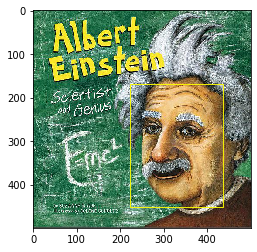

In [109]:
import cv2
if __name__ == '__main__':

    #trained model
    p_model_path = "./model_store/pnet_epoch_10.pt"
    r_model_path = "./model_store/rnet_epoch_10.pt"
    o_model_path = "./model_store/onet_epoch_10.pt"
    pnet, rnet, onet = create_mtcnn_net(p_model_path=p_model_path, r_model_path=r_model_path, o_model_path=o_model_path, use_cuda=False)
    mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=24,threshold=[0.6, 0.7, 0.7])

    img = cv2.imread("./4.jpg")
    img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bboxs, landmarks = mtcnn_detector.detect_face(img)
    # print box_align
    save_name = './r_4.jpg'
    vis_face(img_bg,bboxs,landmarks, save_name)
